In [1]:
import gym
import sys
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.misc import imresize

/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
MAX_EXPERIENCES = 500000
MIN_EXPERIENCES = 50000
TARGET_UPDATE_PERIOD = 10000
IM_SIZE = 80
K = 4  # env.action_space.n

In [3]:
def preprocess(img):
    img_temp = img[31:195]  # Choose the important area of the image
    img_temp = img_temp.mean(axis=2)  # Convert to Grayscale#
    # Downsample image using nearest neighbour interpolation
    img_temp = imresize(img_temp, size=(IM_SIZE, IM_SIZE), interp='nearest')
    return img_temp


def update_state(state, obs):
    obs_small = preprocess(obs)
    return np.append(state[1:], np.expand_dims(obs_small, 0), axis=0)

In [4]:
class DQN:
    def __init__(self, K, scope, save_path= 'models/atari.ckpt'):

        self.K = K
        self.scope = scope
        self.save_path = save_path

        with tf.variable_scope(scope):

            # inputs and targets
            self.X = tf.placeholder(tf.float32, shape=(None, 4, IM_SIZE, IM_SIZE), name='X')

            # tensorflow convolution needs the order to be:
            # (num_samples, height, width, "color")
            # so we need to tranpose later
            self.Q_target = tf.placeholder(tf.float32, shape=(None,), name='G')
            self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')

            # calculate output and cost
            # convolutional layers
            Z = self.X / 255.0
            Z = tf.transpose(Z, [0, 2, 3, 1])
            cnn1 = tf.contrib.layers.conv2d(Z, 32, 8, 4, activation_fn=tf.nn.relu)
            cnn2 = tf.contrib.layers.conv2d(cnn1, 64, 4, 2, activation_fn=tf.nn.relu)
            cnn3 = tf.contrib.layers.conv2d(cnn2, 64, 3, 1, activation_fn=tf.nn.relu)

            # fully connected layers
            fc0 = tf.contrib.layers.flatten(cnn3)
            fc1 = tf.contrib.layers.fully_connected(fc0, 512)

            # final output layer
            self.predict_op = tf.contrib.layers.fully_connected(fc1, K)

            Qpredicted = tf.reduce_sum(self.predict_op * tf.one_hot(self.actions, K),
                reduction_indices=[1]
            )

            self.cost = tf.reduce_mean(tf.square(self.Q_target - Qpredicted))
            self.train_op = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6).minimize(self.cost)


    def copy_from(self, other):
        mine = [t for t in tf.trainable_variables() if t.name.startswith(self.scope)]
        mine = sorted(mine, key=lambda v: v.name)
        theirs = [t for t in tf.trainable_variables() if t.name.startswith(other.scope)]
        theirs = sorted(theirs, key=lambda v: v.name)

        ops = []
        for p, q in zip(mine, theirs):
            actual = self.session.run(q)
            op = p.assign(actual)
            ops.append(op)

        self.session.run(ops)

    def set_session(self, session):
        self.session = session

    def predict(self, states):
        return self.session.run(self.predict_op, feed_dict={self.X: states})

    def update(self, states, actions, targets):
        c, _ = self.session.run(
            [self.cost, self.train_op],
            feed_dict={
                self.X: states,
                self.Q_target: targets,
                self.actions: actions
            }
        )
        return c

    def sample_action(self, x, eps):
        """Implements epsilon greedy algorithm"""
        if np.random.random() < eps:
            return np.random.choice(self.K)
        else:
            return np.argmax(self.predict([x])[0])

    def load(self):
        self.saver = tf.train.Saver(tf.global_variables())
        load_was_success = True
        try:
            save_dir = '/'.join(self.save_path.split('/')[:-1])
            ckpt = tf.train.get_checkpoint_state(save_dir)
            load_path = ckpt.model_checkpoint_path
            self.saver.restore(self.session, load_path)
        except:
            print("no saved model to load. starting new session")
            load_was_success = False
        else:
            print("loaded model: {}".format(load_path))
            saver = tf.train.Saver(tf.global_variables())
            episode_number = int(load_path.split('-')[-1])


    def save(self, n):
        self.saver.save(self.session, self.save_path, global_step=n)
        print("SAVED MODEL #{}".format(n))


In [5]:
def learn(model, target_model, experience_replay_buffer, gamma, batch_size):
    # Sample experiences
    samples = random.sample(experience_replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = map(np.array, zip(*samples))

    # Calculate targets
    next_Qs = target_model.predict(next_states)
    next_Q = np.amax(next_Qs, axis=1)
    targets = rewards + np.invert(dones).astype(np.float32) * gamma * next_Q

    # Update model
    loss = model.update(states, actions, targets)
    return loss


In [6]:
# hyperparameters etc
gamma = 0.97
batch_sz = 64
num_episodes = 2700
total_t = 0
experience_replay_buffer = []
episode_rewards = np.zeros(num_episodes)
last_100_avgs = []

# epsilon for Epsilon Greedy Algorithm
epsilon = 1.0
epsilon_min = 0.1
epsilon_change = (epsilon - epsilon_min) / 700000

# Create Atari Environment
env = gym.envs.make("Breakout-v0")


# Create original and target  Networks
model = DQN(K=K, scope="model")
target_model = DQN(K=K, scope="target_model")

[2018-07-01 21:57:38,273] Making new env: Breakout-v0


INFO:tensorflow:Restoring parameters from models/atari.ckpt-2750


[2018-07-01 21:57:39,914] Restoring parameters from models/atari.ckpt-2750


no saved model to load. starting new session
Filling experience replay buffer...


/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Copied model parameters to target network. total_t = 0, period = 10000
Episode: 0 Duration: 0:00:03.697166 Num steps: 209 Reward: 1.0 Training time per step: 0.014 Avg Reward (Last 100): 1.000 Epsilon: 1.000
SAVED MODEL #0
Episode: 1 Duration: 0:00:04.108321 Num steps: 346 Reward: 3.0 Training time per step: 0.010 Avg Reward (Last 100): 2.000 Epsilon: 0.999
Episode: 2 Duration: 0:00:02.908623 Num steps: 208 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.667 Epsilon: 0.999
Episode: 3 Duration: 0:00:03.344515 Num steps: 250 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.500 Epsilon: 0.999
Episode: 4 Duration: 0:00:03.885956 Num steps: 268 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.600 Epsilon: 0.998
Episode: 5 Duration: 0:00:02.406549 Num steps: 173 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.333 Epsilon: 0.998
Episode: 6 Duration: 0:00:02.464830 Num steps: 181 Reward: 0.0 Training time per step: 0.011

Episode: 59 Duration: 0:00:03.403072 Num steps: 267 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.400 Epsilon: 0.981
Episode: 60 Duration: 0:00:03.187097 Num steps: 236 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.393 Epsilon: 0.980
Episode: 61 Duration: 0:00:03.457489 Num steps: 268 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.403 Epsilon: 0.980
Episode: 62 Duration: 0:00:02.346785 Num steps: 170 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.381 Epsilon: 0.980
Episode: 63 Duration: 0:00:03.741115 Num steps: 301 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.391 Epsilon: 0.979
Episode: 64 Duration: 0:00:03.225535 Num steps: 235 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.385 Epsilon: 0.979
Episode: 65 Duration: 0:00:02.115654 Num steps: 168 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.364 Epsilon: 0.979
Episode: 66 Duration: 0:00:03.9942

Episode: 118 Duration: 0:00:02.487766 Num steps: 172 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.218 Epsilon: 0.963
Episode: 119 Duration: 0:00:02.412872 Num steps: 170 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.188 Epsilon: 0.963
Episode: 120 Duration: 0:00:04.857133 Num steps: 318 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.208 Epsilon: 0.962
Episode: 121 Duration: 0:00:03.666845 Num steps: 240 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.218 Epsilon: 0.962
Episode: 122 Duration: 0:00:03.910910 Num steps: 262 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.208 Epsilon: 0.962
Episode: 123 Duration: 0:00:02.625075 Num steps: 179 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.208 Epsilon: 0.962
Copied model parameters to target network. total_t = 30000, period = 10000
Episode: 124 Duration: 0:00:03.251370 Num steps: 230 Reward: 1.0 Training time per step: 0.

Episode: 176 Duration: 0:00:03.583787 Num steps: 248 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.307 Epsilon: 0.944
Episode: 177 Duration: 0:00:03.706295 Num steps: 248 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.297 Epsilon: 0.944
Episode: 178 Duration: 0:00:02.422356 Num steps: 172 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.277 Epsilon: 0.943
Episode: 179 Duration: 0:00:03.776430 Num steps: 273 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.287 Epsilon: 0.943
Episode: 180 Duration: 0:00:02.201459 Num steps: 173 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.287 Epsilon: 0.943
Episode: 181 Duration: 0:00:05.162981 Num steps: 350 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.297 Epsilon: 0.942
Episode: 182 Duration: 0:00:03.381568 Num steps: 233 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.307 Epsilon: 0.942
Episode: 183 Duration: 0:00

Episode: 235 Duration: 0:00:04.236987 Num steps: 284 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.515 Epsilon: 0.925
Episode: 236 Duration: 0:00:04.762531 Num steps: 328 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.525 Epsilon: 0.924
Episode: 237 Duration: 0:00:03.375630 Num steps: 223 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.535 Epsilon: 0.924
Episode: 238 Duration: 0:00:02.505600 Num steps: 167 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.535 Epsilon: 0.924
Episode: 239 Duration: 0:00:02.507973 Num steps: 176 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.525 Epsilon: 0.923
Episode: 240 Duration: 0:00:03.012154 Num steps: 230 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.515 Epsilon: 0.923
Copied model parameters to target network. total_t = 60000, period = 10000
Episode: 241 Duration: 0:00:04.010162 Num steps: 281 Reward: 2.0 Training time per step: 0.

Episode: 293 Duration: 0:00:02.519049 Num steps: 177 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.267 Epsilon: 0.907
Episode: 294 Duration: 0:00:03.098914 Num steps: 208 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.248 Epsilon: 0.907
Episode: 295 Duration: 0:00:02.487949 Num steps: 169 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.248 Epsilon: 0.906
Episode: 296 Duration: 0:00:02.859024 Num steps: 189 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.248 Epsilon: 0.906
Episode: 297 Duration: 0:00:04.018811 Num steps: 279 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.238 Epsilon: 0.906
Episode: 298 Duration: 0:00:05.121094 Num steps: 334 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.257 Epsilon: 0.905
Episode: 299 Duration: 0:00:02.567483 Num steps: 176 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.257 Epsilon: 0.905
Episode: 300 Duration: 0:00

Episode: 352 Duration: 0:00:02.035531 Num steps: 164 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.168 Epsilon: 0.888
Episode: 353 Duration: 0:00:02.487804 Num steps: 184 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.168 Epsilon: 0.888
Episode: 354 Duration: 0:00:03.435430 Num steps: 230 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.168 Epsilon: 0.888
Episode: 355 Duration: 0:00:03.685044 Num steps: 265 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.188 Epsilon: 0.887
Episode: 356 Duration: 0:00:03.377175 Num steps: 227 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.188 Epsilon: 0.887
Episode: 357 Duration: 0:00:02.553604 Num steps: 174 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.188 Epsilon: 0.887
Episode: 358 Duration: 0:00:02.318562 Num steps: 161 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.168 Epsilon: 0.887
Episode: 359 Duration: 0:00

Episode: 410 Duration: 0:00:02.584775 Num steps: 173 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.317 Epsilon: 0.870
Episode: 411 Duration: 0:00:02.563696 Num steps: 171 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.297 Epsilon: 0.870
Episode: 412 Duration: 0:00:05.493775 Num steps: 357 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.307 Epsilon: 0.869
Episode: 413 Duration: 0:00:02.777816 Num steps: 193 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.287 Epsilon: 0.869
Episode: 414 Duration: 0:00:04.445546 Num steps: 299 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.267 Epsilon: 0.869
Episode: 415 Duration: 0:00:04.286168 Num steps: 318 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.287 Epsilon: 0.868
Episode: 416 Duration: 0:00:02.752177 Num steps: 221 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.287 Epsilon: 0.868
Episode: 417 Duration: 0:00

Episode: 469 Duration: 0:00:04.166947 Num steps: 301 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.535 Epsilon: 0.850
Episode: 470 Duration: 0:00:03.622369 Num steps: 250 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.535 Epsilon: 0.850
Episode: 471 Duration: 0:00:03.325249 Num steps: 250 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.535 Epsilon: 0.849
Episode: 472 Duration: 0:00:02.669793 Num steps: 178 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.535 Epsilon: 0.849
Episode: 473 Duration: 0:00:03.695177 Num steps: 272 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.525 Epsilon: 0.849
Episode: 474 Duration: 0:00:02.621537 Num steps: 178 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.505 Epsilon: 0.849
Episode: 475 Duration: 0:00:02.528922 Num steps: 168 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.505 Epsilon: 0.848
Episode: 476 Duration: 0:00

Episode: 527 Duration: 0:00:03.140467 Num steps: 211 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.307 Epsilon: 0.833
Episode: 528 Duration: 0:00:03.584465 Num steps: 240 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.307 Epsilon: 0.832
Episode: 529 Duration: 0:00:02.655158 Num steps: 183 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.277 Epsilon: 0.832
Episode: 530 Duration: 0:00:03.562315 Num steps: 232 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.267 Epsilon: 0.832
Episode: 531 Duration: 0:00:02.734424 Num steps: 178 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.257 Epsilon: 0.832
Episode: 532 Duration: 0:00:03.190606 Num steps: 209 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.257 Epsilon: 0.831
Episode: 533 Duration: 0:00:03.305380 Num steps: 235 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.257 Epsilon: 0.831
Episode: 534 Duration: 0:00

Episode: 586 Duration: 0:00:04.289237 Num steps: 332 Reward: 3.0 Training time per step: 0.011 Avg Reward (Last 100): 1.356 Epsilon: 0.814
Episode: 587 Duration: 0:00:02.209459 Num steps: 166 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.347 Epsilon: 0.813
Episode: 588 Duration: 0:00:03.546048 Num steps: 283 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.366 Epsilon: 0.813
Episode: 589 Duration: 0:00:02.360138 Num steps: 168 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.347 Epsilon: 0.813
Episode: 590 Duration: 0:00:02.537010 Num steps: 173 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.347 Epsilon: 0.813
Episode: 591 Duration: 0:00:03.489022 Num steps: 230 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.327 Epsilon: 0.812
Episode: 592 Duration: 0:00:03.634797 Num steps: 255 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.337 Epsilon: 0.812
Episode: 593 Duration: 0:00

Episode: 645 Duration: 0:00:04.760243 Num steps: 336 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.228 Epsilon: 0.796
Episode: 646 Duration: 0:00:03.930278 Num steps: 254 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.238 Epsilon: 0.796
Episode: 647 Duration: 0:00:02.422867 Num steps: 170 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.208 Epsilon: 0.796
Episode: 648 Duration: 0:00:04.193077 Num steps: 274 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.208 Epsilon: 0.795
Episode: 649 Duration: 0:00:03.861775 Num steps: 250 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.168 Epsilon: 0.795
Episode: 650 Duration: 0:00:03.835509 Num steps: 247 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.188 Epsilon: 0.795
SAVED MODEL #650
Episode: 651 Duration: 0:00:01.939996 Num steps: 168 Reward: 0.0 Training time per step: 0.010 Avg Reward (Last 100): 1.158 Epsilon: 0.794
Copied mod

Episode: 703 Duration: 0:00:02.371275 Num steps: 179 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.109 Epsilon: 0.779
Episode: 704 Duration: 0:00:03.121390 Num steps: 215 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.099 Epsilon: 0.778
Episode: 705 Duration: 0:00:02.423842 Num steps: 167 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.089 Epsilon: 0.778
Episode: 706 Duration: 0:00:03.674489 Num steps: 240 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.089 Epsilon: 0.778
Episode: 707 Duration: 0:00:02.455090 Num steps: 170 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.079 Epsilon: 0.778
Episode: 708 Duration: 0:00:02.906331 Num steps: 188 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.079 Epsilon: 0.777
Episode: 709 Duration: 0:00:03.600484 Num steps: 239 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.079 Epsilon: 0.777
Episode: 710 Duration: 0:00

Episode: 762 Duration: 0:00:02.087964 Num steps: 166 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.119 Epsilon: 0.761
Episode: 763 Duration: 0:00:02.487007 Num steps: 178 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.109 Epsilon: 0.761
Episode: 764 Duration: 0:00:03.431770 Num steps: 230 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.119 Epsilon: 0.761
Episode: 765 Duration: 0:00:02.729998 Num steps: 209 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.119 Epsilon: 0.761
Episode: 766 Duration: 0:00:02.802979 Num steps: 193 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.099 Epsilon: 0.760
Episode: 767 Duration: 0:00:02.450240 Num steps: 174 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.089 Epsilon: 0.760
Episode: 768 Duration: 0:00:02.602551 Num steps: 170 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.089 Epsilon: 0.760
Episode: 769 Duration: 0:00

Episode: 821 Duration: 0:00:02.841009 Num steps: 205 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 0.990 Epsilon: 0.744
Episode: 822 Duration: 0:00:03.330588 Num steps: 233 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 0.970 Epsilon: 0.744
Episode: 823 Duration: 0:00:04.455715 Num steps: 302 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 0.970 Epsilon: 0.744
Episode: 824 Duration: 0:00:02.482465 Num steps: 167 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 0.970 Epsilon: 0.743
Episode: 825 Duration: 0:00:03.669811 Num steps: 245 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 0.980 Epsilon: 0.743
Copied model parameters to target network. total_t = 200000, period = 10000
Episode: 826 Duration: 0:00:02.374214 Num steps: 179 Reward: 0.0 Training time per step: 0.010 Avg Reward (Last 100): 0.980 Epsilon: 0.743
Episode: 827 Duration: 0:00:03.227449 Num steps: 241 Reward: 1.0 Training time per step: 0

Episode: 879 Duration: 0:00:02.484271 Num steps: 160 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.129 Epsilon: 0.726
Episode: 880 Duration: 0:00:04.028181 Num steps: 258 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.149 Epsilon: 0.726
Episode: 881 Duration: 0:00:05.474800 Num steps: 369 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.158 Epsilon: 0.725
Episode: 882 Duration: 0:00:02.711716 Num steps: 185 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.158 Epsilon: 0.725
Episode: 883 Duration: 0:00:02.397803 Num steps: 180 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.158 Epsilon: 0.725
Episode: 884 Duration: 0:00:03.507889 Num steps: 234 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.168 Epsilon: 0.724
Episode: 885 Duration: 0:00:03.171233 Num steps: 232 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.178 Epsilon: 0.724
Episode: 886 Duration: 0:00

Episode: 938 Duration: 0:00:02.142211 Num steps: 165 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.307 Epsilon: 0.707
Episode: 939 Duration: 0:00:04.689274 Num steps: 306 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.307 Epsilon: 0.706
Episode: 940 Duration: 0:00:02.366674 Num steps: 173 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.277 Epsilon: 0.706
Episode: 941 Duration: 0:00:03.935361 Num steps: 280 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.277 Epsilon: 0.706
Episode: 942 Duration: 0:00:03.922774 Num steps: 273 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.297 Epsilon: 0.705
Episode: 943 Duration: 0:00:03.641000 Num steps: 245 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.317 Epsilon: 0.705
Episode: 944 Duration: 0:00:02.496292 Num steps: 159 Reward: 0.0 Training time per step: 0.013 Avg Reward (Last 100): 1.297 Epsilon: 0.705
Episode: 945 Duration: 0:00

Episode: 996 Duration: 0:00:03.211642 Num steps: 232 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.376 Epsilon: 0.688
Episode: 997 Duration: 0:00:02.648160 Num steps: 170 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.356 Epsilon: 0.688
Episode: 998 Duration: 0:00:03.854751 Num steps: 253 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.356 Epsilon: 0.688
Episode: 999 Duration: 0:00:04.757805 Num steps: 315 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.376 Epsilon: 0.687
Episode: 1000 Duration: 0:00:02.342522 Num steps: 171 Reward: 0.0 Training time per step: 0.011 Avg Reward (Last 100): 1.376 Epsilon: 0.687
SAVED MODEL #1000
Episode: 1001 Duration: 0:00:02.010408 Num steps: 171 Reward: 0.0 Training time per step: 0.010 Avg Reward (Last 100): 1.376 Epsilon: 0.687
Episode: 1002 Duration: 0:00:02.187824 Num steps: 187 Reward: 0.0 Training time per step: 0.010 Avg Reward (Last 100): 1.376 Epsilon: 0.687
Episod

Episode: 1054 Duration: 0:00:06.398758 Num steps: 430 Reward: 5.0 Training time per step: 0.012 Avg Reward (Last 100): 1.525 Epsilon: 0.669
Episode: 1055 Duration: 0:00:04.454653 Num steps: 303 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.545 Epsilon: 0.668
Episode: 1056 Duration: 0:00:04.597173 Num steps: 321 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 1.564 Epsilon: 0.668
Episode: 1057 Duration: 0:00:03.596523 Num steps: 250 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.545 Epsilon: 0.667
Episode: 1058 Duration: 0:00:02.587729 Num steps: 173 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 1.545 Epsilon: 0.667
Episode: 1059 Duration: 0:00:04.558990 Num steps: 297 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.554 Epsilon: 0.667
Episode: 1060 Duration: 0:00:04.536727 Num steps: 310 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.574 Epsilon: 0.666
Episode: 1061 Durati

Episode: 1112 Duration: 0:00:04.316258 Num steps: 283 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 1.911 Epsilon: 0.648
Episode: 1113 Duration: 0:00:03.081346 Num steps: 213 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.901 Epsilon: 0.647
Episode: 1114 Duration: 0:00:02.755626 Num steps: 225 Reward: 1.0 Training time per step: 0.010 Avg Reward (Last 100): 1.911 Epsilon: 0.647
Episode: 1115 Duration: 0:00:03.150852 Num steps: 219 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.901 Epsilon: 0.647
Episode: 1116 Duration: 0:00:03.695508 Num steps: 252 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.911 Epsilon: 0.646
Episode: 1117 Duration: 0:00:04.035149 Num steps: 309 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.911 Epsilon: 0.646
Episode: 1118 Duration: 0:00:03.549131 Num steps: 243 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.891 Epsilon: 0.646
Episode: 1119 Durati

Episode: 1170 Duration: 0:00:02.718728 Num steps: 212 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.693 Epsilon: 0.628
Episode: 1171 Duration: 0:00:06.810464 Num steps: 535 Reward: 7.0 Training time per step: 0.011 Avg Reward (Last 100): 1.752 Epsilon: 0.628
Episode: 1172 Duration: 0:00:03.174445 Num steps: 234 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 1.743 Epsilon: 0.627
Episode: 1173 Duration: 0:00:03.108183 Num steps: 218 Reward: 1.0 Training time per step: 0.012 Avg Reward (Last 100): 1.723 Epsilon: 0.627
Copied model parameters to target network. total_t = 290000, period = 10000
Episode: 1174 Duration: 0:00:04.435122 Num steps: 312 Reward: 3.0 Training time per step: 0.011 Avg Reward (Last 100): 1.733 Epsilon: 0.627
Episode: 1175 Duration: 0:00:03.801284 Num steps: 280 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 1.713 Epsilon: 0.626
Episode: 1176 Duration: 0:00:03.031975 Num steps: 225 Reward: 1.0 Training time per 

Episode: 1228 Duration: 0:00:05.621848 Num steps: 365 Reward: 4.0 Training time per step: 0.012 Avg Reward (Last 100): 2.307 Epsilon: 0.603
Episode: 1229 Duration: 0:00:08.504225 Num steps: 556 Reward: 8.0 Training time per step: 0.012 Avg Reward (Last 100): 2.376 Epsilon: 0.602
Episode: 1230 Duration: 0:00:03.038634 Num steps: 227 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 2.366 Epsilon: 0.602
Episode: 1231 Duration: 0:00:04.817929 Num steps: 326 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 2.376 Epsilon: 0.601
Copied model parameters to target network. total_t = 310000, period = 10000
Episode: 1232 Duration: 0:00:02.932722 Num steps: 200 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 2.366 Epsilon: 0.601
Episode: 1233 Duration: 0:00:02.572695 Num steps: 176 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 2.297 Epsilon: 0.601
Episode: 1234 Duration: 0:00:06.560550 Num steps: 421 Reward: 5.0 Training time per 

Episode: 1286 Duration: 0:00:04.521640 Num steps: 313 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 2.970 Epsilon: 0.579
Episode: 1287 Duration: 0:00:06.677017 Num steps: 447 Reward: 5.0 Training time per step: 0.012 Avg Reward (Last 100): 2.990 Epsilon: 0.578
Episode: 1288 Duration: 0:00:04.188948 Num steps: 295 Reward: 2.0 Training time per step: 0.011 Avg Reward (Last 100): 3.000 Epsilon: 0.578
Episode: 1289 Duration: 0:00:02.640070 Num steps: 184 Reward: 0.0 Training time per step: 0.012 Avg Reward (Last 100): 3.000 Epsilon: 0.577
Episode: 1290 Duration: 0:00:03.991151 Num steps: 251 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 3.000 Epsilon: 0.577
Episode: 1291 Duration: 0:00:04.986774 Num steps: 360 Reward: 4.0 Training time per step: 0.011 Avg Reward (Last 100): 2.950 Epsilon: 0.577
Episode: 1292 Duration: 0:00:04.016970 Num steps: 308 Reward: 3.0 Training time per step: 0.011 Avg Reward (Last 100): 2.970 Epsilon: 0.576
Episode: 1293 Durati

Episode: 1344 Duration: 0:00:03.922974 Num steps: 252 Reward: 2.0 Training time per step: 0.012 Avg Reward (Last 100): 2.970 Epsilon: 0.553
Episode: 1345 Duration: 0:00:02.953446 Num steps: 212 Reward: 1.0 Training time per step: 0.011 Avg Reward (Last 100): 2.950 Epsilon: 0.553
Episode: 1346 Duration: 0:00:04.662367 Num steps: 354 Reward: 4.0 Training time per step: 0.011 Avg Reward (Last 100): 2.960 Epsilon: 0.553
Episode: 1347 Duration: 0:00:05.253063 Num steps: 404 Reward: 4.0 Training time per step: 0.011 Avg Reward (Last 100): 2.960 Epsilon: 0.552
Episode: 1348 Duration: 0:00:06.200759 Num steps: 402 Reward: 4.0 Training time per step: 0.012 Avg Reward (Last 100): 2.950 Epsilon: 0.552
Episode: 1349 Duration: 0:00:09.146513 Num steps: 592 Reward: 14.0 Training time per step: 0.012 Avg Reward (Last 100): 3.050 Epsilon: 0.551
Episode: 1350 Duration: 0:00:04.909978 Num steps: 325 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 3.069 Epsilon: 0.550
SAVED MODEL #1350
C

Episode: 1401 Duration: 0:00:07.472262 Num steps: 606 Reward: 7.0 Training time per step: 0.010 Avg Reward (Last 100): 3.931 Epsilon: 0.524
Episode: 1402 Duration: 0:00:05.436205 Num steps: 384 Reward: 4.0 Training time per step: 0.011 Avg Reward (Last 100): 3.960 Epsilon: 0.523
Episode: 1403 Duration: 0:00:06.799881 Num steps: 449 Reward: 6.0 Training time per step: 0.012 Avg Reward (Last 100): 4.000 Epsilon: 0.523
Episode: 1404 Duration: 0:00:05.520932 Num steps: 359 Reward: 3.0 Training time per step: 0.012 Avg Reward (Last 100): 3.990 Epsilon: 0.522
Episode: 1405 Duration: 0:00:05.887604 Num steps: 393 Reward: 5.0 Training time per step: 0.012 Avg Reward (Last 100): 4.010 Epsilon: 0.522
Episode: 1406 Duration: 0:00:08.320750 Num steps: 566 Reward: 7.0 Training time per step: 0.012 Avg Reward (Last 100): 4.079 Epsilon: 0.521
Episode: 1407 Duration: 0:00:07.072377 Num steps: 479 Reward: 6.0 Training time per step: 0.012 Avg Reward (Last 100): 4.099 Epsilon: 0.520
Episode: 1408 Durati

Episode: 1459 Duration: 0:00:06.593762 Num steps: 424 Reward: 5.0 Training time per step: 0.012 Avg Reward (Last 100): 5.396 Epsilon: 0.486
Episode: 1460 Duration: 0:00:05.400274 Num steps: 379 Reward: 4.0 Training time per step: 0.012 Avg Reward (Last 100): 5.416 Epsilon: 0.486
Copied model parameters to target network. total_t = 400000, period = 10000
Episode: 1461 Duration: 0:00:12.925057 Num steps: 880 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 5.525 Epsilon: 0.485
Episode: 1462 Duration: 0:00:07.765048 Num steps: 489 Reward: 7.0 Training time per step: 0.012 Avg Reward (Last 100): 5.564 Epsilon: 0.484
Episode: 1463 Duration: 0:00:09.567870 Num steps: 660 Reward: 9.0 Training time per step: 0.012 Avg Reward (Last 100): 5.624 Epsilon: 0.483
Episode: 1464 Duration: 0:00:08.761254 Num steps: 626 Reward: 9.0 Training time per step: 0.011 Avg Reward (Last 100): 5.683 Epsilon: 0.482
Episode: 1465 Duration: 0:00:05.902110 Num steps: 391 Reward: 4.0 Training time per

Episode: 1516 Duration: 0:00:07.708254 Num steps: 538 Reward: 11.0 Training time per step: 0.011 Avg Reward (Last 100): 7.386 Epsilon: 0.443
Episode: 1517 Duration: 0:00:10.575859 Num steps: 693 Reward: 12.0 Training time per step: 0.012 Avg Reward (Last 100): 7.436 Epsilon: 0.442
Episode: 1518 Duration: 0:00:08.317468 Num steps: 546 Reward: 8.0 Training time per step: 0.012 Avg Reward (Last 100): 7.416 Epsilon: 0.441
Episode: 1519 Duration: 0:00:07.217388 Num steps: 496 Reward: 6.0 Training time per step: 0.012 Avg Reward (Last 100): 7.416 Epsilon: 0.441
Episode: 1520 Duration: 0:00:10.049280 Num steps: 676 Reward: 10.0 Training time per step: 0.012 Avg Reward (Last 100): 7.515 Epsilon: 0.440
Episode: 1521 Duration: 0:00:10.906394 Num steps: 757 Reward: 10.0 Training time per step: 0.012 Avg Reward (Last 100): 7.584 Epsilon: 0.439
Episode: 1522 Duration: 0:00:09.581490 Num steps: 691 Reward: 13.0 Training time per step: 0.011 Avg Reward (Last 100): 7.624 Epsilon: 0.438
Episode: 1523 D

Copied model parameters to target network. total_t = 470000, period = 10000
Episode: 1573 Duration: 0:00:08.415054 Num steps: 549 Reward: 8.0 Training time per step: 0.012 Avg Reward (Last 100): 9.277 Epsilon: 0.395
Episode: 1574 Duration: 0:00:08.382916 Num steps: 582 Reward: 8.0 Training time per step: 0.011 Avg Reward (Last 100): 9.198 Epsilon: 0.394
Episode: 1575 Duration: 0:00:13.778623 Num steps: 940 Reward: 15.0 Training time per step: 0.011 Avg Reward (Last 100): 9.287 Epsilon: 0.393
Episode: 1576 Duration: 0:00:10.212970 Num steps: 657 Reward: 12.0 Training time per step: 0.012 Avg Reward (Last 100): 9.337 Epsilon: 0.392
Episode: 1577 Duration: 0:00:11.805722 Num steps: 762 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 9.446 Epsilon: 0.391
Episode: 1578 Duration: 0:00:11.827982 Num steps: 803 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 9.485 Epsilon: 0.390
Episode: 1579 Duration: 0:00:09.363281 Num steps: 586 Reward: 8.0 Training time 

Episode: 1629 Duration: 0:00:11.641790 Num steps: 808 Reward: 15.0 Training time per step: 0.011 Avg Reward (Last 100): 10.574 Epsilon: 0.345
Episode: 1630 Duration: 0:00:11.229220 Num steps: 719 Reward: 11.0 Training time per step: 0.012 Avg Reward (Last 100): 10.574 Epsilon: 0.345
Copied model parameters to target network. total_t = 510000, period = 10000
Episode: 1631 Duration: 0:00:12.917099 Num steps: 834 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 10.604 Epsilon: 0.343
Episode: 1632 Duration: 0:00:06.970956 Num steps: 439 Reward: 6.0 Training time per step: 0.012 Avg Reward (Last 100): 10.564 Epsilon: 0.343
Episode: 1633 Duration: 0:00:12.449170 Num steps: 818 Reward: 11.0 Training time per step: 0.012 Avg Reward (Last 100): 10.574 Epsilon: 0.342
Episode: 1634 Duration: 0:00:09.630119 Num steps: 612 Reward: 9.0 Training time per step: 0.012 Avg Reward (Last 100): 10.604 Epsilon: 0.341
Episode: 1635 Duration: 0:00:09.481689 Num steps: 628 Reward: 9.0 Training

Copied model parameters to target network. total_t = 550000, period = 10000
Episode: 1685 Duration: 0:00:13.342748 Num steps: 863 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 11.921 Epsilon: 0.292
Episode: 1686 Duration: 0:00:10.503974 Num steps: 663 Reward: 10.0 Training time per step: 0.012 Avg Reward (Last 100): 11.911 Epsilon: 0.291
Episode: 1687 Duration: 0:00:13.087383 Num steps: 859 Reward: 15.0 Training time per step: 0.012 Avg Reward (Last 100): 11.970 Epsilon: 0.290
Episode: 1688 Duration: 0:00:08.138711 Num steps: 492 Reward: 7.0 Training time per step: 0.012 Avg Reward (Last 100): 11.931 Epsilon: 0.290
Episode: 1689 Duration: 0:00:11.029399 Num steps: 683 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 11.941 Epsilon: 0.289
Episode: 1690 Duration: 0:00:07.347004 Num steps: 474 Reward: 7.0 Training time per step: 0.012 Avg Reward (Last 100): 11.921 Epsilon: 0.288
Episode: 1691 Duration: 0:00:09.266301 Num steps: 598 Reward: 7.0 Training

Episode: 1740 Duration: 0:00:14.386357 Num steps: 887 Reward: 17.0 Training time per step: 0.012 Avg Reward (Last 100): 13.574 Epsilon: 0.237
Episode: 1741 Duration: 0:00:13.217459 Num steps: 874 Reward: 14.0 Training time per step: 0.012 Avg Reward (Last 100): 13.594 Epsilon: 0.236
Episode: 1742 Duration: 0:00:08.614660 Num steps: 537 Reward: 10.0 Training time per step: 0.012 Avg Reward (Last 100): 13.584 Epsilon: 0.236
Episode: 1743 Duration: 0:00:12.101299 Num steps: 743 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 13.505 Epsilon: 0.235
Episode: 1744 Duration: 0:00:15.466081 Num steps: 974 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 13.614 Epsilon: 0.233
Episode: 1745 Duration: 0:00:11.267105 Num steps: 733 Reward: 12.0 Training time per step: 0.012 Avg Reward (Last 100): 13.574 Epsilon: 0.232
Episode: 1746 Duration: 0:00:12.967653 Num steps: 834 Reward: 14.0 Training time per step: 0.012 Avg Reward (Last 100): 13.584 Epsilon: 0.231
Episod

Episode: 1796 Duration: 0:00:11.367618 Num steps: 748 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 14.782 Epsilon: 0.177
Copied model parameters to target network. total_t = 640000, period = 10000
Episode: 1797 Duration: 0:00:15.504905 Num steps: 968 Reward: 22.0 Training time per step: 0.012 Avg Reward (Last 100): 14.921 Epsilon: 0.176
Episode: 1798 Duration: 0:00:10.405946 Num steps: 641 Reward: 11.0 Training time per step: 0.012 Avg Reward (Last 100): 14.941 Epsilon: 0.175
Episode: 1799 Duration: 0:00:10.805441 Num steps: 656 Reward: 10.0 Training time per step: 0.012 Avg Reward (Last 100): 14.792 Epsilon: 0.174
Episode: 1800 Duration: 0:00:15.714914 Num steps: 998 Reward: 19.0 Training time per step: 0.012 Avg Reward (Last 100): 14.911 Epsilon: 0.173
SAVED MODEL #1800
Episode: 1801 Duration: 0:00:11.680526 Num steps: 915 Reward: 15.0 Training time per step: 0.010 Avg Reward (Last 100): 14.970 Epsilon: 0.172
Episode: 1802 Duration: 0:00:11.516179 Num steps: 727 

SAVED MODEL #1850
Episode: 1851 Duration: 0:00:14.403221 Num steps: 1138 Reward: 27.0 Training time per step: 0.010 Avg Reward (Last 100): 15.752 Epsilon: 0.117
Episode: 1852 Duration: 0:00:15.358638 Num steps: 998 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 15.802 Epsilon: 0.116
Episode: 1853 Duration: 0:00:14.903593 Num steps: 943 Reward: 22.0 Training time per step: 0.012 Avg Reward (Last 100): 15.842 Epsilon: 0.114
Episode: 1854 Duration: 0:00:14.430271 Num steps: 865 Reward: 15.0 Training time per step: 0.012 Avg Reward (Last 100): 15.802 Epsilon: 0.113
Copied model parameters to target network. total_t = 690000, period = 10000
Episode: 1855 Duration: 0:00:15.304759 Num steps: 968 Reward: 16.0 Training time per step: 0.012 Avg Reward (Last 100): 15.842 Epsilon: 0.112
Episode: 1856 Duration: 0:00:13.538196 Num steps: 926 Reward: 20.0 Training time per step: 0.011 Avg Reward (Last 100): 15.842 Epsilon: 0.111
Episode: 1857 Duration: 0:00:17.543876 Num steps: 110

Copied model parameters to target network. total_t = 740000, period = 10000
Episode: 1906 Duration: 0:00:15.124239 Num steps: 955 Reward: 23.0 Training time per step: 0.012 Avg Reward (Last 100): 17.871 Epsilon: 0.100
Episode: 1907 Duration: 0:00:13.458148 Num steps: 875 Reward: 16.0 Training time per step: 0.012 Avg Reward (Last 100): 17.950 Epsilon: 0.100
Episode: 1908 Duration: 0:00:13.472179 Num steps: 875 Reward: 15.0 Training time per step: 0.012 Avg Reward (Last 100): 17.861 Epsilon: 0.100
Episode: 1909 Duration: 0:00:13.389437 Num steps: 855 Reward: 16.0 Training time per step: 0.012 Avg Reward (Last 100): 17.861 Epsilon: 0.100
Episode: 1910 Duration: 0:00:19.669828 Num steps: 1242 Reward: 25.0 Training time per step: 0.012 Avg Reward (Last 100): 17.842 Epsilon: 0.100
Episode: 1911 Duration: 0:00:12.120708 Num steps: 792 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 17.851 Epsilon: 0.100
Episode: 1912 Duration: 0:00:16.615873 Num steps: 1054 Reward: 31.0 Tra

Episode: 1961 Duration: 0:00:19.636002 Num steps: 1255 Reward: 38.0 Training time per step: 0.012 Avg Reward (Last 100): 21.475 Epsilon: 0.100
Episode: 1962 Duration: 0:00:16.322971 Num steps: 1042 Reward: 25.0 Training time per step: 0.012 Avg Reward (Last 100): 21.564 Epsilon: 0.100
Copied model parameters to target network. total_t = 800000, period = 10000
Episode: 1963 Duration: 0:00:20.357159 Num steps: 1273 Reward: 31.0 Training time per step: 0.012 Avg Reward (Last 100): 21.624 Epsilon: 0.100
Episode: 1964 Duration: 0:00:17.819582 Num steps: 1186 Reward: 24.0 Training time per step: 0.011 Avg Reward (Last 100): 21.683 Epsilon: 0.100
Episode: 1965 Duration: 0:00:17.959590 Num steps: 1135 Reward: 31.0 Training time per step: 0.012 Avg Reward (Last 100): 21.792 Epsilon: 0.100
Episode: 1966 Duration: 0:00:13.717864 Num steps: 817 Reward: 14.0 Training time per step: 0.012 Avg Reward (Last 100): 21.733 Epsilon: 0.100
Episode: 1967 Duration: 0:00:20.705655 Num steps: 1331 Reward: 30.0

Episode: 2016 Duration: 0:00:17.495505 Num steps: 1090 Reward: 25.0 Training time per step: 0.012 Avg Reward (Last 100): 23.188 Epsilon: 0.100
Episode: 2017 Duration: 0:00:13.811196 Num steps: 873 Reward: 35.0 Training time per step: 0.012 Avg Reward (Last 100): 23.248 Epsilon: 0.100
Episode: 2018 Duration: 0:00:23.795202 Num steps: 1452 Reward: 41.0 Training time per step: 0.012 Avg Reward (Last 100): 23.475 Epsilon: 0.100
Episode: 2019 Duration: 0:00:17.657353 Num steps: 1128 Reward: 35.0 Training time per step: 0.012 Avg Reward (Last 100): 23.416 Epsilon: 0.100
Copied model parameters to target network. total_t = 860000, period = 10000
Episode: 2020 Duration: 0:00:18.961290 Num steps: 1178 Reward: 21.0 Training time per step: 0.012 Avg Reward (Last 100): 23.396 Epsilon: 0.100
Episode: 2021 Duration: 0:00:16.610352 Num steps: 1041 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 23.396 Epsilon: 0.100
Episode: 2022 Duration: 0:00:13.945197 Num steps: 911 Reward: 26.0 

Episode: 2071 Duration: 0:00:16.760809 Num steps: 1079 Reward: 24.0 Training time per step: 0.012 Avg Reward (Last 100): 23.505 Epsilon: 0.100
Episode: 2072 Duration: 0:00:12.823897 Num steps: 820 Reward: 15.0 Training time per step: 0.012 Avg Reward (Last 100): 23.515 Epsilon: 0.100
Episode: 2073 Duration: 0:00:16.552289 Num steps: 1060 Reward: 20.0 Training time per step: 0.012 Avg Reward (Last 100): 23.426 Epsilon: 0.100
Episode: 2074 Duration: 0:00:20.929665 Num steps: 1389 Reward: 34.0 Training time per step: 0.011 Avg Reward (Last 100): 23.485 Epsilon: 0.100
Episode: 2075 Duration: 0:00:13.806547 Num steps: 860 Reward: 21.0 Training time per step: 0.012 Avg Reward (Last 100): 23.386 Epsilon: 0.100
Copied model parameters to target network. total_t = 920000, period = 10000
Episode: 2076 Duration: 0:00:22.462366 Num steps: 1391 Reward: 37.0 Training time per step: 0.012 Avg Reward (Last 100): 23.515 Epsilon: 0.100
Episode: 2077 Duration: 0:00:14.778443 Num steps: 901 Reward: 21.0 T

Episode: 2126 Duration: 0:00:15.535089 Num steps: 949 Reward: 22.0 Training time per step: 0.012 Avg Reward (Last 100): 23.287 Epsilon: 0.100
Episode: 2127 Duration: 0:00:12.596946 Num steps: 831 Reward: 14.0 Training time per step: 0.012 Avg Reward (Last 100): 23.198 Epsilon: 0.100
Episode: 2128 Duration: 0:00:15.916714 Num steps: 1011 Reward: 26.0 Training time per step: 0.012 Avg Reward (Last 100): 23.307 Epsilon: 0.100
Episode: 2129 Duration: 0:00:11.798874 Num steps: 773 Reward: 12.0 Training time per step: 0.012 Avg Reward (Last 100): 23.010 Epsilon: 0.100
Episode: 2130 Duration: 0:00:15.913564 Num steps: 1004 Reward: 21.0 Training time per step: 0.012 Avg Reward (Last 100): 22.990 Epsilon: 0.100
Episode: 2131 Duration: 0:00:15.179034 Num steps: 964 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 23.020 Epsilon: 0.100
Episode: 2132 Duration: 0:00:19.549140 Num steps: 1313 Reward: 34.0 Training time per step: 0.011 Avg Reward (Last 100): 23.178 Epsilon: 0.100
Epi

Episode: 2181 Duration: 0:00:14.293873 Num steps: 920 Reward: 23.0 Training time per step: 0.012 Avg Reward (Last 100): 21.465 Epsilon: 0.100
Episode: 2182 Duration: 0:00:16.158735 Num steps: 1069 Reward: 27.0 Training time per step: 0.012 Avg Reward (Last 100): 21.604 Epsilon: 0.100
Episode: 2183 Duration: 0:00:16.668879 Num steps: 1064 Reward: 37.0 Training time per step: 0.012 Avg Reward (Last 100): 21.762 Epsilon: 0.100
Episode: 2184 Duration: 0:00:14.628559 Num steps: 886 Reward: 12.0 Training time per step: 0.012 Avg Reward (Last 100): 21.762 Epsilon: 0.100
Copied model parameters to target network. total_t = 1030000, period = 10000
Episode: 2185 Duration: 0:00:17.390537 Num steps: 1086 Reward: 25.0 Training time per step: 0.012 Avg Reward (Last 100): 21.891 Epsilon: 0.100
Episode: 2186 Duration: 0:00:15.208170 Num steps: 945 Reward: 19.0 Training time per step: 0.012 Avg Reward (Last 100): 21.396 Epsilon: 0.100
Episode: 2187 Duration: 0:00:11.725276 Num steps: 725 Reward: 13.0 T

Copied model parameters to target network. total_t = 1080000, period = 10000
Episode: 2236 Duration: 0:00:22.158916 Num steps: 1422 Reward: 29.0 Training time per step: 0.012 Avg Reward (Last 100): 20.950 Epsilon: 0.100
Episode: 2237 Duration: 0:00:20.754336 Num steps: 1293 Reward: 36.0 Training time per step: 0.012 Avg Reward (Last 100): 21.198 Epsilon: 0.100
Episode: 2238 Duration: 0:00:22.181666 Num steps: 1444 Reward: 39.0 Training time per step: 0.012 Avg Reward (Last 100): 21.366 Epsilon: 0.100
Episode: 2239 Duration: 0:00:15.870287 Num steps: 1024 Reward: 21.0 Training time per step: 0.012 Avg Reward (Last 100): 21.337 Epsilon: 0.100
Episode: 2240 Duration: 0:00:14.957817 Num steps: 965 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 21.287 Epsilon: 0.100
Episode: 2241 Duration: 0:00:22.663204 Num steps: 1492 Reward: 40.0 Training time per step: 0.012 Avg Reward (Last 100): 21.356 Epsilon: 0.100
Episode: 2242 Duration: 0:00:21.823011 Num steps: 1379 Reward: 45.

Episode: 2291 Duration: 0:00:15.774434 Num steps: 957 Reward: 20.0 Training time per step: 0.012 Avg Reward (Last 100): 22.079 Epsilon: 0.100
Episode: 2292 Duration: 0:00:15.391973 Num steps: 1004 Reward: 20.0 Training time per step: 0.012 Avg Reward (Last 100): 21.960 Epsilon: 0.100
Episode: 2293 Duration: 0:00:12.782061 Num steps: 822 Reward: 15.0 Training time per step: 0.012 Avg Reward (Last 100): 21.851 Epsilon: 0.100
Episode: 2294 Duration: 0:00:11.729912 Num steps: 751 Reward: 20.0 Training time per step: 0.012 Avg Reward (Last 100): 21.901 Epsilon: 0.100
Episode: 2295 Duration: 0:00:17.052775 Num steps: 1088 Reward: 22.0 Training time per step: 0.012 Avg Reward (Last 100): 21.911 Epsilon: 0.100
Copied model parameters to target network. total_t = 1140000, period = 10000
Episode: 2296 Duration: 0:00:10.852216 Num steps: 680 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 21.881 Epsilon: 0.100
Episode: 2297 Duration: 0:00:14.788845 Num steps: 940 Reward: 20.0 Tr

Episode: 2346 Duration: 0:00:11.802228 Num steps: 766 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 19.505 Epsilon: 0.100
Episode: 2347 Duration: 0:00:20.124077 Num steps: 1254 Reward: 43.0 Training time per step: 0.012 Avg Reward (Last 100): 19.683 Epsilon: 0.100
Episode: 2348 Duration: 0:00:18.774723 Num steps: 1244 Reward: 28.0 Training time per step: 0.011 Avg Reward (Last 100): 19.861 Epsilon: 0.100
Episode: 2349 Duration: 0:00:12.329664 Num steps: 814 Reward: 15.0 Training time per step: 0.012 Avg Reward (Last 100): 19.594 Epsilon: 0.100
Copied model parameters to target network. total_t = 1190000, period = 10000
Episode: 2350 Duration: 0:00:26.998106 Num steps: 1664 Reward: 46.0 Training time per step: 0.012 Avg Reward (Last 100): 19.802 Epsilon: 0.100
SAVED MODEL #2350
Episode: 2351 Duration: 0:00:14.996816 Num steps: 1208 Reward: 22.0 Training time per step: 0.010 Avg Reward (Last 100): 19.881 Epsilon: 0.100
Episode: 2352 Duration: 0:00:13.367601 Num steps:

SAVED MODEL #2400
Episode: 2401 Duration: 0:00:14.052649 Num steps: 1137 Reward: 28.0 Training time per step: 0.010 Avg Reward (Last 100): 18.594 Epsilon: 0.100
Episode: 2402 Duration: 0:00:16.850261 Num steps: 1138 Reward: 19.0 Training time per step: 0.011 Avg Reward (Last 100): 18.554 Epsilon: 0.100
Copied model parameters to target network. total_t = 1240000, period = 10000
Episode: 2403 Duration: 0:00:19.054721 Num steps: 1138 Reward: 19.0 Training time per step: 0.012 Avg Reward (Last 100): 18.584 Epsilon: 0.100
Episode: 2404 Duration: 0:00:13.260494 Num steps: 848 Reward: 23.0 Training time per step: 0.012 Avg Reward (Last 100): 18.673 Epsilon: 0.100
Episode: 2405 Duration: 0:00:12.308814 Num steps: 793 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 18.594 Epsilon: 0.100
Episode: 2406 Duration: 0:00:19.336730 Num steps: 1279 Reward: 39.0 Training time per step: 0.012 Avg Reward (Last 100): 18.653 Epsilon: 0.100
Episode: 2407 Duration: 0:00:15.443281 Num steps:

Episode: 2456 Duration: 0:00:16.220871 Num steps: 1029 Reward: 17.0 Training time per step: 0.012 Avg Reward (Last 100): 18.594 Epsilon: 0.100
Copied model parameters to target network. total_t = 1290000, period = 10000
Episode: 2457 Duration: 0:00:15.210400 Num steps: 1027 Reward: 18.0 Training time per step: 0.011 Avg Reward (Last 100): 18.535 Epsilon: 0.100
Episode: 2458 Duration: 0:00:11.009985 Num steps: 687 Reward: 11.0 Training time per step: 0.012 Avg Reward (Last 100): 18.446 Epsilon: 0.100
Episode: 2459 Duration: 0:00:15.246151 Num steps: 963 Reward: 21.0 Training time per step: 0.012 Avg Reward (Last 100): 18.406 Epsilon: 0.100
Episode: 2460 Duration: 0:00:11.296734 Num steps: 755 Reward: 18.0 Training time per step: 0.011 Avg Reward (Last 100): 18.376 Epsilon: 0.100
Episode: 2461 Duration: 0:00:12.781798 Num steps: 843 Reward: 19.0 Training time per step: 0.012 Avg Reward (Last 100): 18.455 Epsilon: 0.100
Episode: 2462 Duration: 0:00:09.655337 Num steps: 640 Reward: 11.0 Tr

Episode: 2511 Duration: 0:00:11.737311 Num steps: 803 Reward: 12.0 Training time per step: 0.011 Avg Reward (Last 100): 17.525 Epsilon: 0.100
Episode: 2512 Duration: 0:00:16.009663 Num steps: 1073 Reward: 26.0 Training time per step: 0.011 Avg Reward (Last 100): 17.614 Epsilon: 0.100
Episode: 2513 Duration: 0:00:16.048436 Num steps: 1051 Reward: 29.0 Training time per step: 0.012 Avg Reward (Last 100): 17.822 Epsilon: 0.100
Copied model parameters to target network. total_t = 1340000, period = 10000
Episode: 2514 Duration: 0:00:20.038794 Num steps: 1249 Reward: 42.0 Training time per step: 0.012 Avg Reward (Last 100): 18.059 Epsilon: 0.100
Episode: 2515 Duration: 0:00:18.075598 Num steps: 1166 Reward: 26.0 Training time per step: 0.012 Avg Reward (Last 100): 18.158 Epsilon: 0.100
Episode: 2516 Duration: 0:00:10.910966 Num steps: 683 Reward: 10.0 Training time per step: 0.012 Avg Reward (Last 100): 18.129 Epsilon: 0.100
Episode: 2517 Duration: 0:00:18.055161 Num steps: 1168 Reward: 25.0

Episode: 2566 Duration: 0:00:11.908060 Num steps: 802 Reward: 20.0 Training time per step: 0.011 Avg Reward (Last 100): 18.099 Epsilon: 0.100
Copied model parameters to target network. total_t = 1390000, period = 10000
Episode: 2567 Duration: 0:00:13.359572 Num steps: 858 Reward: 13.0 Training time per step: 0.011 Avg Reward (Last 100): 18.069 Epsilon: 0.100
Episode: 2568 Duration: 0:00:15.006901 Num steps: 986 Reward: 28.0 Training time per step: 0.012 Avg Reward (Last 100): 18.129 Epsilon: 0.100
Episode: 2569 Duration: 0:00:11.842748 Num steps: 801 Reward: 17.0 Training time per step: 0.011 Avg Reward (Last 100): 18.188 Epsilon: 0.100
Episode: 2570 Duration: 0:00:12.487488 Num steps: 832 Reward: 15.0 Training time per step: 0.011 Avg Reward (Last 100): 18.040 Epsilon: 0.100
Episode: 2571 Duration: 0:00:16.364172 Num steps: 1026 Reward: 21.0 Training time per step: 0.012 Avg Reward (Last 100): 18.178 Epsilon: 0.100
Episode: 2572 Duration: 0:00:18.025833 Num steps: 1116 Reward: 24.0 Tr

Episode: 2621 Duration: 0:00:12.369129 Num steps: 782 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 18.594 Epsilon: 0.100
Copied model parameters to target network. total_t = 1440000, period = 10000
Episode: 2622 Duration: 0:00:19.983441 Num steps: 1245 Reward: 33.0 Training time per step: 0.012 Avg Reward (Last 100): 18.762 Epsilon: 0.100
Episode: 2623 Duration: 0:00:16.346312 Num steps: 1053 Reward: 18.0 Training time per step: 0.012 Avg Reward (Last 100): 18.743 Epsilon: 0.100
Episode: 2624 Duration: 0:00:12.281468 Num steps: 842 Reward: 14.0 Training time per step: 0.011 Avg Reward (Last 100): 18.743 Epsilon: 0.100
Episode: 2625 Duration: 0:00:11.513840 Num steps: 728 Reward: 10.0 Training time per step: 0.012 Avg Reward (Last 100): 18.713 Epsilon: 0.100
Episode: 2626 Duration: 0:00:13.772846 Num steps: 851 Reward: 15.0 Training time per step: 0.012 Avg Reward (Last 100): 18.723 Epsilon: 0.100
Episode: 2627 Duration: 0:00:16.515287 Num steps: 1042 Reward: 24.0 T

Copied model parameters to target network. total_t = 1490000, period = 10000
Episode: 2676 Duration: 0:00:20.939546 Num steps: 1368 Reward: 41.0 Training time per step: 0.011 Avg Reward (Last 100): 19.248 Epsilon: 0.100
Episode: 2677 Duration: 0:00:13.743141 Num steps: 884 Reward: 16.0 Training time per step: 0.012 Avg Reward (Last 100): 19.178 Epsilon: 0.100
Episode: 2678 Duration: 0:00:18.896178 Num steps: 1226 Reward: 24.0 Training time per step: 0.012 Avg Reward (Last 100): 19.307 Epsilon: 0.100
Episode: 2679 Duration: 0:00:09.565347 Num steps: 610 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 19.109 Epsilon: 0.100
Episode: 2680 Duration: 0:00:11.954257 Num steps: 750 Reward: 12.0 Training time per step: 0.012 Avg Reward (Last 100): 19.119 Epsilon: 0.100
Episode: 2681 Duration: 0:00:10.988029 Num steps: 710 Reward: 13.0 Training time per step: 0.012 Avg Reward (Last 100): 19.069 Epsilon: 0.100
Episode: 2682 Duration: 0:00:12.644259 Num steps: 826 Reward: 20.0 Tr

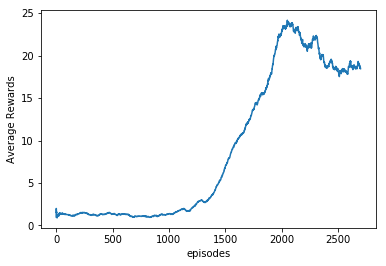

In [7]:
with tf.Session() as sess:
    model.set_session(sess)
    target_model.set_session(sess)
    sess.run(tf.global_variables_initializer())
    model.load()

    print("Filling experience replay buffer...")
    obs = env.reset()
    obs_small = preprocess(obs)
    state = np.stack([obs_small] * 4, axis=0)

    # Fill experience replay buffer
    for i in range(MIN_EXPERIENCES):

        action = np.random.randint(0,K)
        obs, reward, done, _ = env.step(action)
        next_state = update_state(state, obs)

        experience_replay_buffer.append((state, action, reward, next_state, done))

        if done:
            obs = env.reset()
            obs_small = preprocess(obs)
            state = np.stack([obs_small] * 4, axis=0)

        else:
            state = next_state

    # Play a number of episodes and learn
    for i in range(num_episodes):
        t0 = datetime.now()

        # Reset the environment
        obs = env.reset()
        obs_small = preprocess(obs)
        state = np.stack([obs_small] * 4, axis=0)
        assert (state.shape == (4, 80, 80))
        loss = None

        total_time_training = 0
        num_steps_in_episode = 0
        episode_reward = 0

        done = False
        while not done:

            # Update target network
            if total_t % TARGET_UPDATE_PERIOD == 0:
                target_model.copy_from(model)
                print("Copied model parameters to target network. total_t = %s, period = %s" % (
                        total_t, TARGET_UPDATE_PERIOD))

            # Take action
            action = model.sample_action(state, epsilon)
            obs, reward, done, _ = env.step(action)
            obs_small = preprocess(obs)
            next_state = np.append(state[1:], np.expand_dims(obs_small, 0), axis=0)

            episode_reward += reward

            # Remove oldest experience if replay buffer is full
            if len(experience_replay_buffer) == MAX_EXPERIENCES:
                experience_replay_buffer.pop(0)

            # Save the recent experience
            experience_replay_buffer.append((state, action, reward, next_state, done))

            # Train the model and keep measure of time
            t0_2 = datetime.now()
            loss = learn(model, target_model, experience_replay_buffer, gamma, batch_sz)
            dt = datetime.now() - t0_2

            total_time_training += dt.total_seconds()
            num_steps_in_episode += 1

            state = next_state
            total_t += 1

            epsilon = max(epsilon - epsilon_change, epsilon_min)

        duration = datetime.now() - t0

        episode_rewards[i] = episode_reward
        time_per_step = total_time_training / num_steps_in_episode

        last_100_avg = episode_rewards[max(0, i - 100):i + 1].mean()
        last_100_avgs.append(last_100_avg)
        print("Episode:", i,"Duration:", duration, "Num steps:", num_steps_in_episode,
                "Reward:", episode_reward, "Training time per step:", "%.3f" % time_per_step,
                "Avg Reward (Last 100):", "%.3f" % last_100_avg,"Epsilon:", "%.3f" % epsilon)

        if i % 50 == 0:
            model.save(i)
        sys.stdout.flush()

#Plots
plt.plot(last_100_avgs)
plt.xlabel('episodes')
plt.ylabel('Average Rewards')
plt.show()
env.close()

In [9]:
from gym import wrappers
env = gym.envs.make("Breakout-v0")
env = wrappers.Monitor(env, 'save-mov',force=True)
with tf.Session() as sess:
    
    model.set_session(sess)
    target_model.set_session(sess)
    sess.run(tf.global_variables_initializer())
    model.load()
    
    obs = env.reset()
    obs_small = preprocess(obs)
    state = np.stack([obs_small] * 4, axis=0)
    done = False
    while not done:
        action = model.sample_action(state, epsilon)
        obs, reward, done, _ = env.step(action)
        env.render()
        next_state = update_state(state, obs)
        state = next_state
env.close()

[2018-07-02 04:50:47,488] Making new env: Breakout-v0
[2018-07-02 04:50:47,635] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/am/Dropbox/AIforIoT/Chapter06/save-mov')
[2018-07-02 04:50:47,635] Clearing 2 monitor files from previous run (because force=True was provided)


INFO:tensorflow:Restoring parameters from models/atari.ckpt-2650


[2018-07-02 04:50:49,809] Restoring parameters from models/atari.ckpt-2650


loaded model: models/atari.ckpt-2650


[2018-07-02 04:50:50,049] Starting new video recorder writing to /home/am/Dropbox/AIforIoT/Chapter06/save-mov/openaigym.video.1.1230.video000000.mp4
/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
[2018-07-02 04:50:59,305] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/am/Dropbox/AIforIoT/Chapter06/save-mov')


In [10]:
env = gym.envs.make("Breakout-v0")
frames = []
with tf.Session() as sess:
    model.set_session(sess)
    target_model.set_session(sess)
    sess.run(tf.global_variables_initializer())
    model.load()
    
    obs = env.reset()
    obs_small = preprocess(obs)
    state = np.stack([obs_small] * 4, axis=0)
    done = False
    while not done:
        action = model.sample_action(state, epsilon)
        obs, reward, done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        next_state = update_state(state, obs)
        state = next_state


[2018-07-02 04:51:14,953] Making new env: Breakout-v0


INFO:tensorflow:Restoring parameters from models/atari.ckpt-2650


[2018-07-02 04:51:17,560] Restoring parameters from models/atari.ckpt-2650


loaded model: models/atari.ckpt-2650


/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.



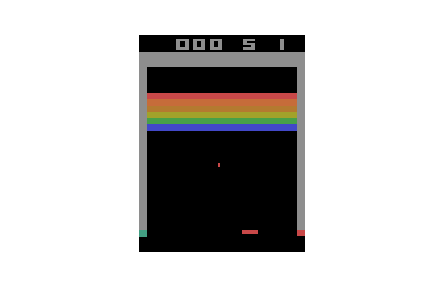
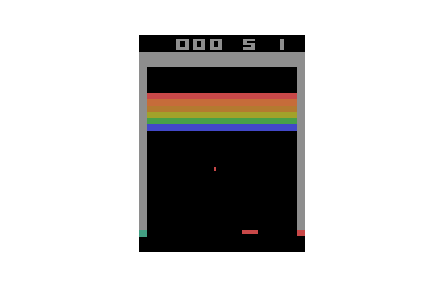
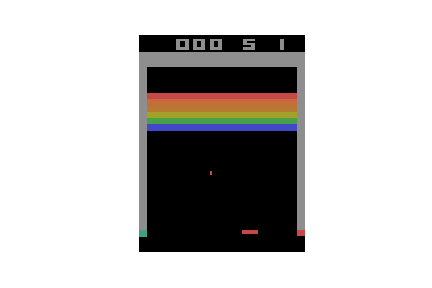
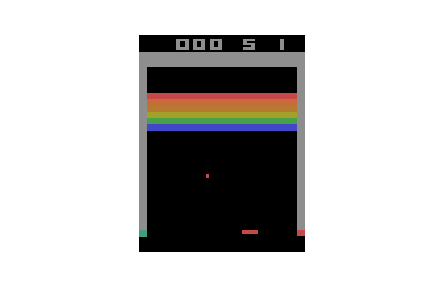
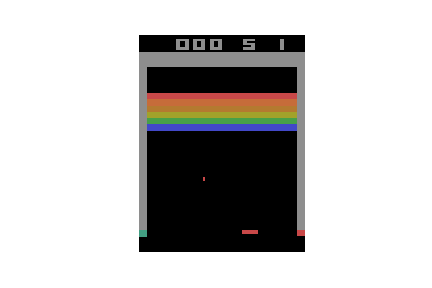
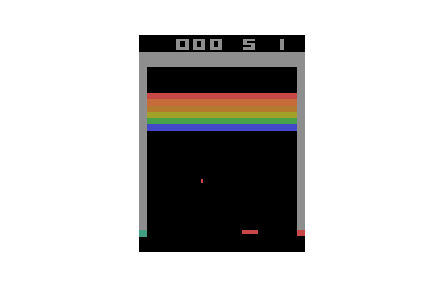
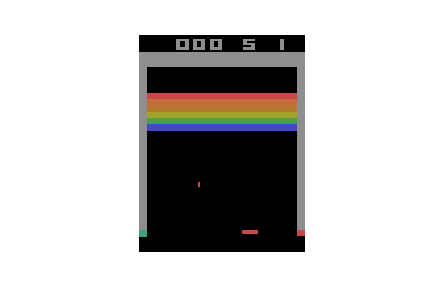
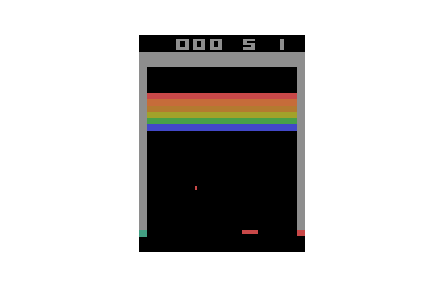
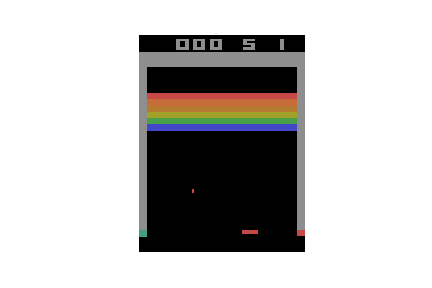
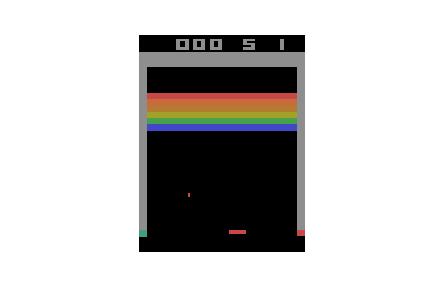
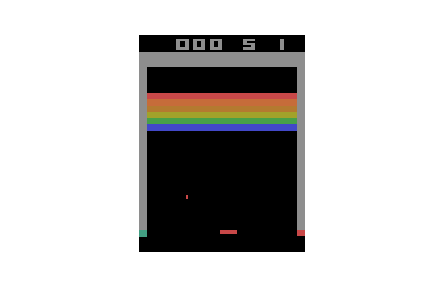
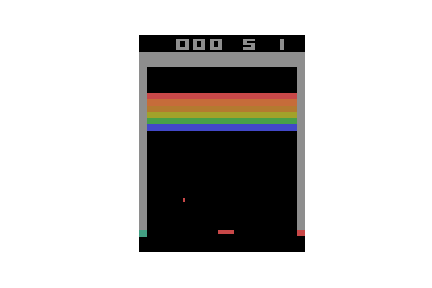
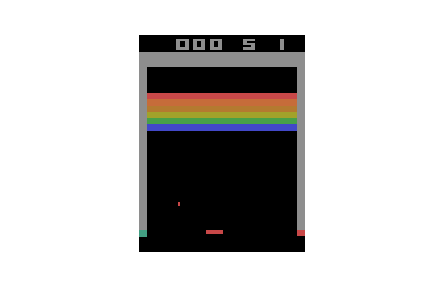
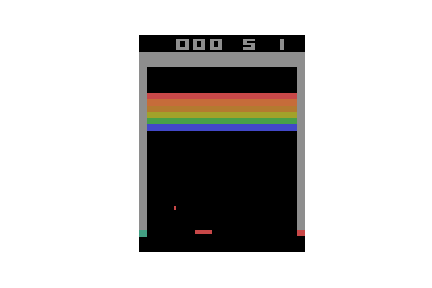
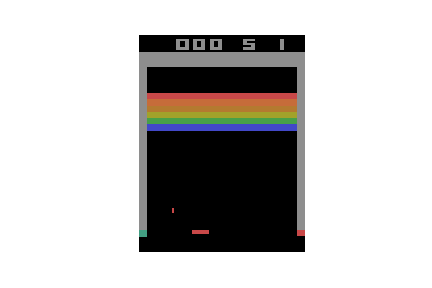
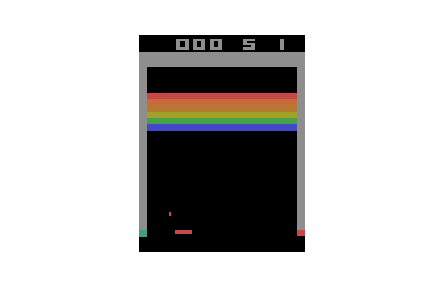
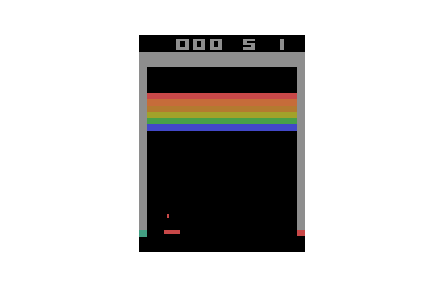
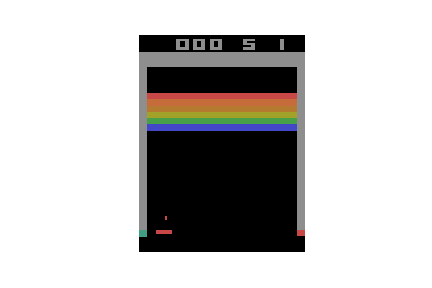
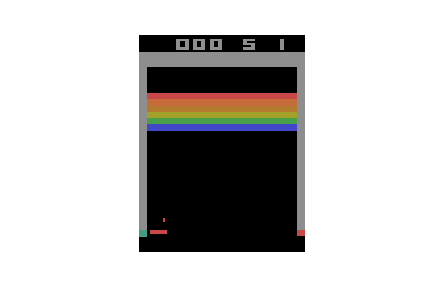
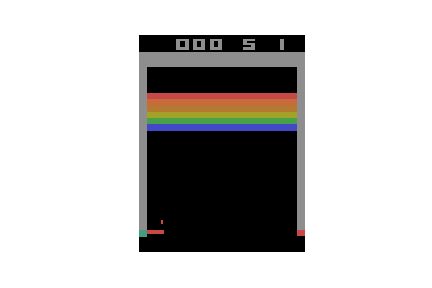
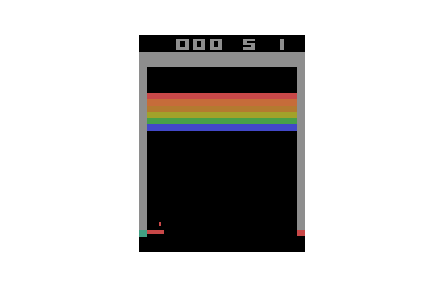
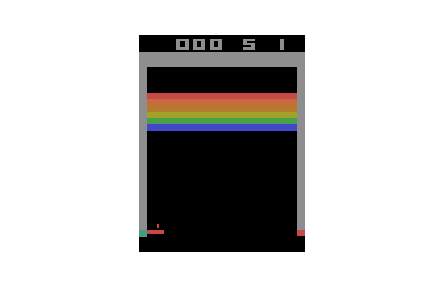
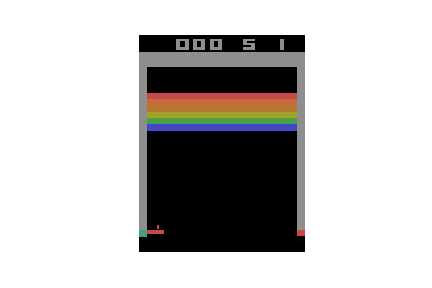
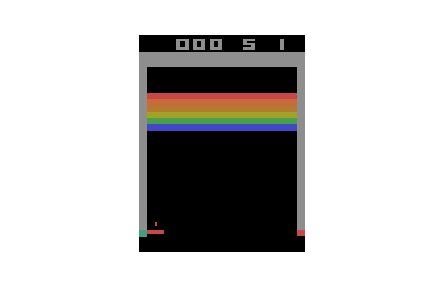
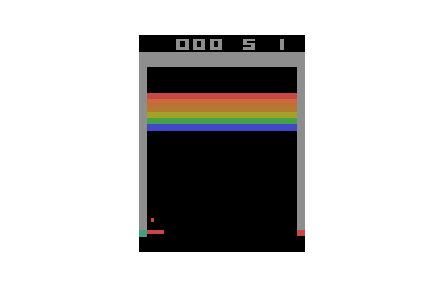
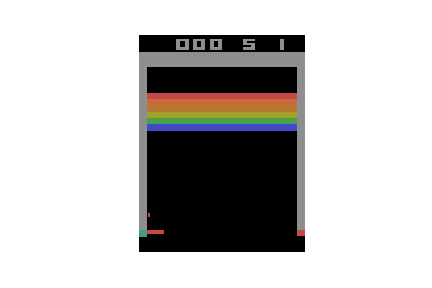
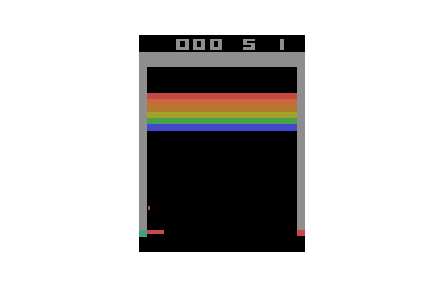
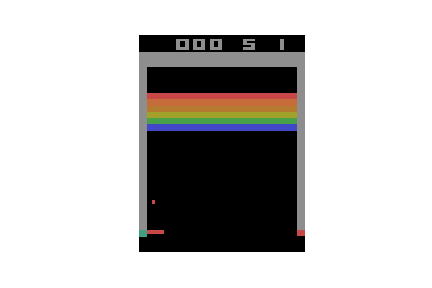
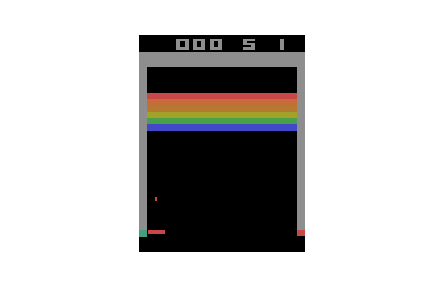
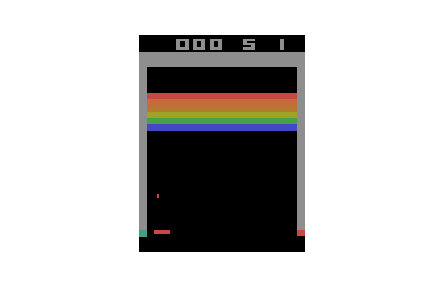
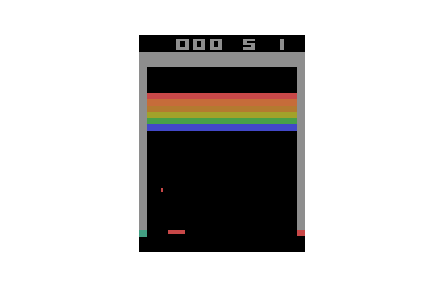
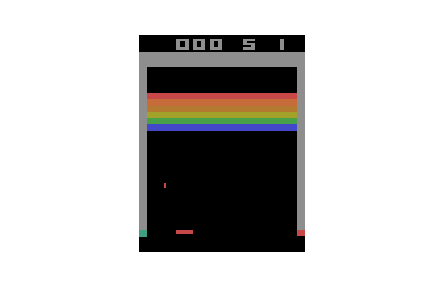
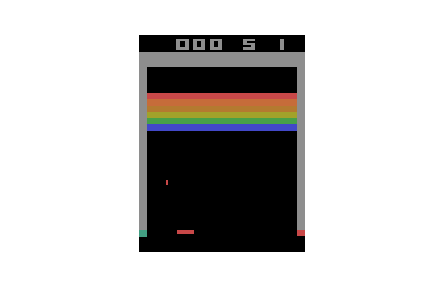
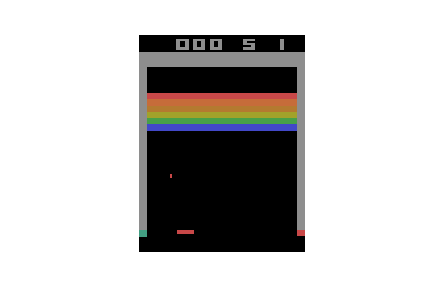
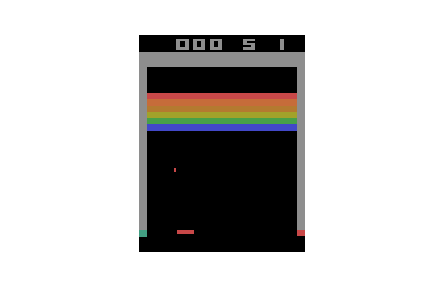
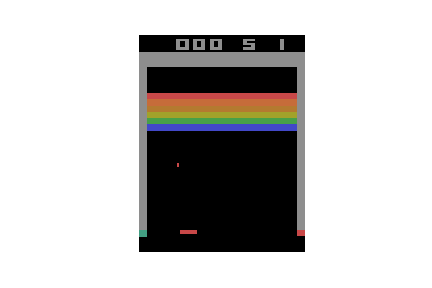
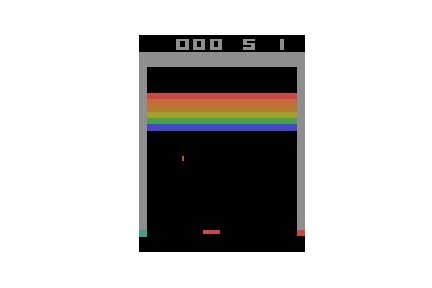
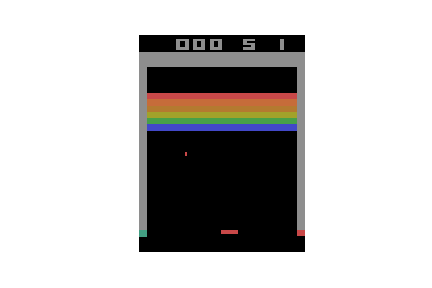
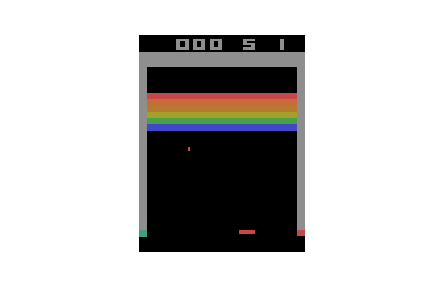
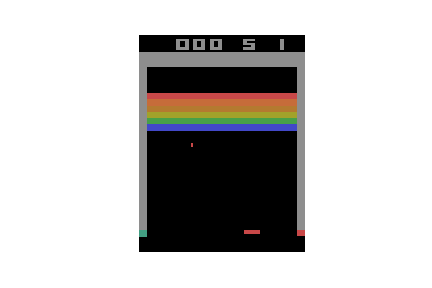
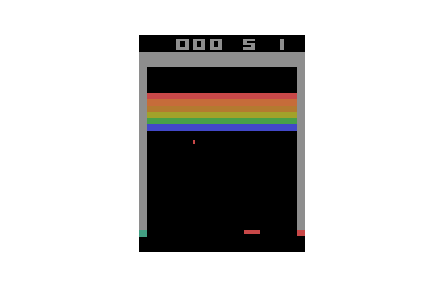
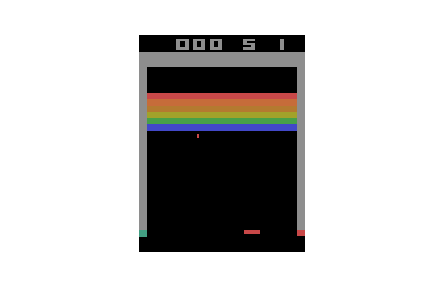
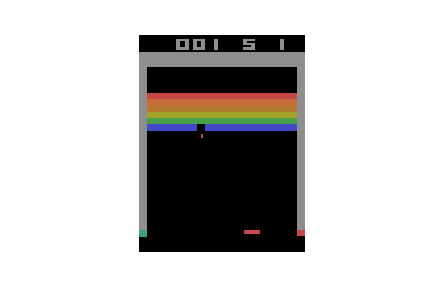
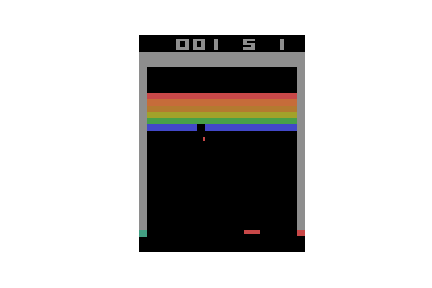
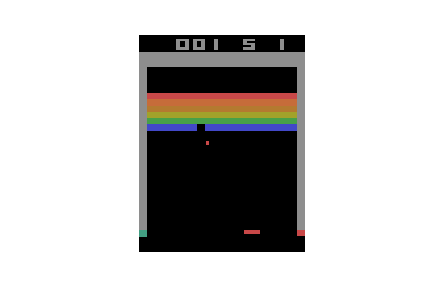
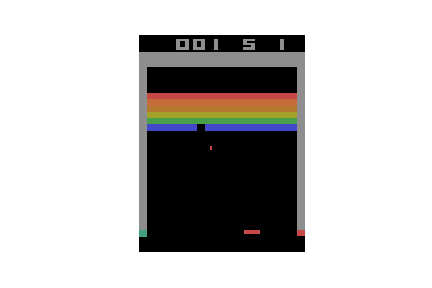
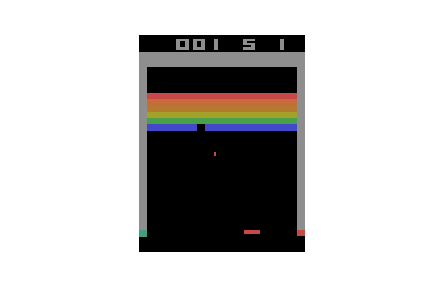
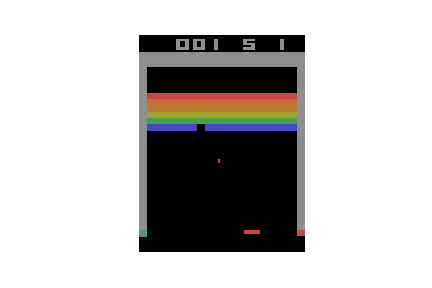
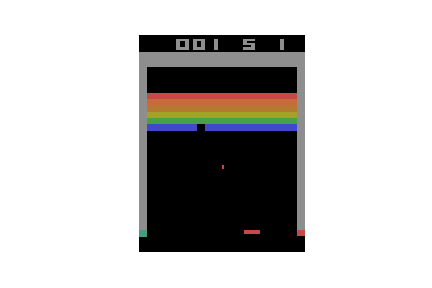
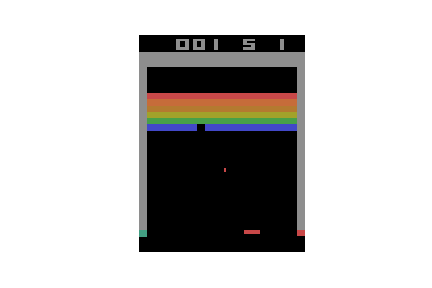
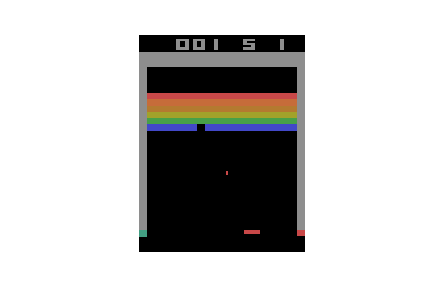
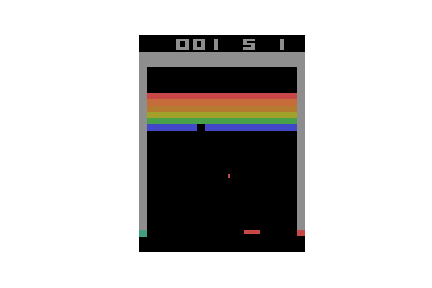
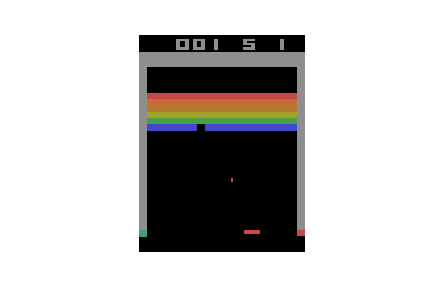
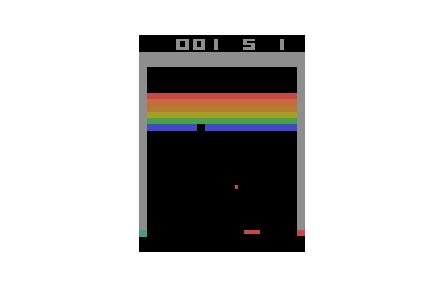
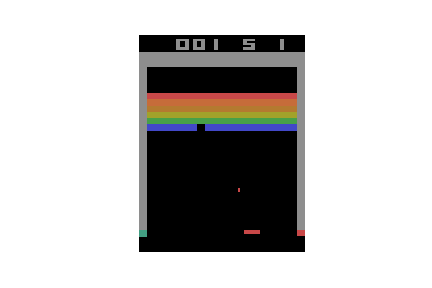
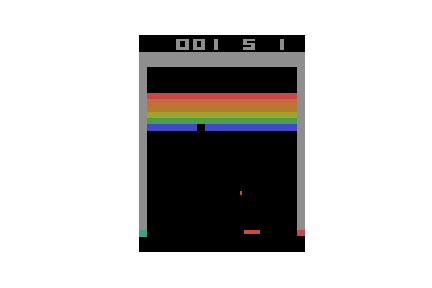
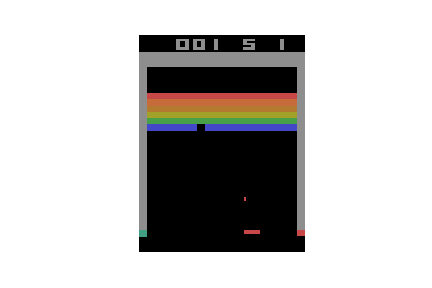
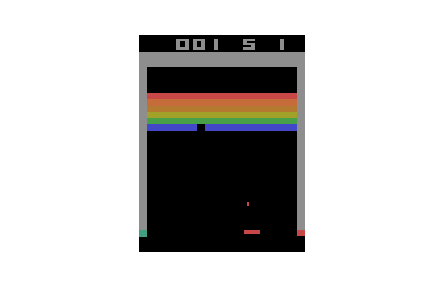
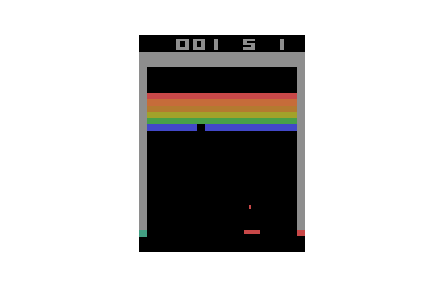
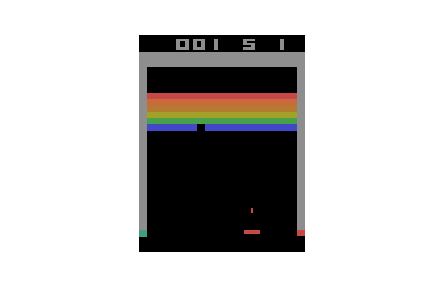
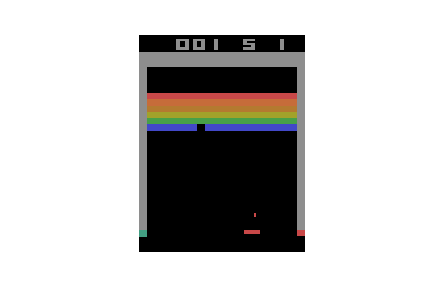
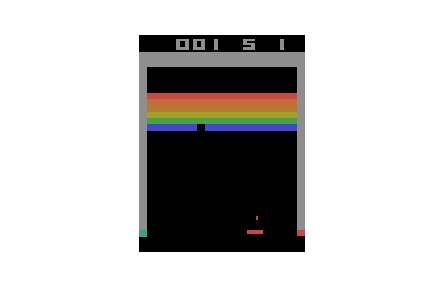
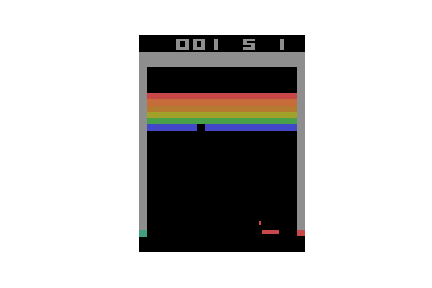
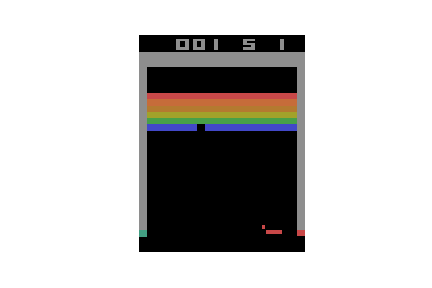
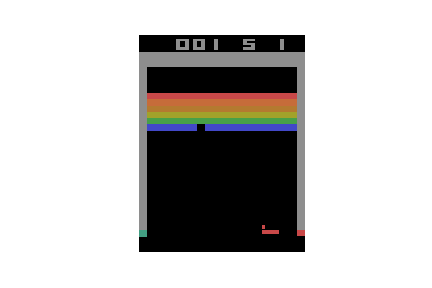
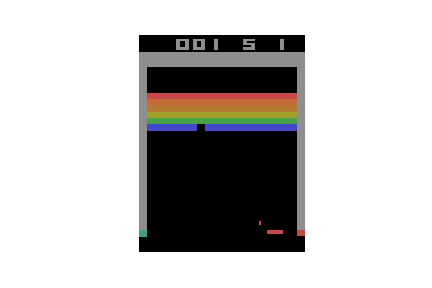
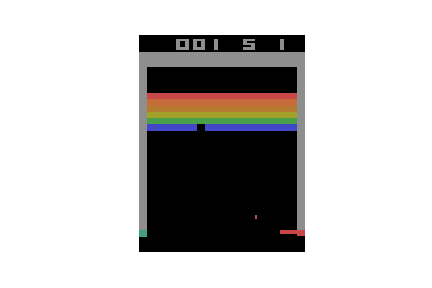
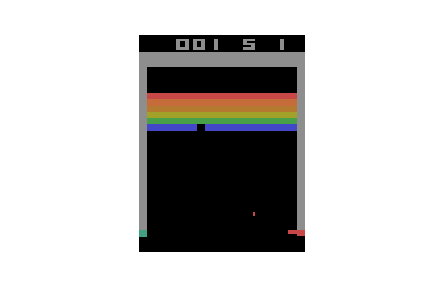
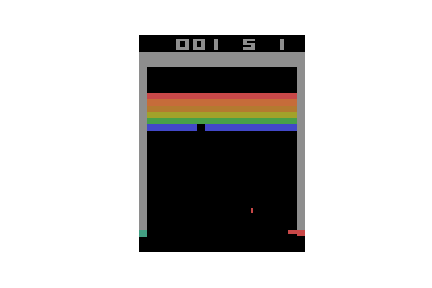
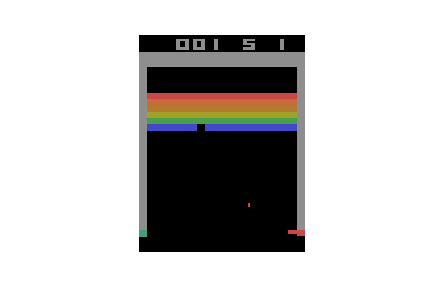
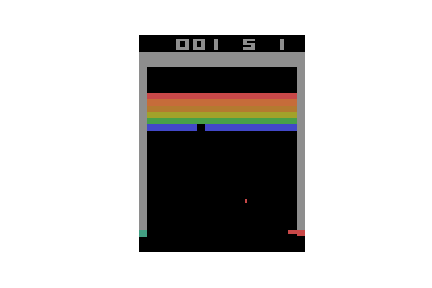
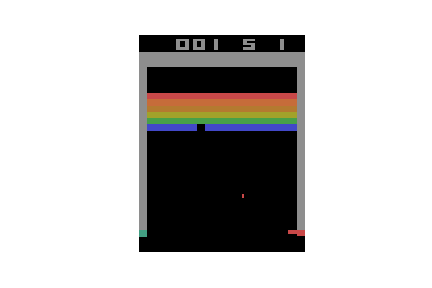
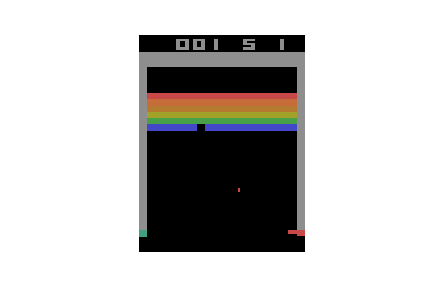
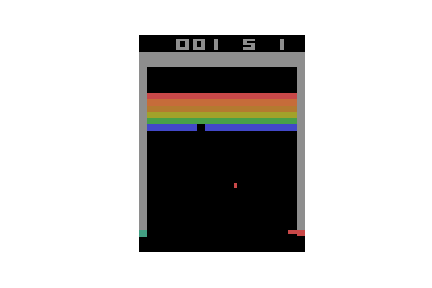
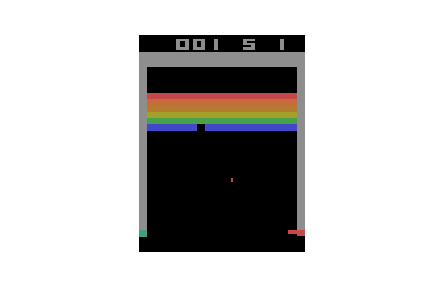
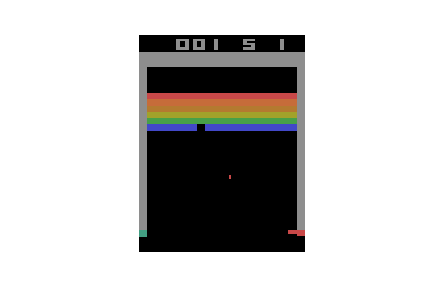
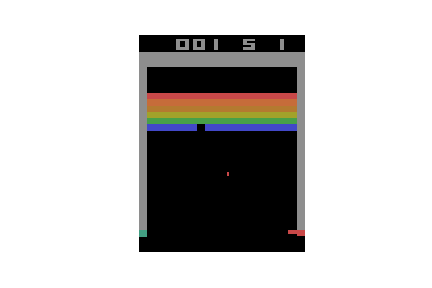
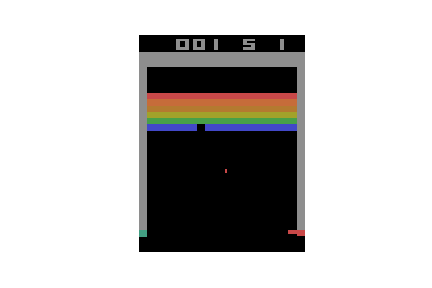
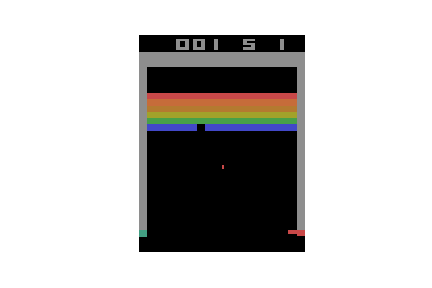
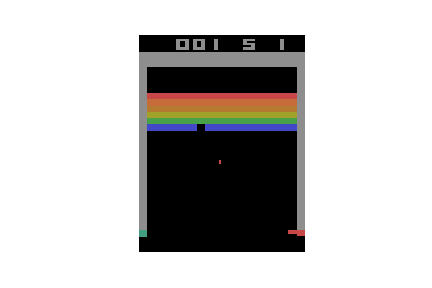
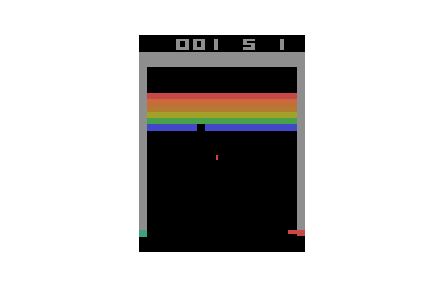
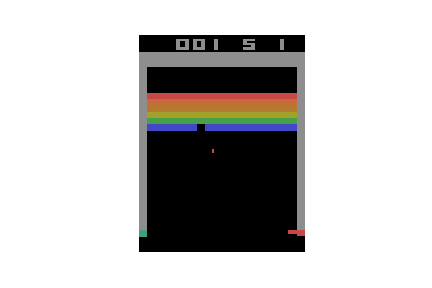
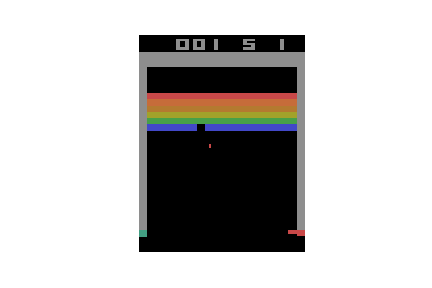
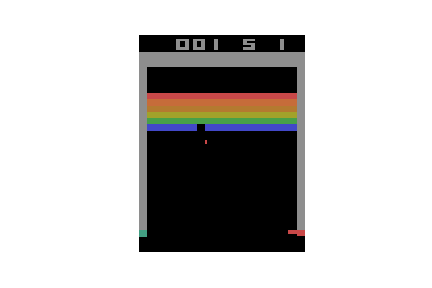
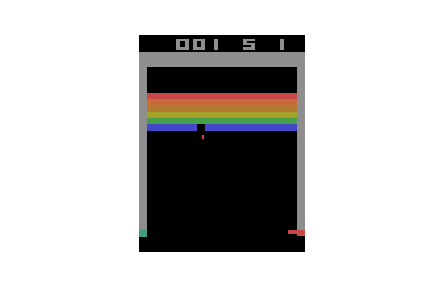
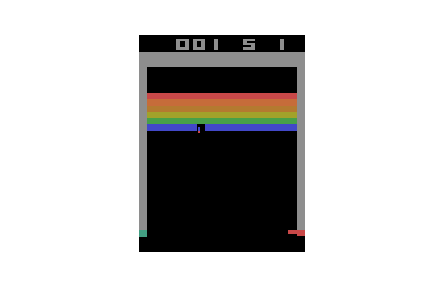
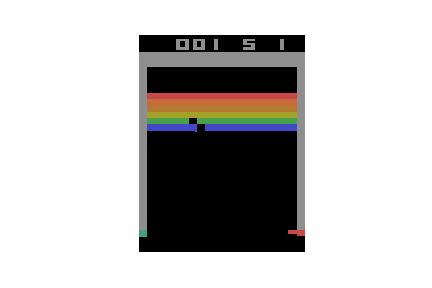
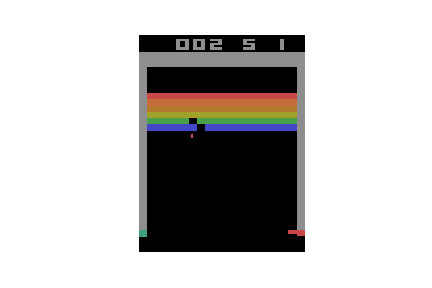
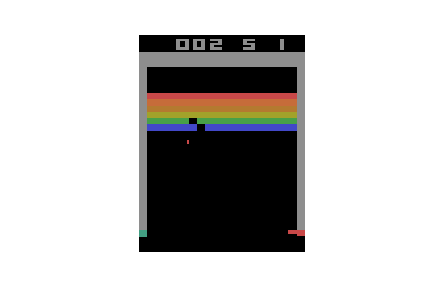
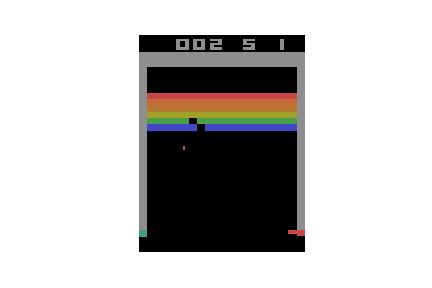
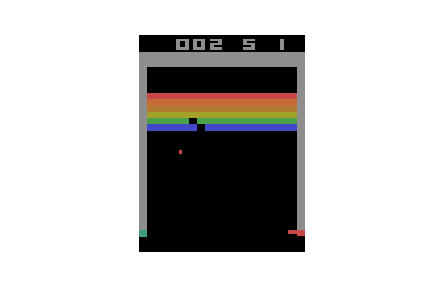
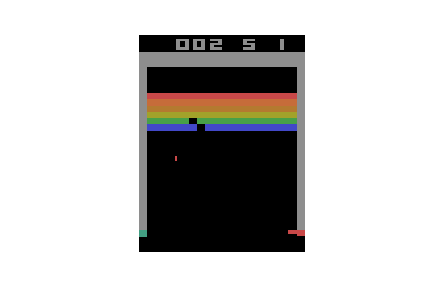
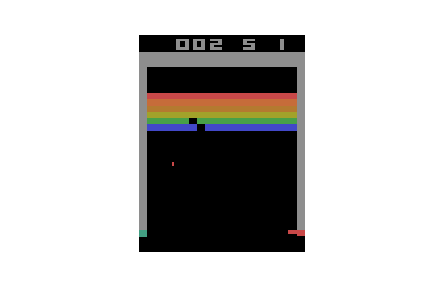
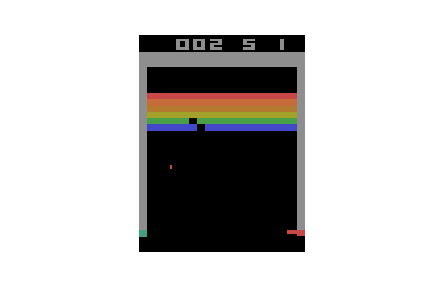
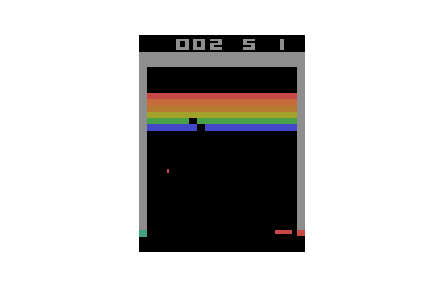
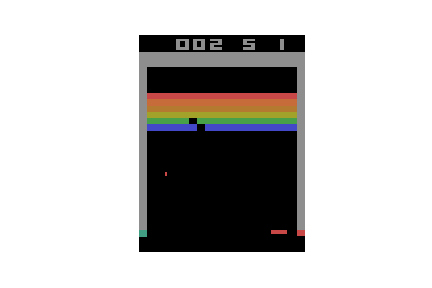
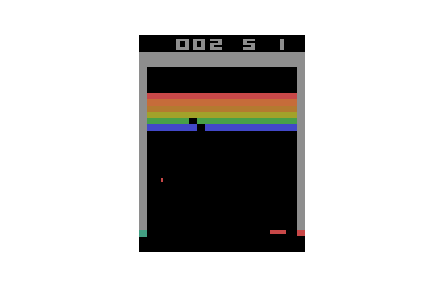
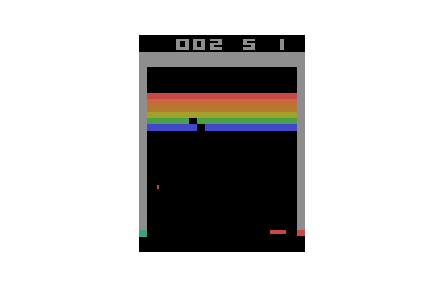
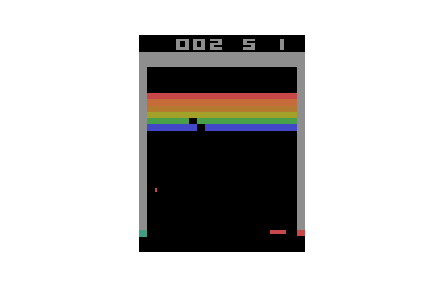
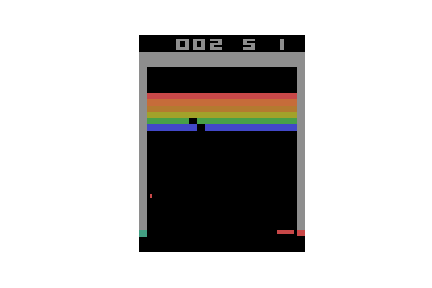
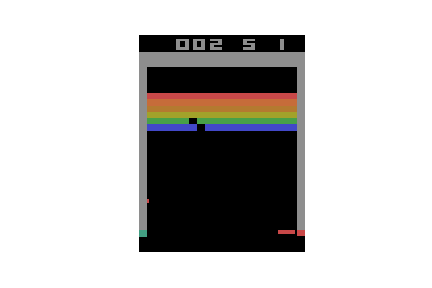
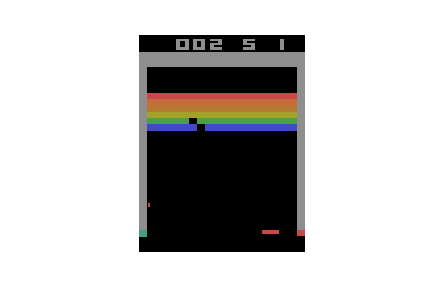
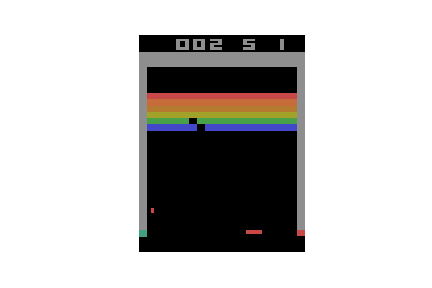
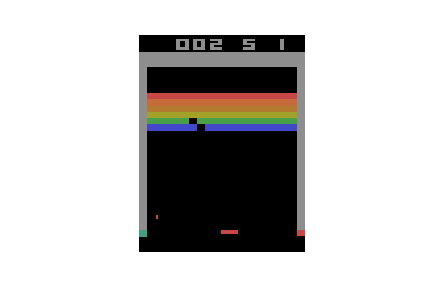
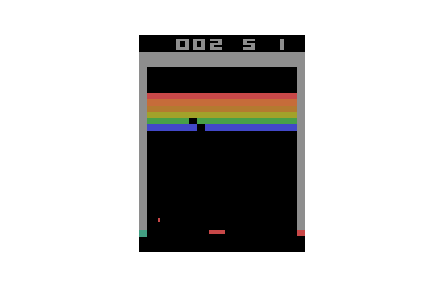
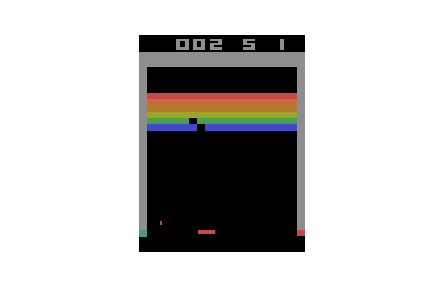
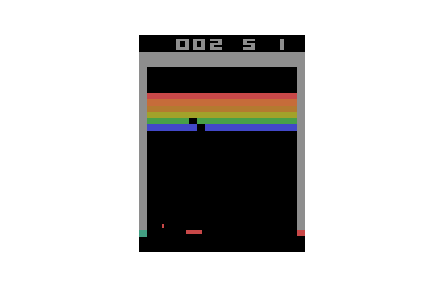
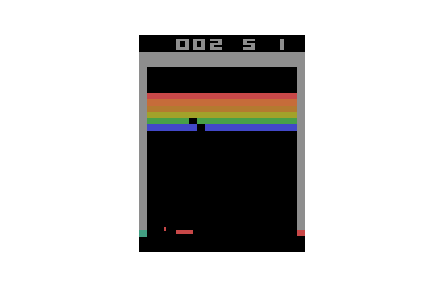
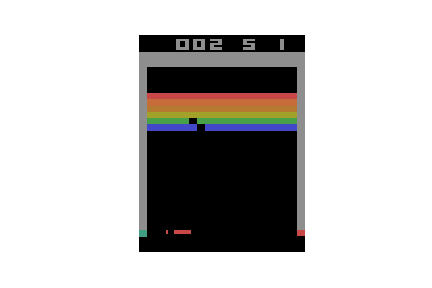
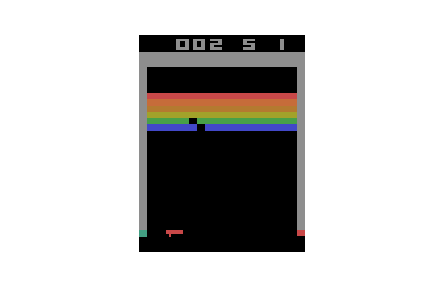
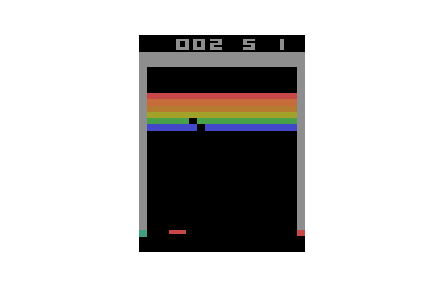
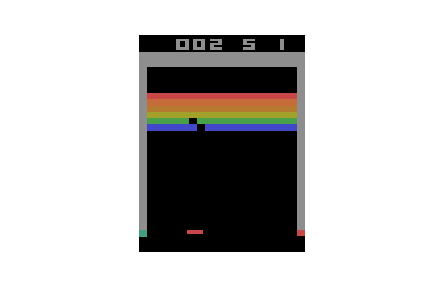
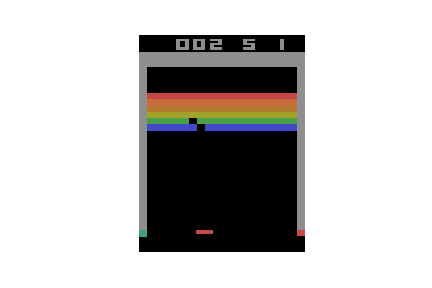
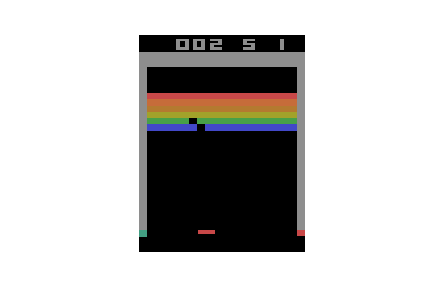
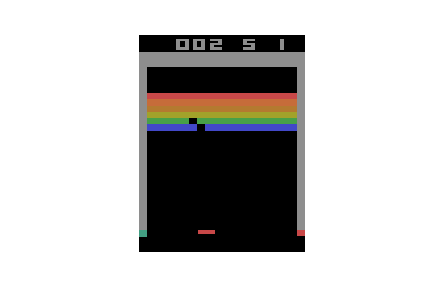
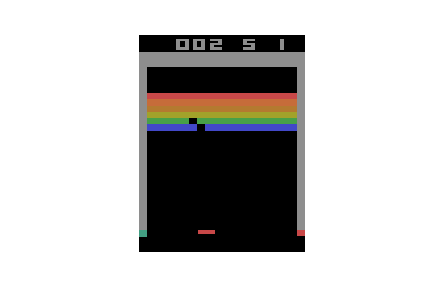
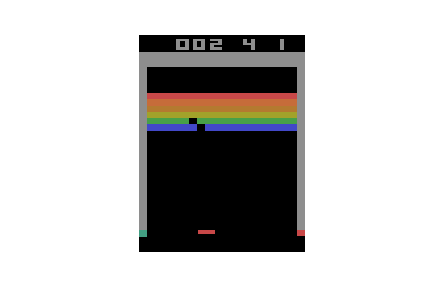
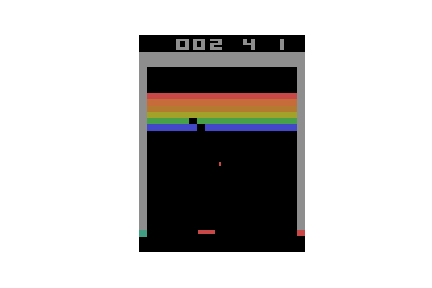
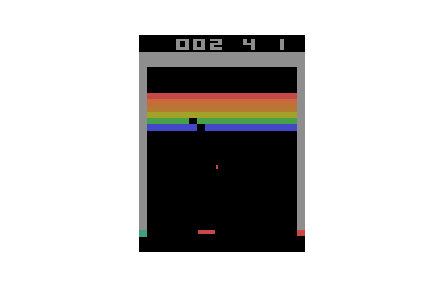
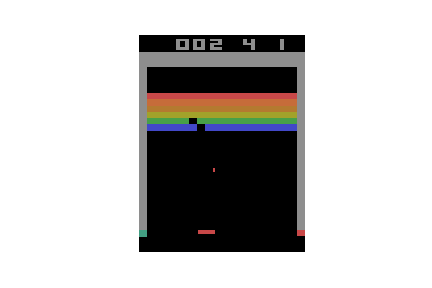
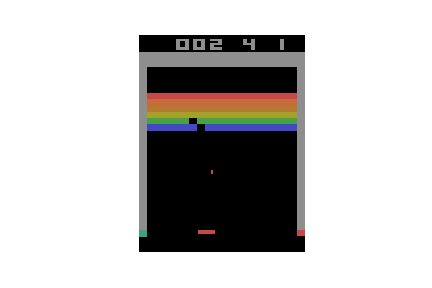
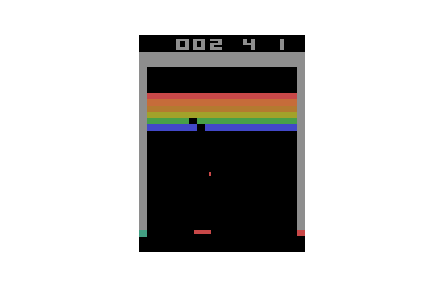
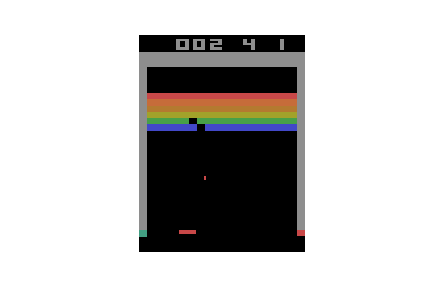
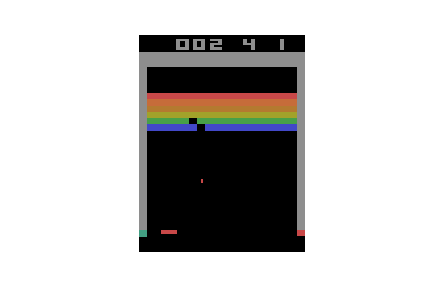
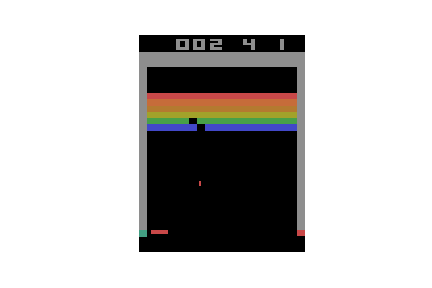
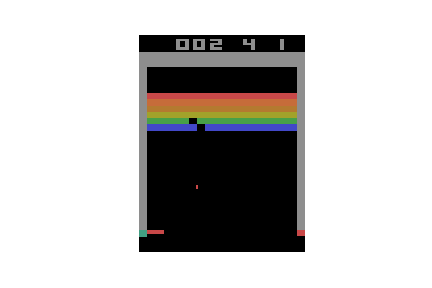
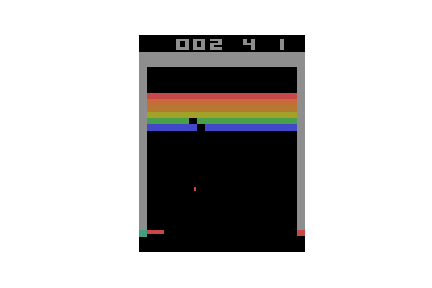
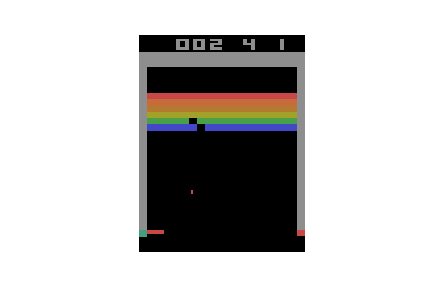
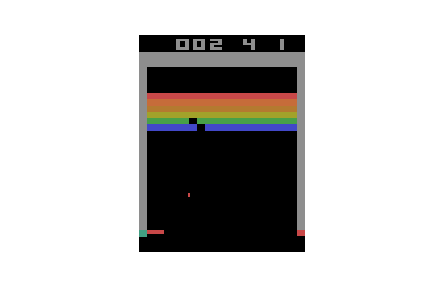
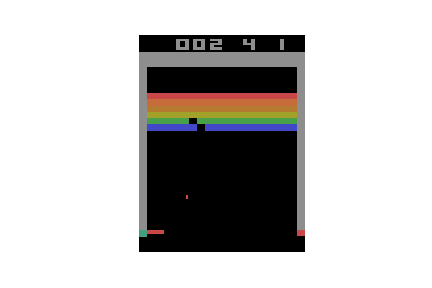
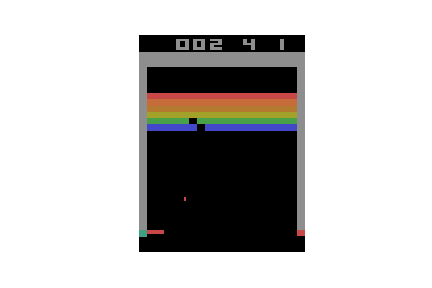
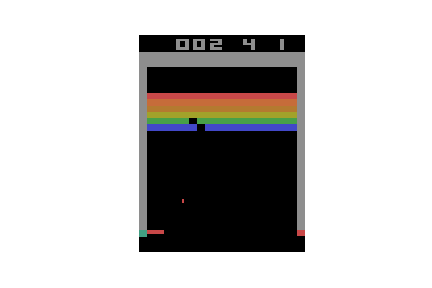
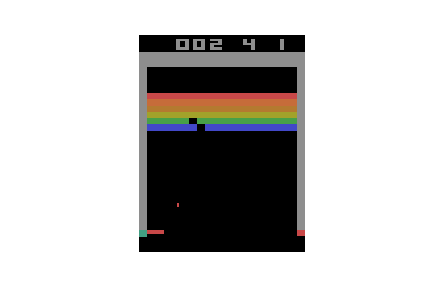
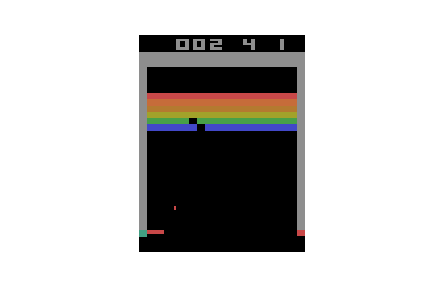
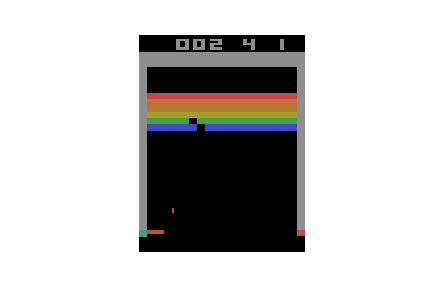
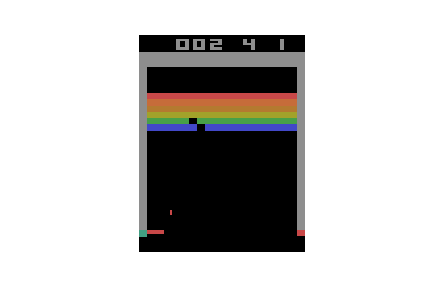
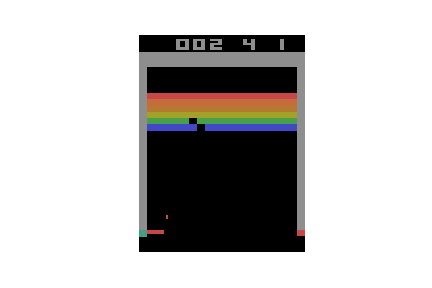
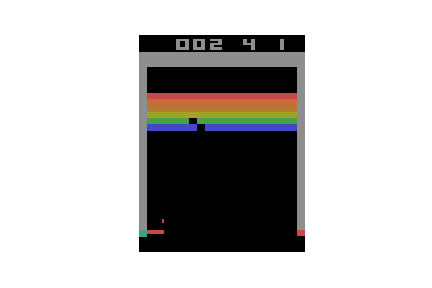
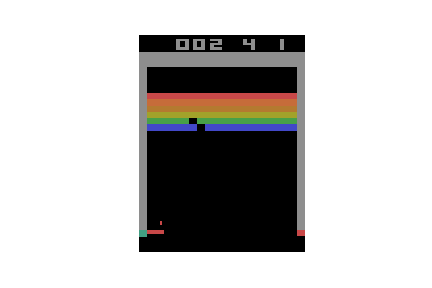
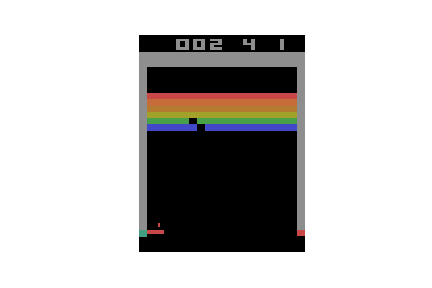
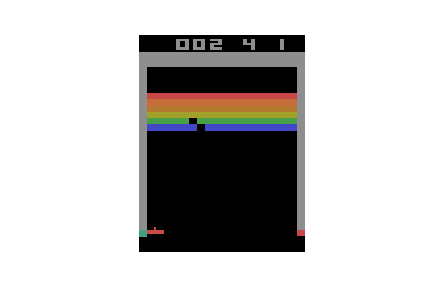
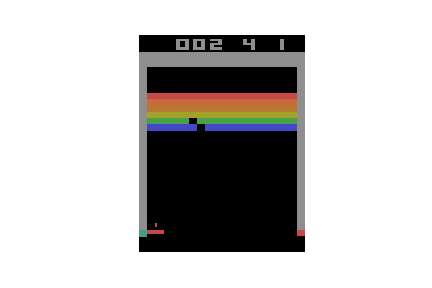
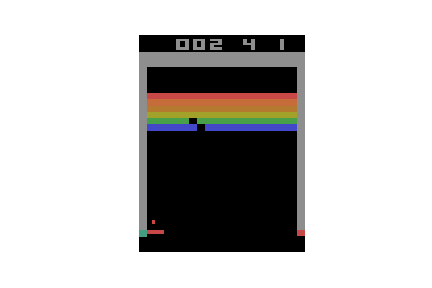
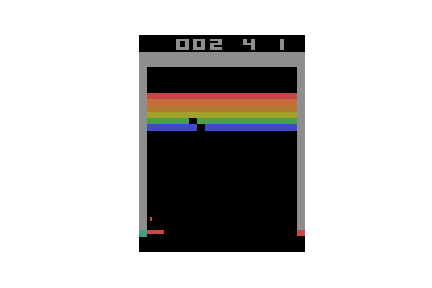
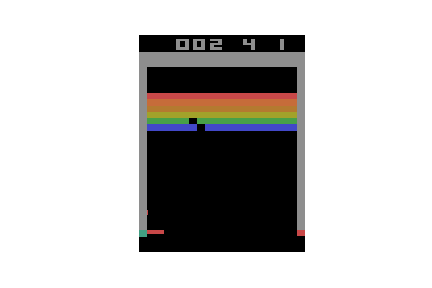
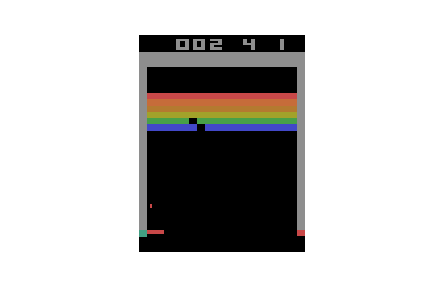
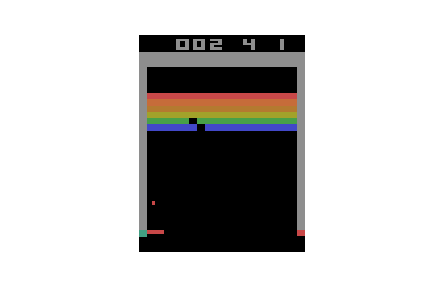
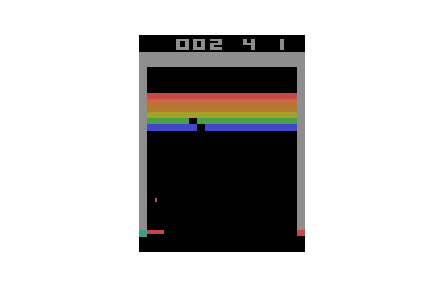
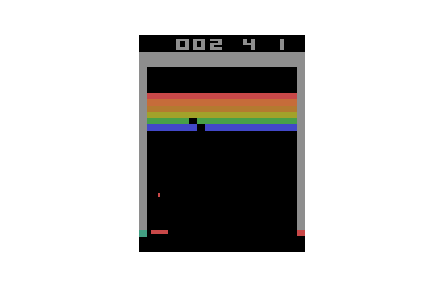
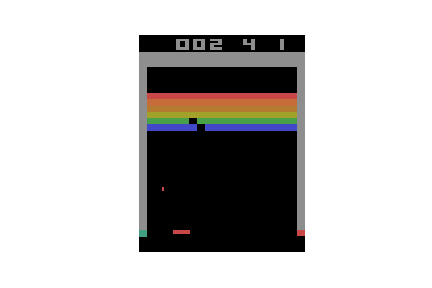
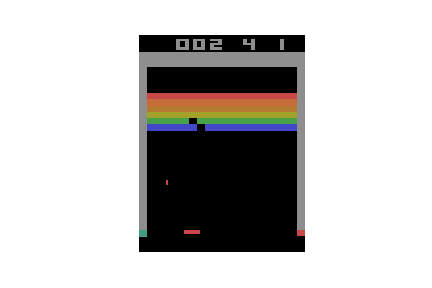
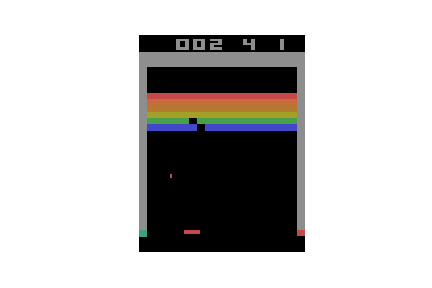
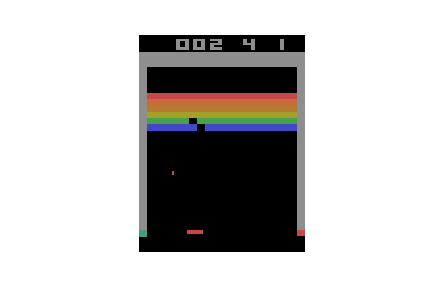
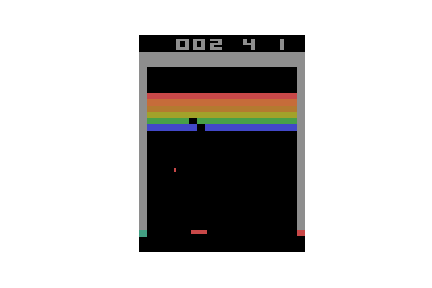
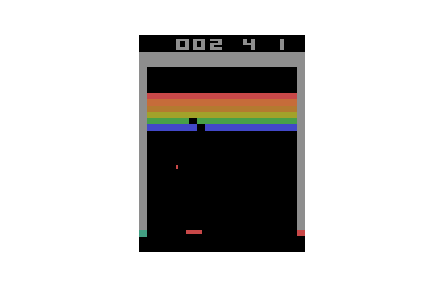
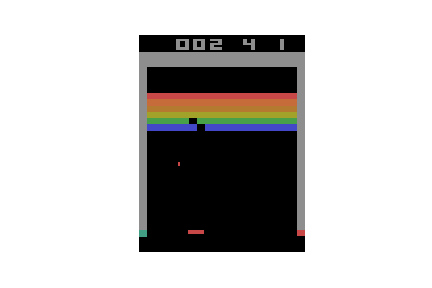
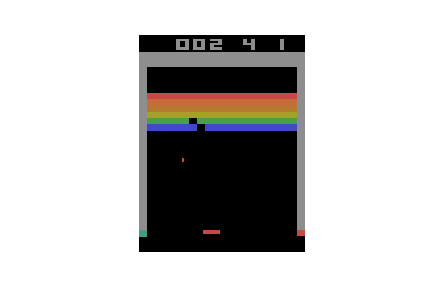
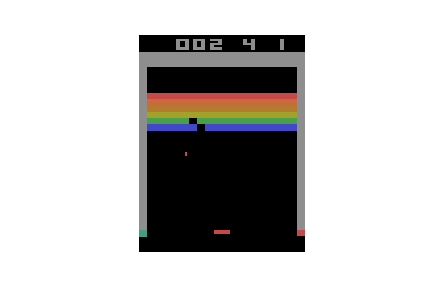
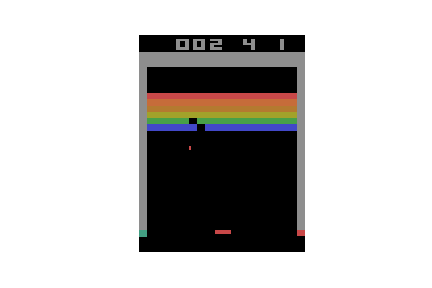
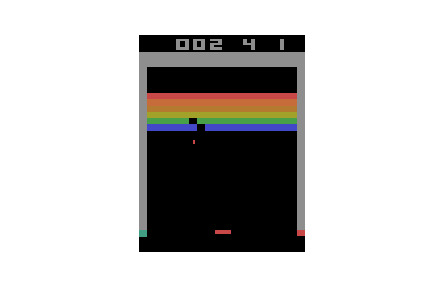
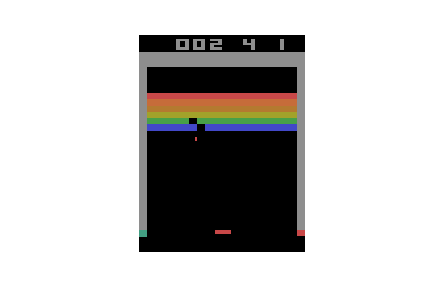
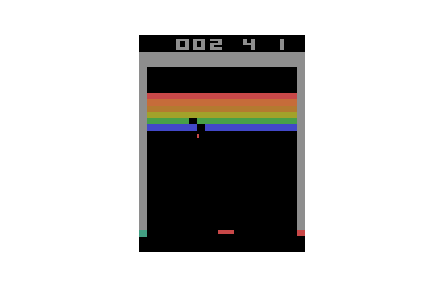
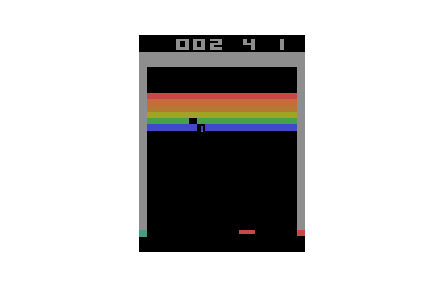
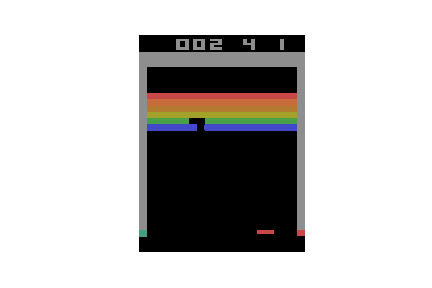
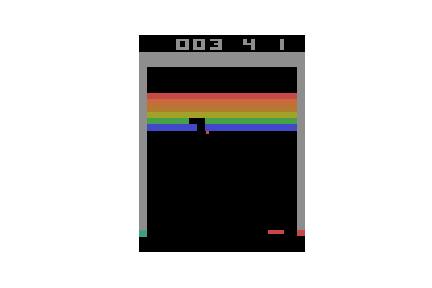
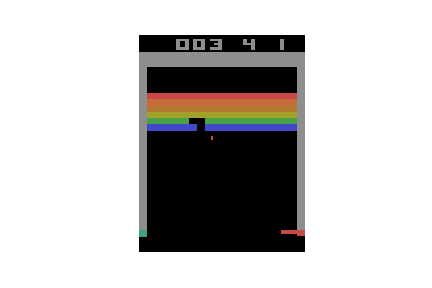
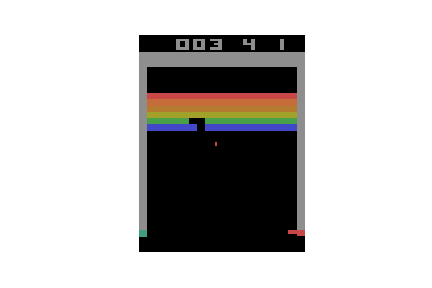
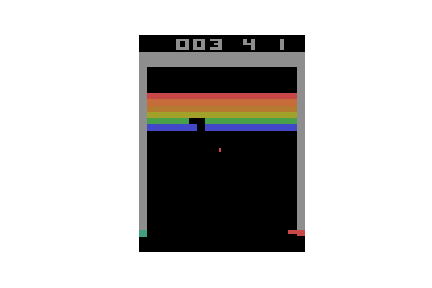
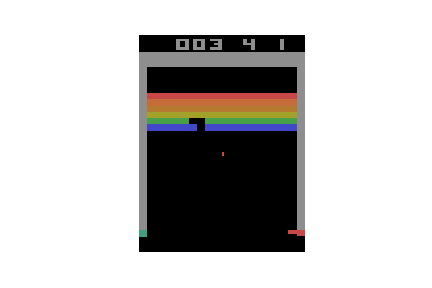
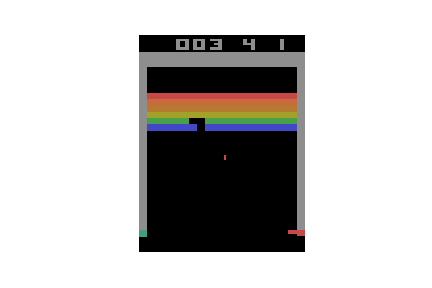
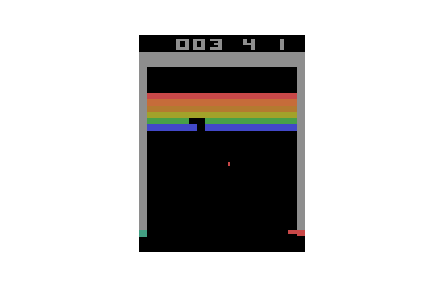
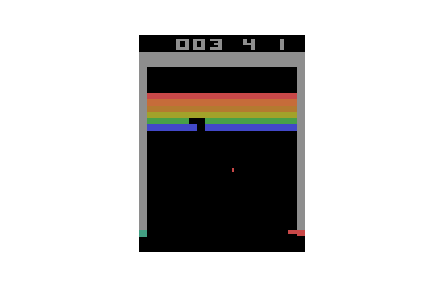
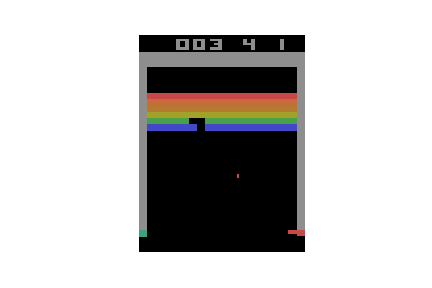
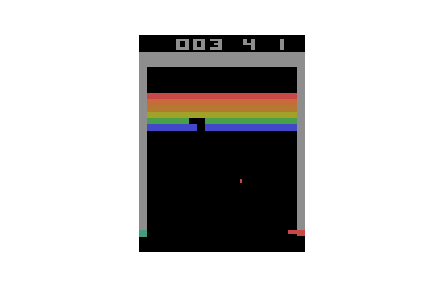
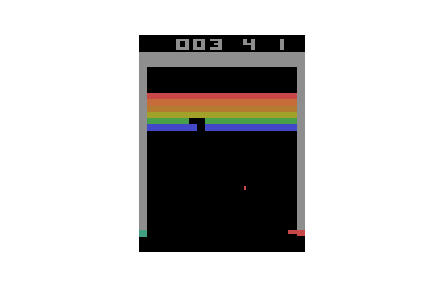
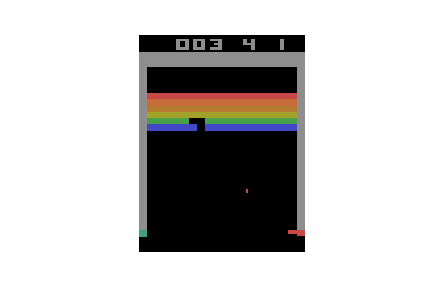
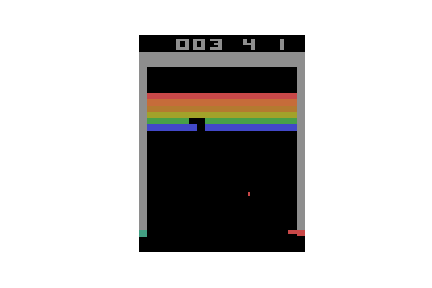
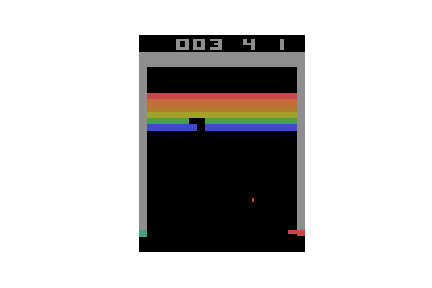
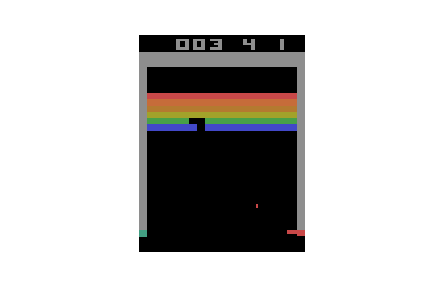
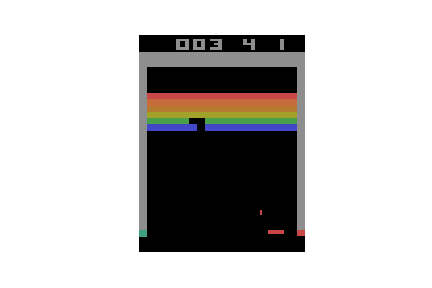
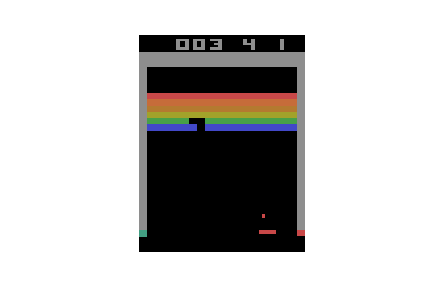
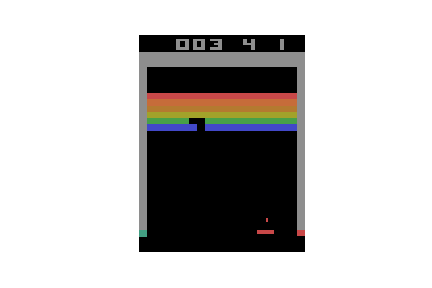
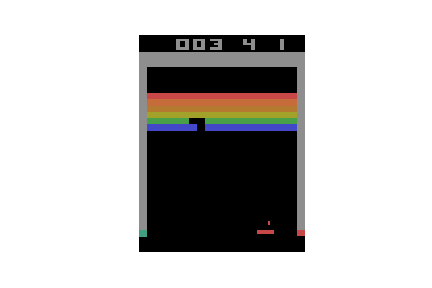
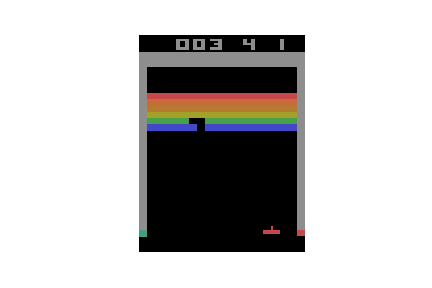
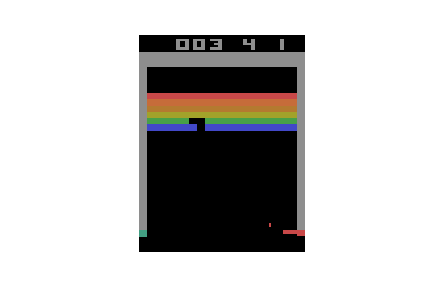
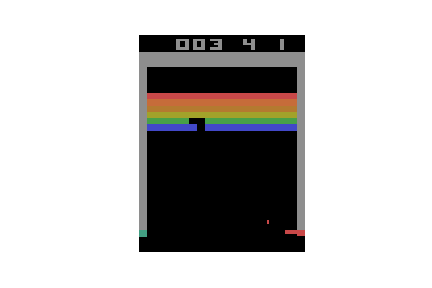
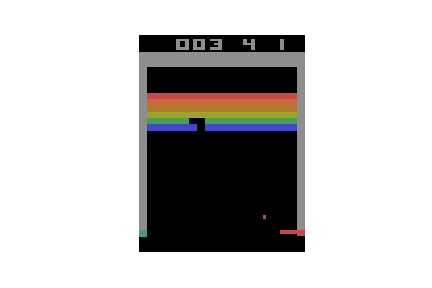
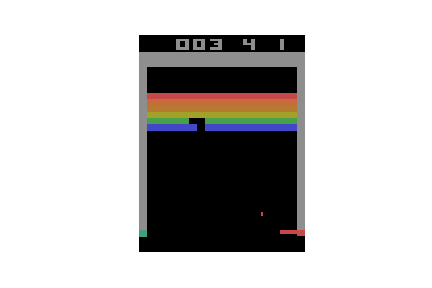
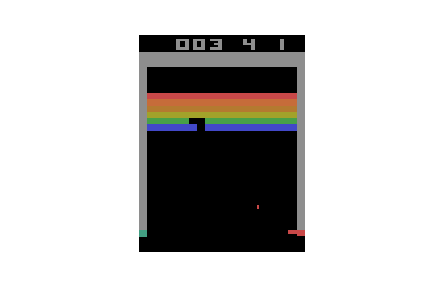
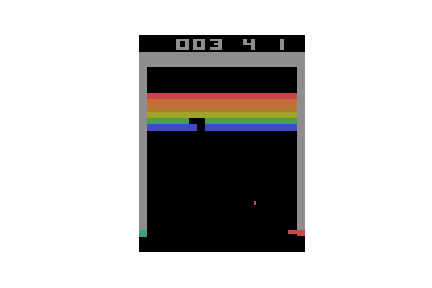
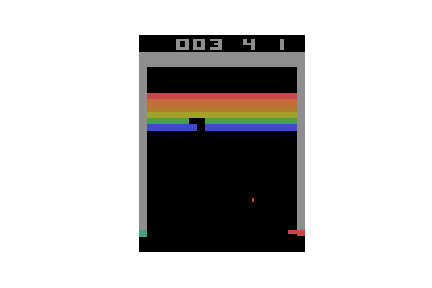
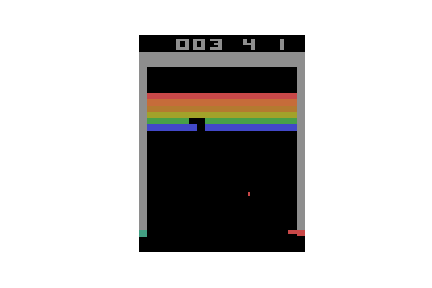
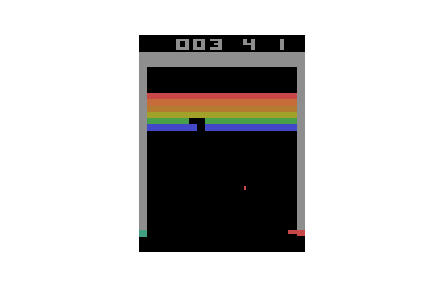
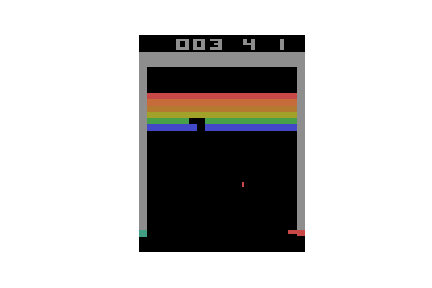
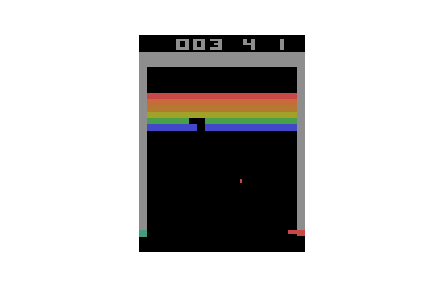
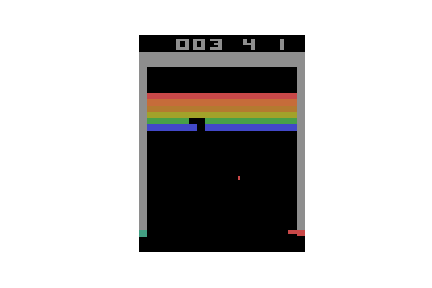
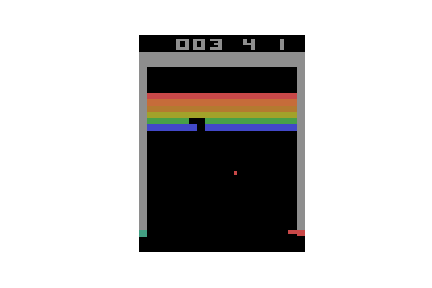
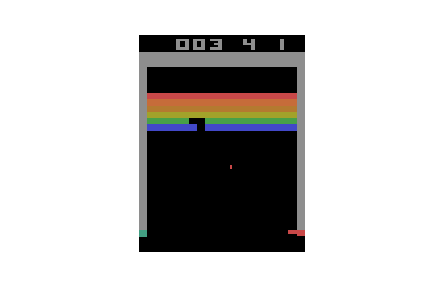
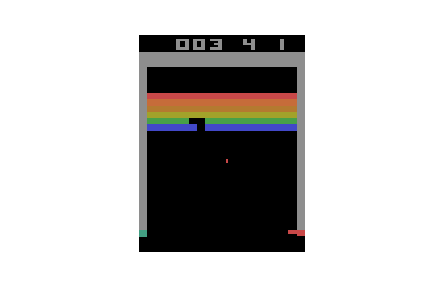
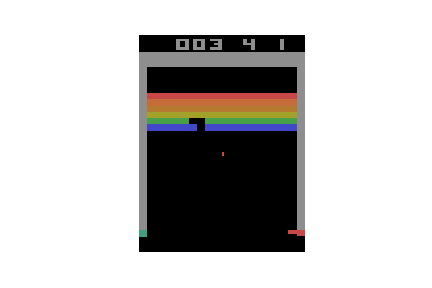
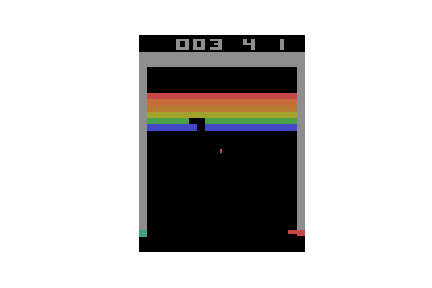
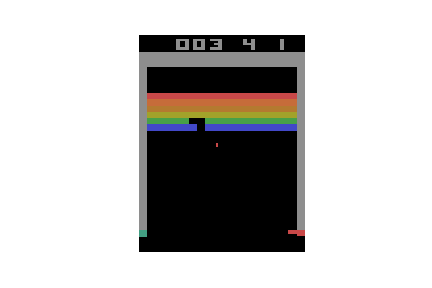
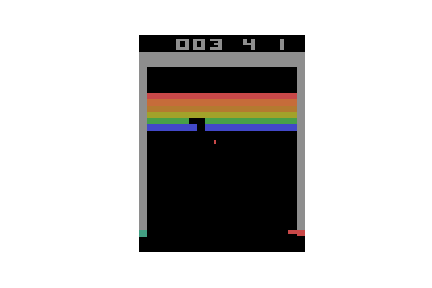
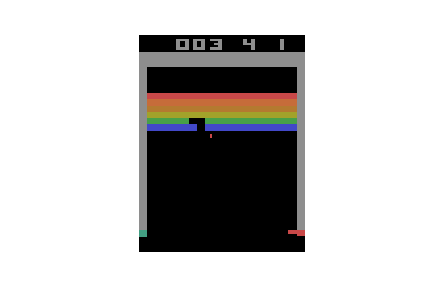
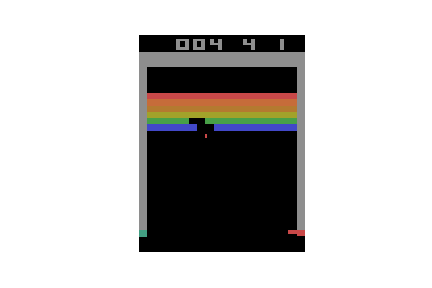
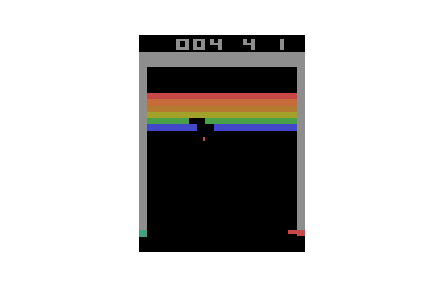
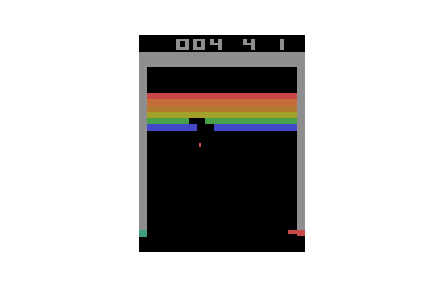
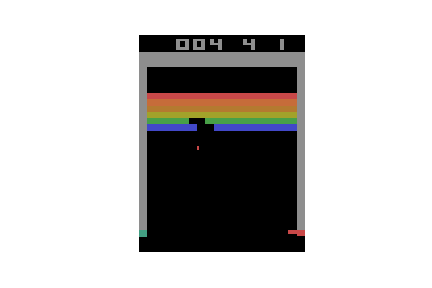
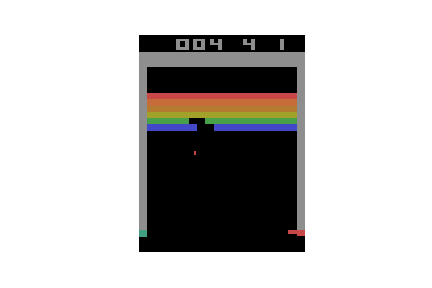
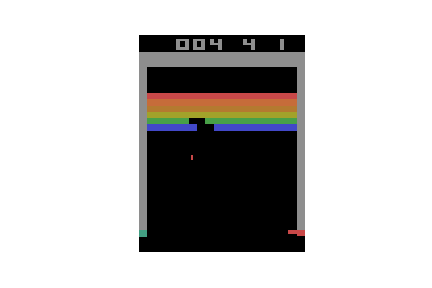
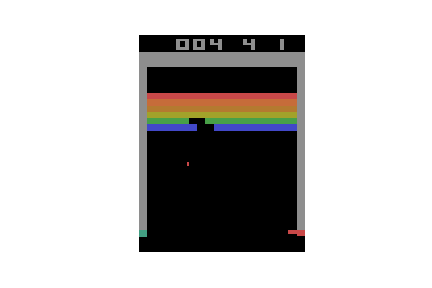
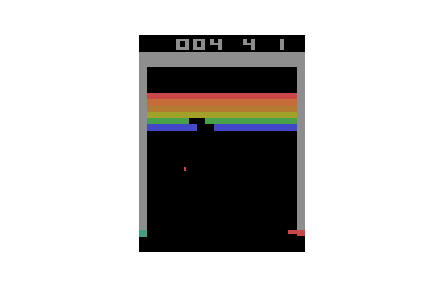
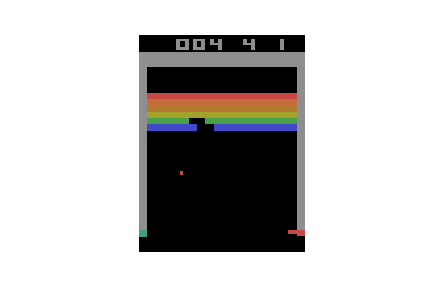
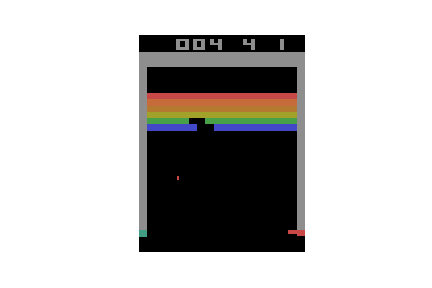
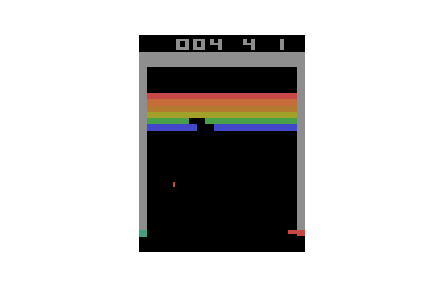
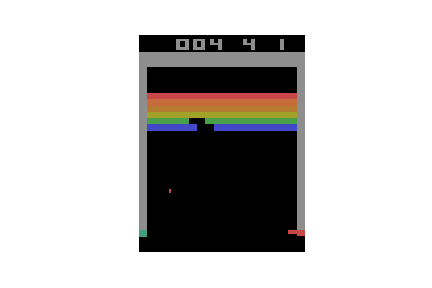
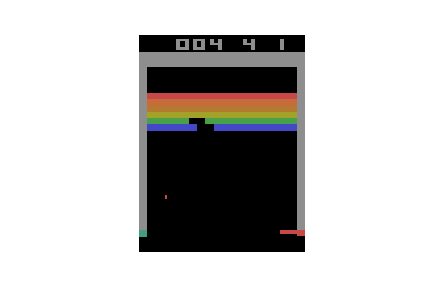
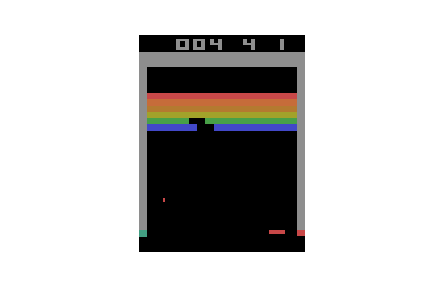
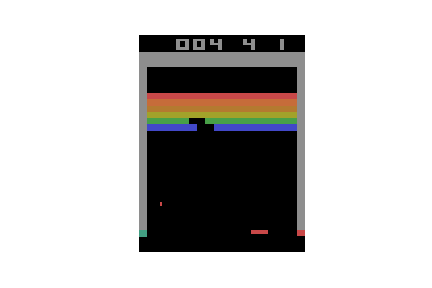
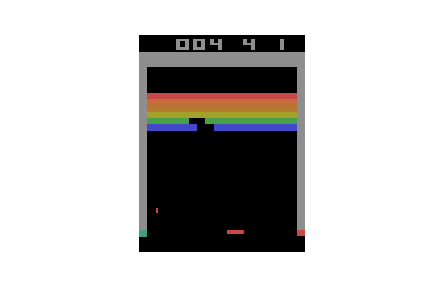
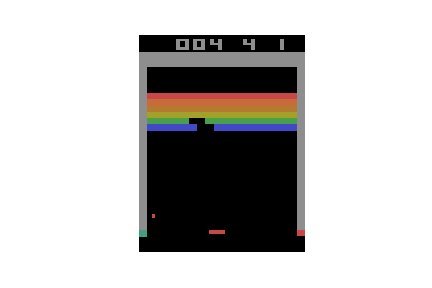
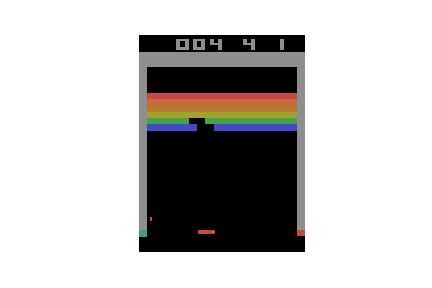
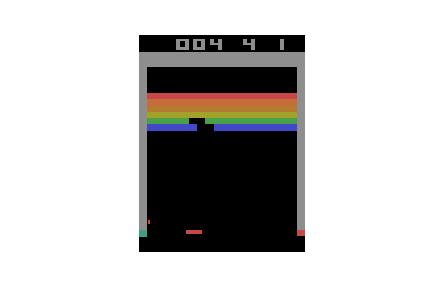
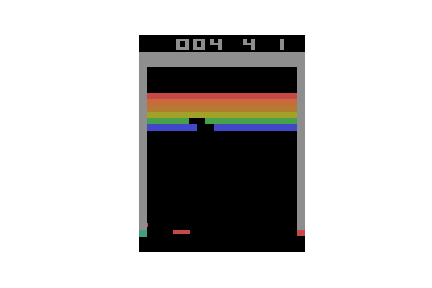
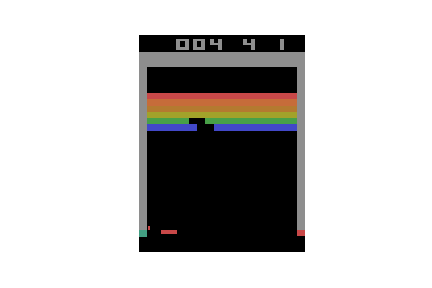
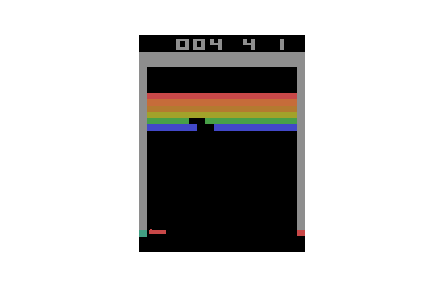
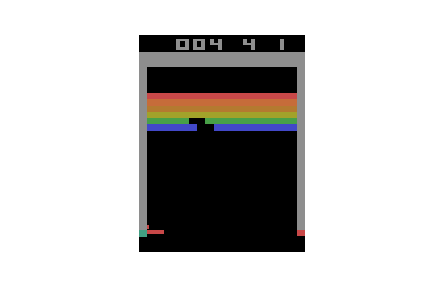
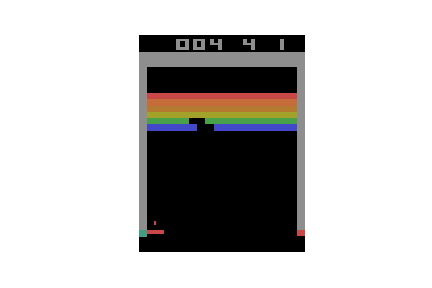
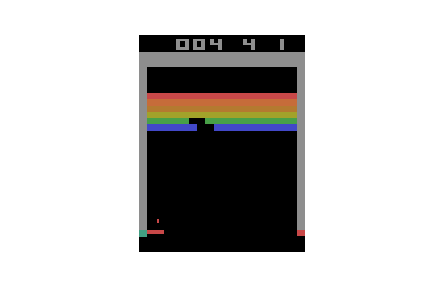
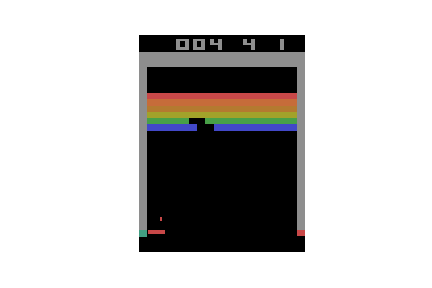
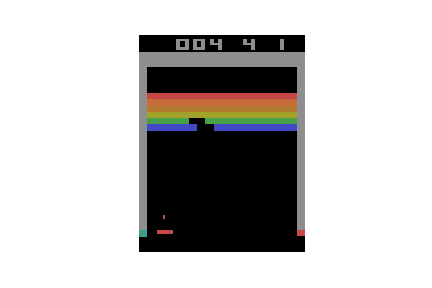
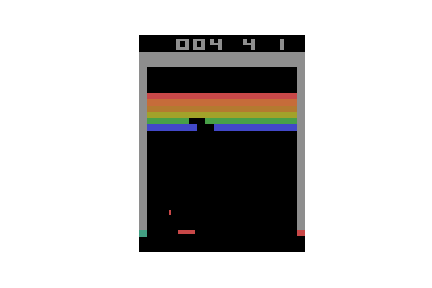
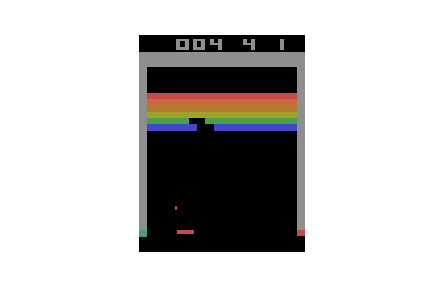
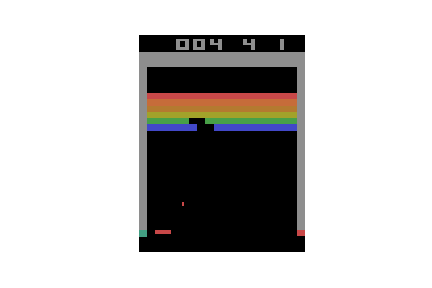
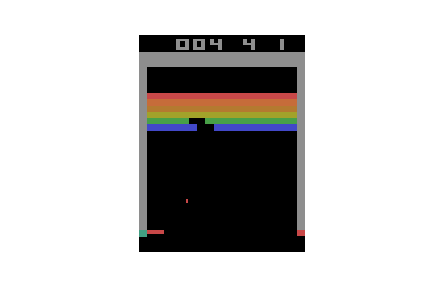
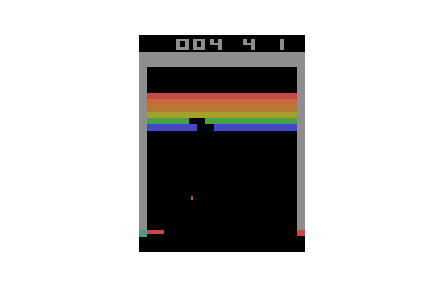
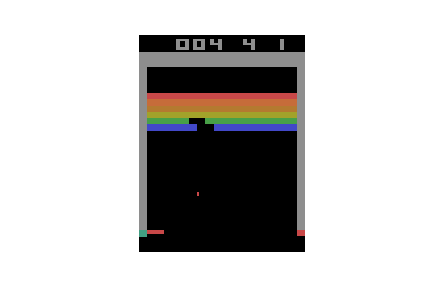
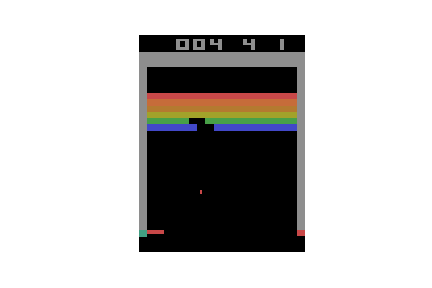
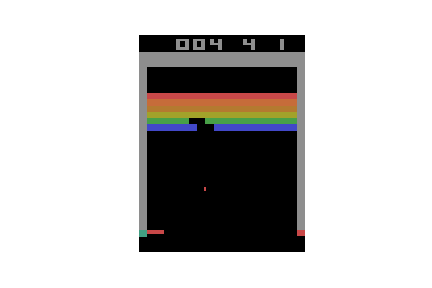
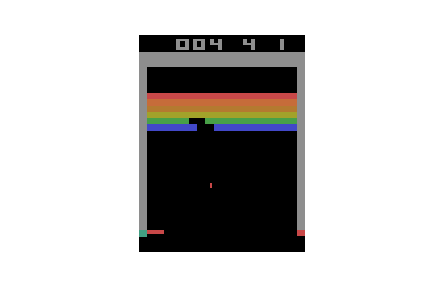
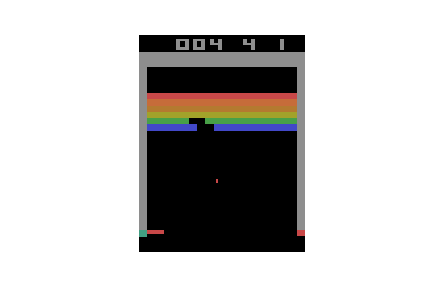
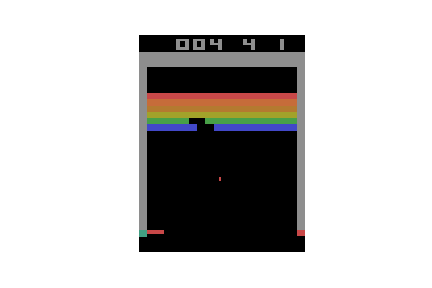
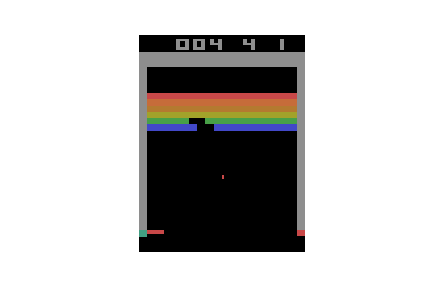
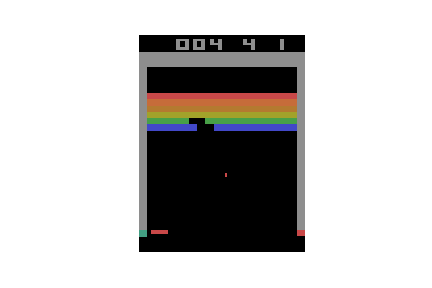
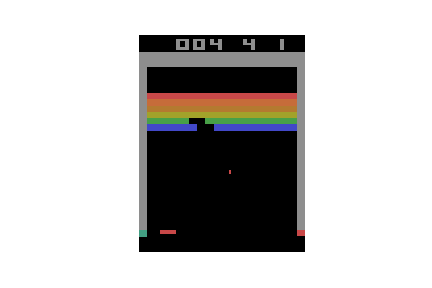
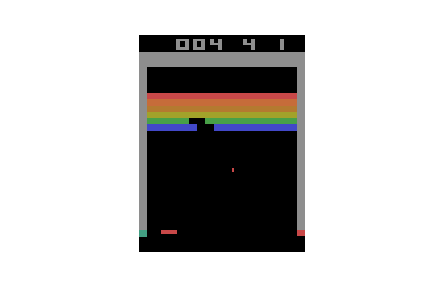
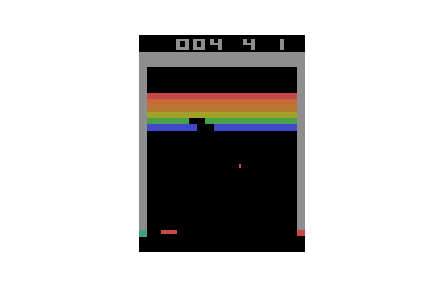
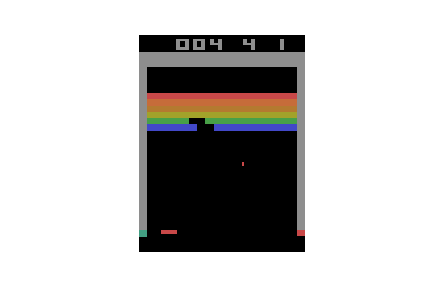
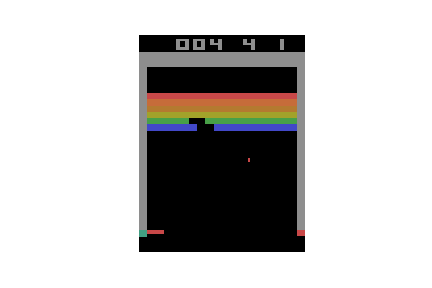
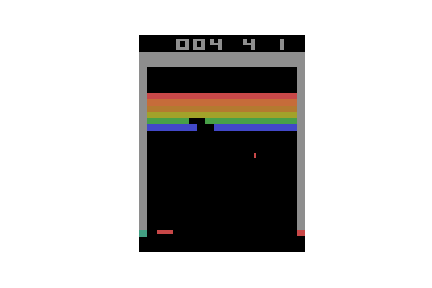
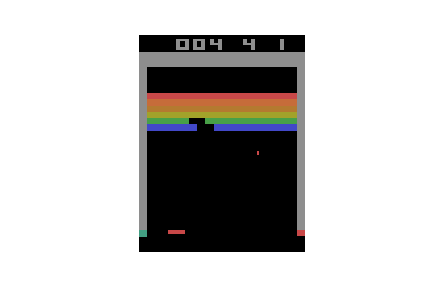
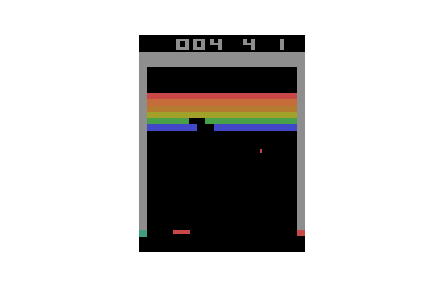
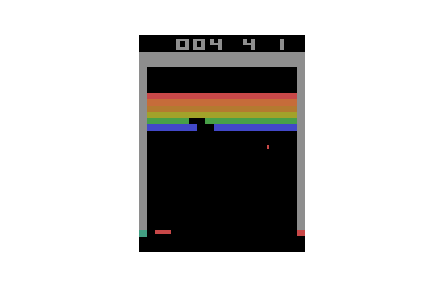
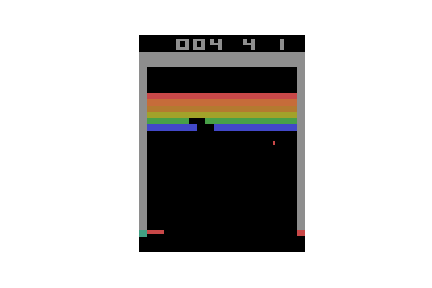
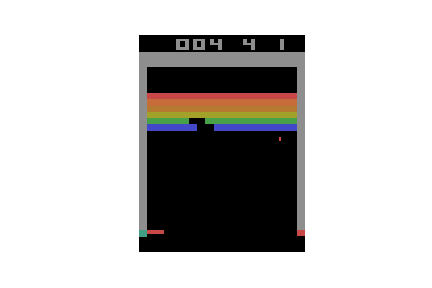
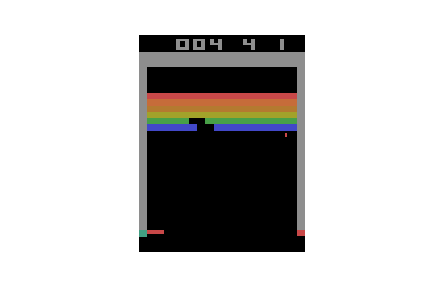
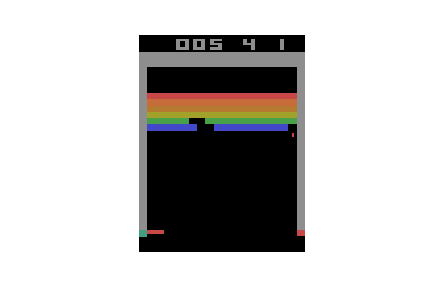
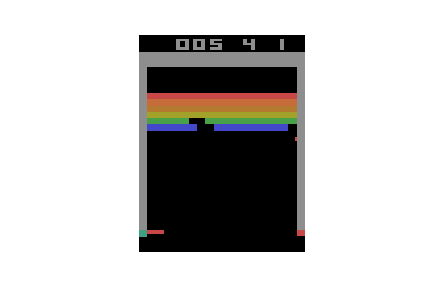
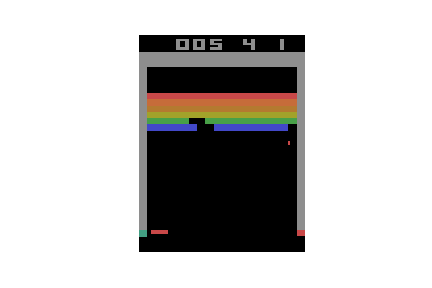
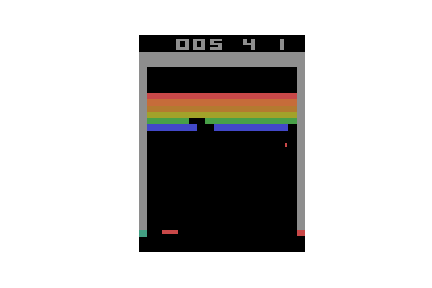
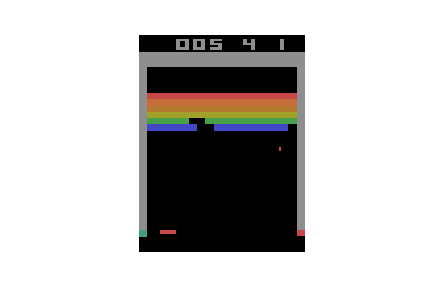
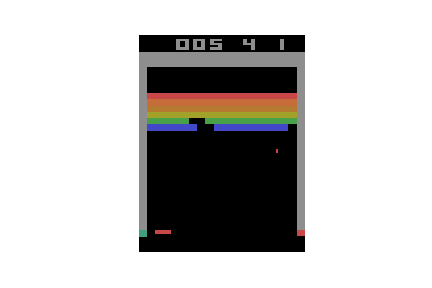
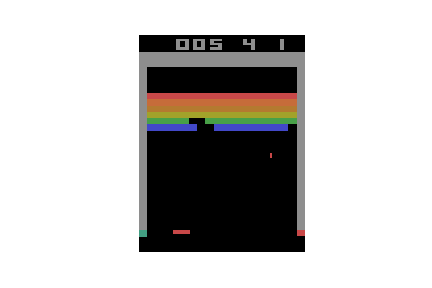
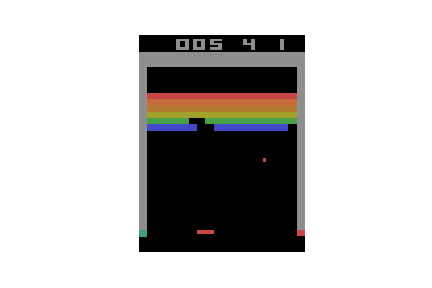
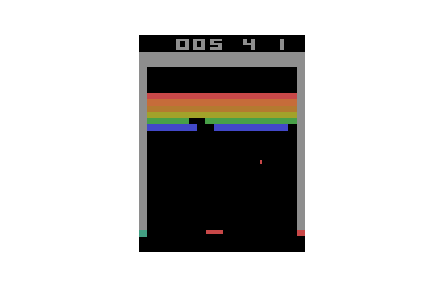
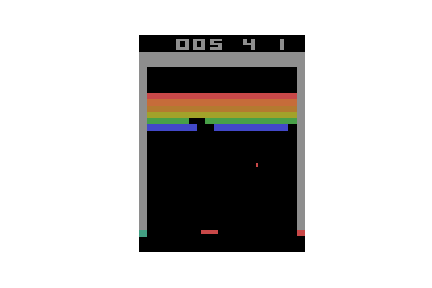
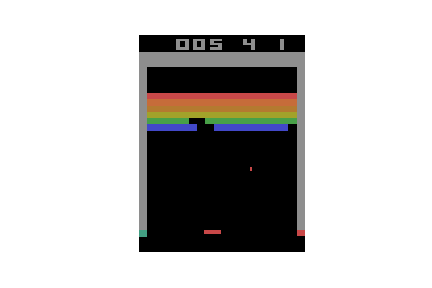
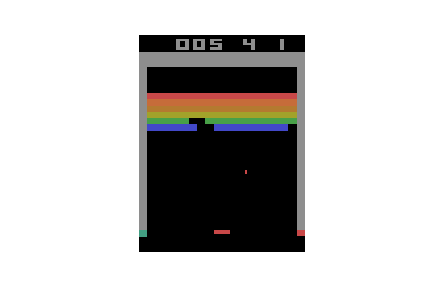
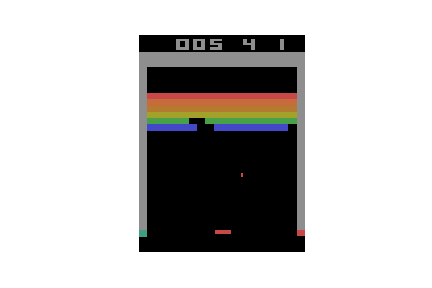
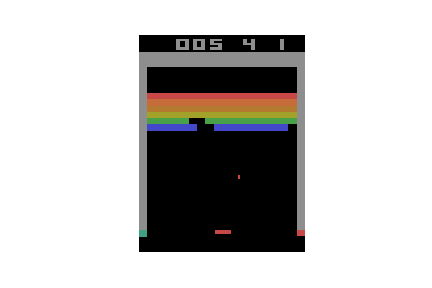
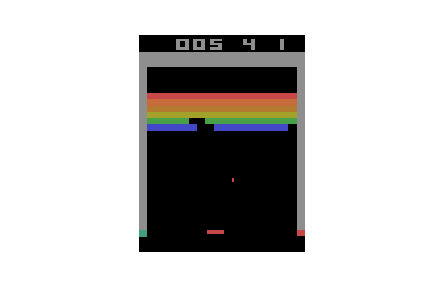
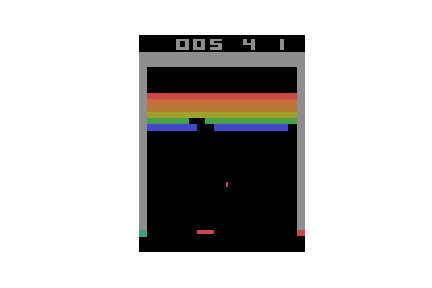
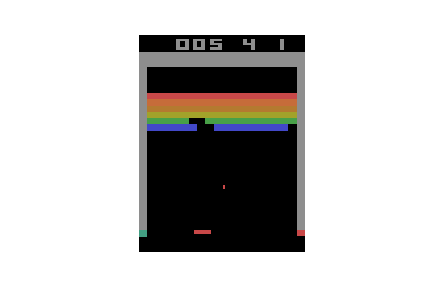
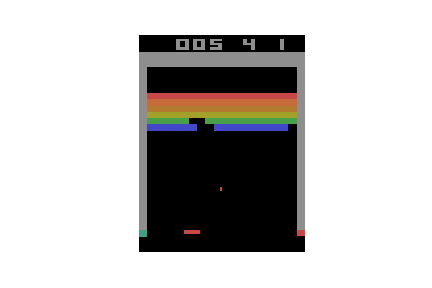
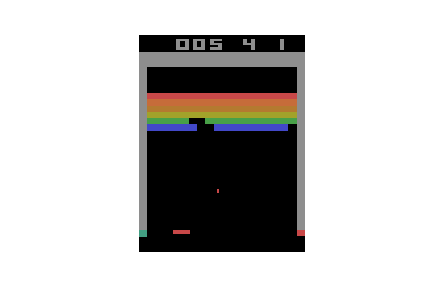
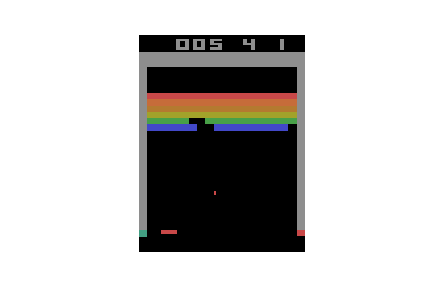
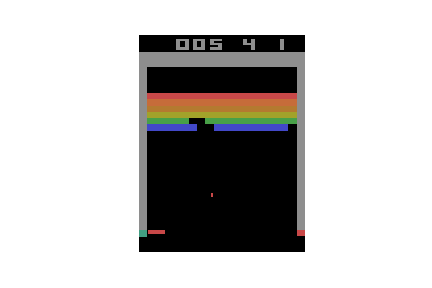
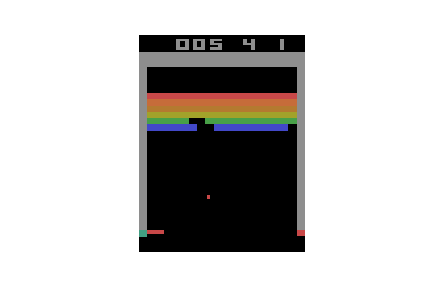
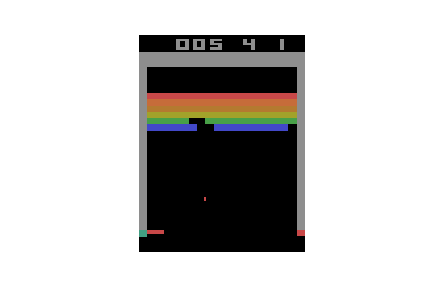
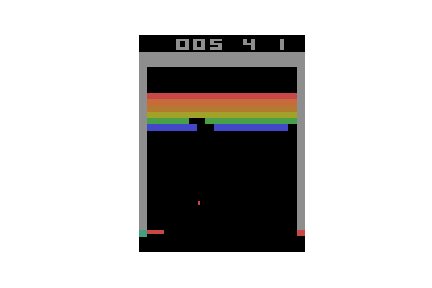
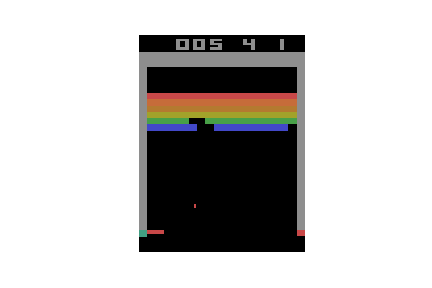
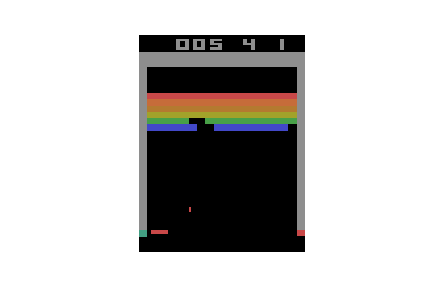
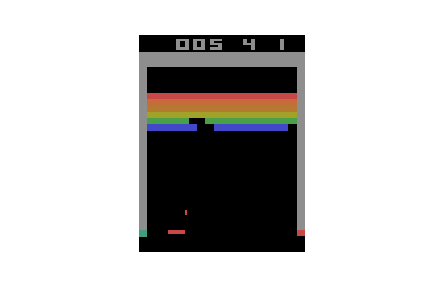
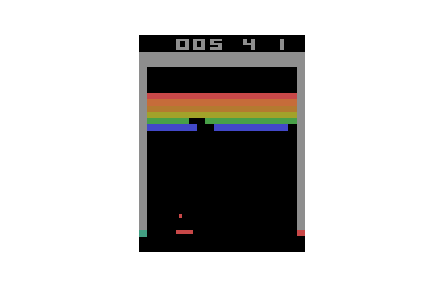
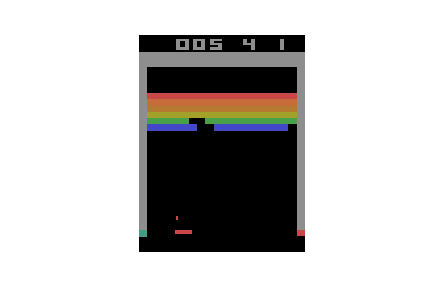
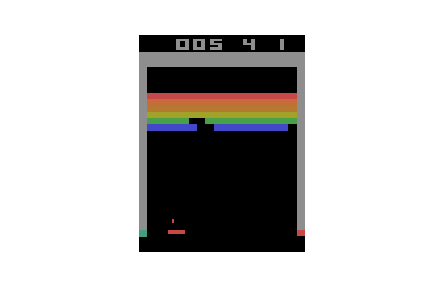
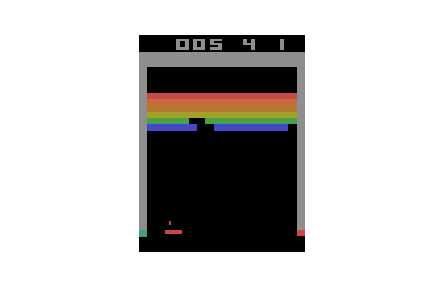
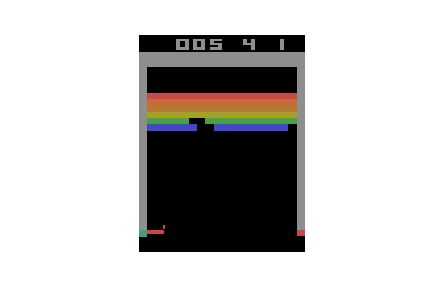
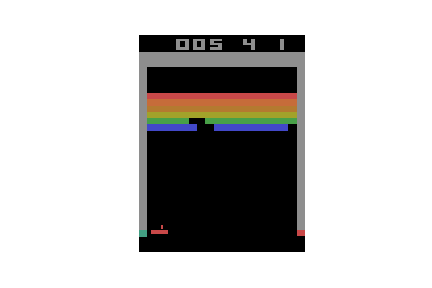
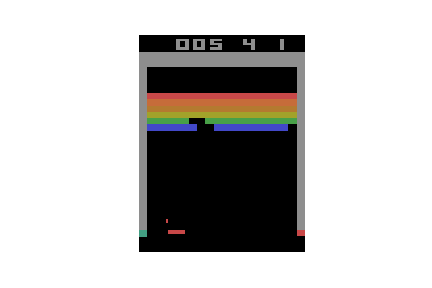
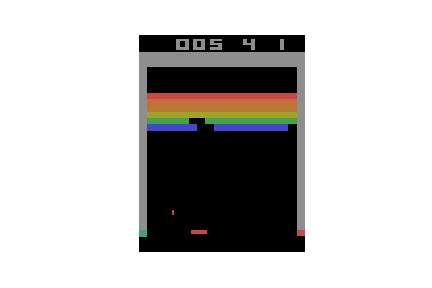
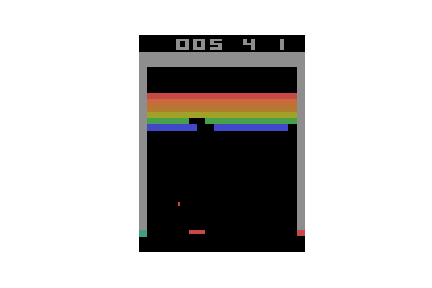
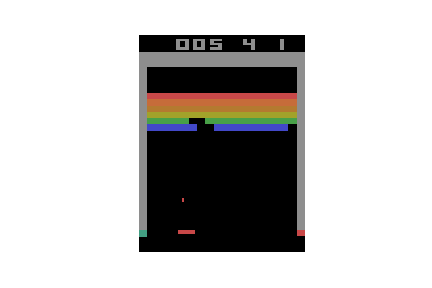
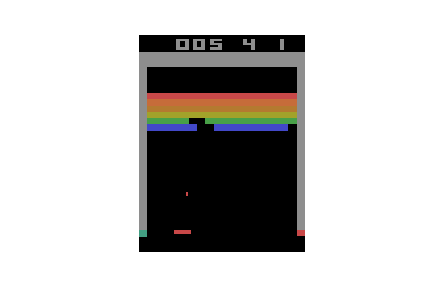
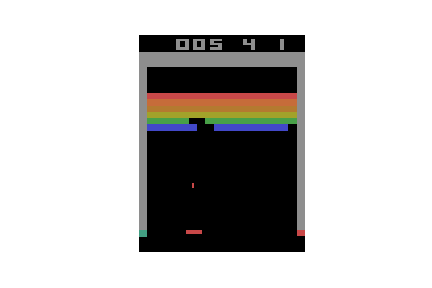
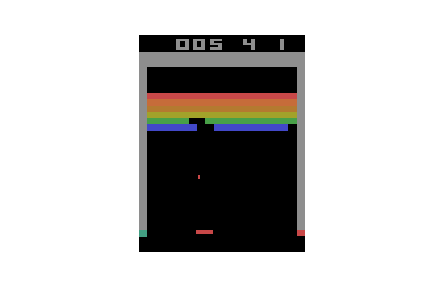
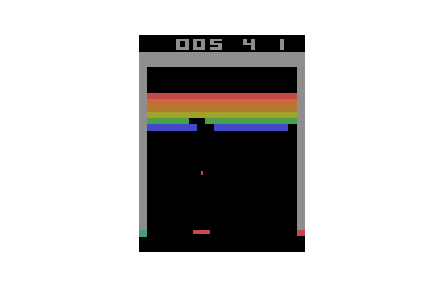
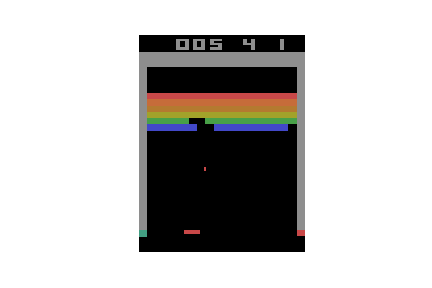
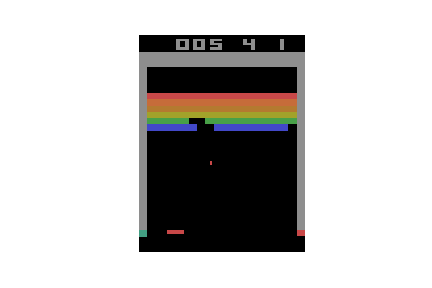
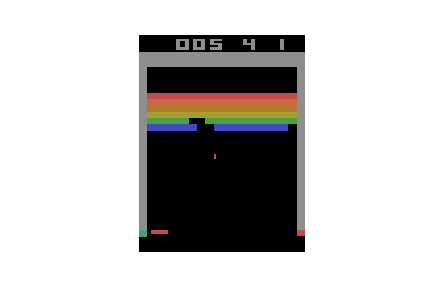
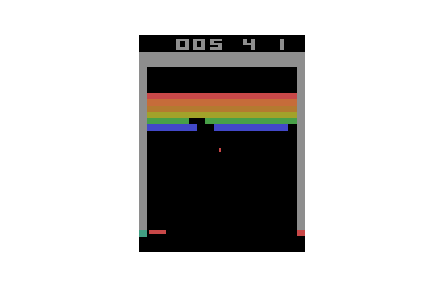
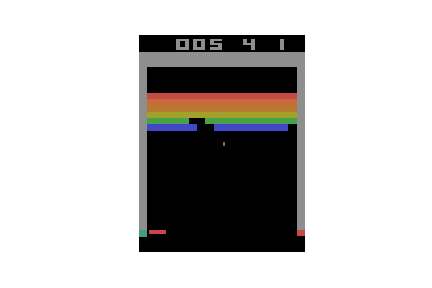
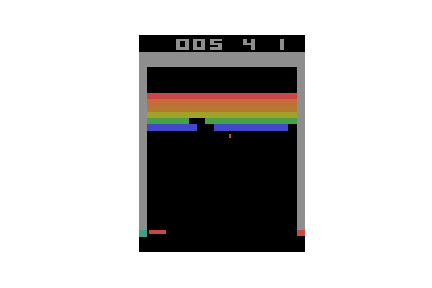
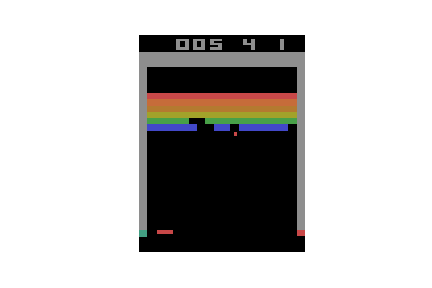
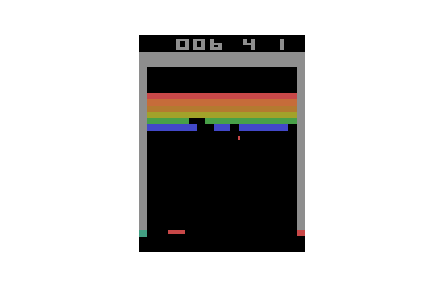
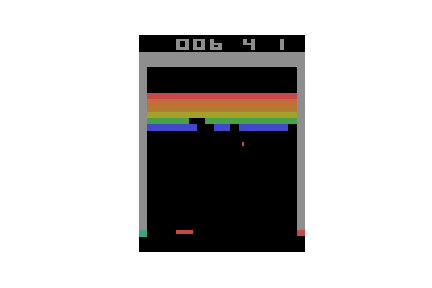
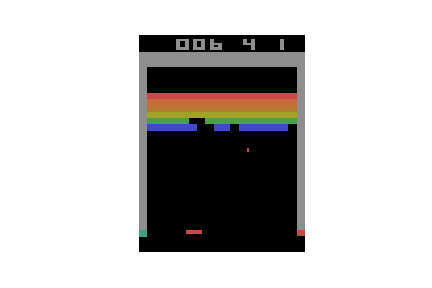
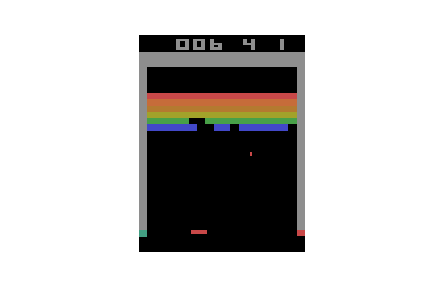
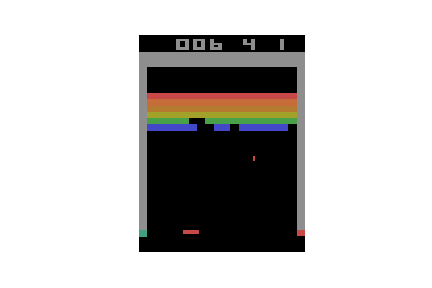
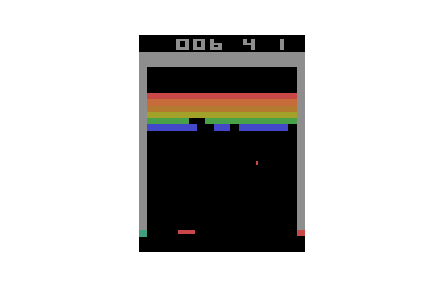
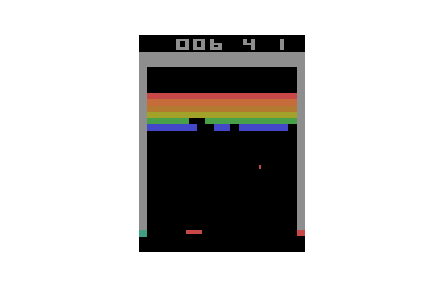
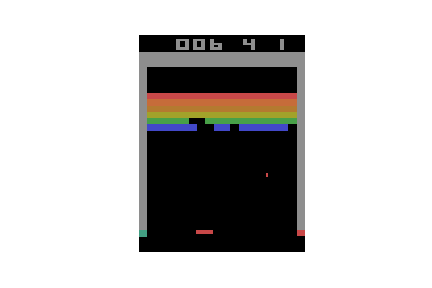
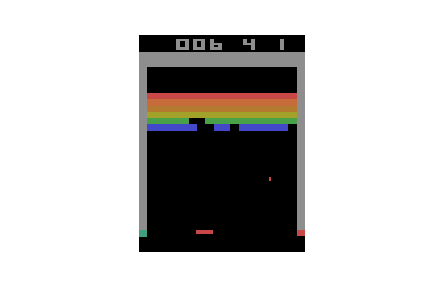
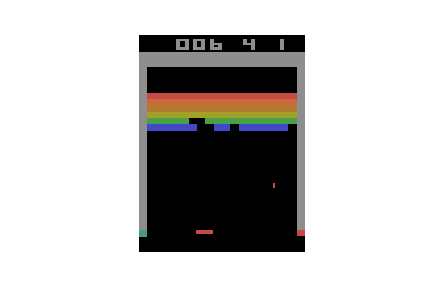
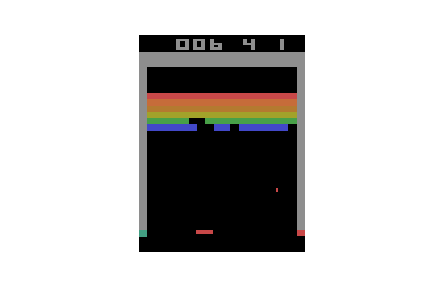
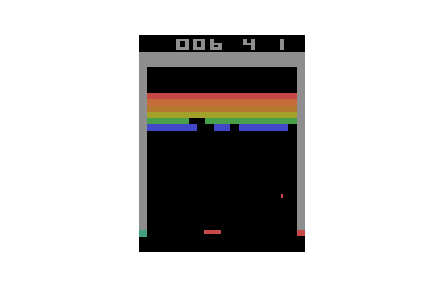
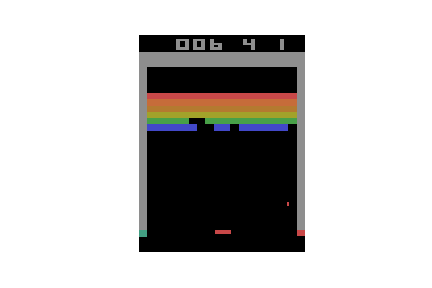
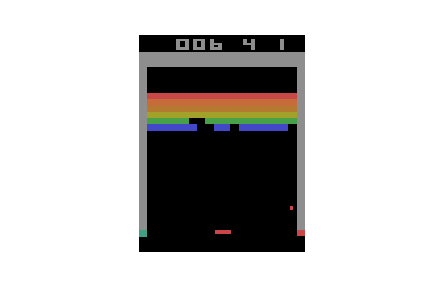
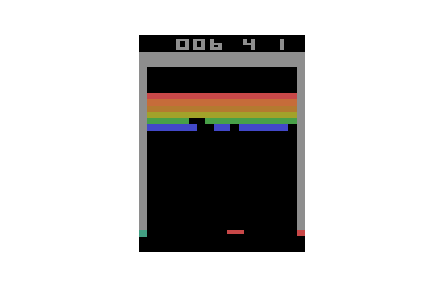
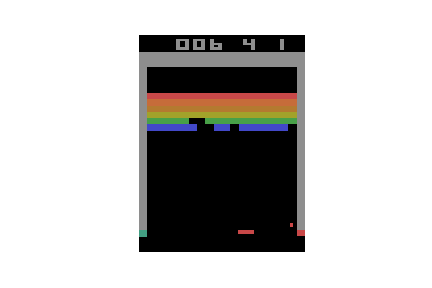
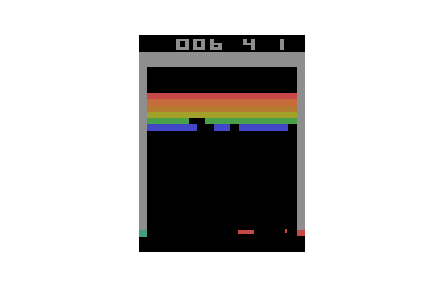
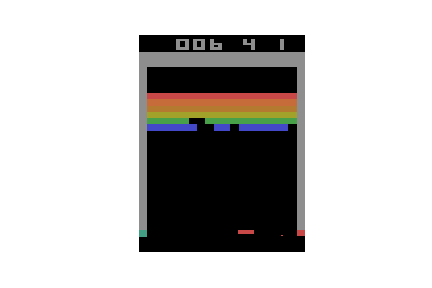
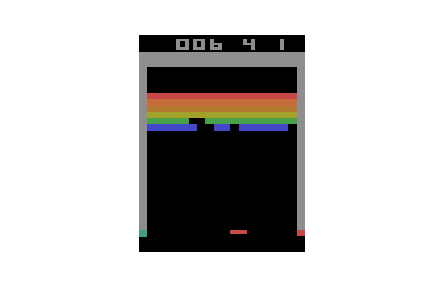
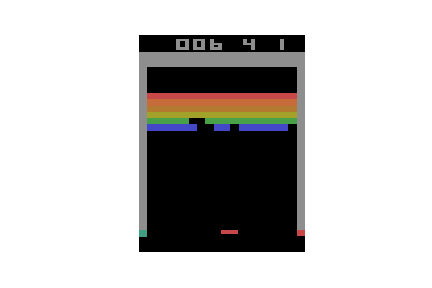
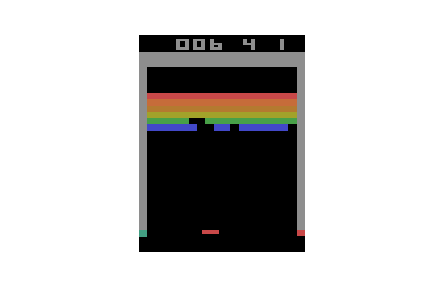
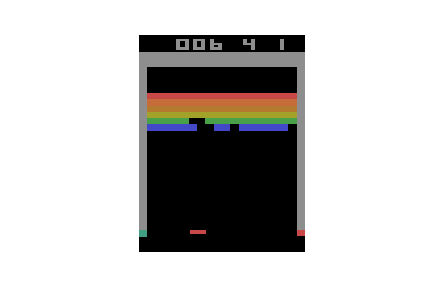
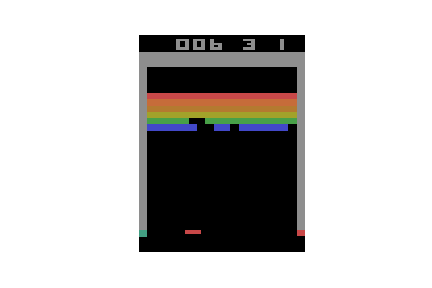
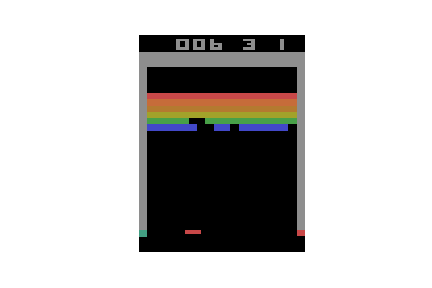
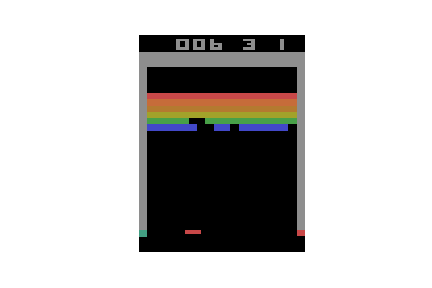
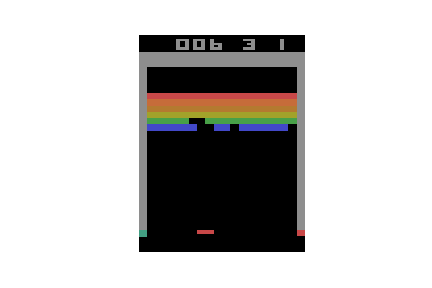
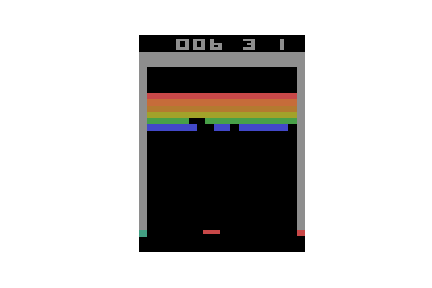
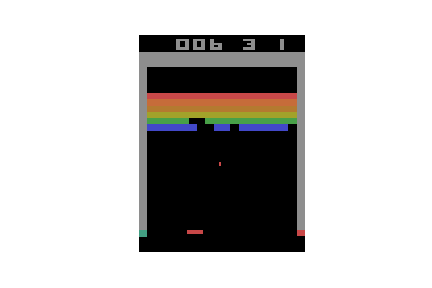
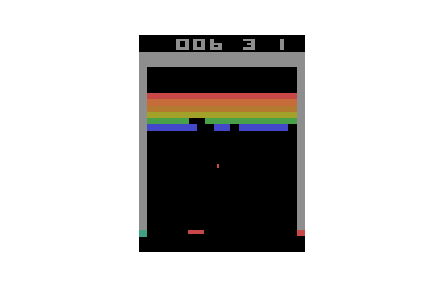
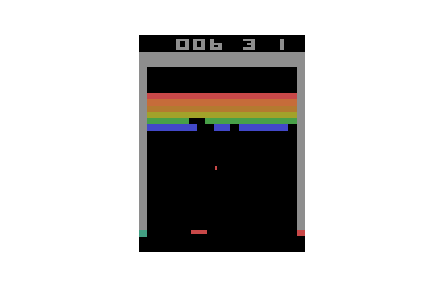
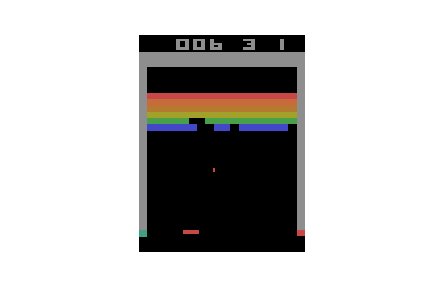
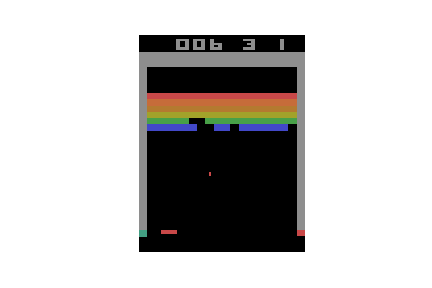
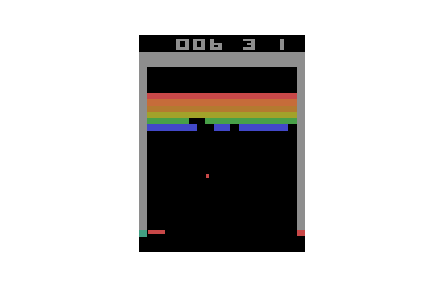
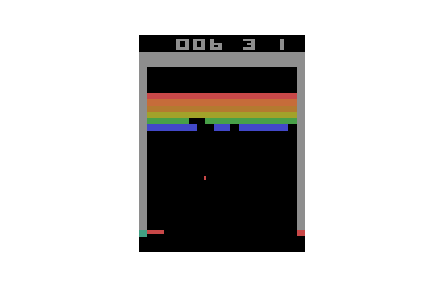
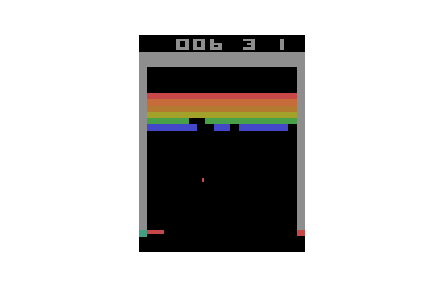
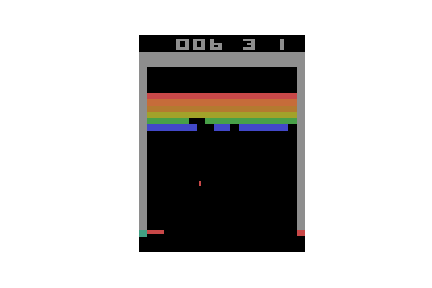
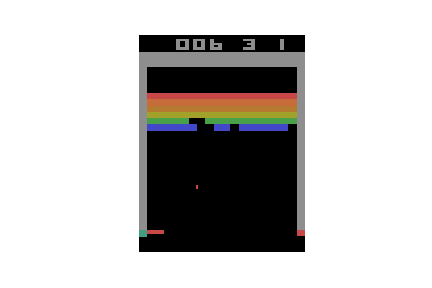
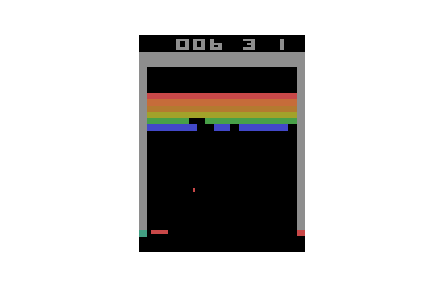
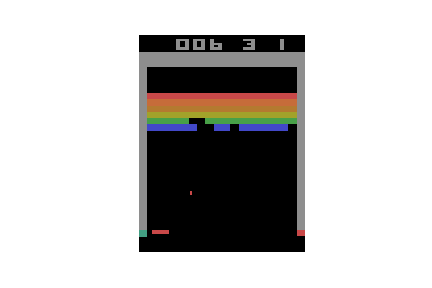
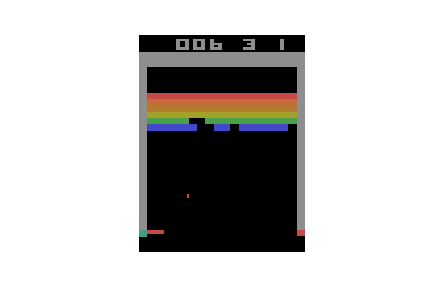
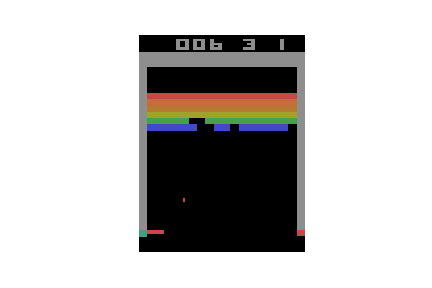
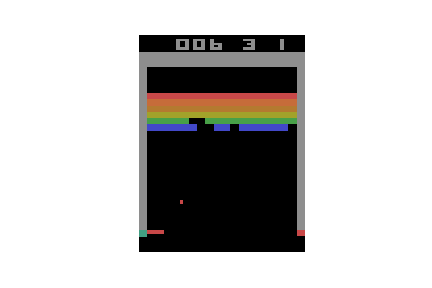
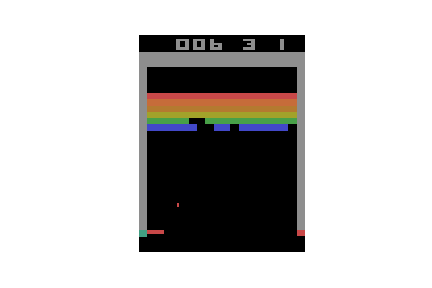
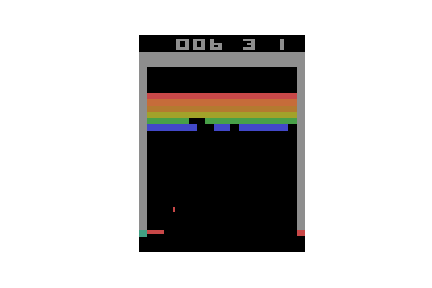
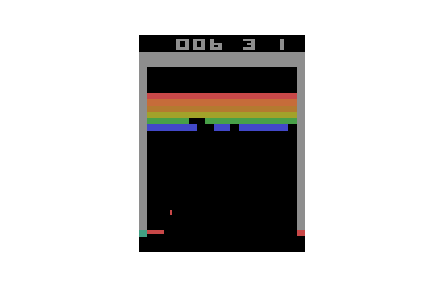
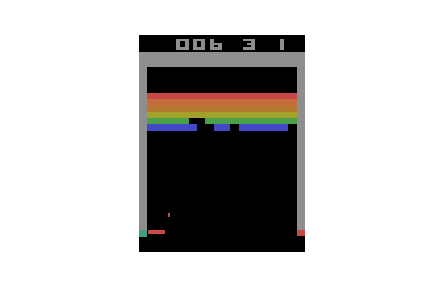
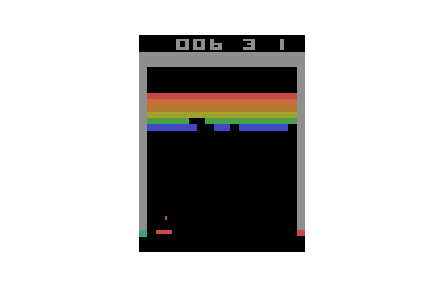
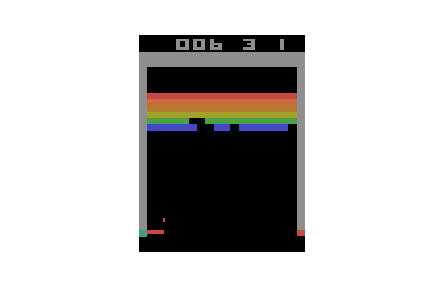
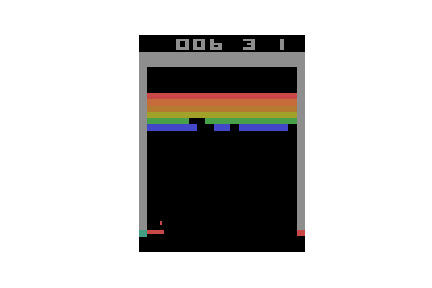
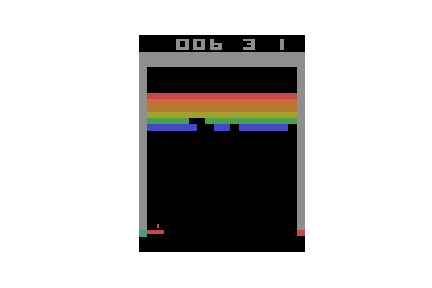
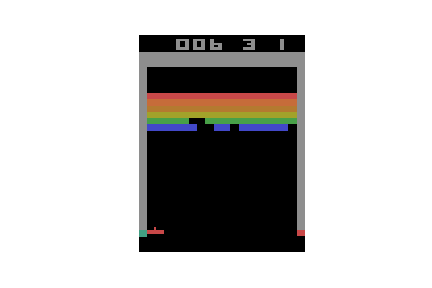
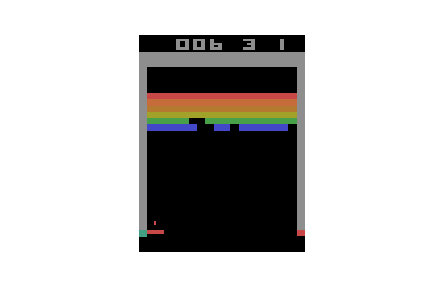
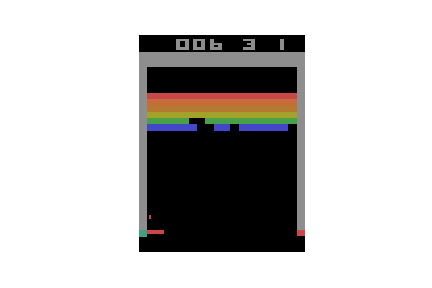
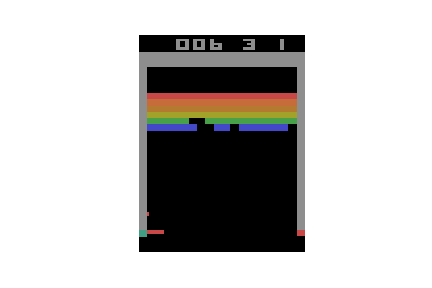
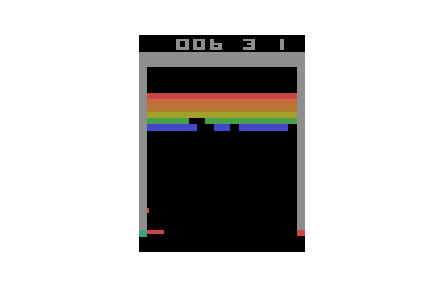
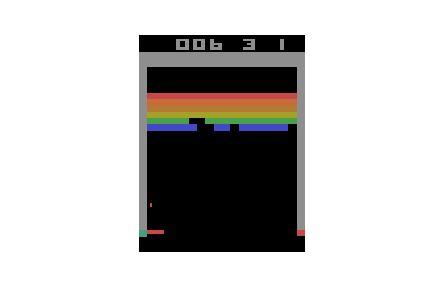
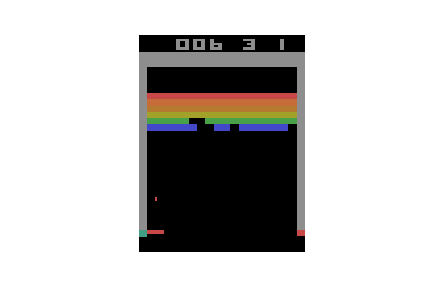
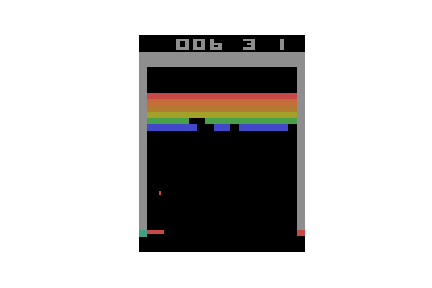
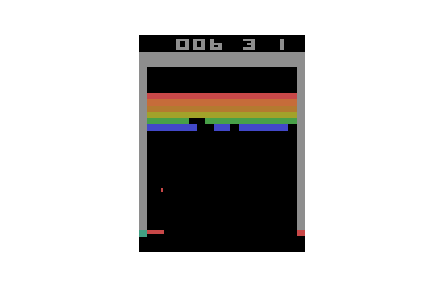
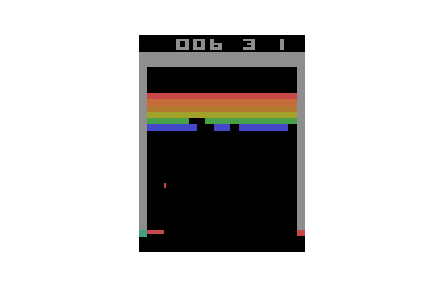
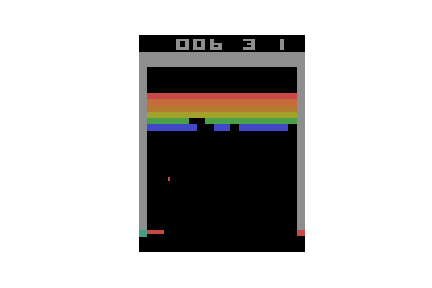
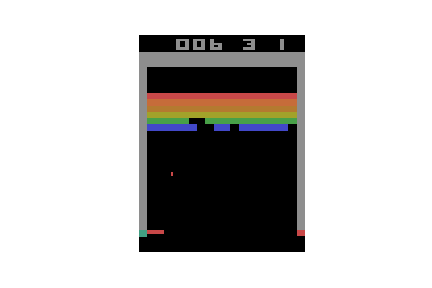
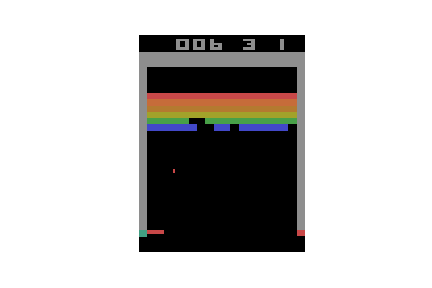
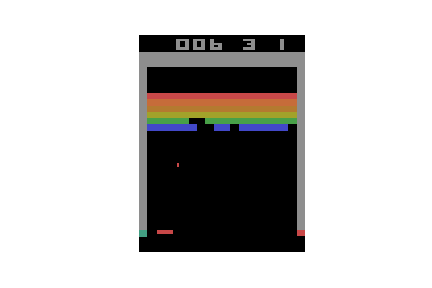
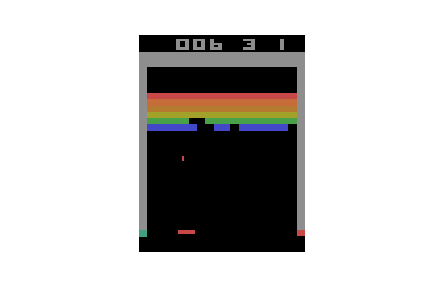
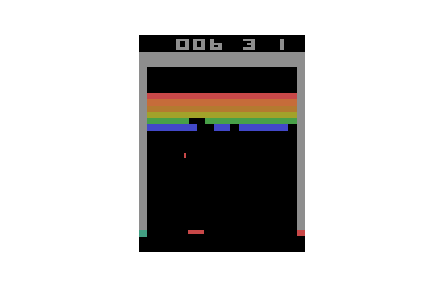
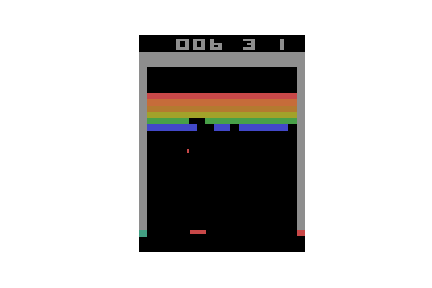
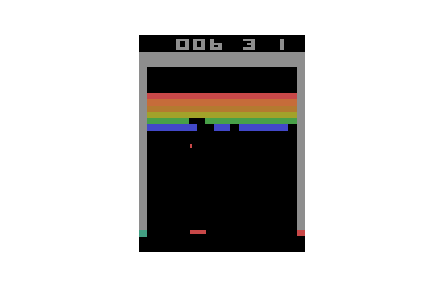
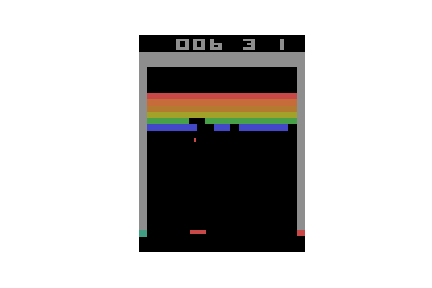
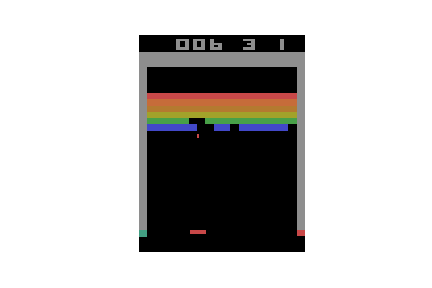
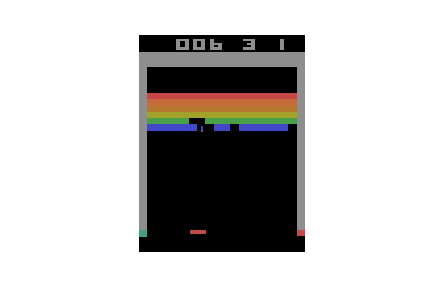
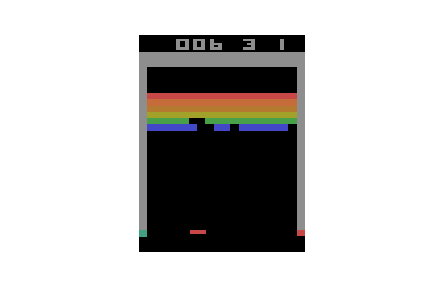
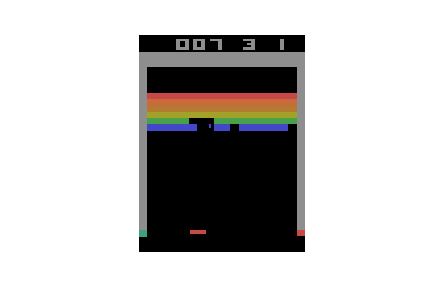
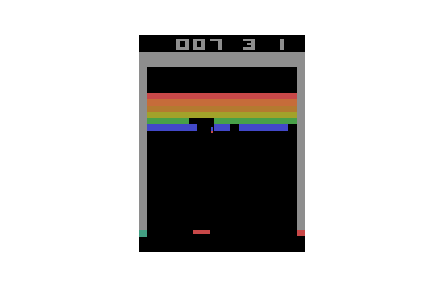
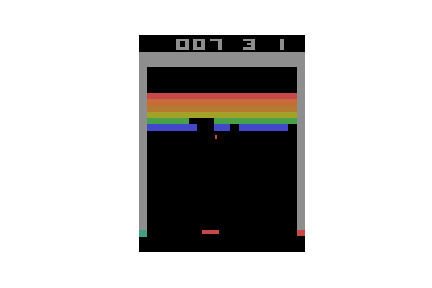
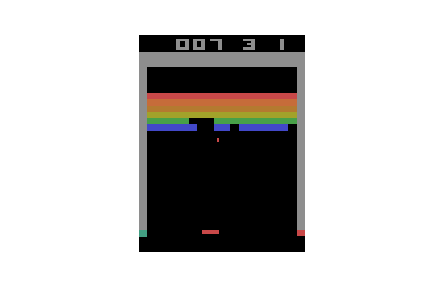
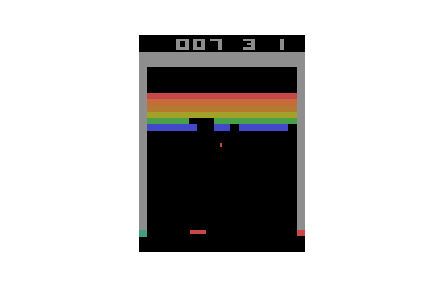
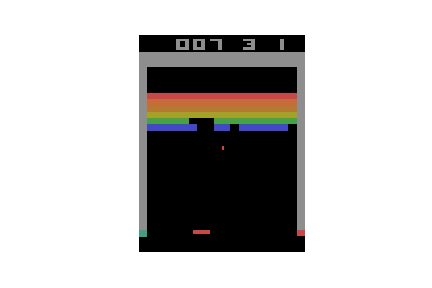
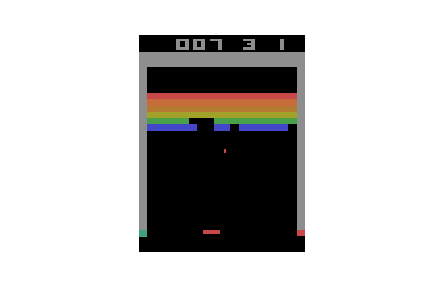
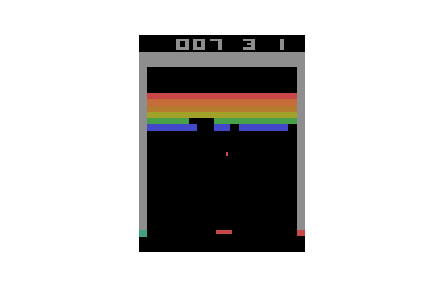
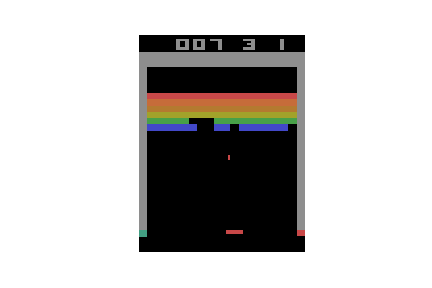
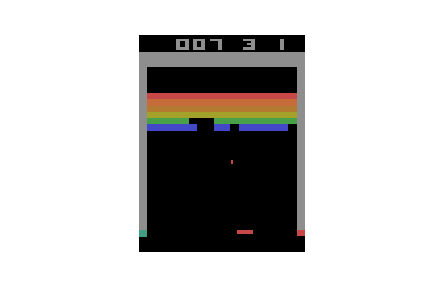
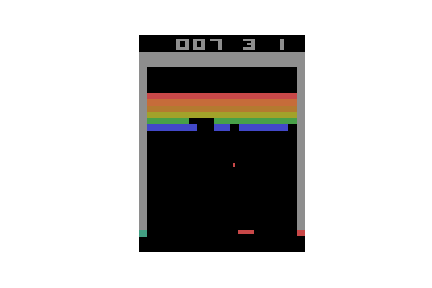
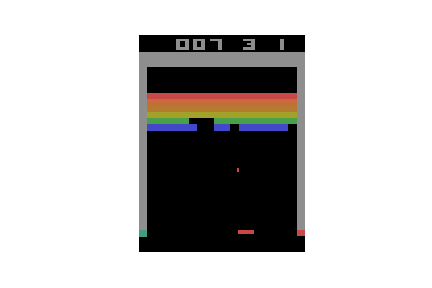
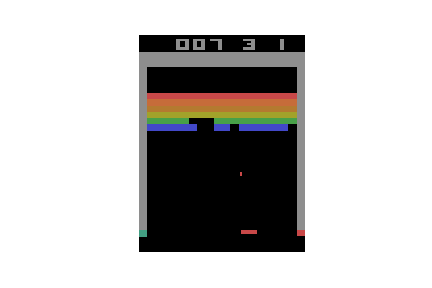
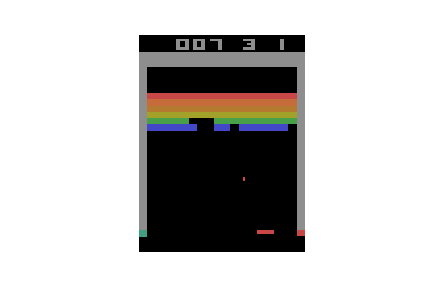
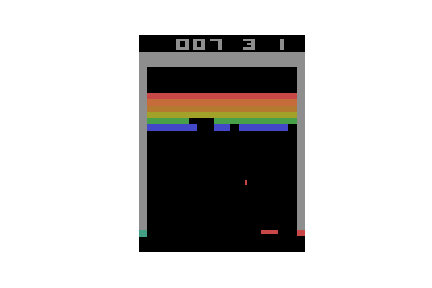
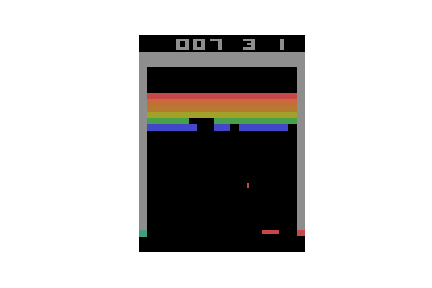
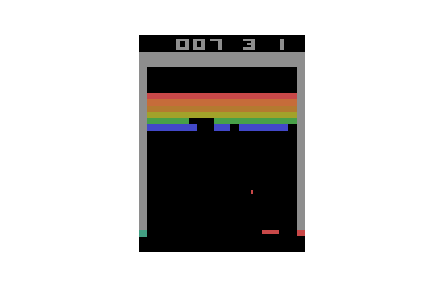
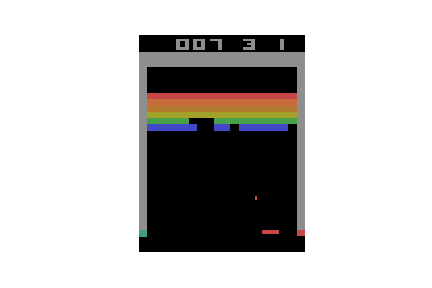
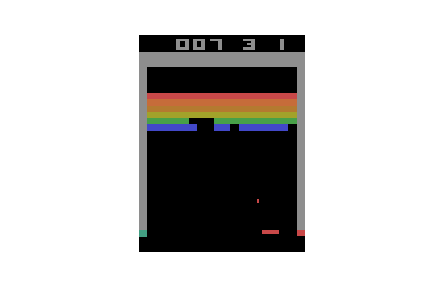
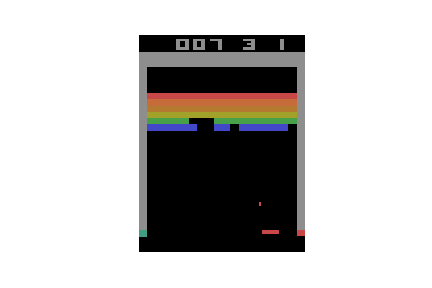
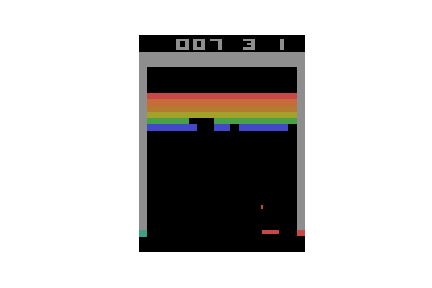
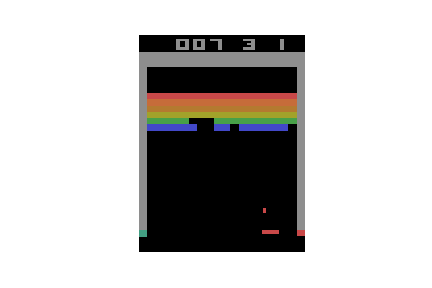
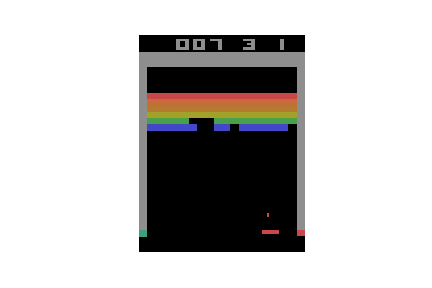
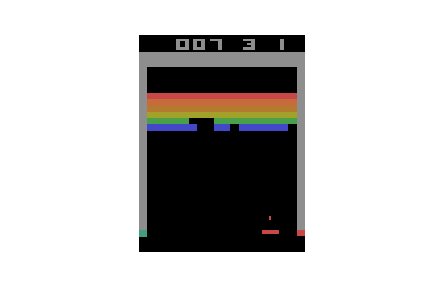
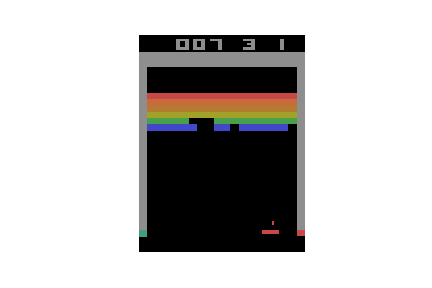
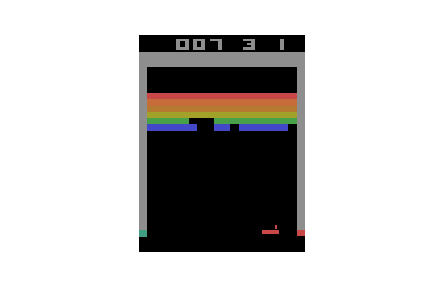
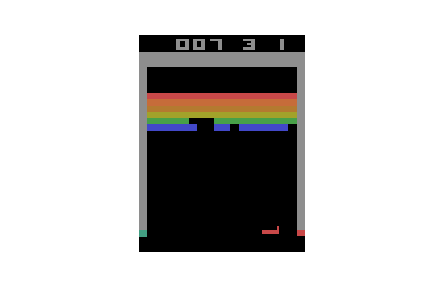
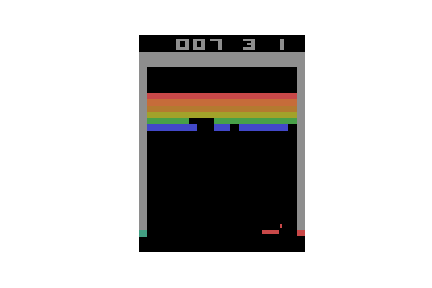
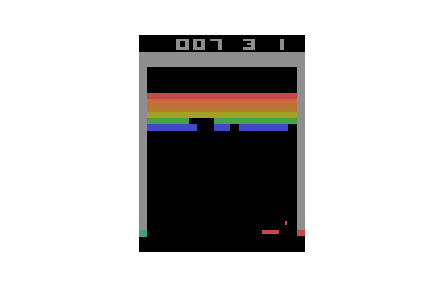
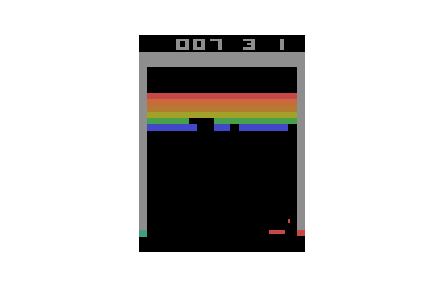
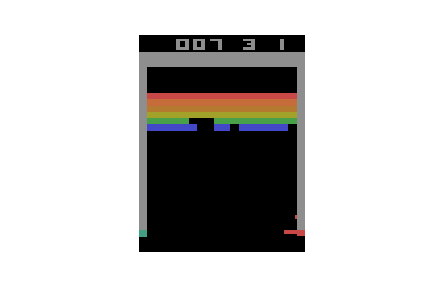
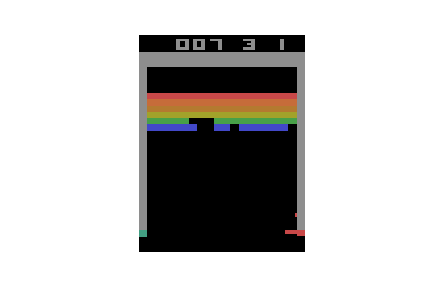
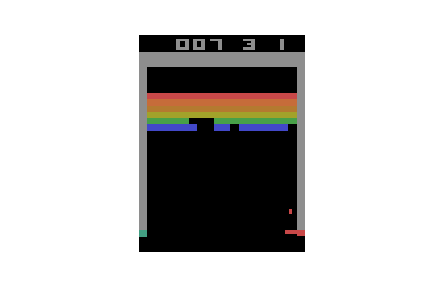
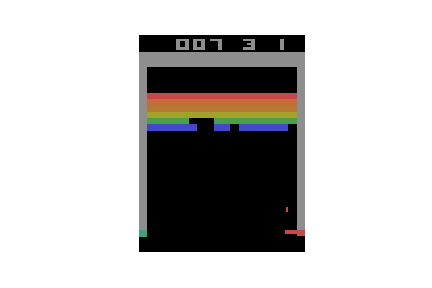
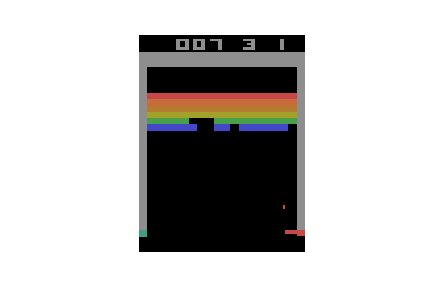
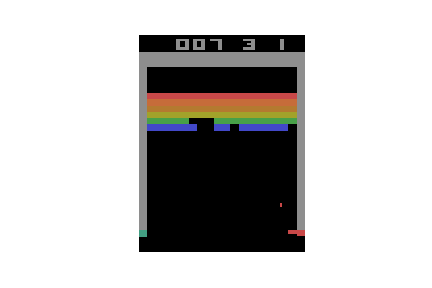
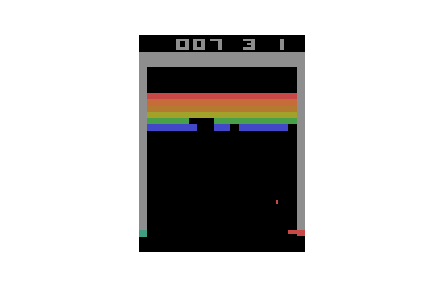
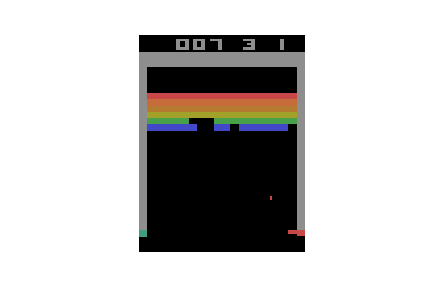
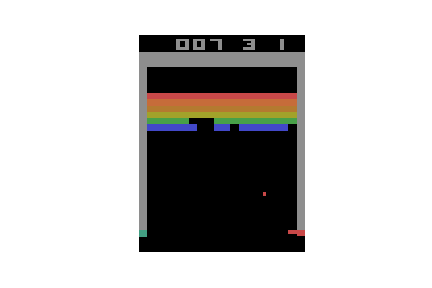
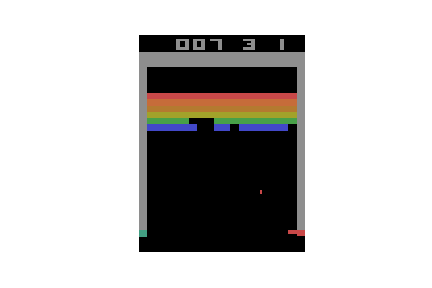
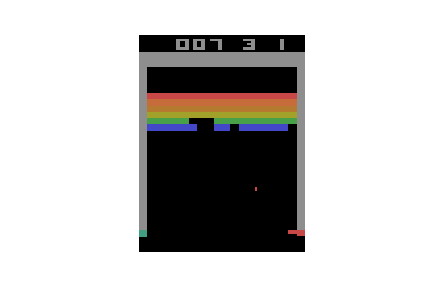
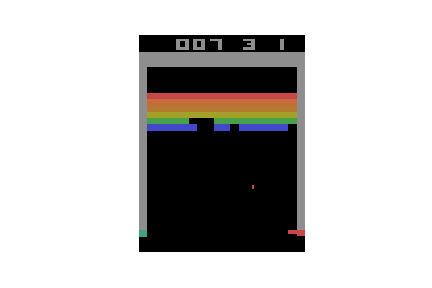
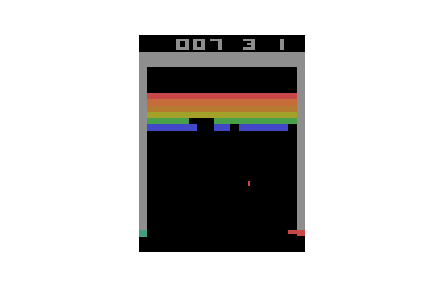
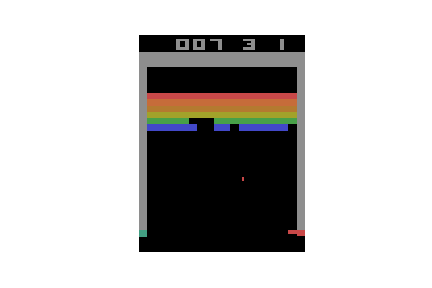
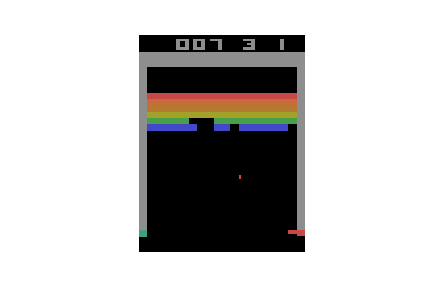
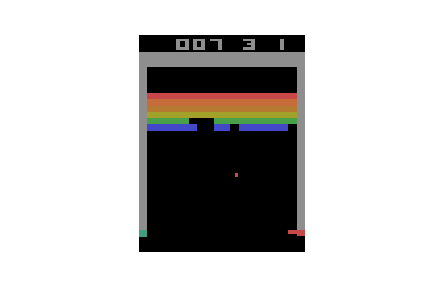
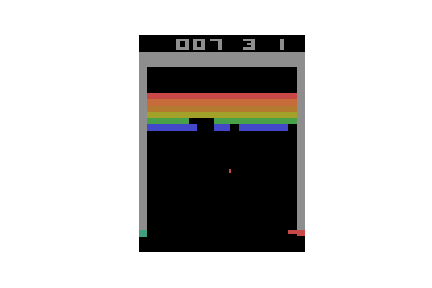
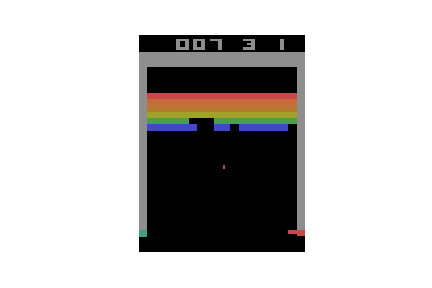
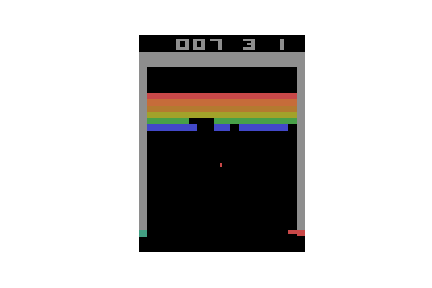
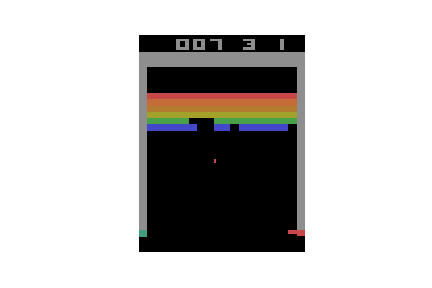
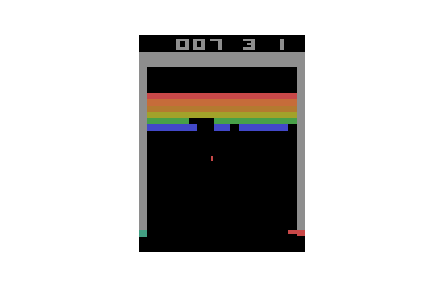
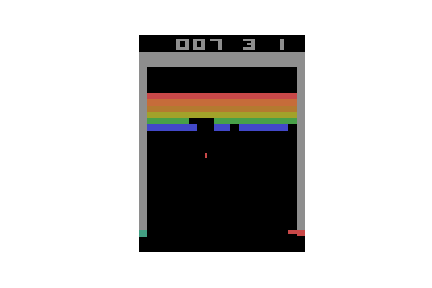
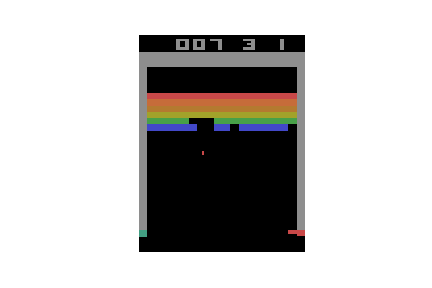
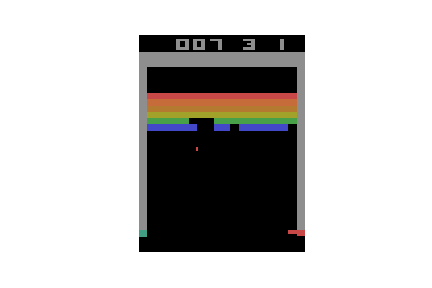
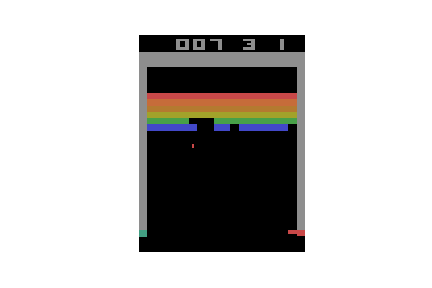
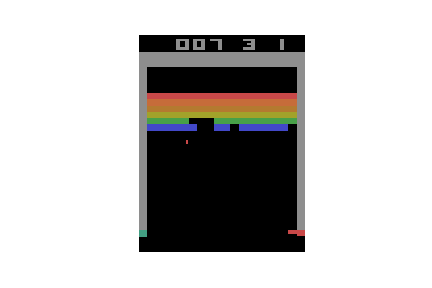
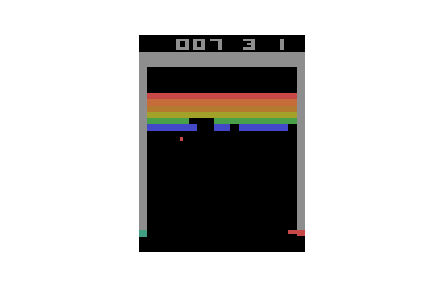
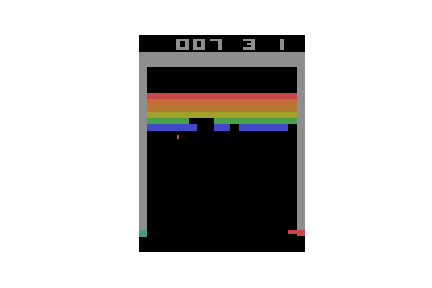
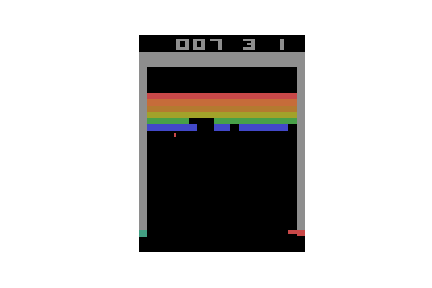
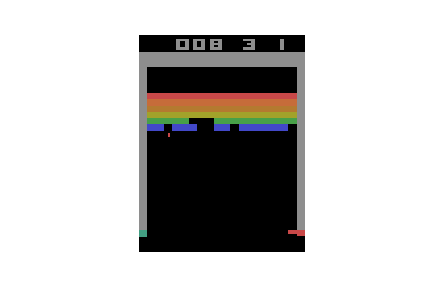
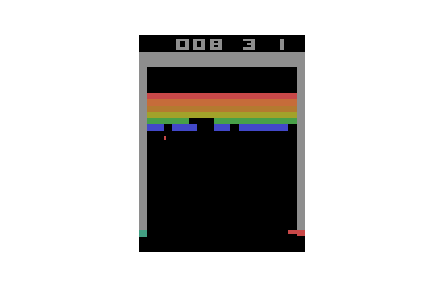
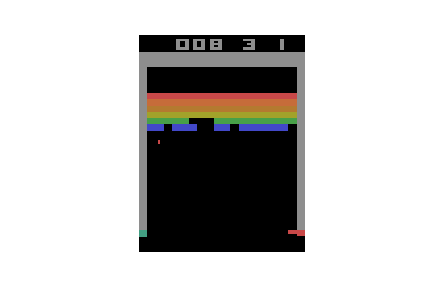
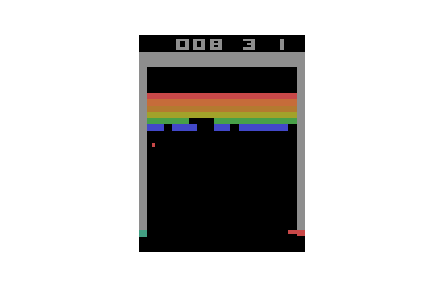
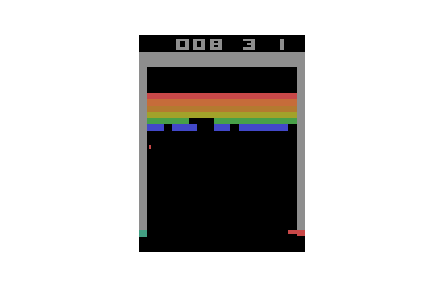
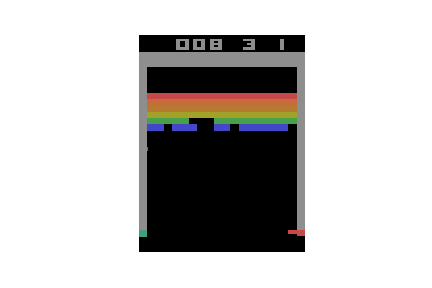
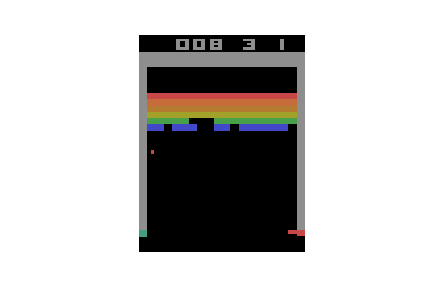
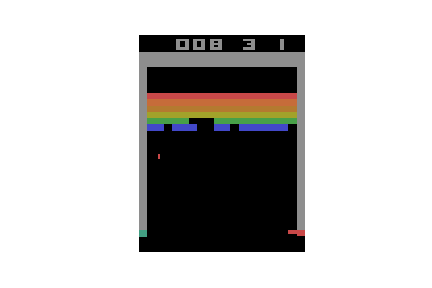
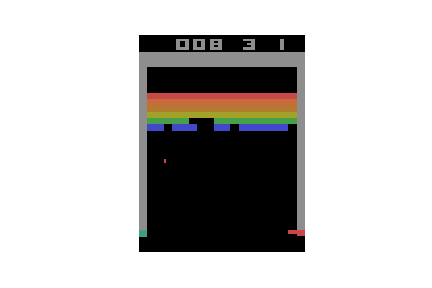
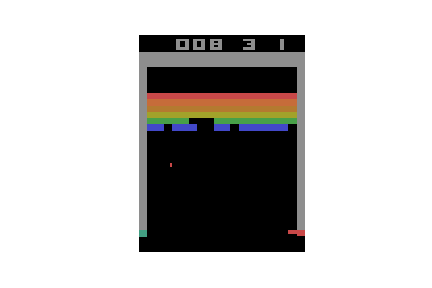
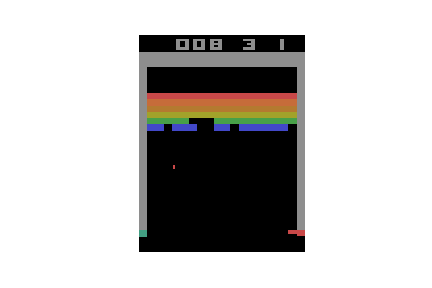
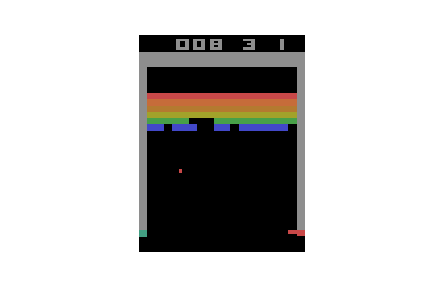
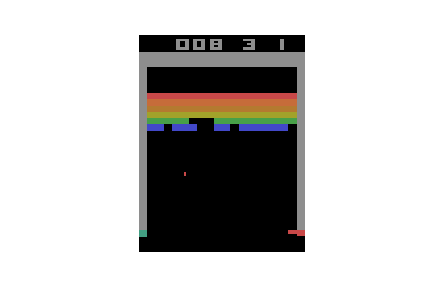
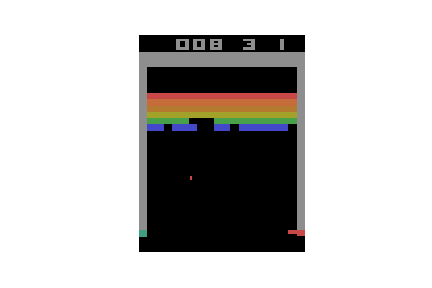
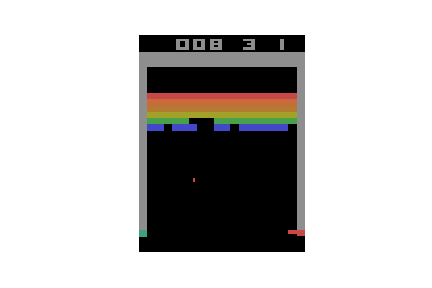
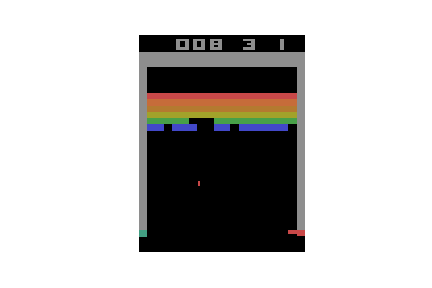
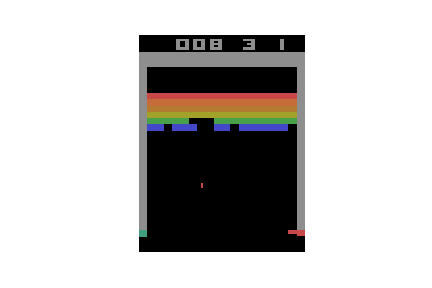
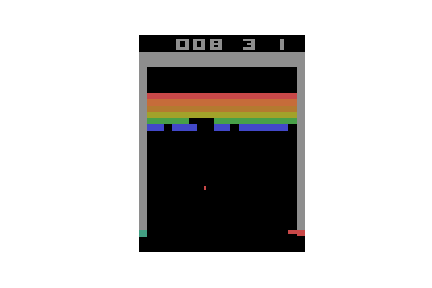
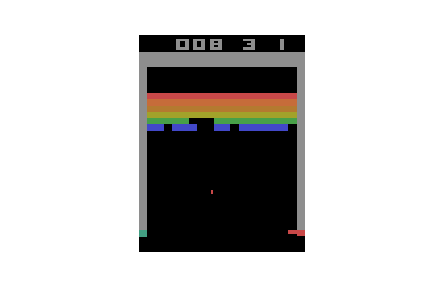
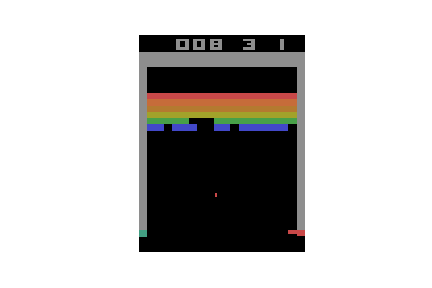
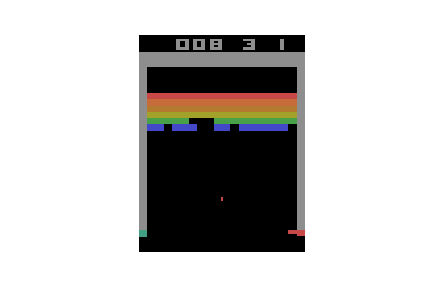
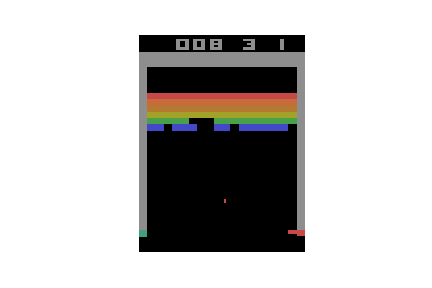
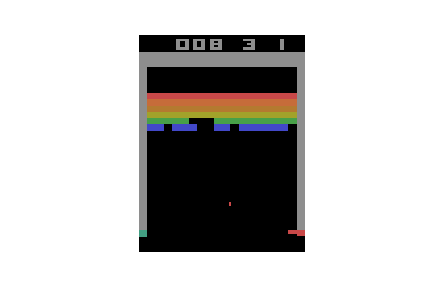
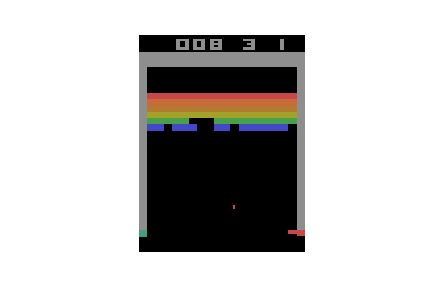
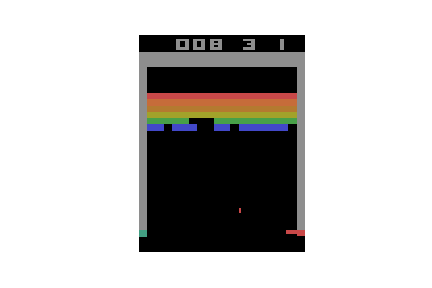
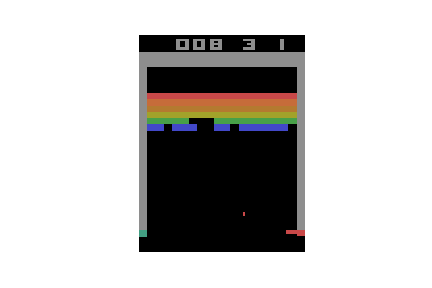
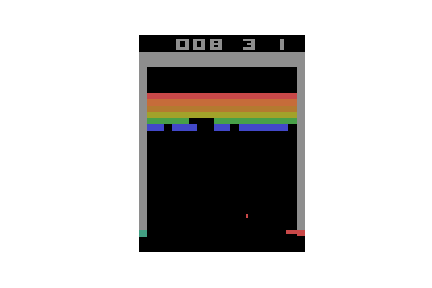
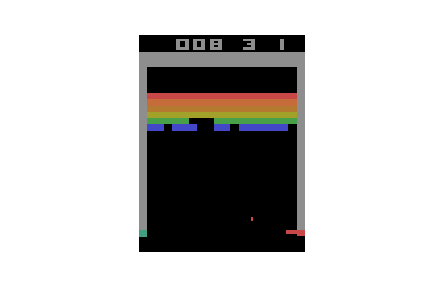
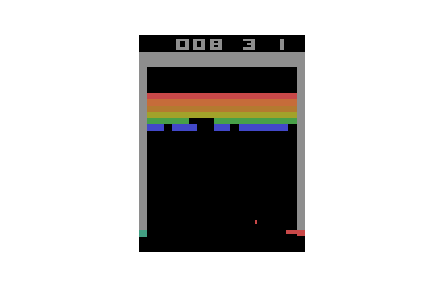
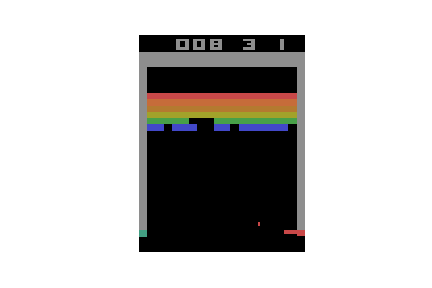
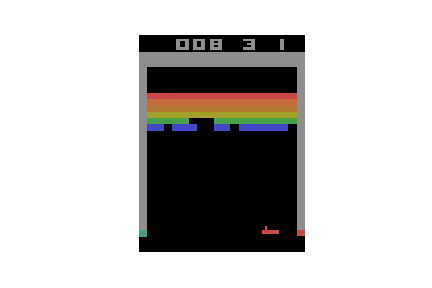
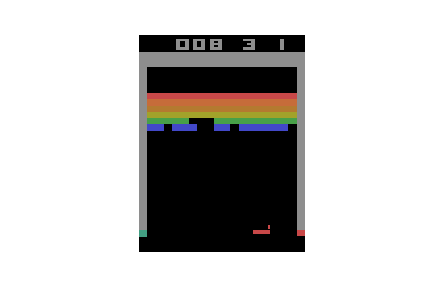
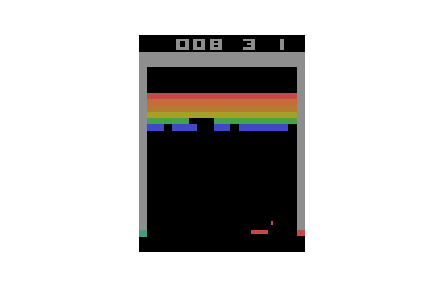
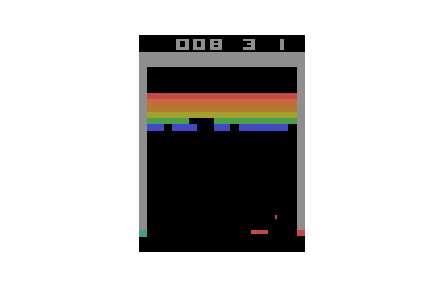
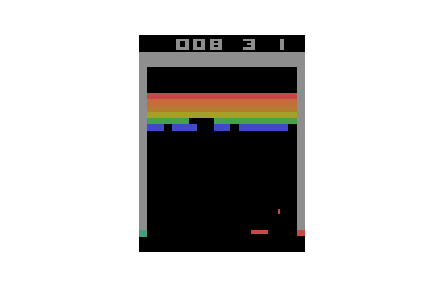
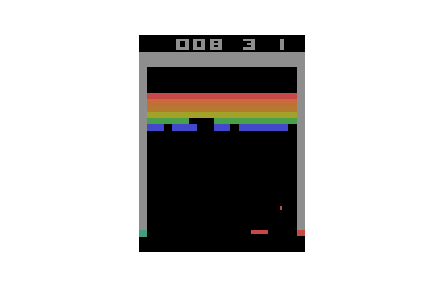
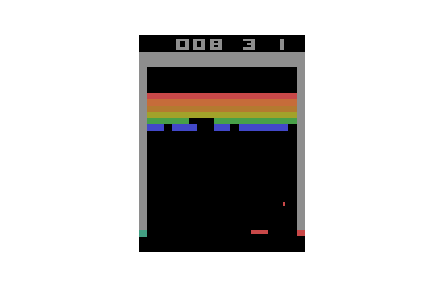
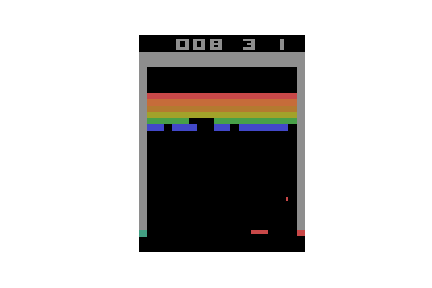
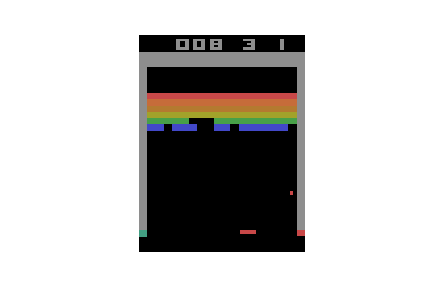
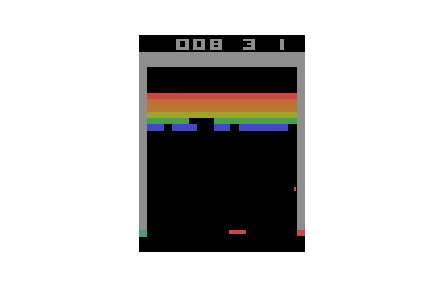
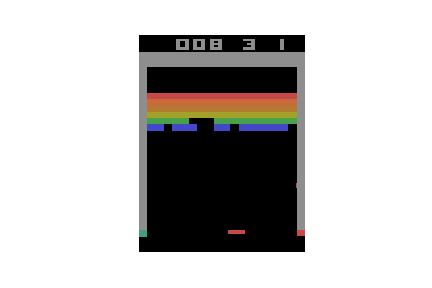
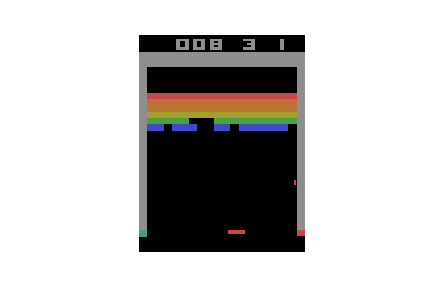
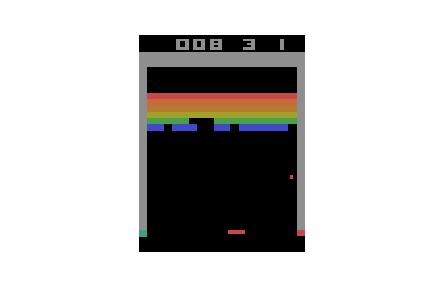
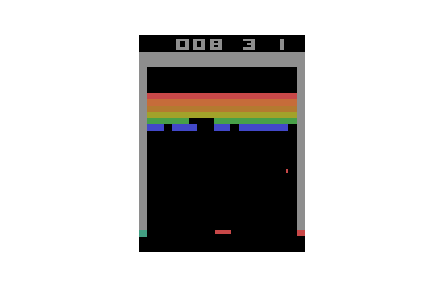
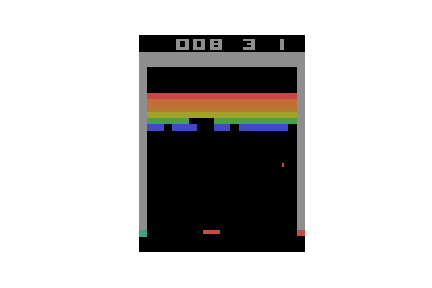
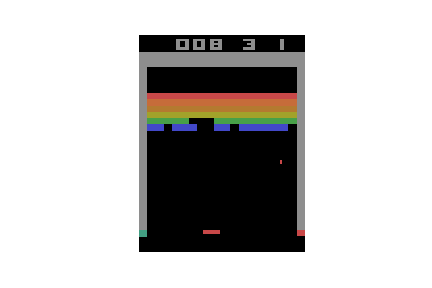
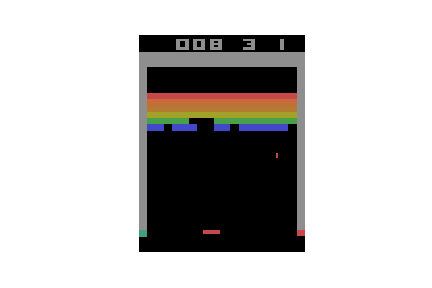
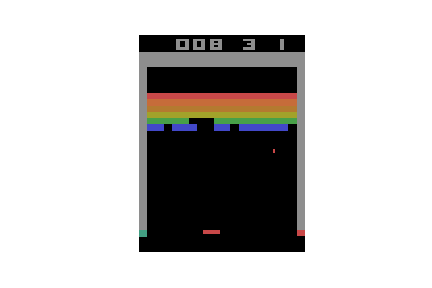
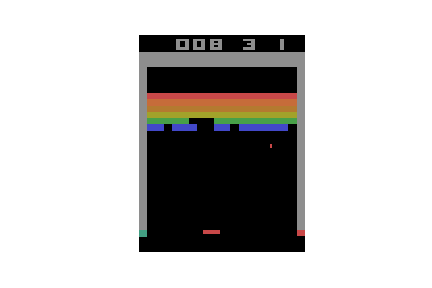
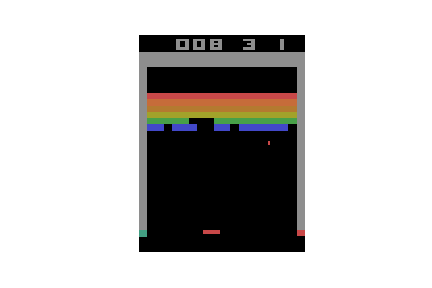
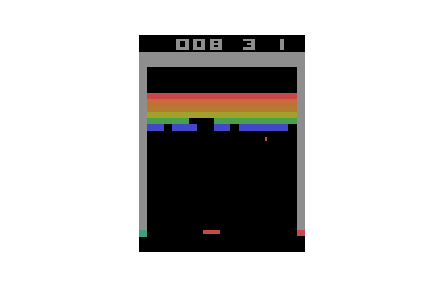
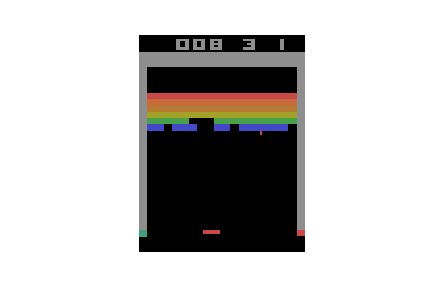
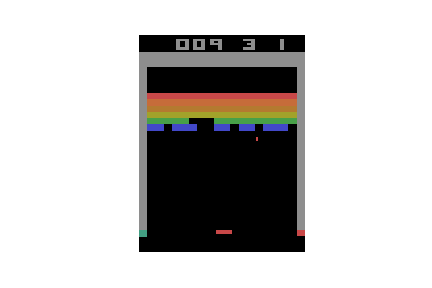
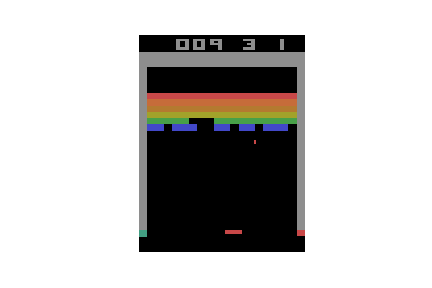
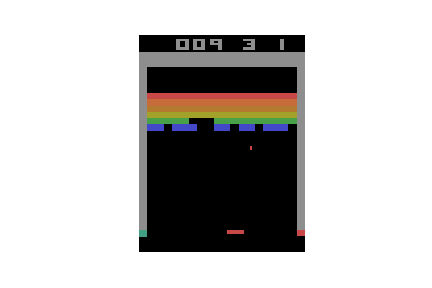
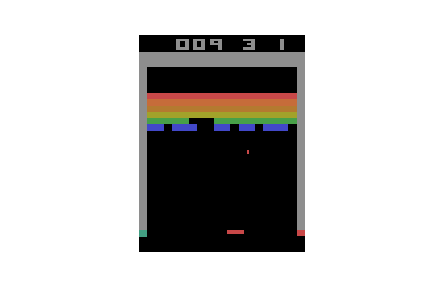
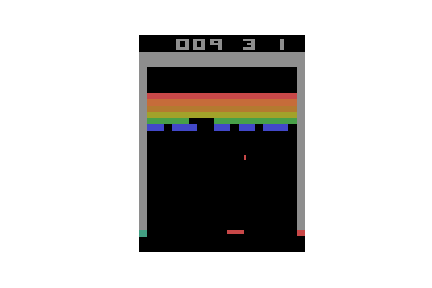
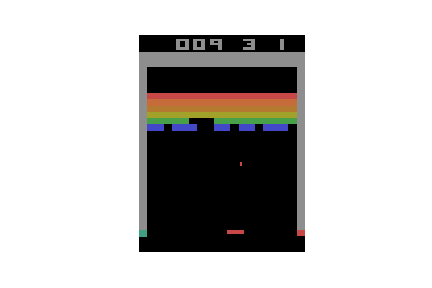
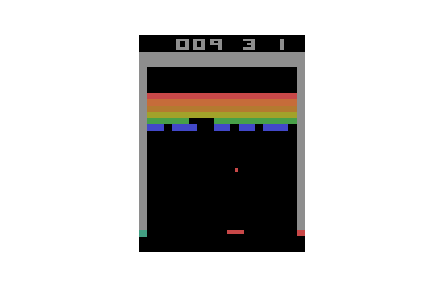
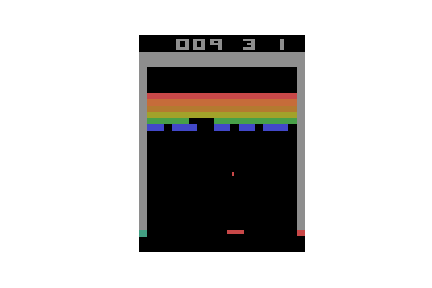
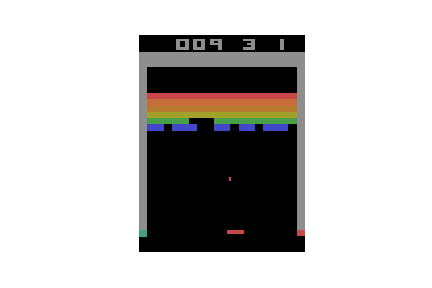
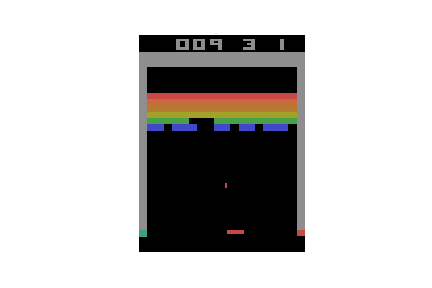
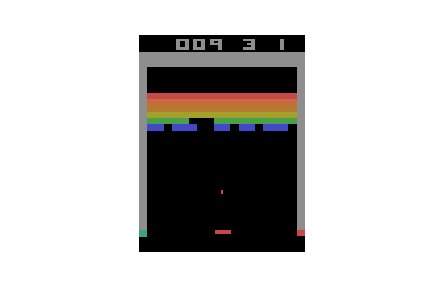
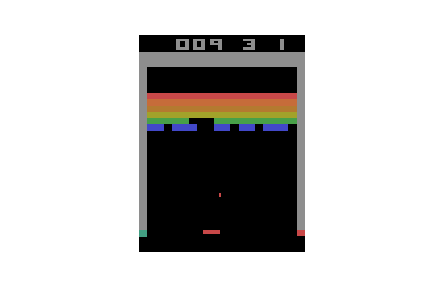
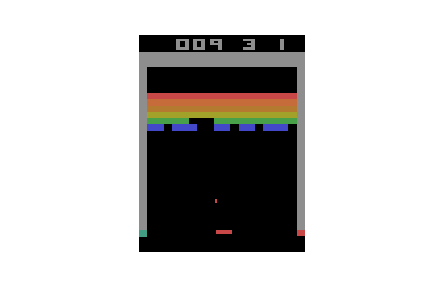
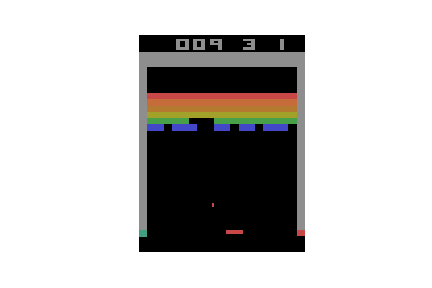
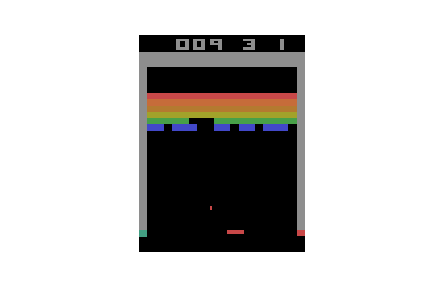
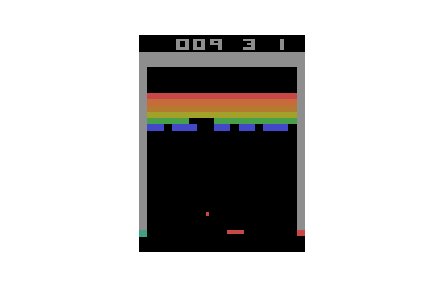
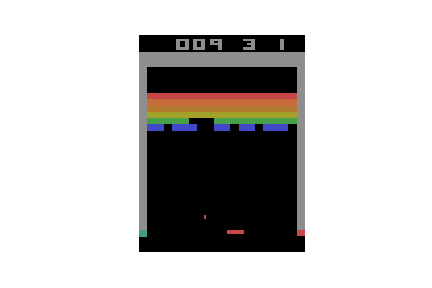
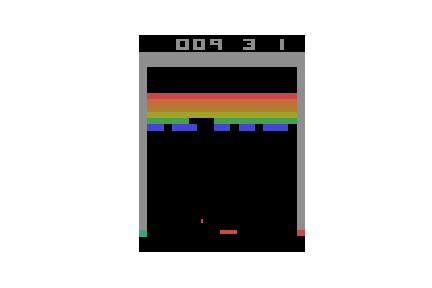
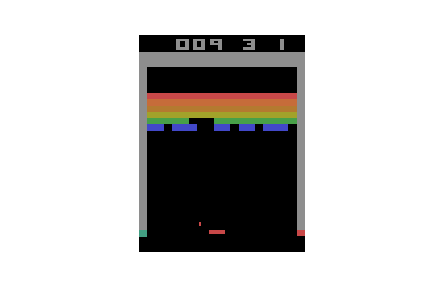
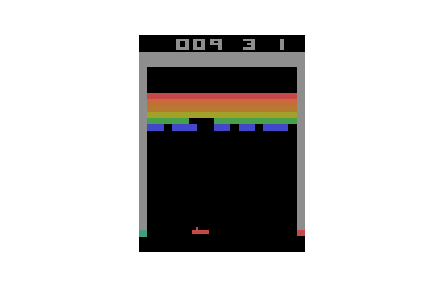
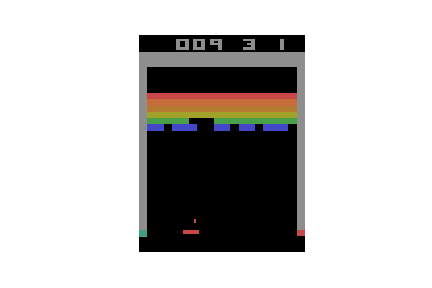
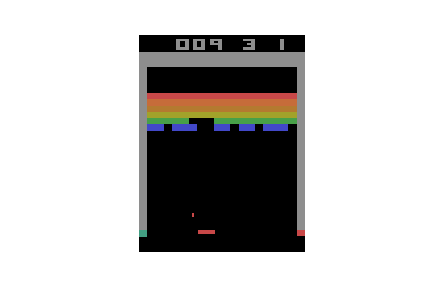
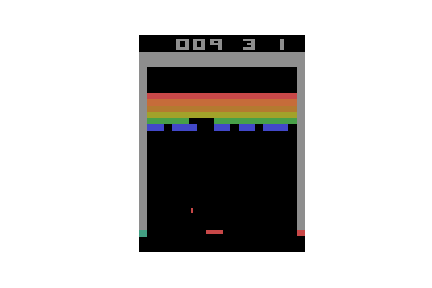
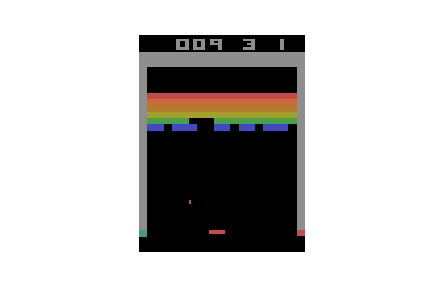
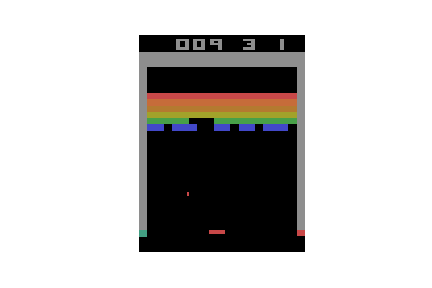
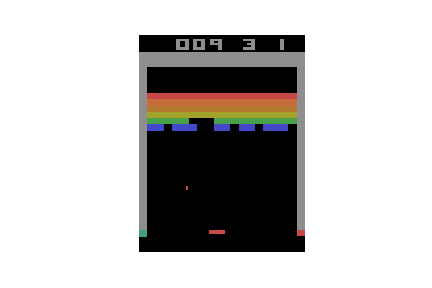
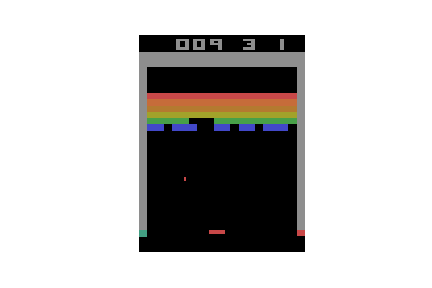
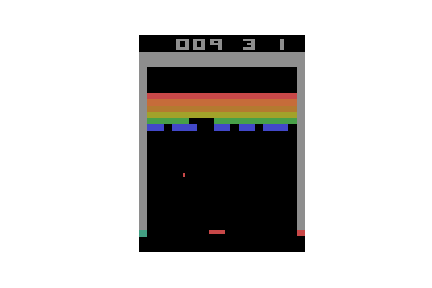
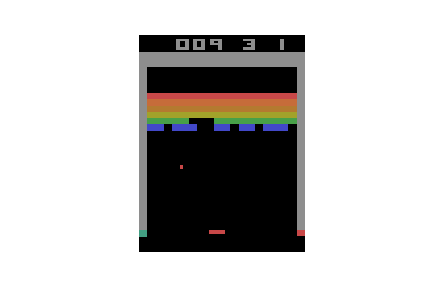
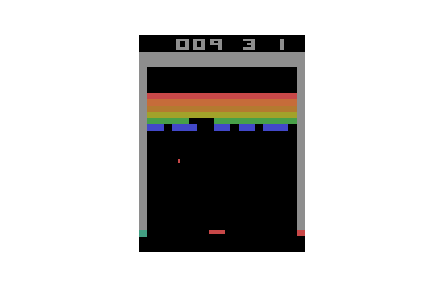
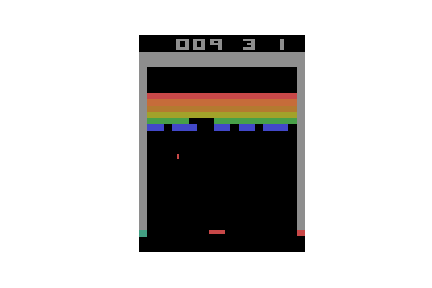
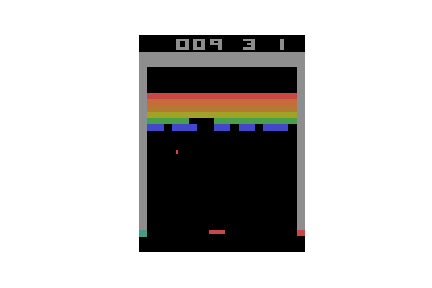
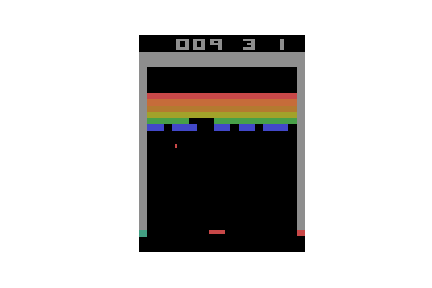
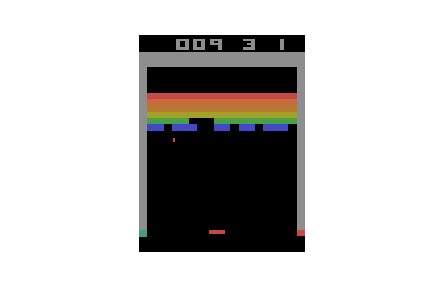
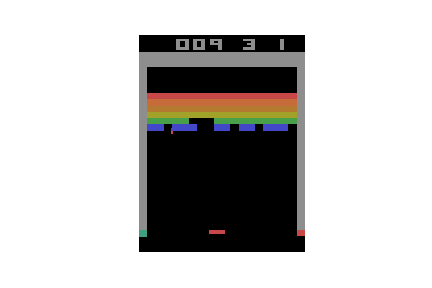
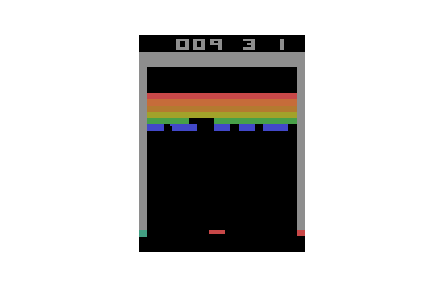
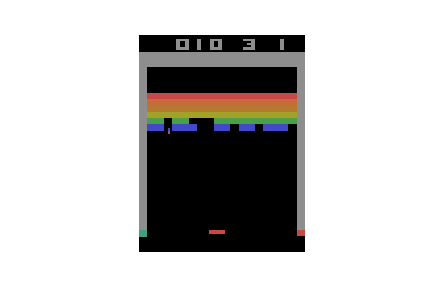
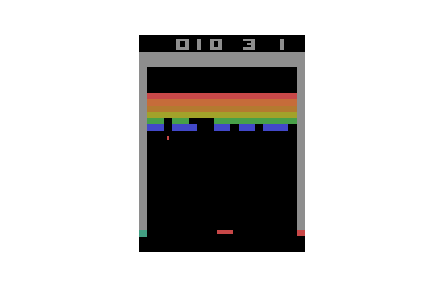
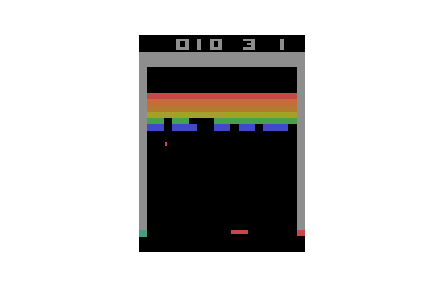
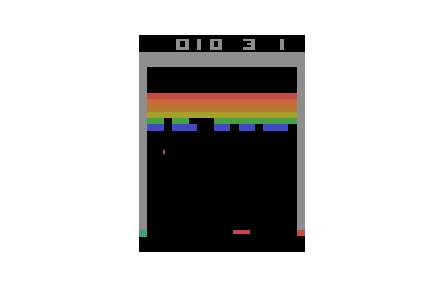
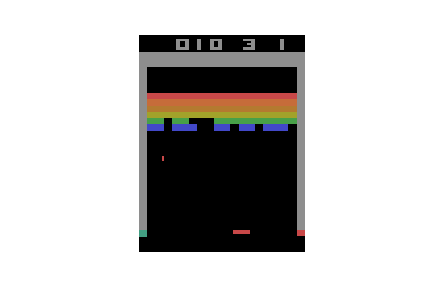
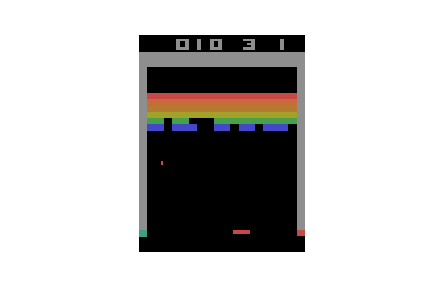
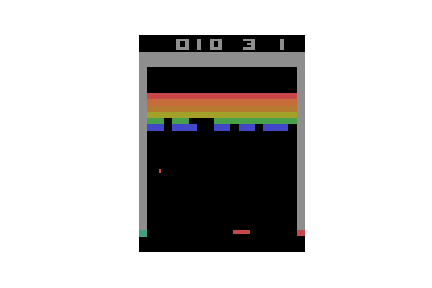
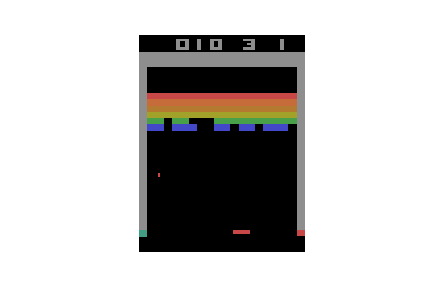
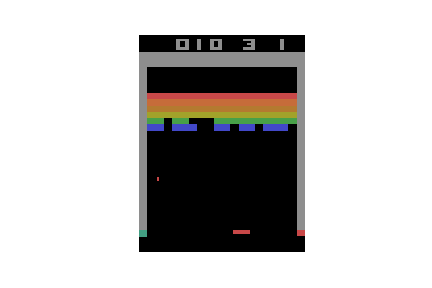
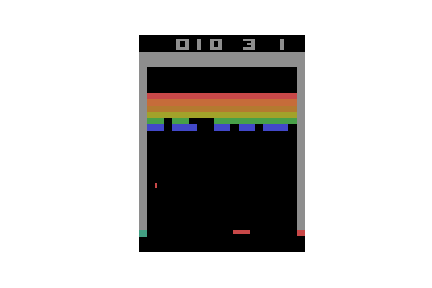
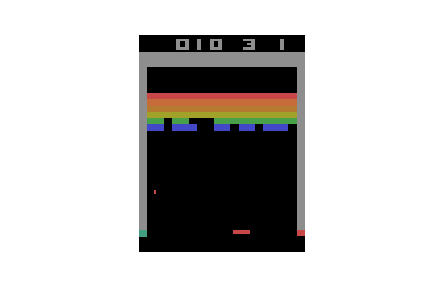
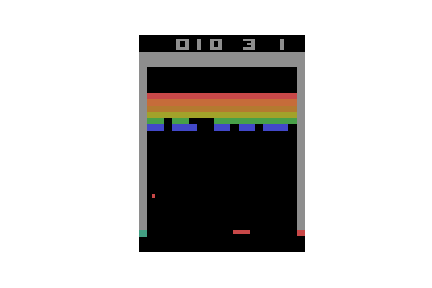
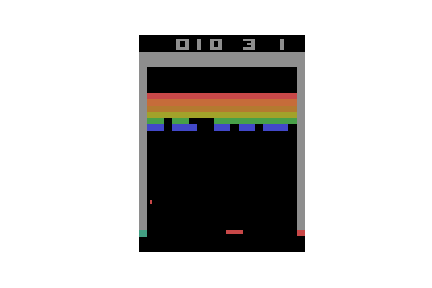
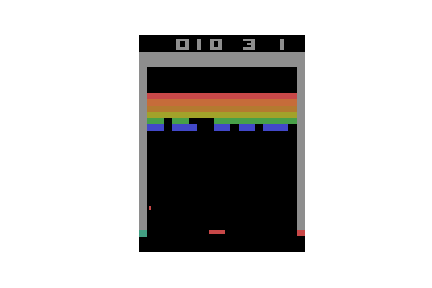
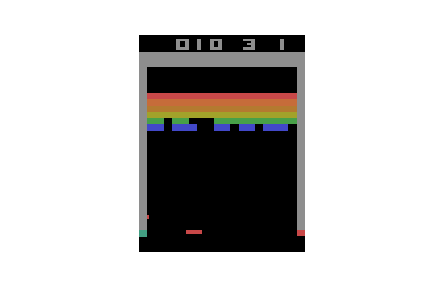
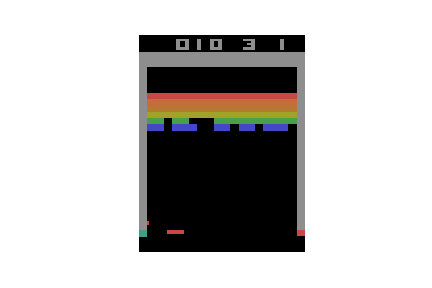
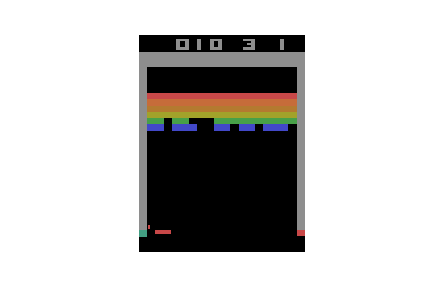
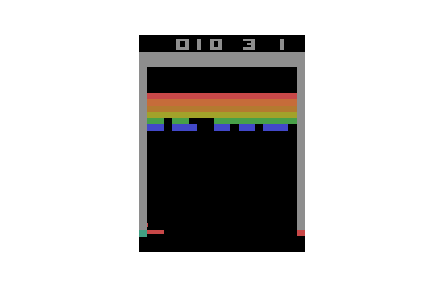
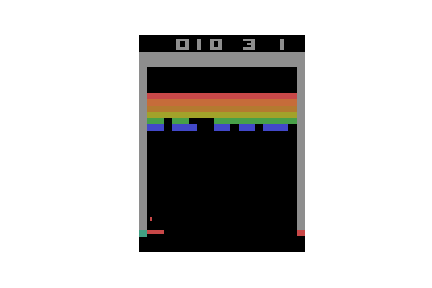
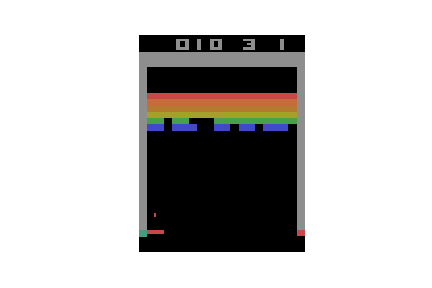
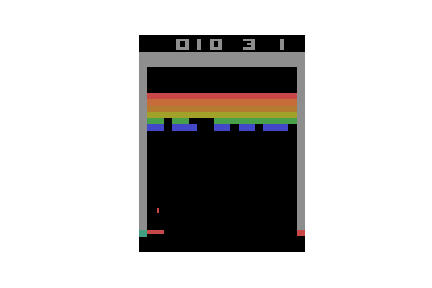
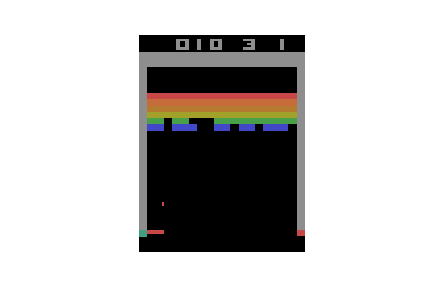
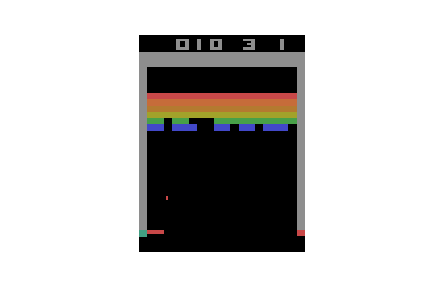
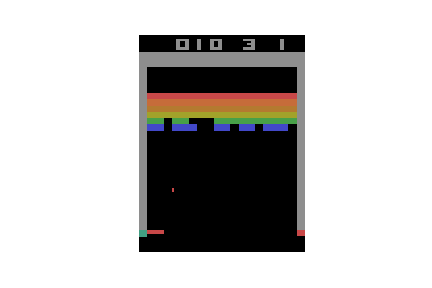
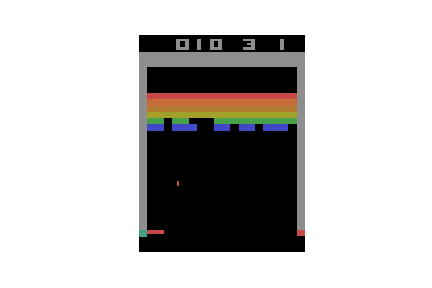
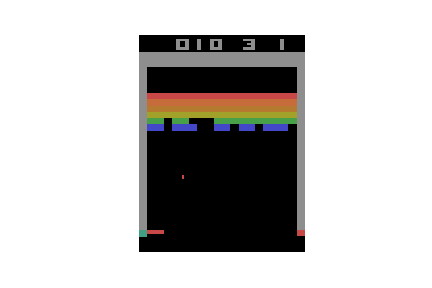
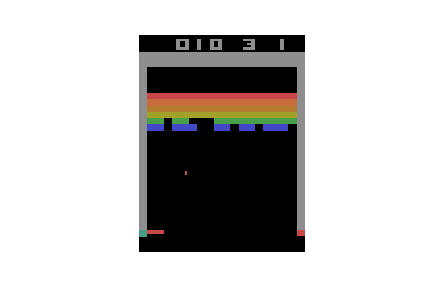
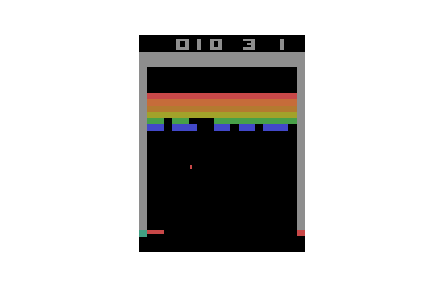
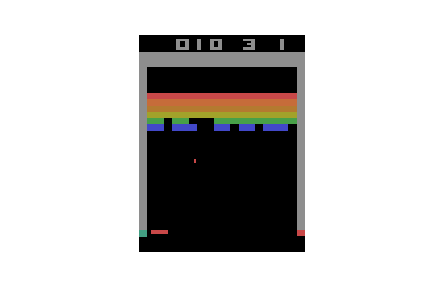
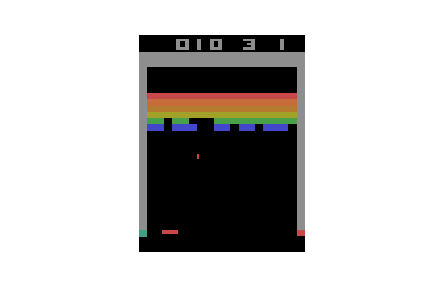
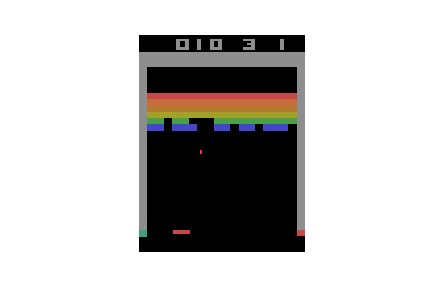
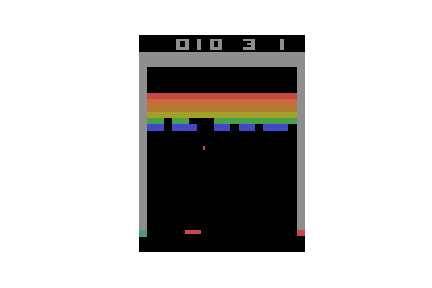
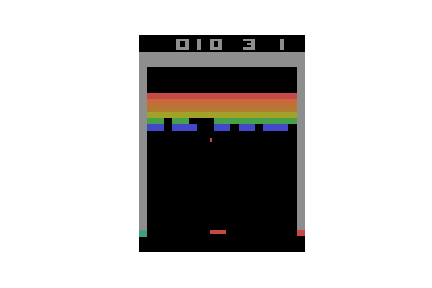
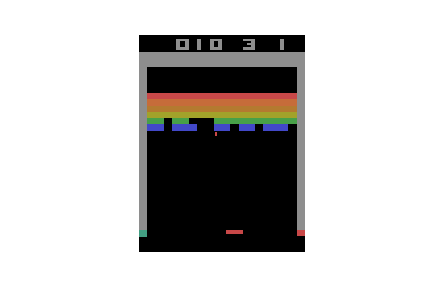
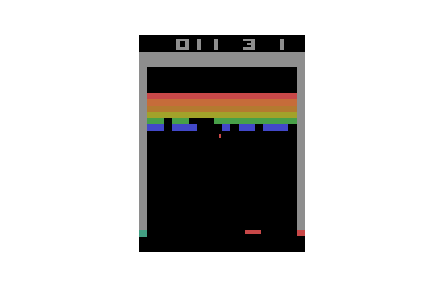
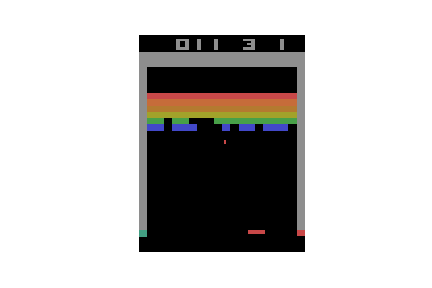
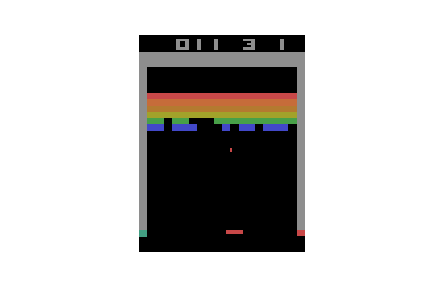
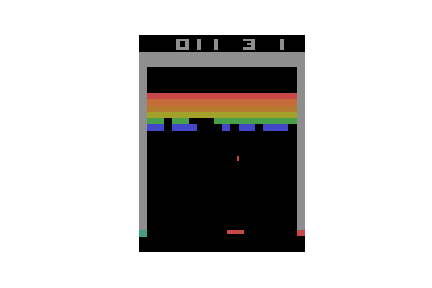
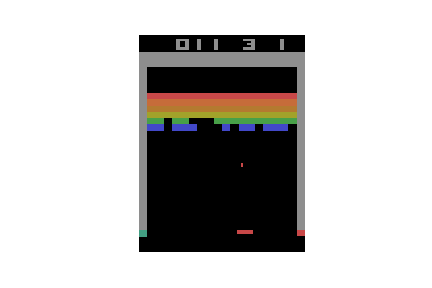
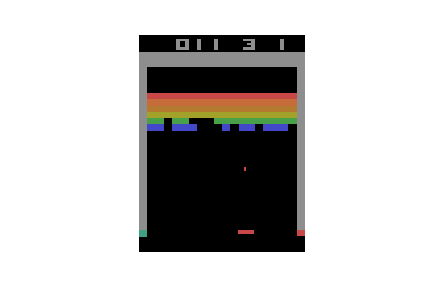
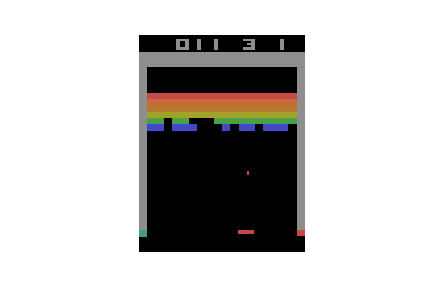
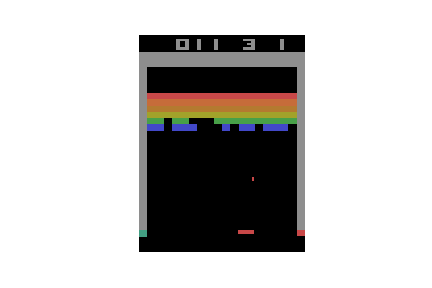
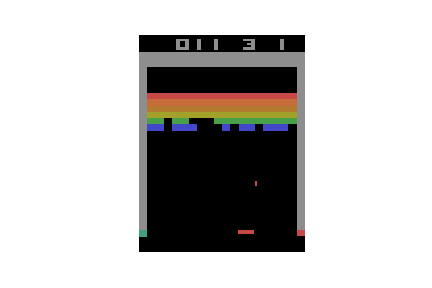
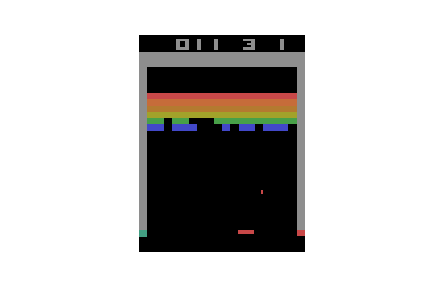
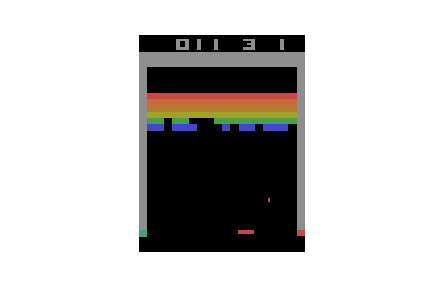
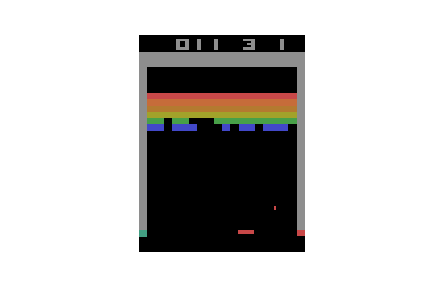
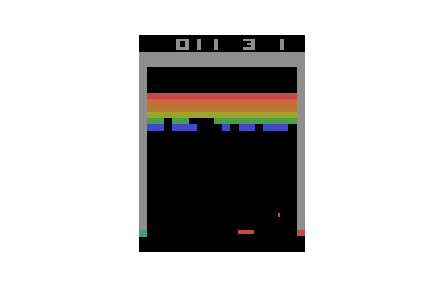
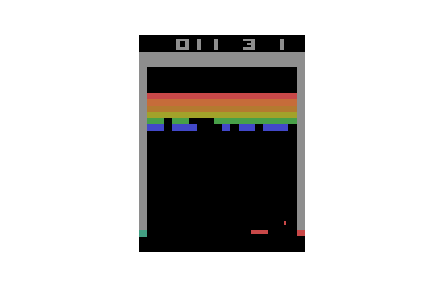
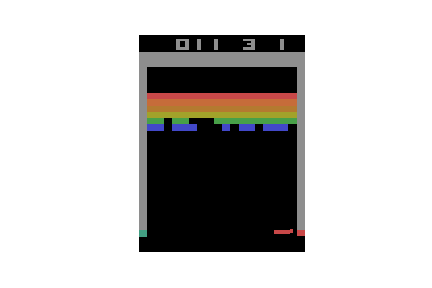
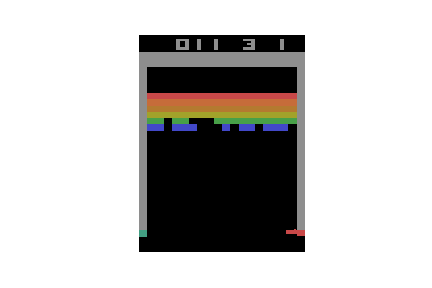
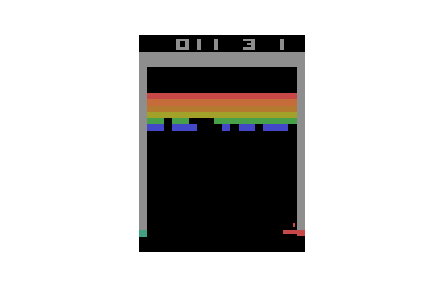
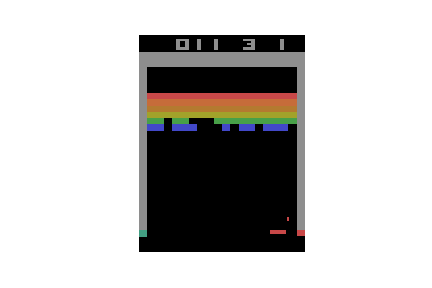
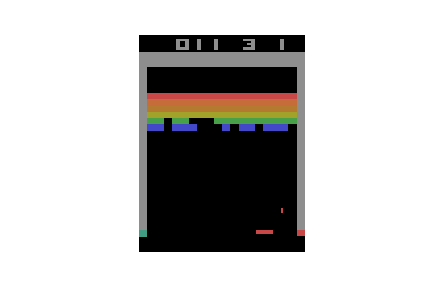
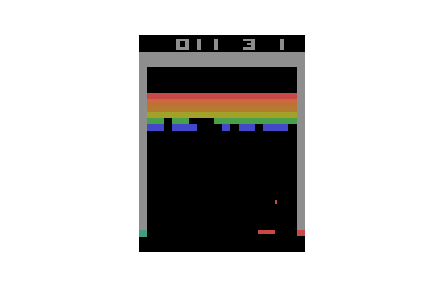
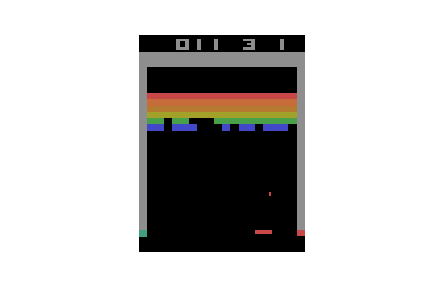
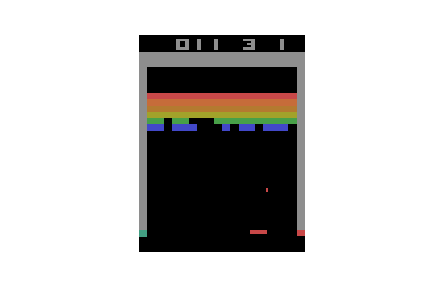
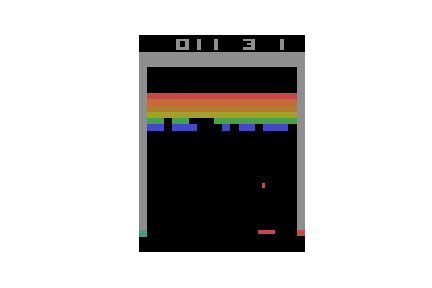
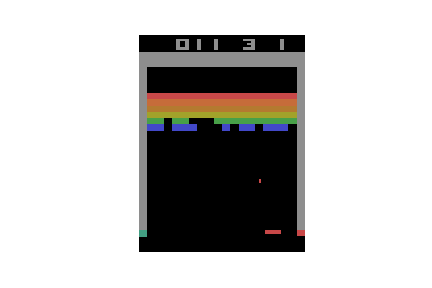
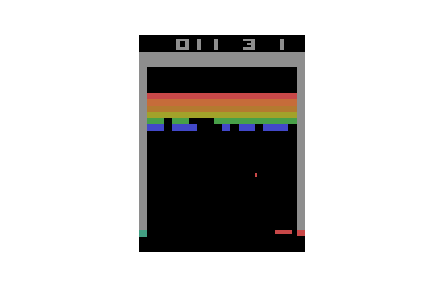
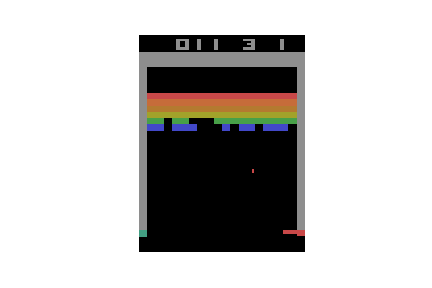
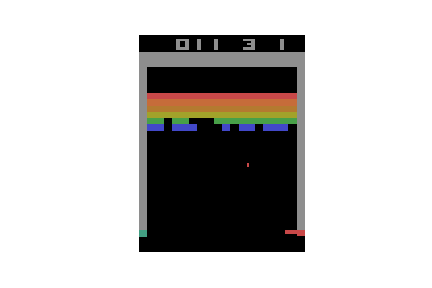
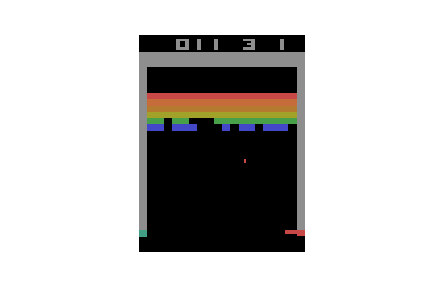
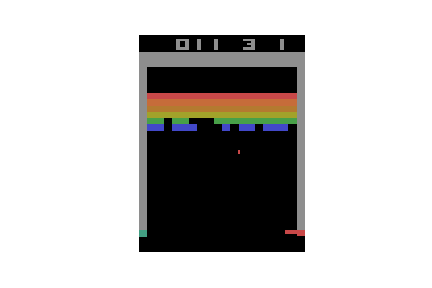
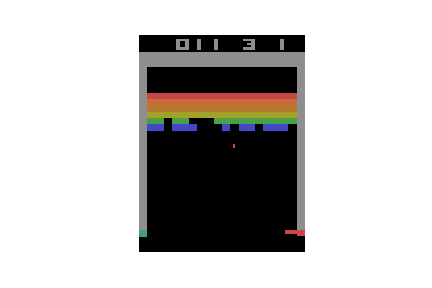
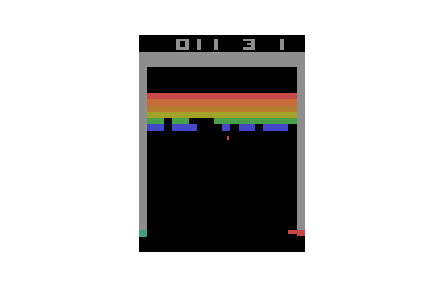
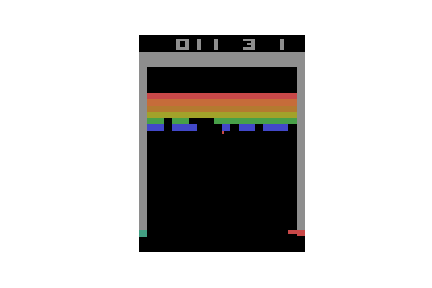
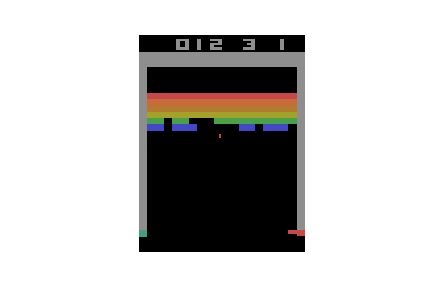
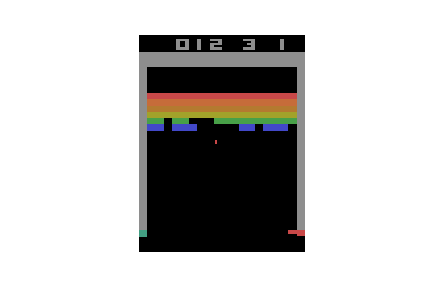
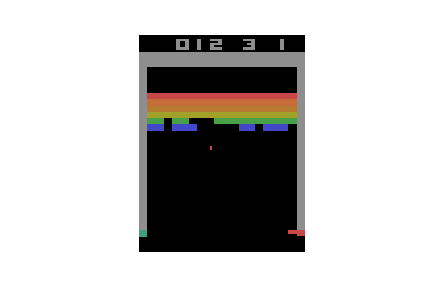
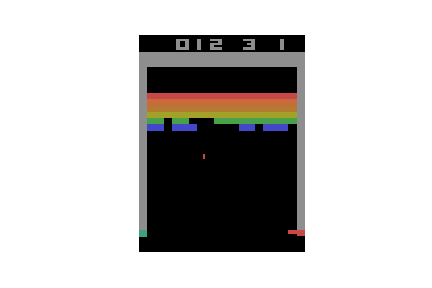
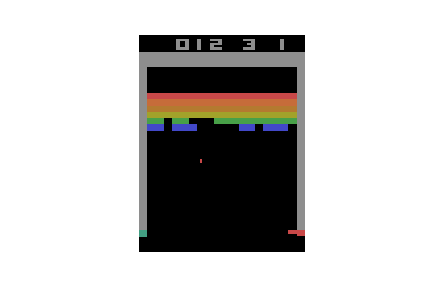
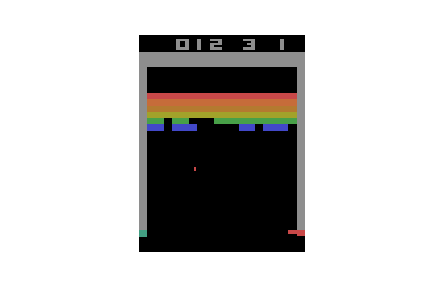
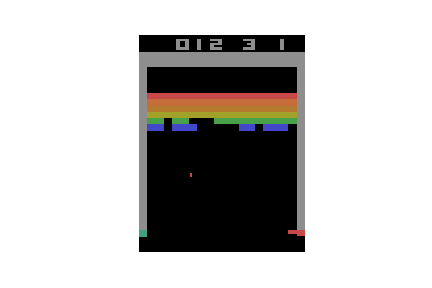
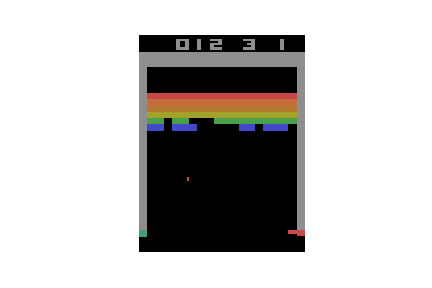
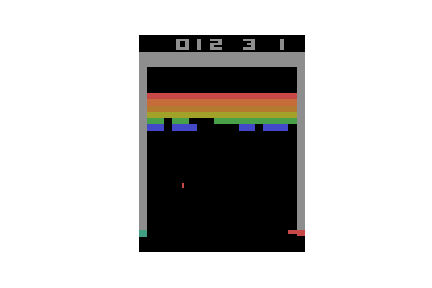
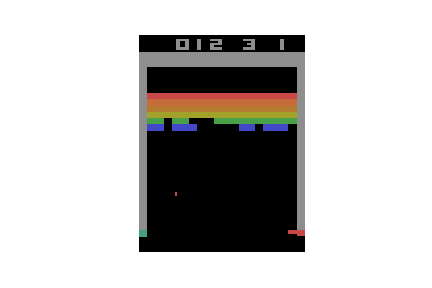
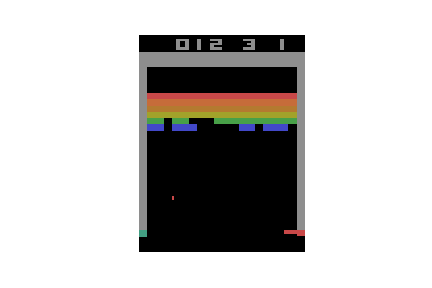
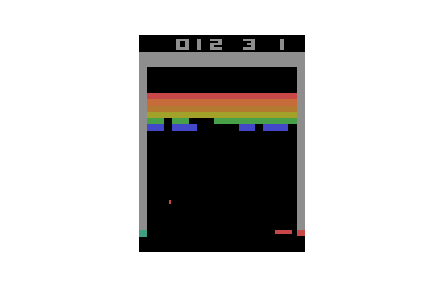
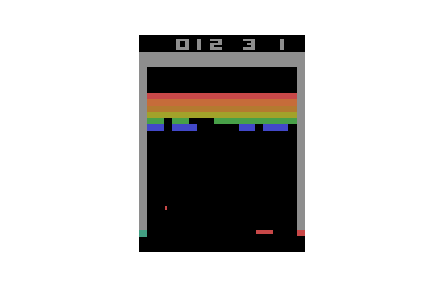
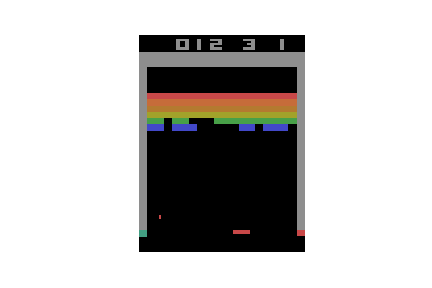
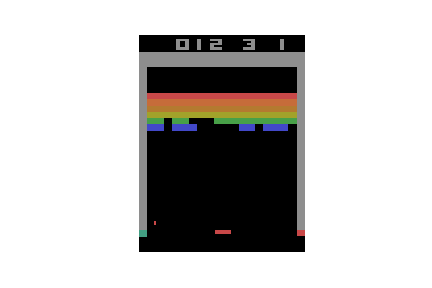
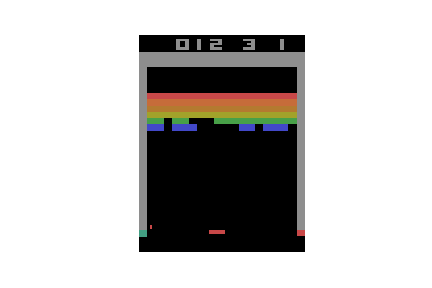
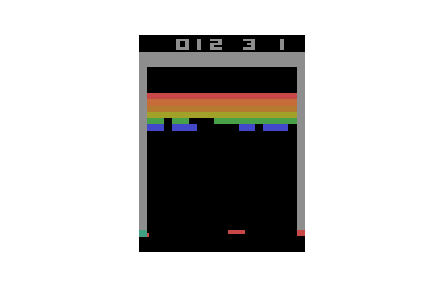
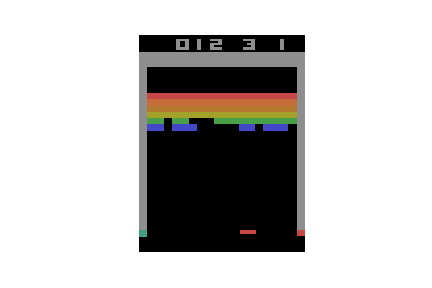
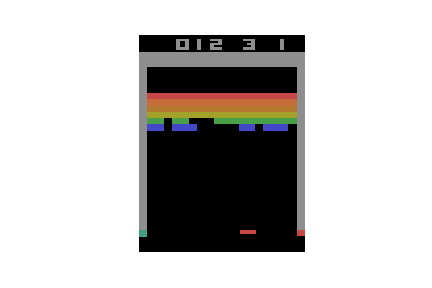
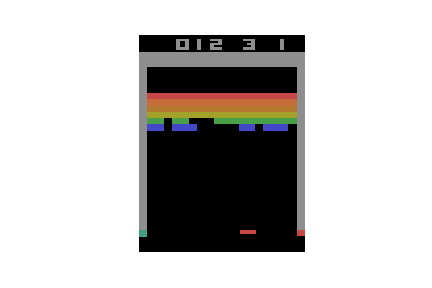
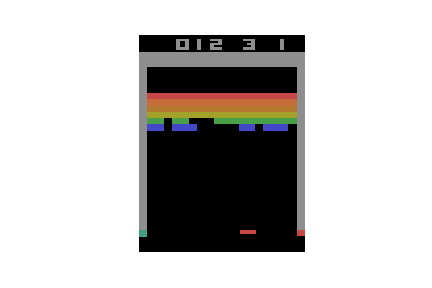
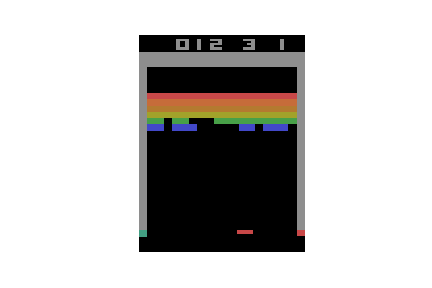
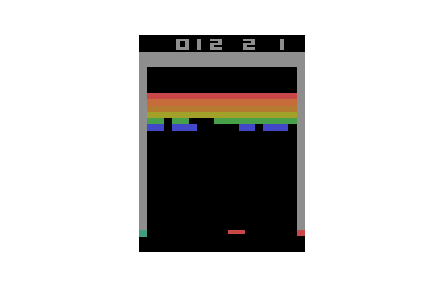
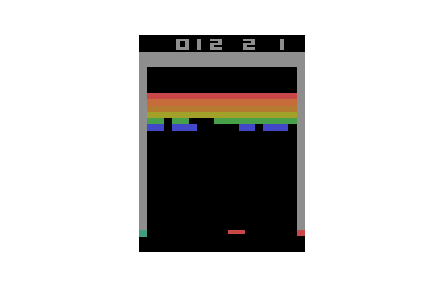
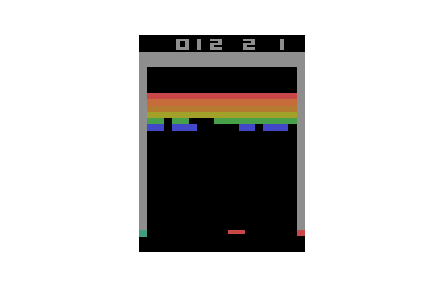
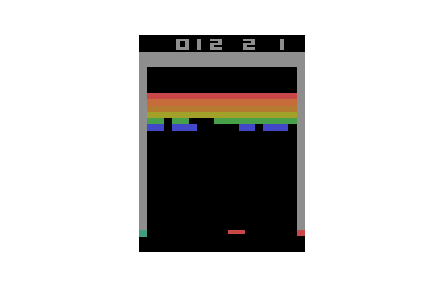
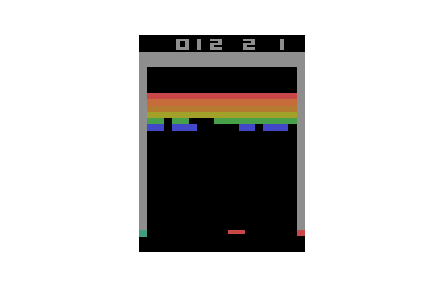
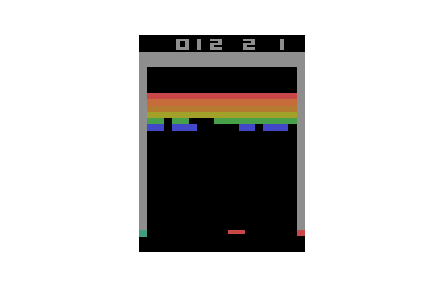
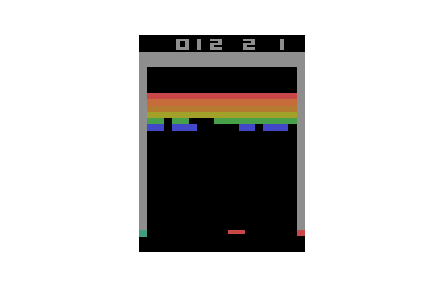
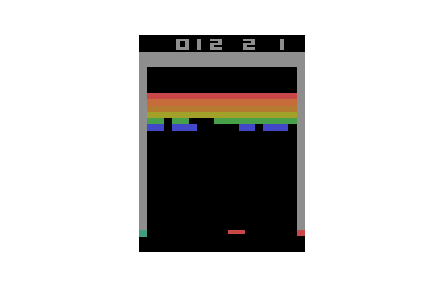
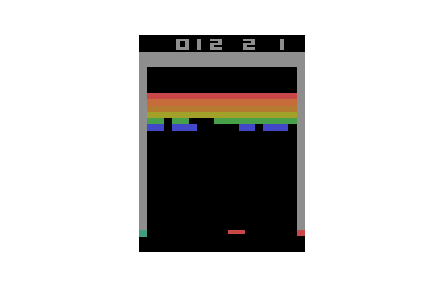
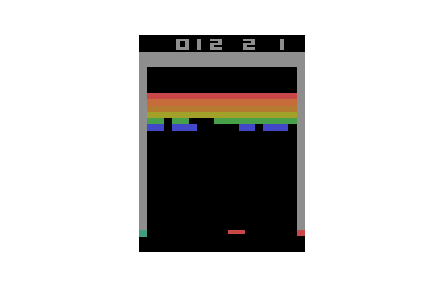
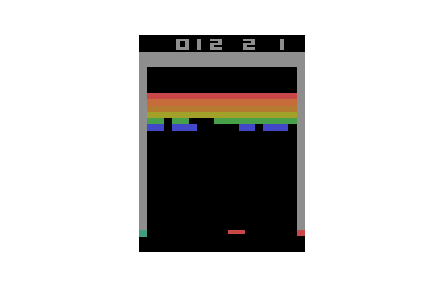
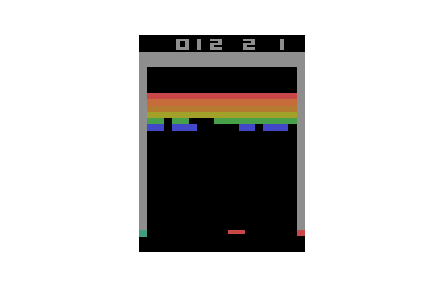
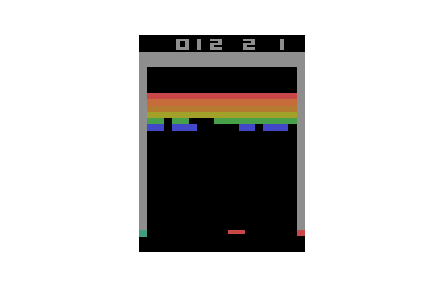
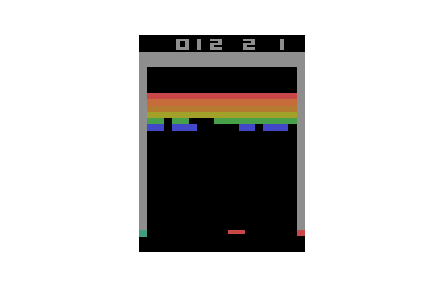
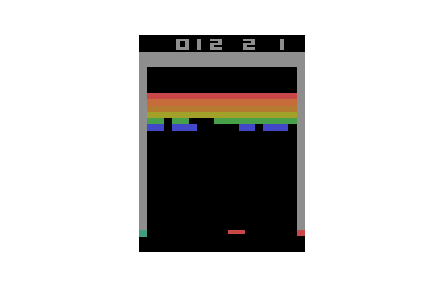
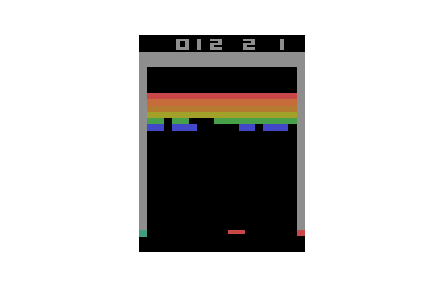
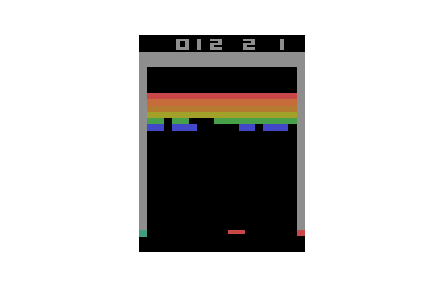
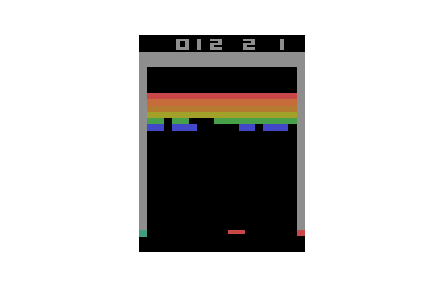
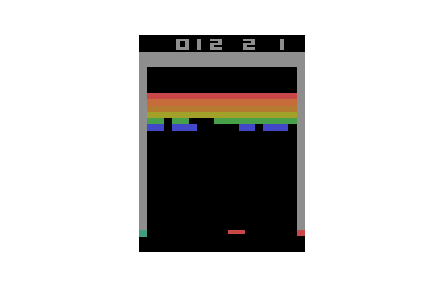
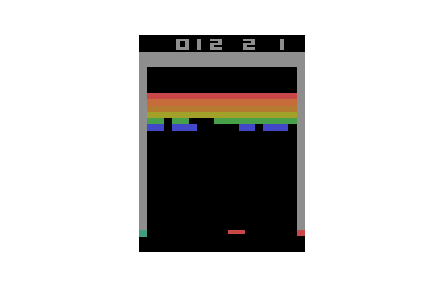
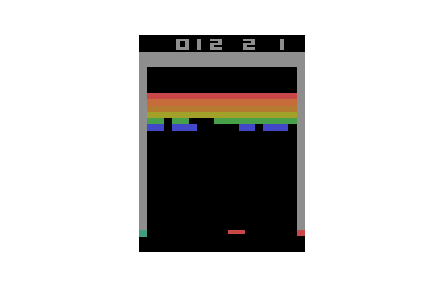
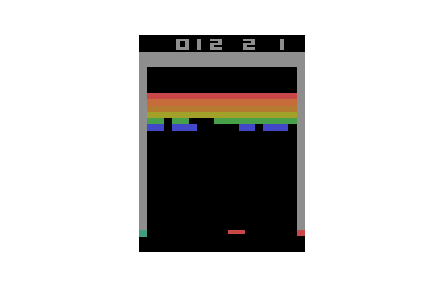
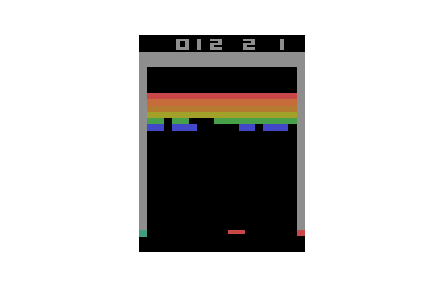
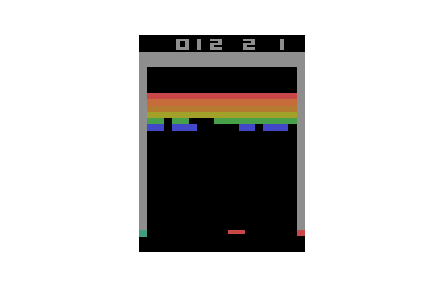
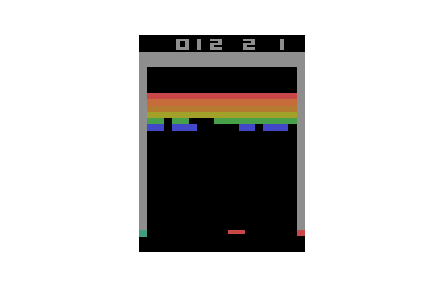
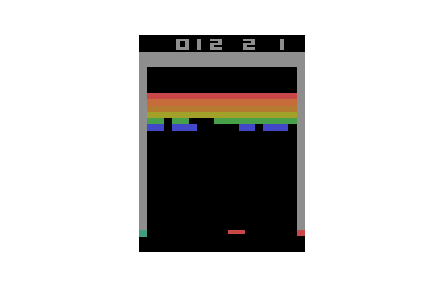
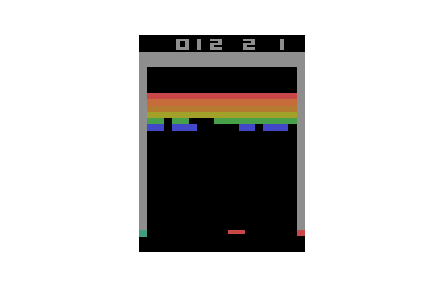
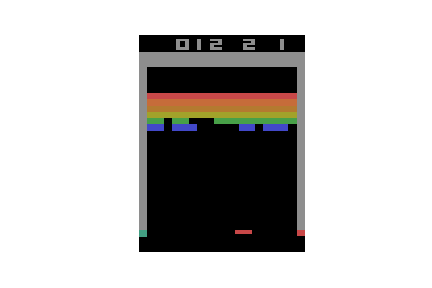
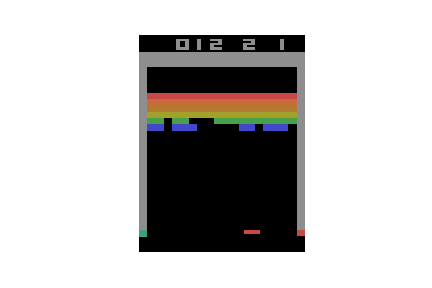
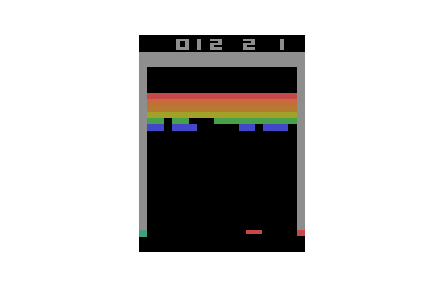
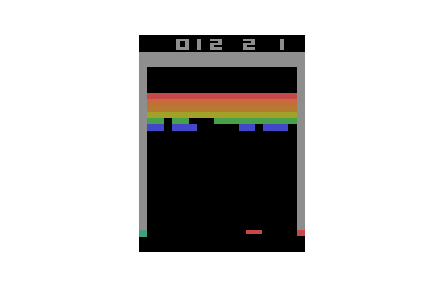
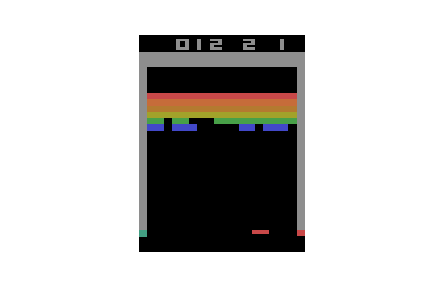
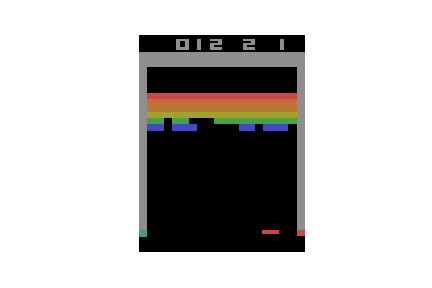
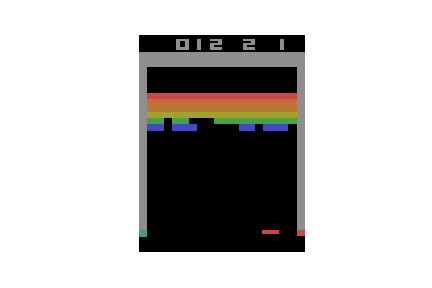
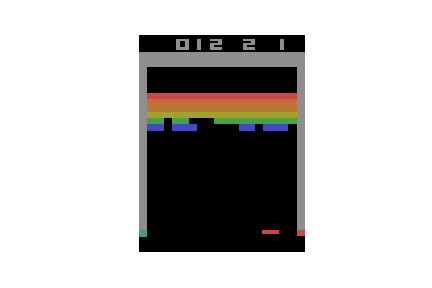
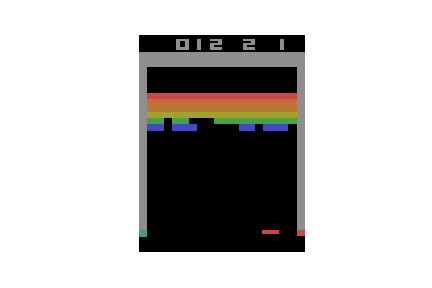
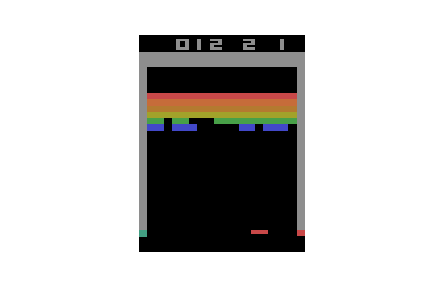
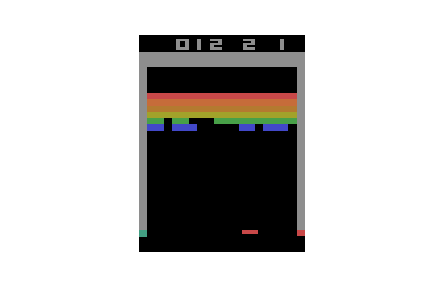
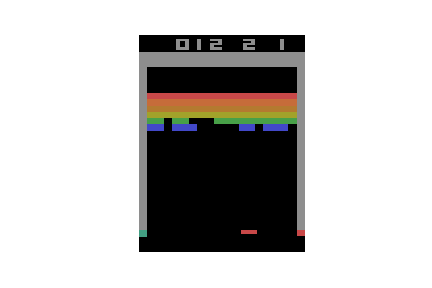
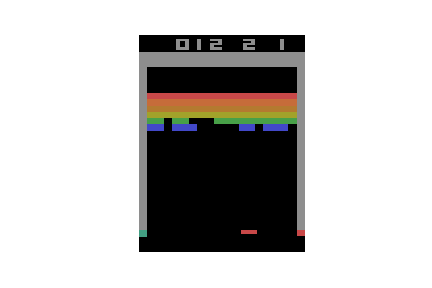
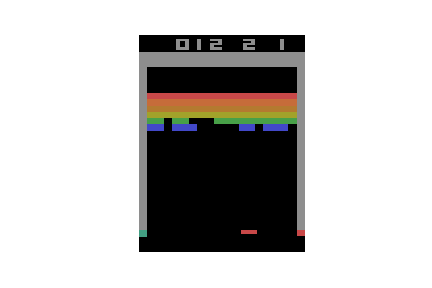
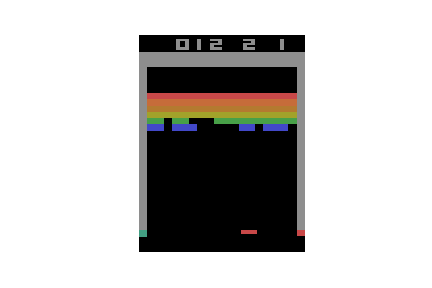
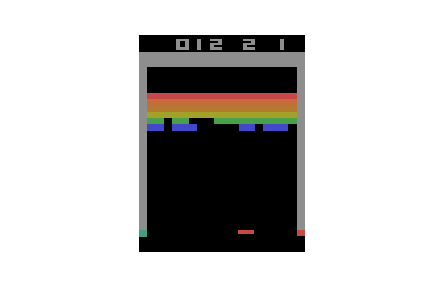
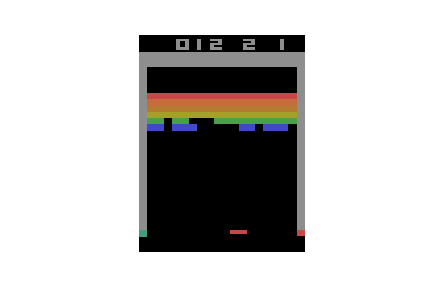
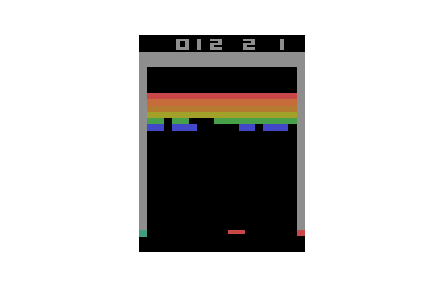
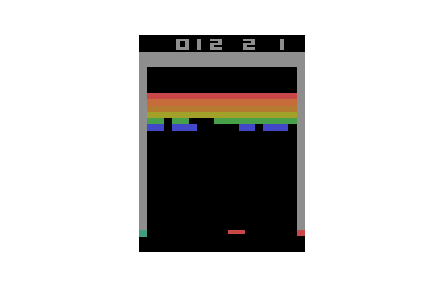
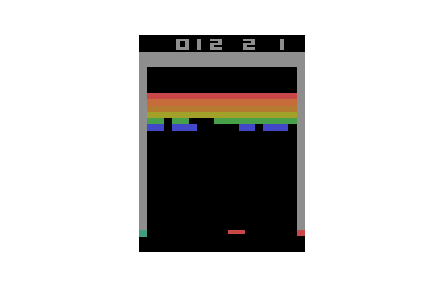
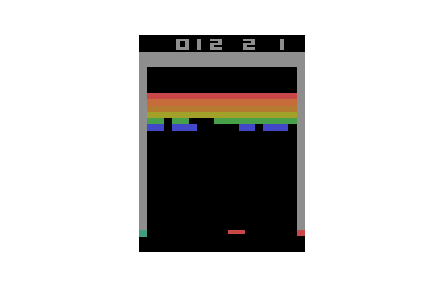
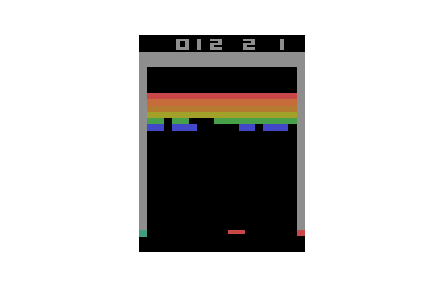
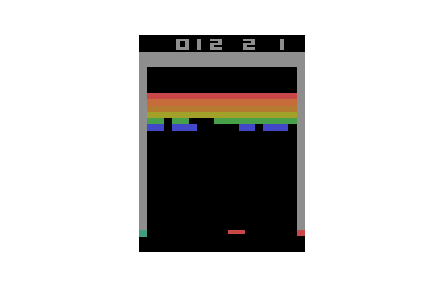
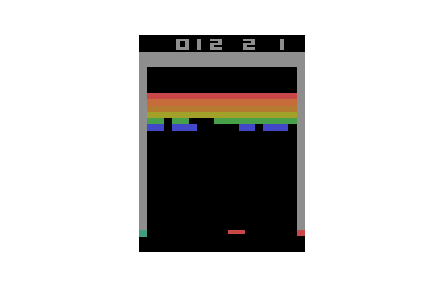
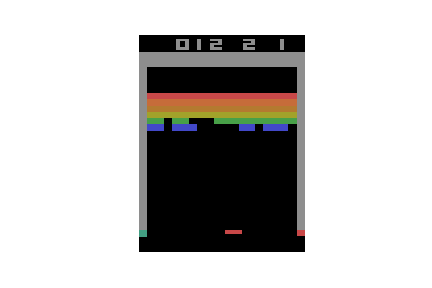
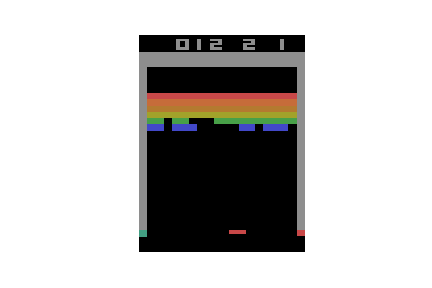
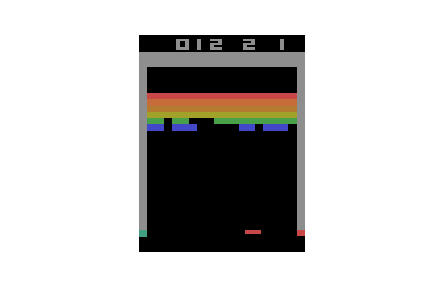
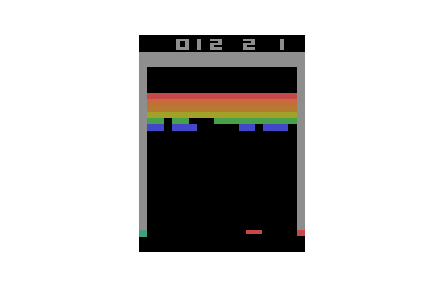
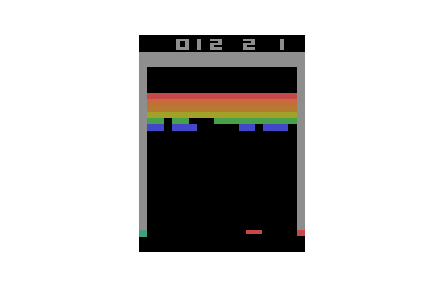
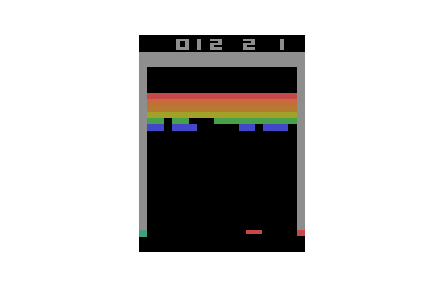
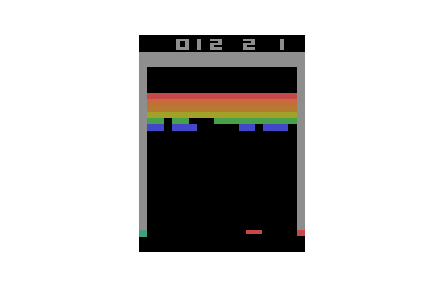
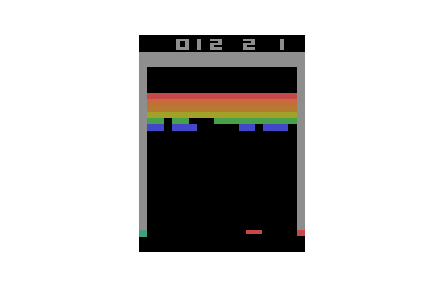
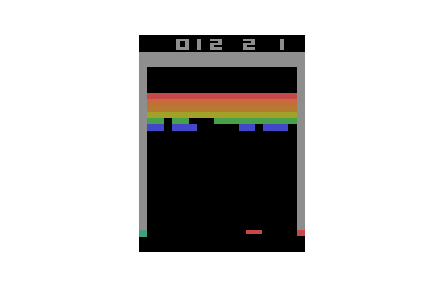
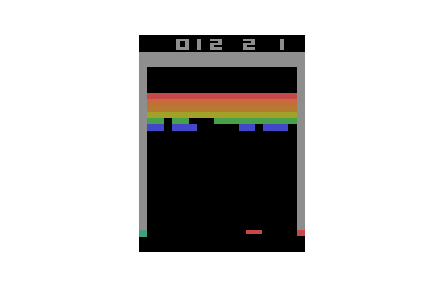
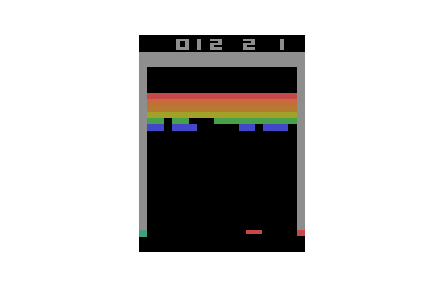
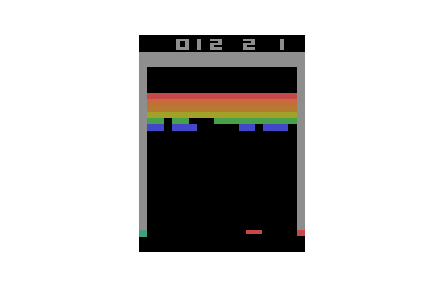
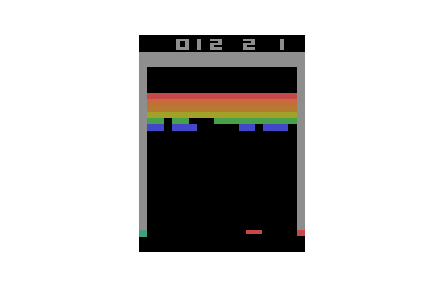
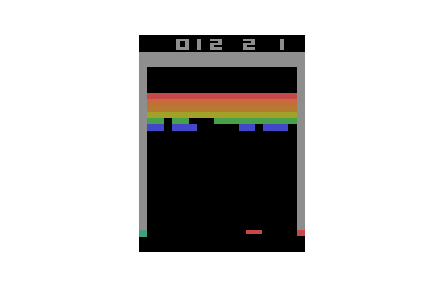
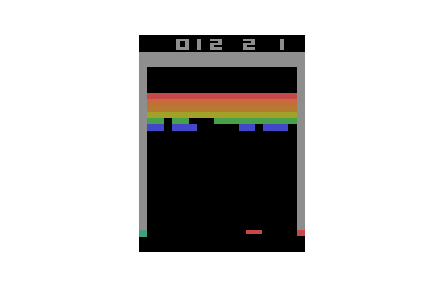
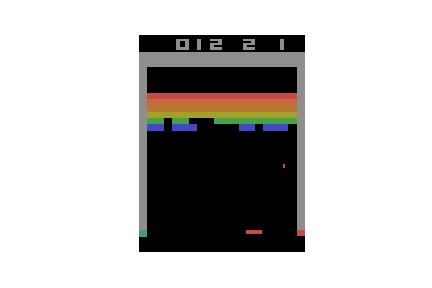
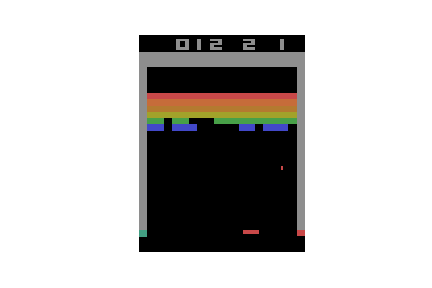
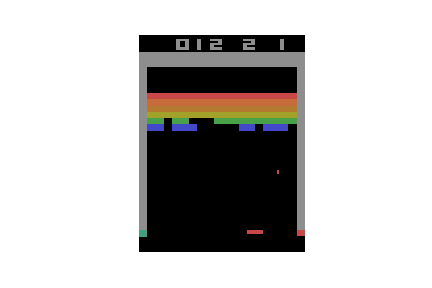
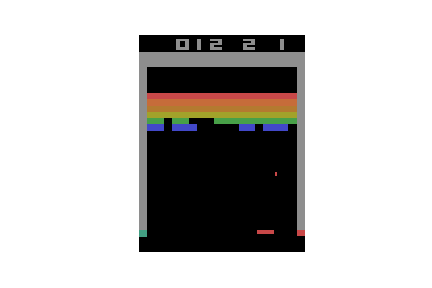
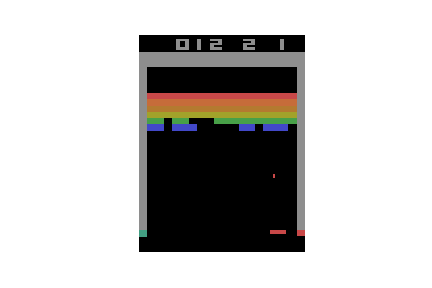
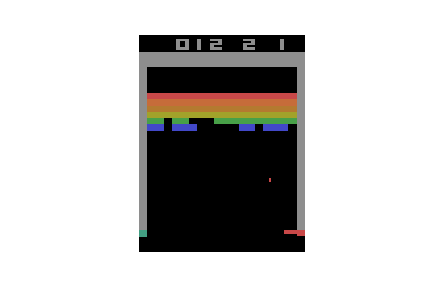
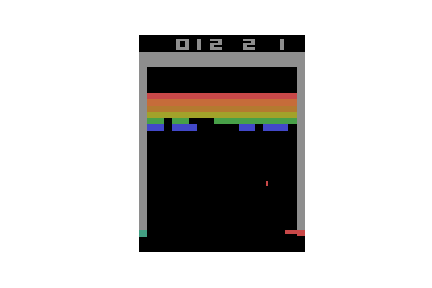
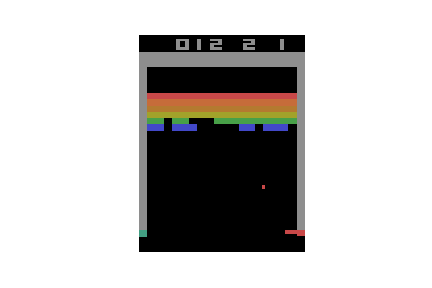
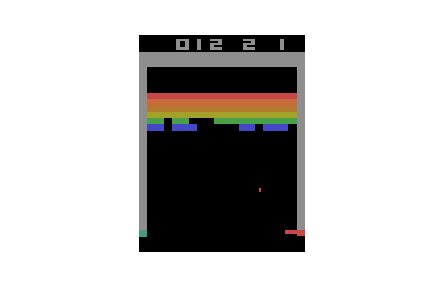
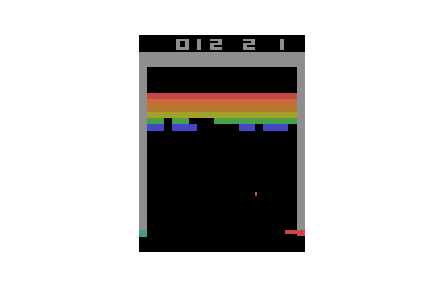
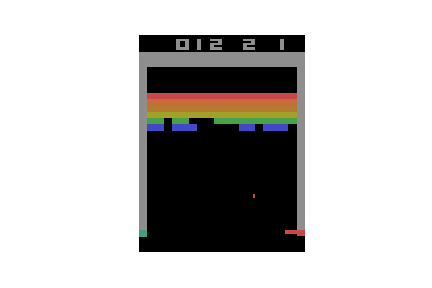
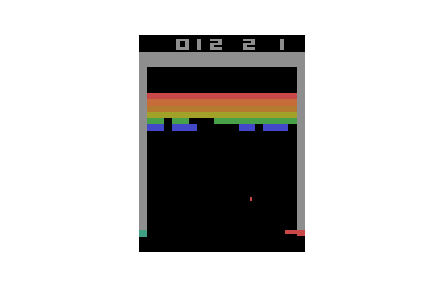
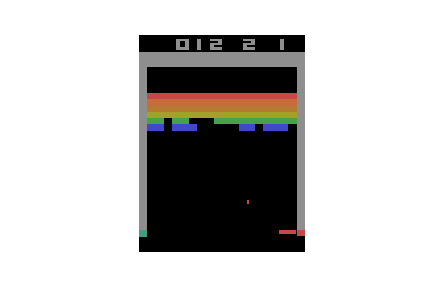
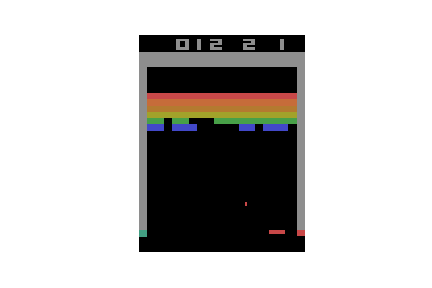
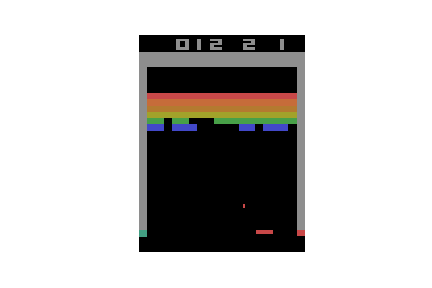
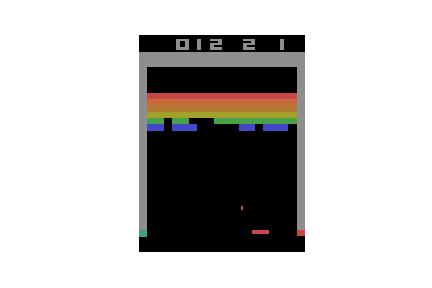
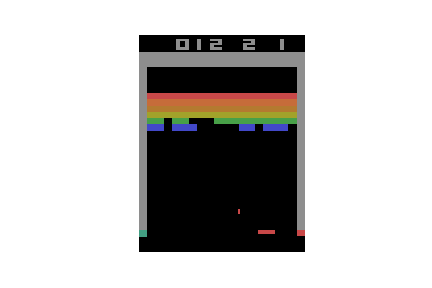
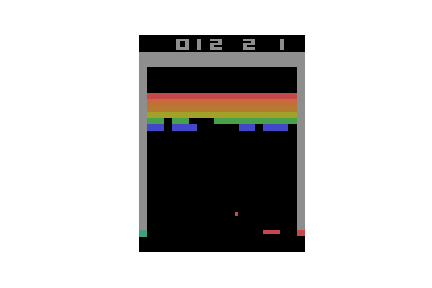
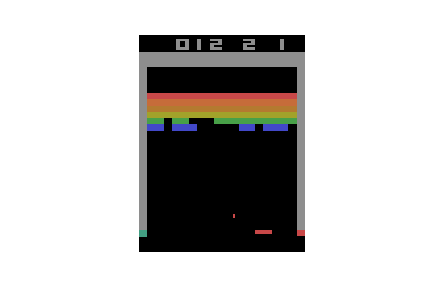
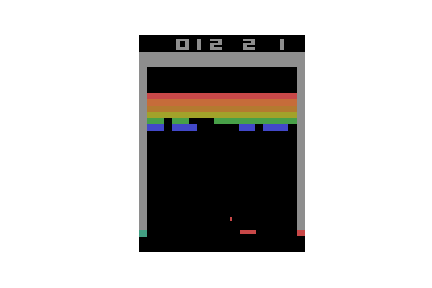
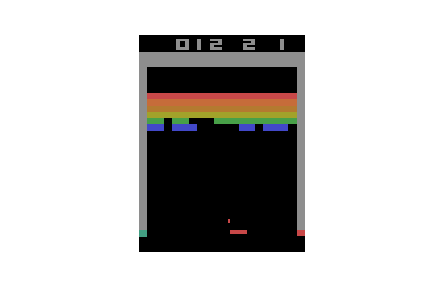
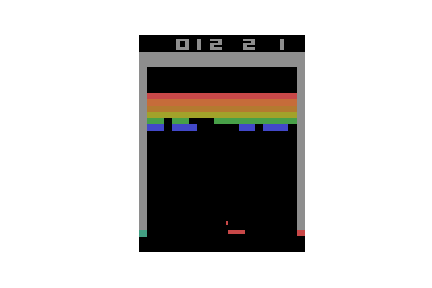
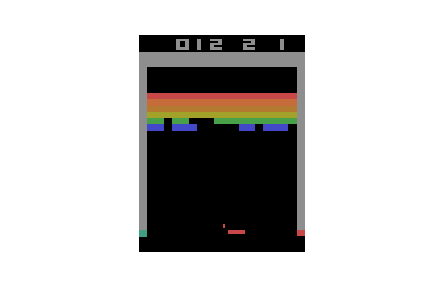
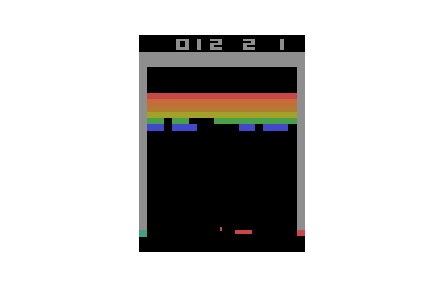
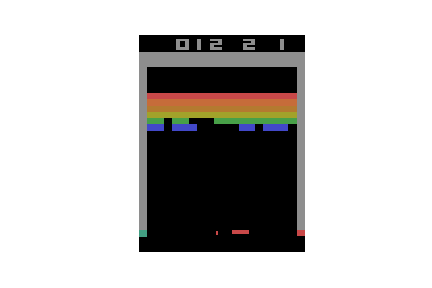
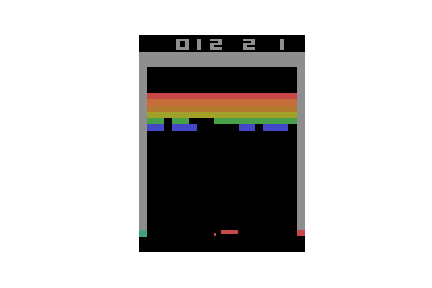
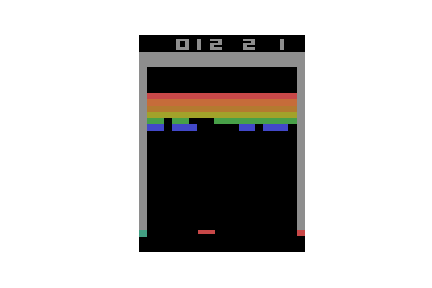
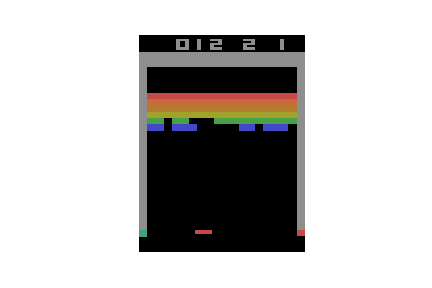
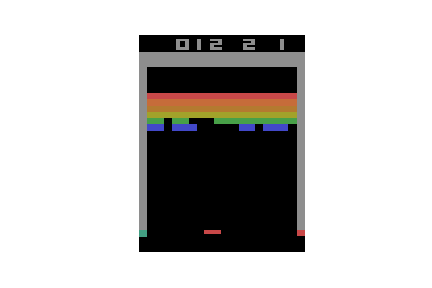
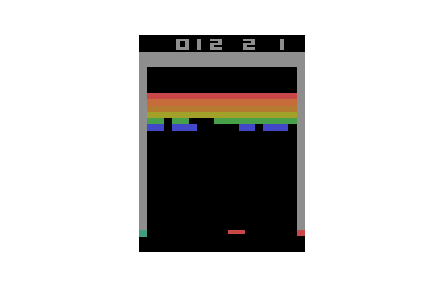
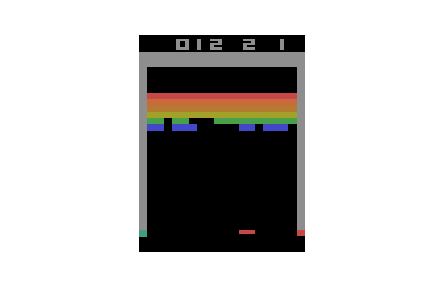
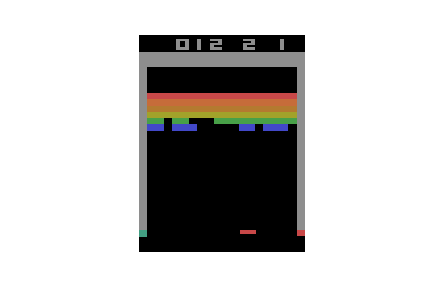
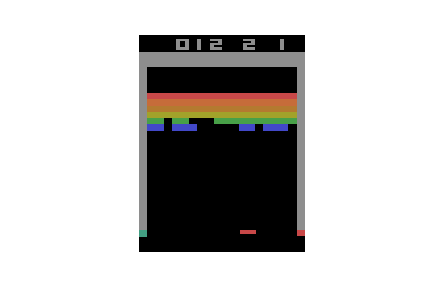
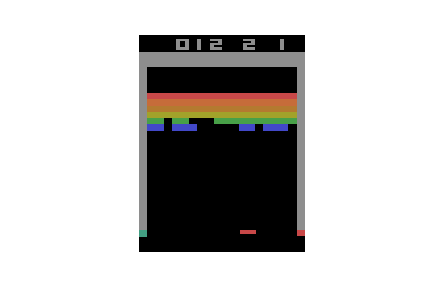
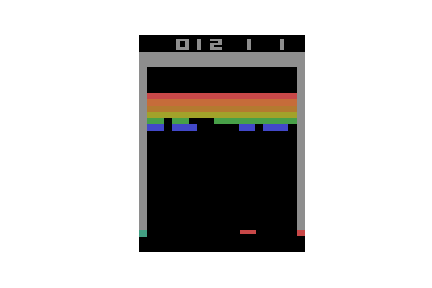
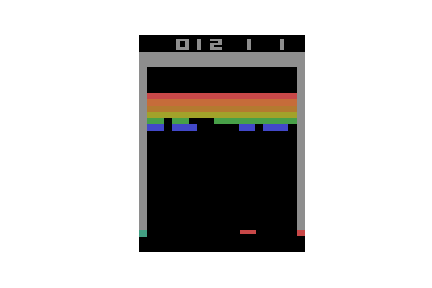
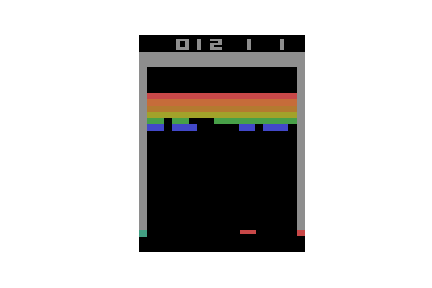
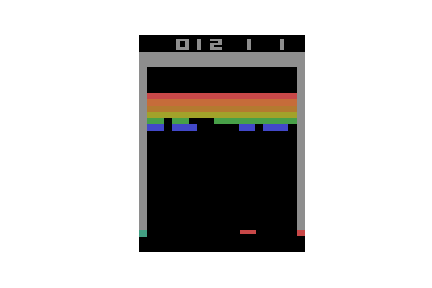
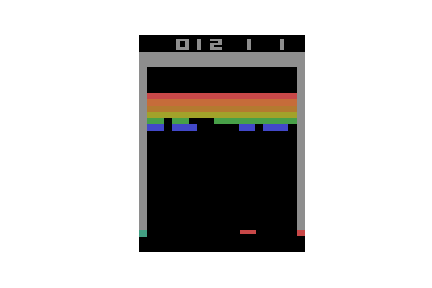
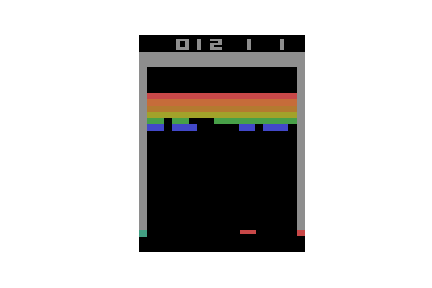
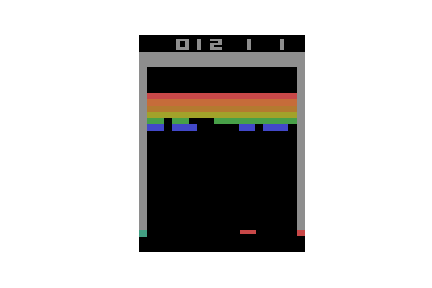
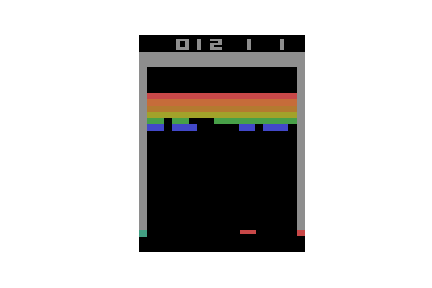
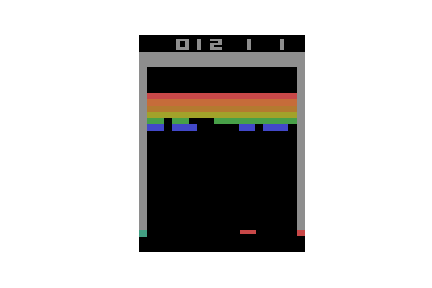
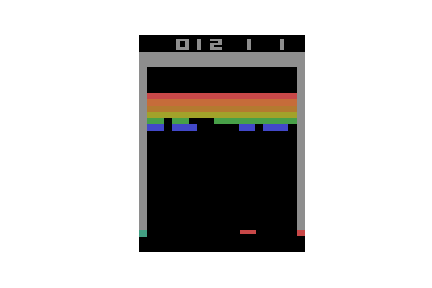
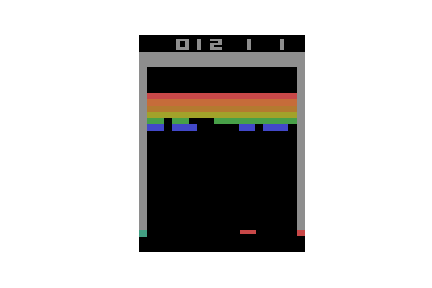
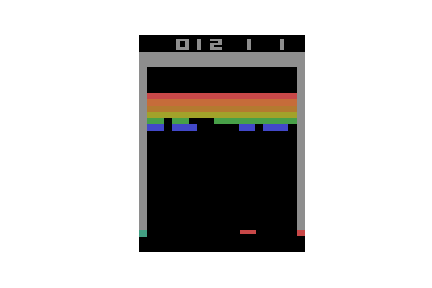
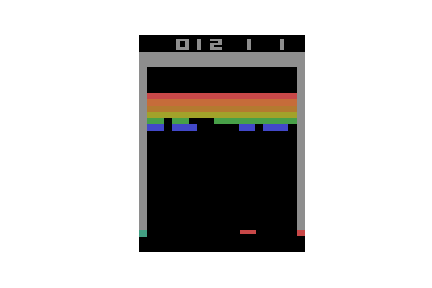
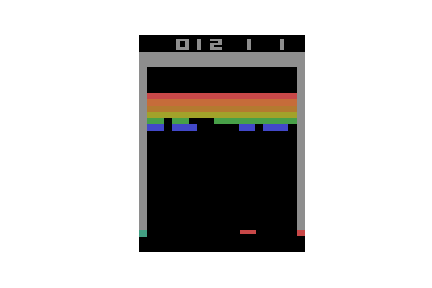
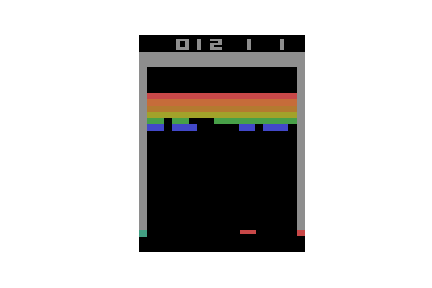
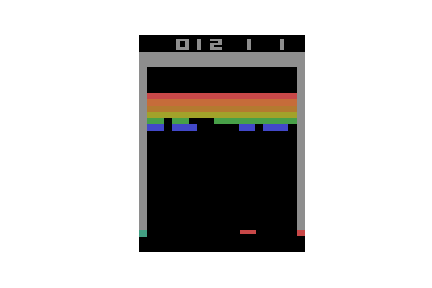
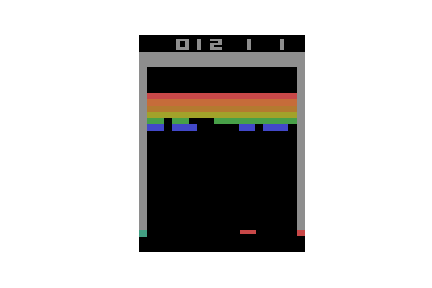
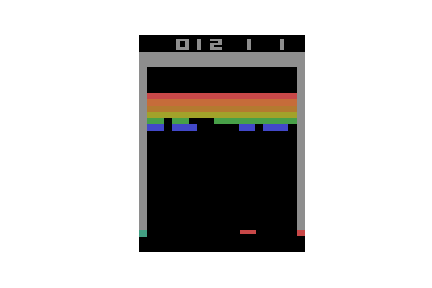
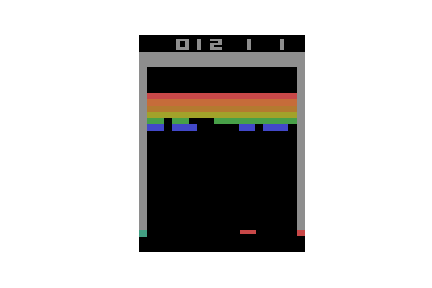
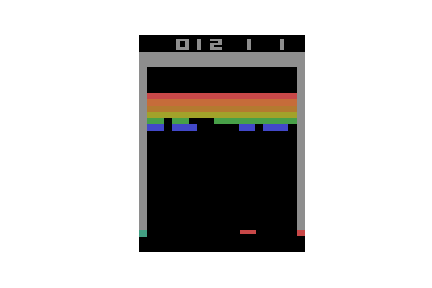
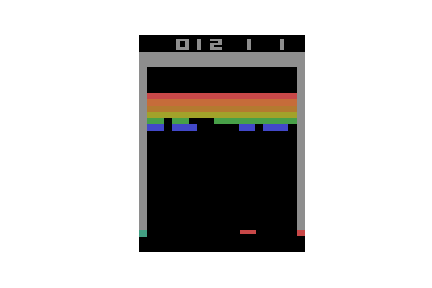
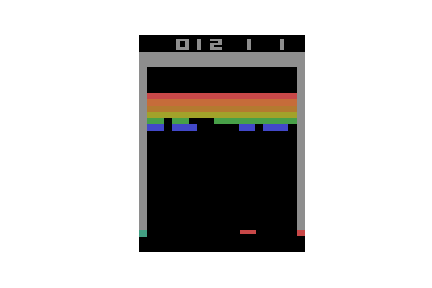
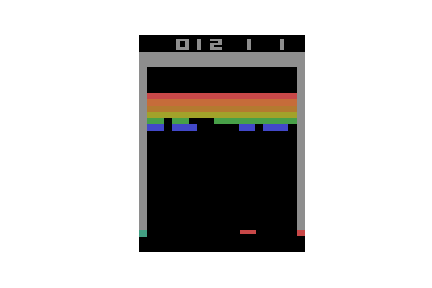
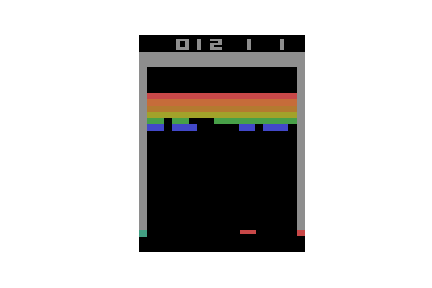
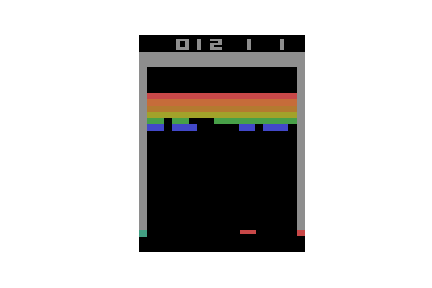
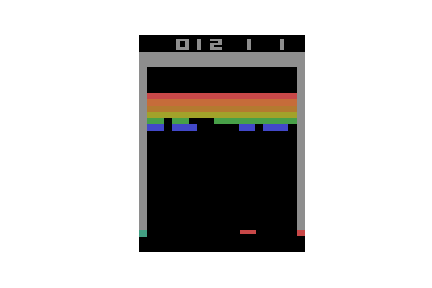
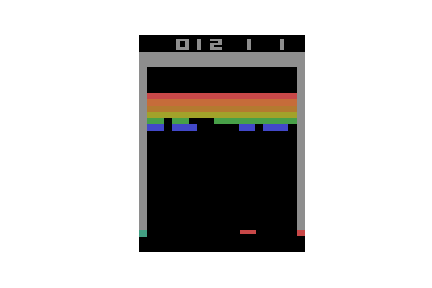
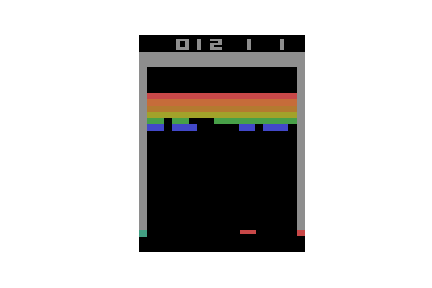
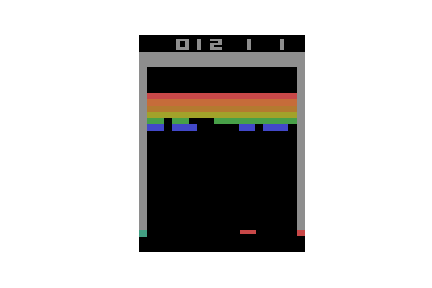
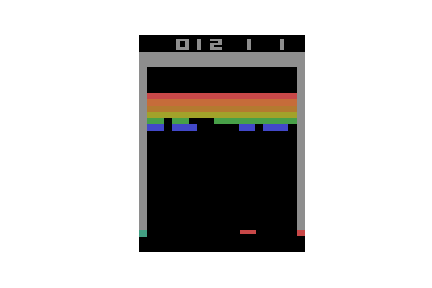
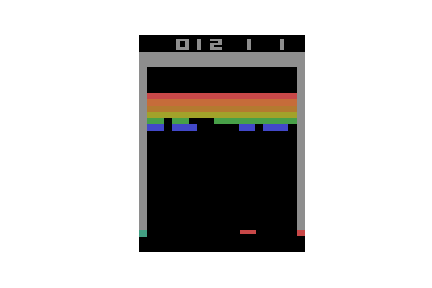
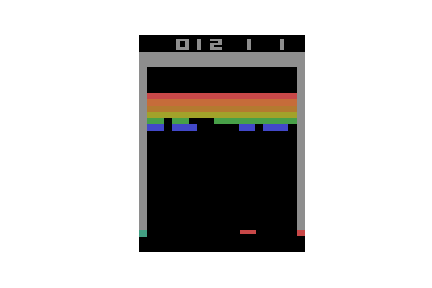
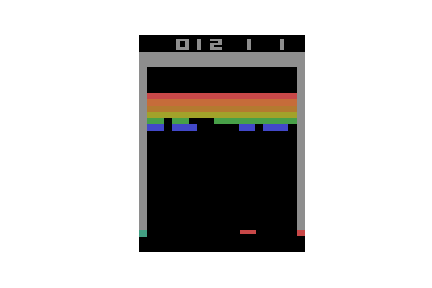
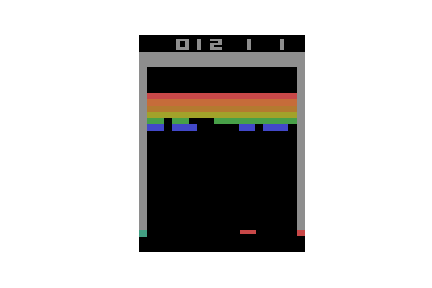
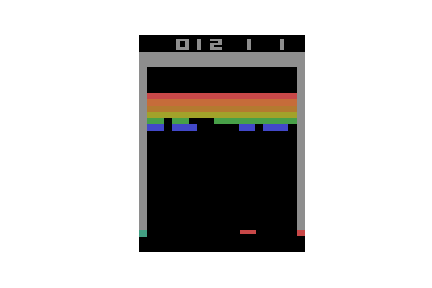
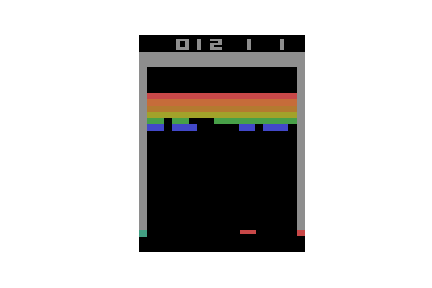
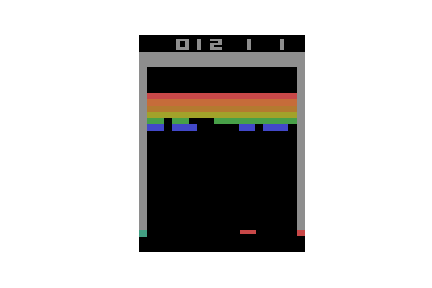
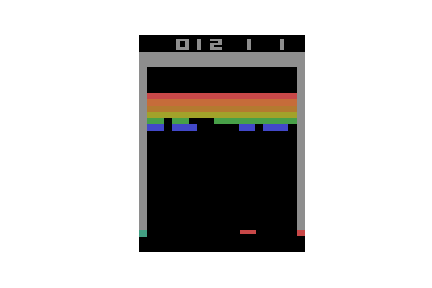
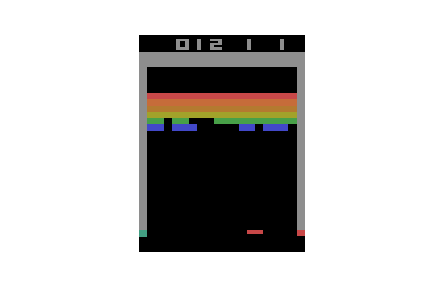
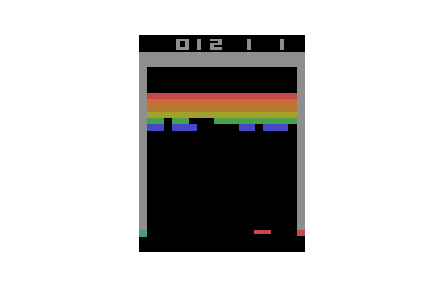
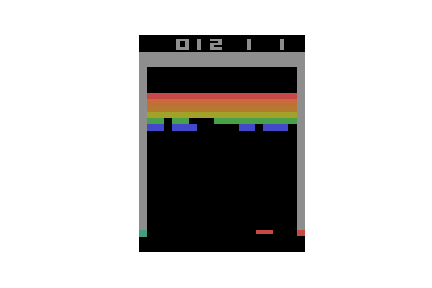
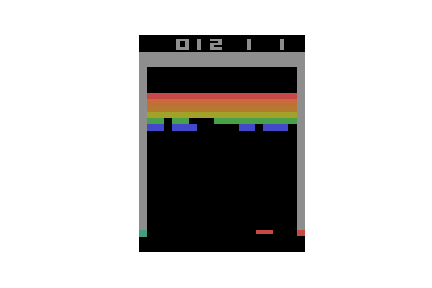
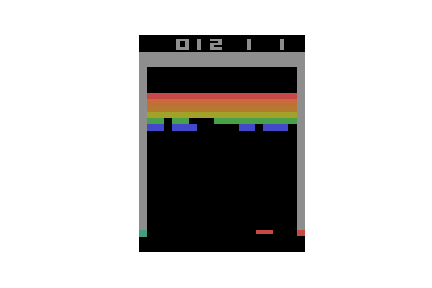
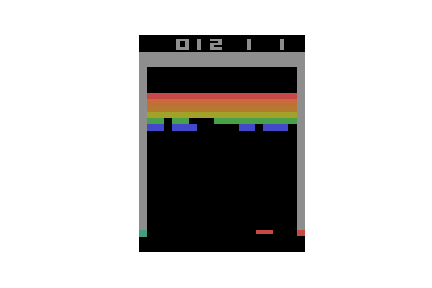
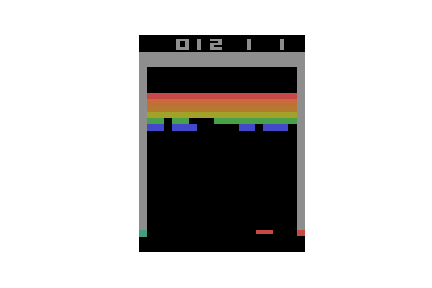
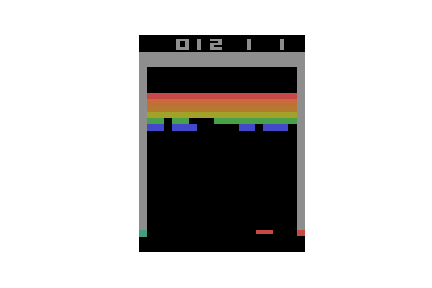
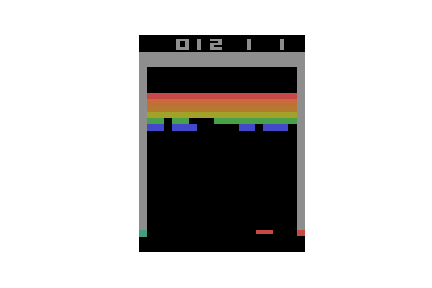
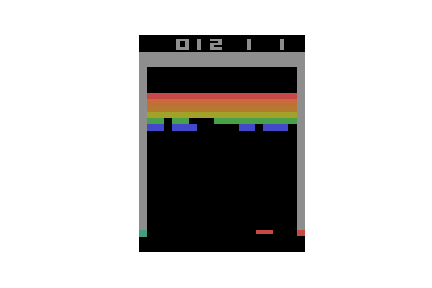
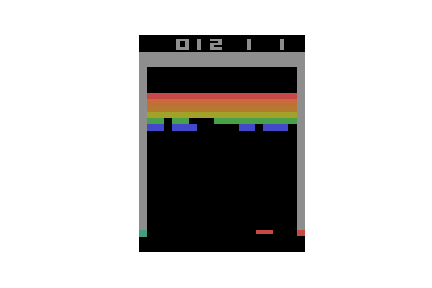
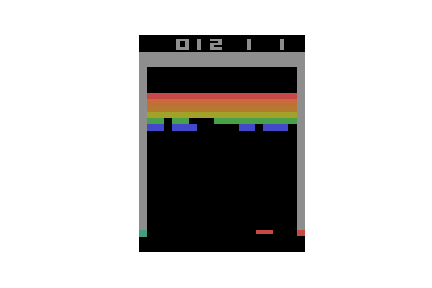
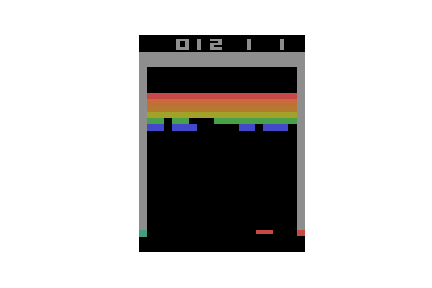
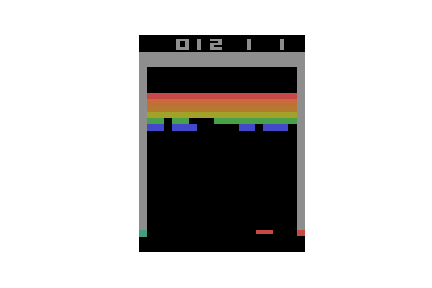
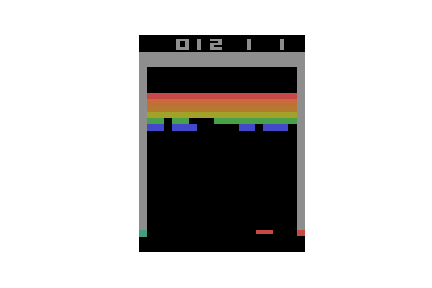
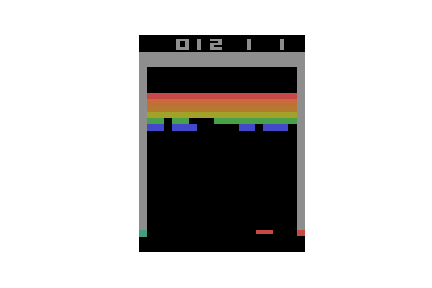
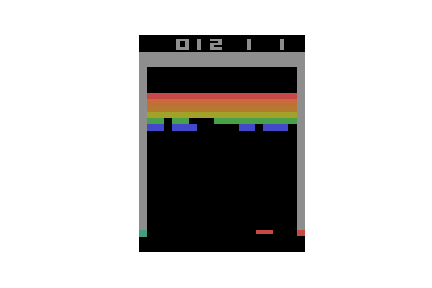
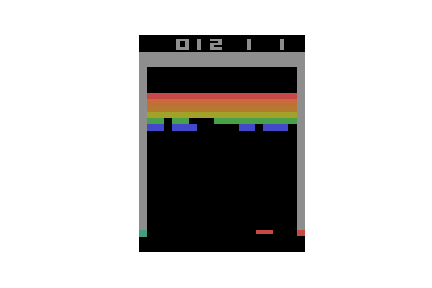
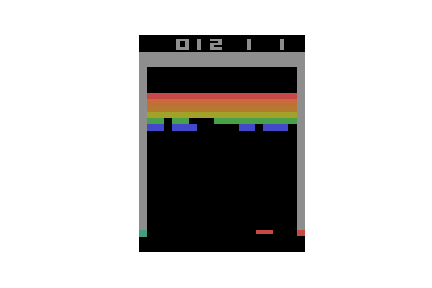
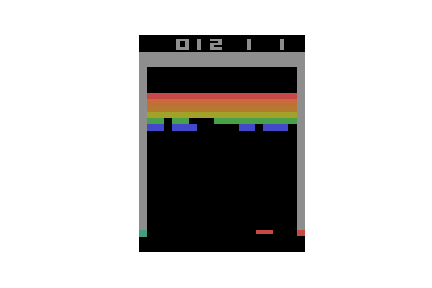
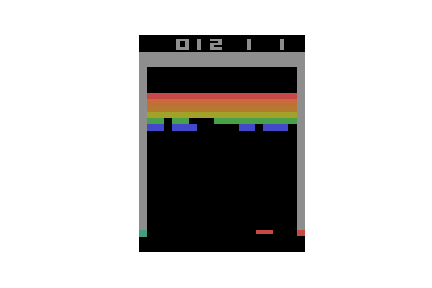
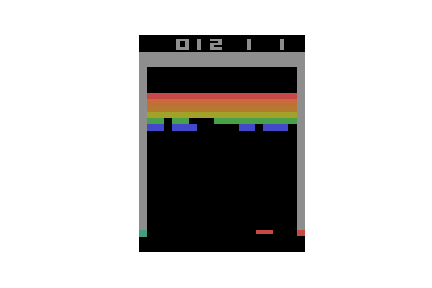
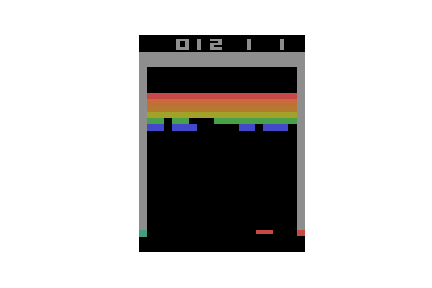
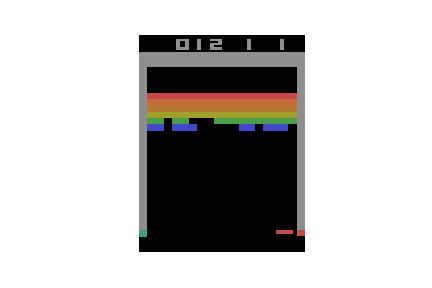
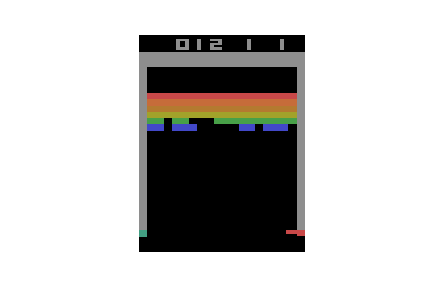
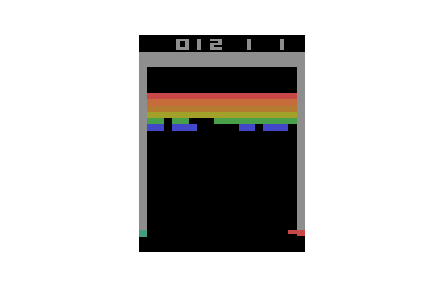
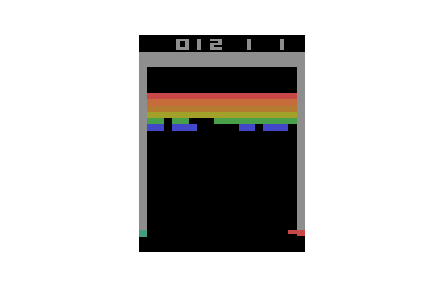
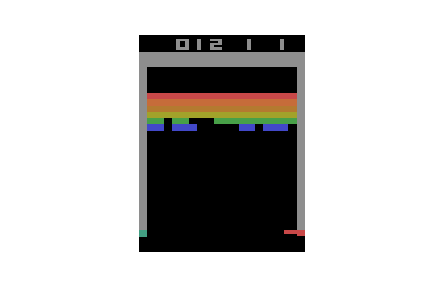
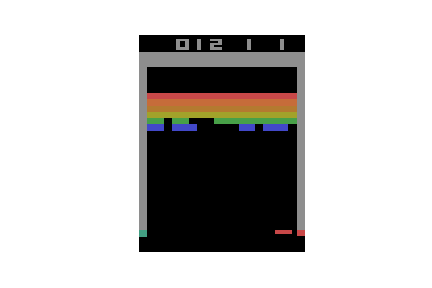
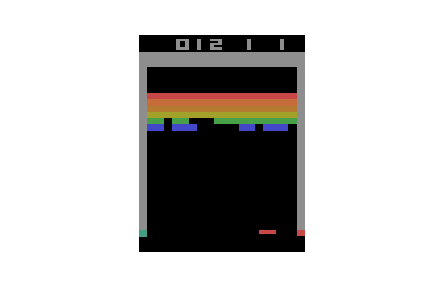
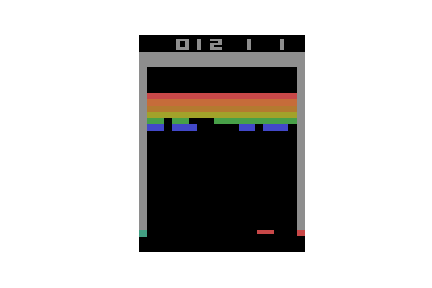
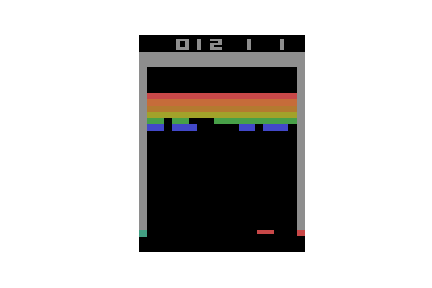
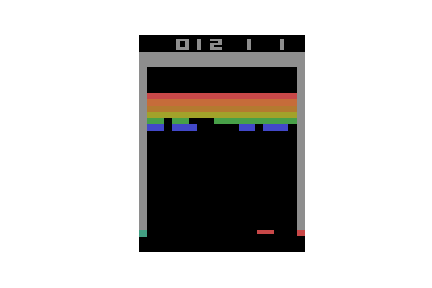
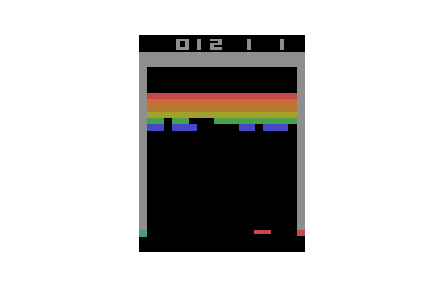
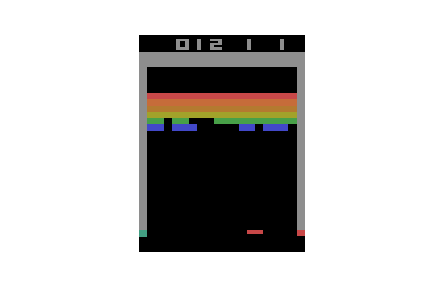
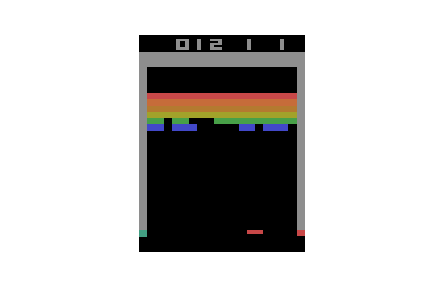
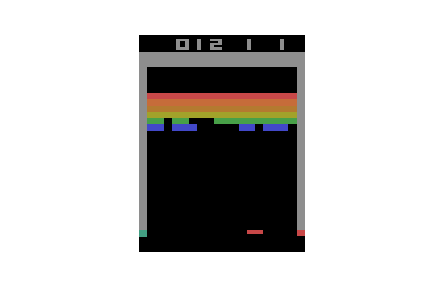
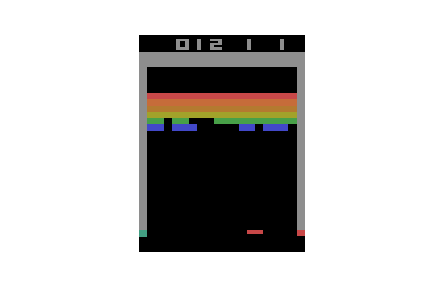
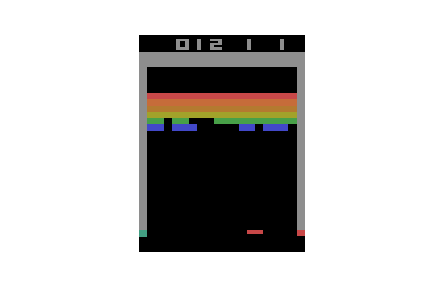
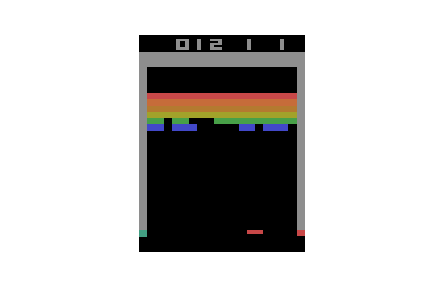
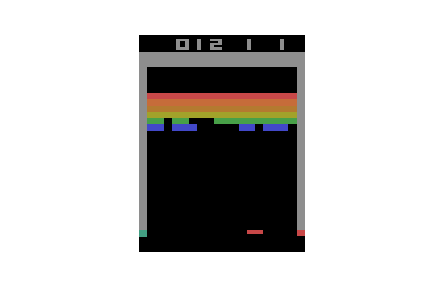
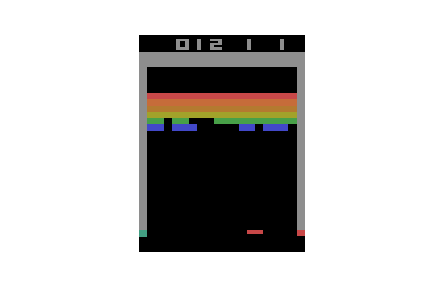
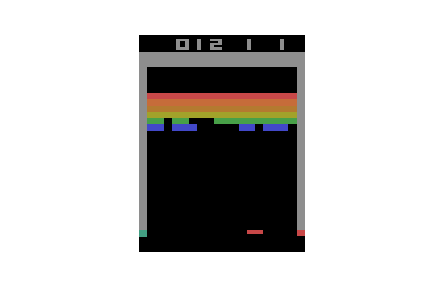
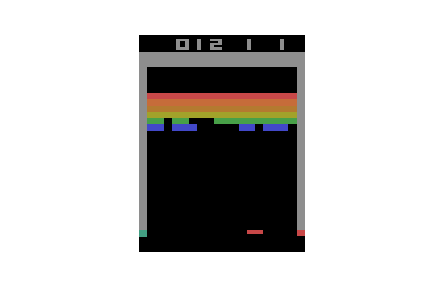
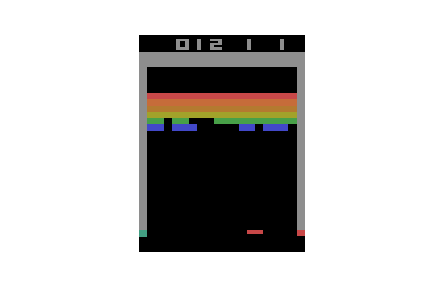
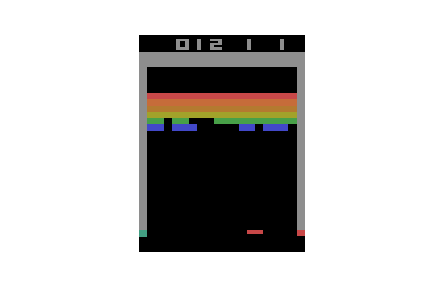
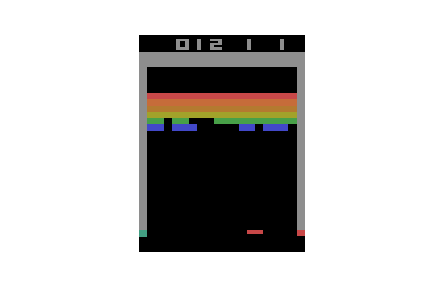
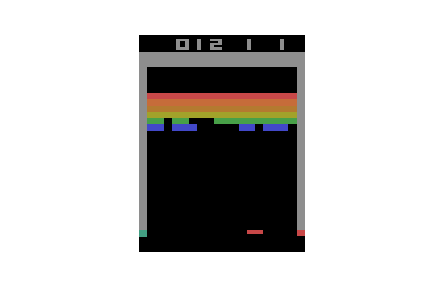
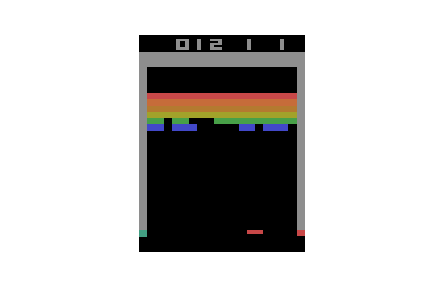
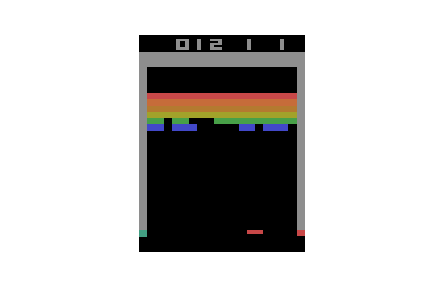
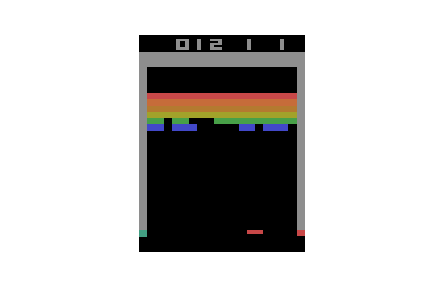
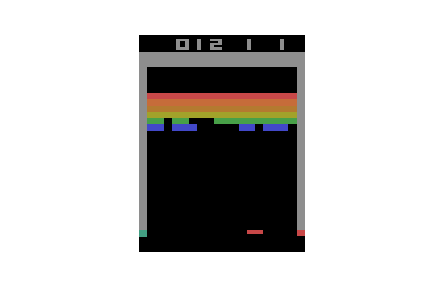
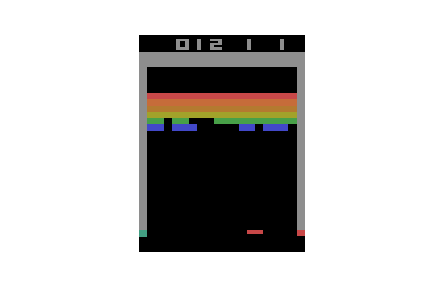
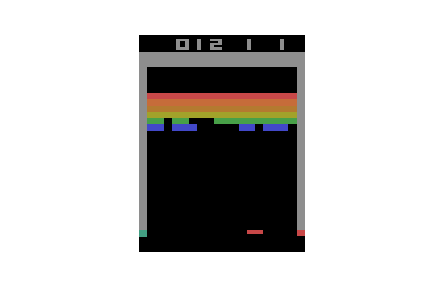
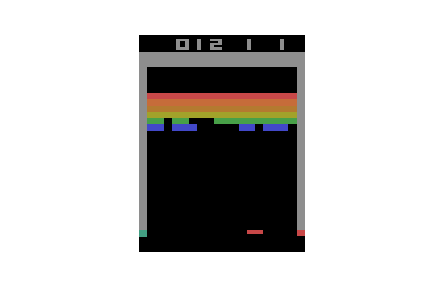
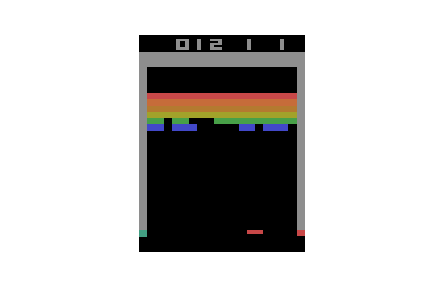
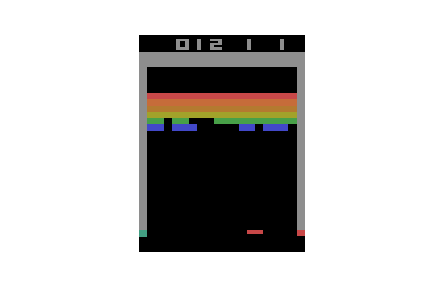
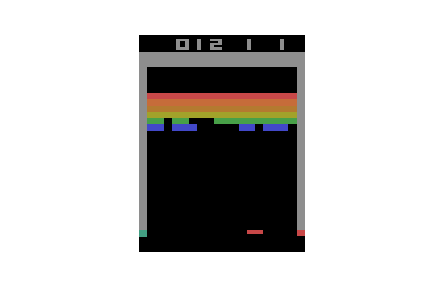
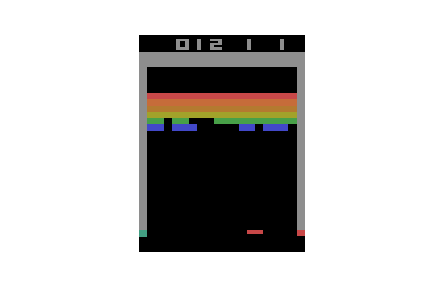
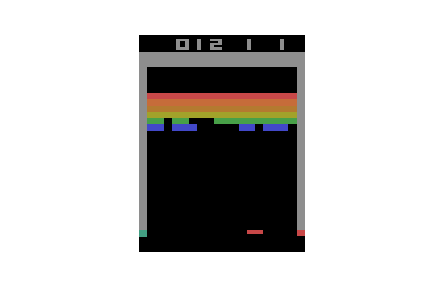
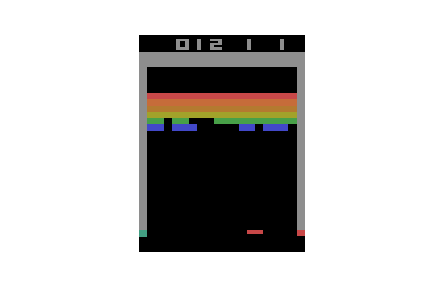
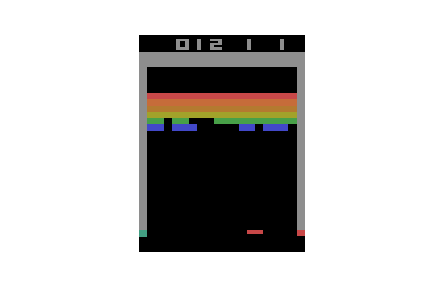
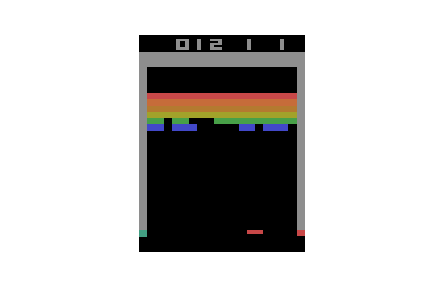
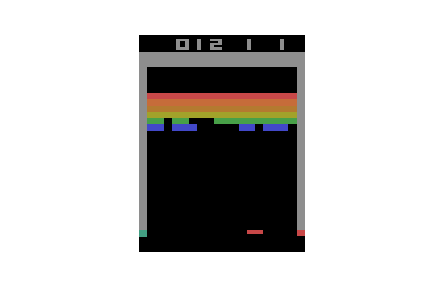
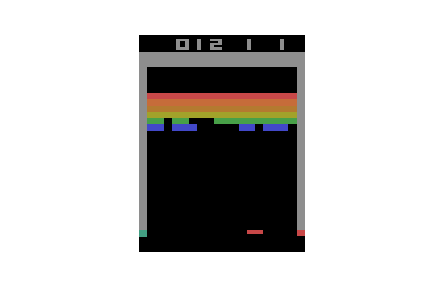
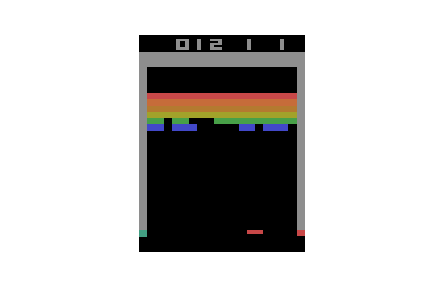
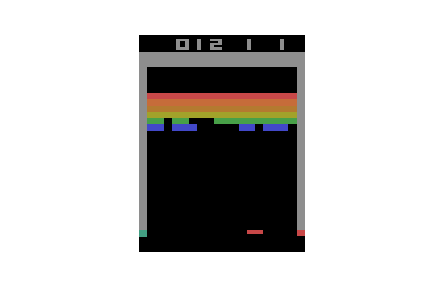
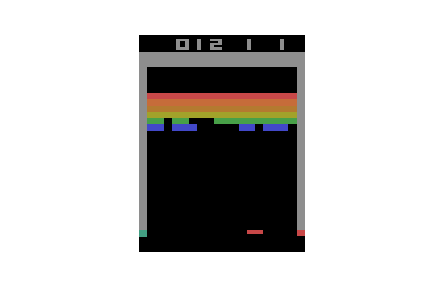
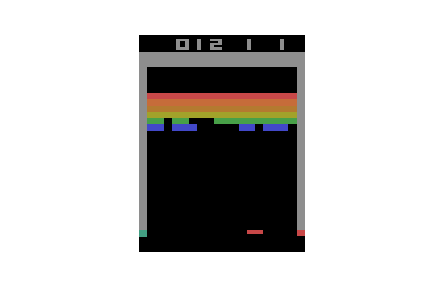
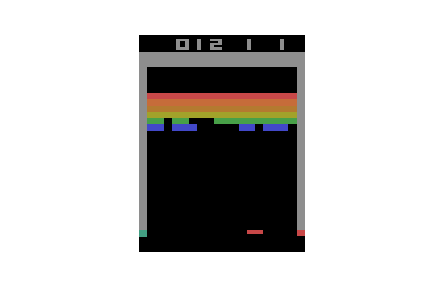
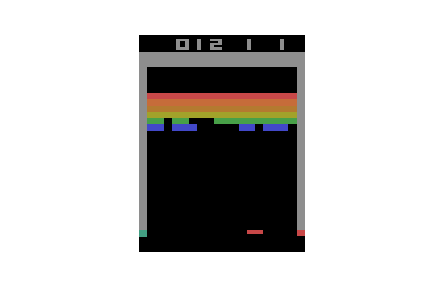
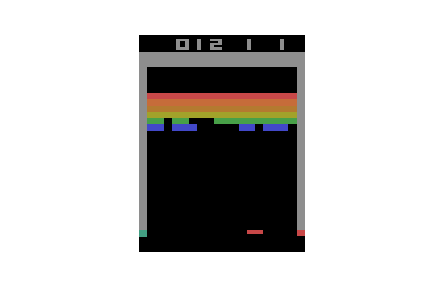
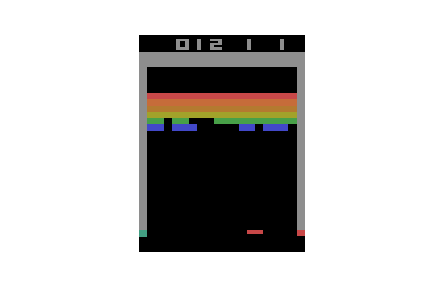
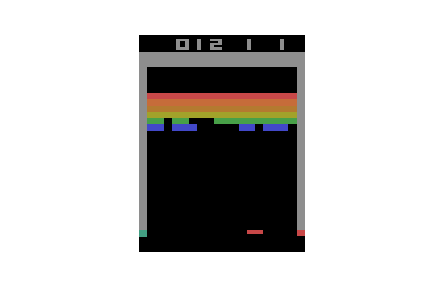
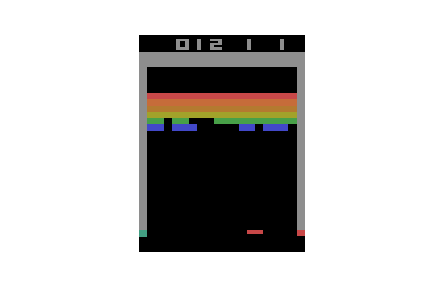
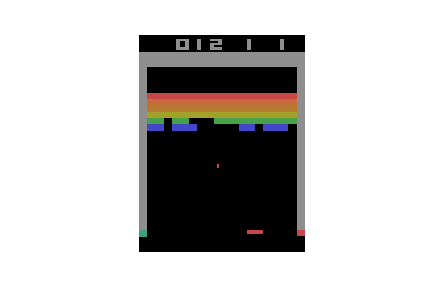
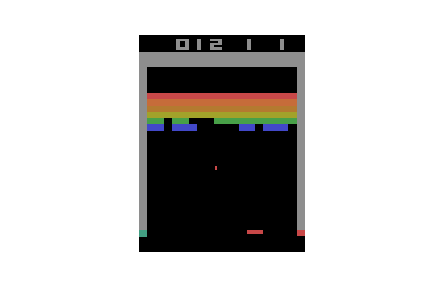
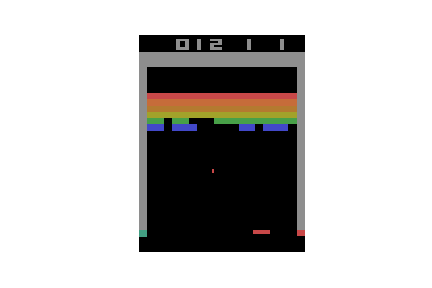
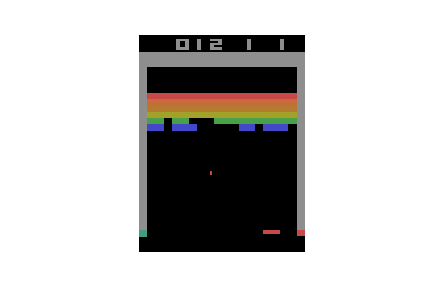
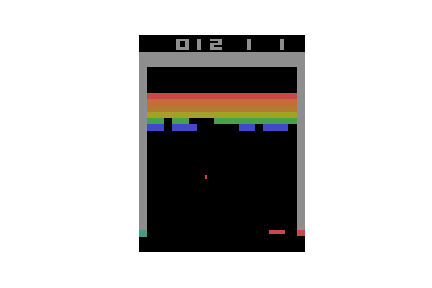
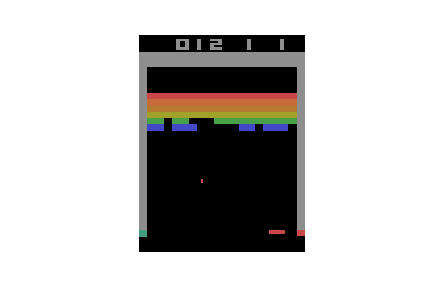
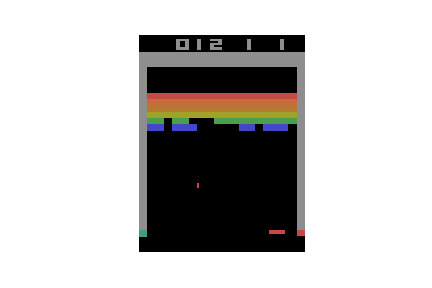
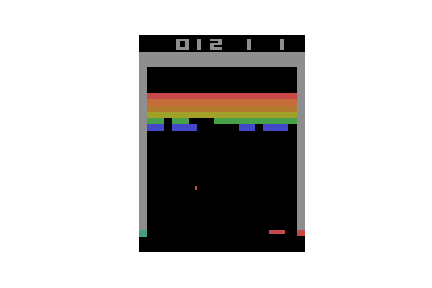
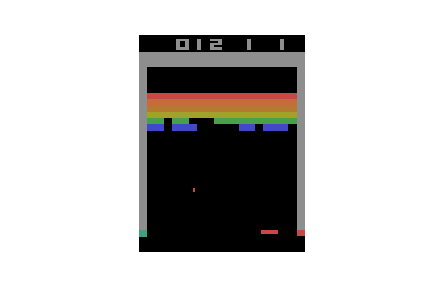
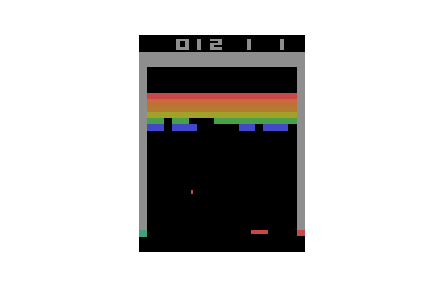
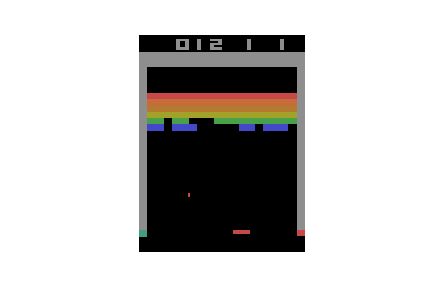
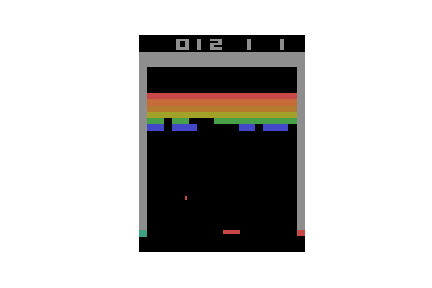
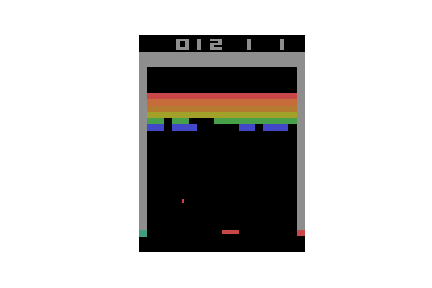
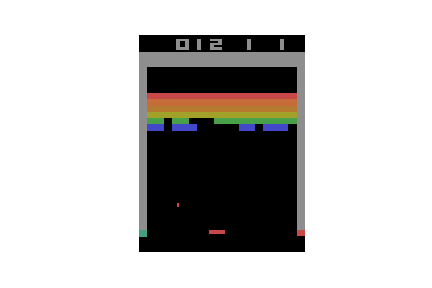
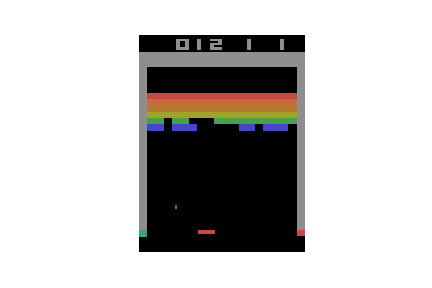
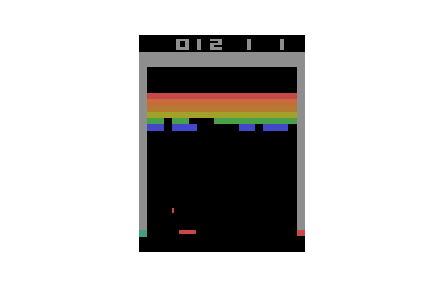
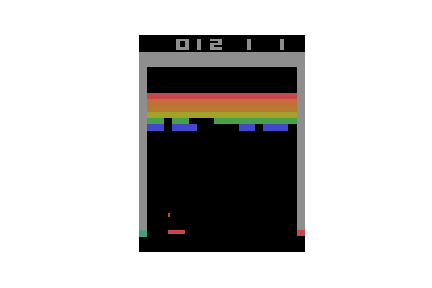
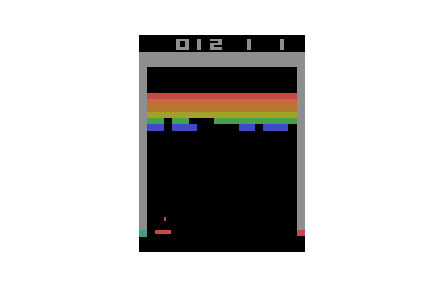
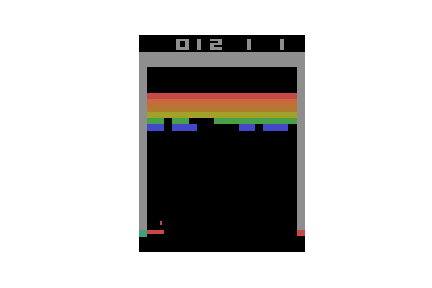
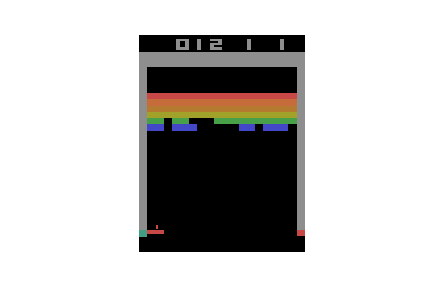
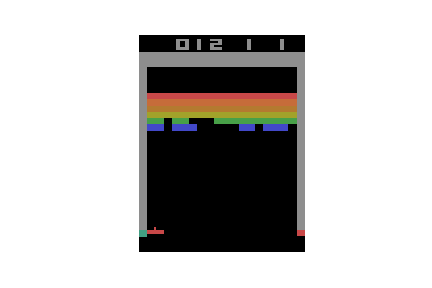
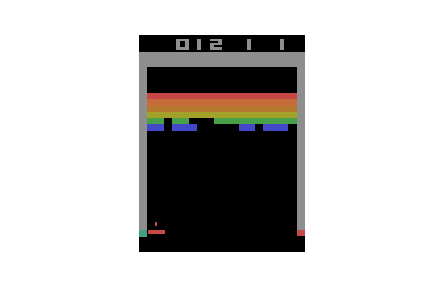
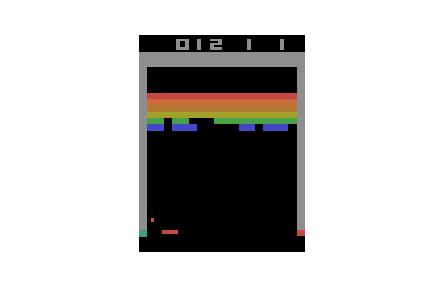
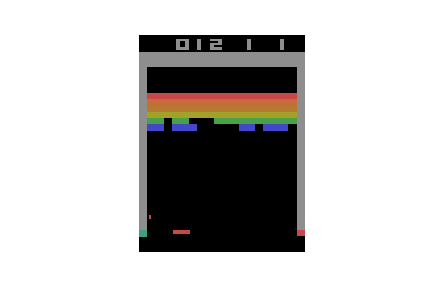
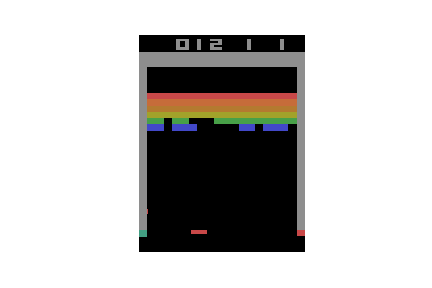
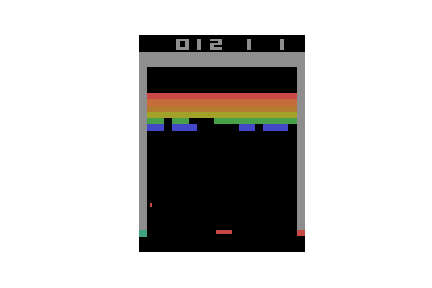
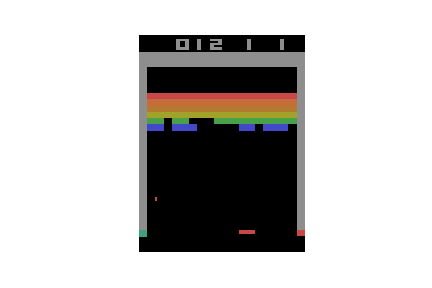
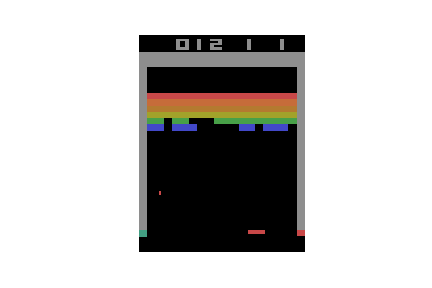
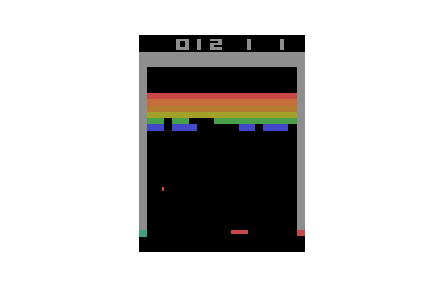
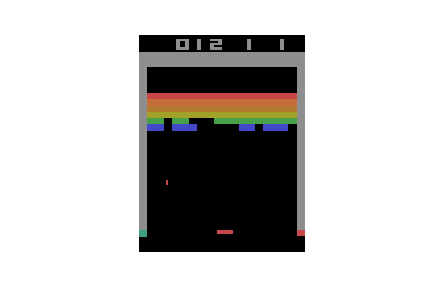
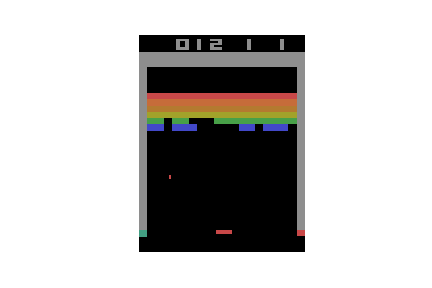
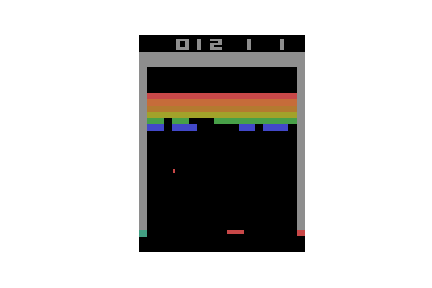
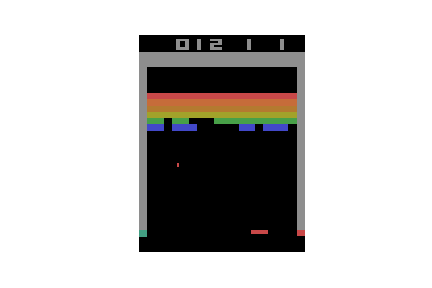
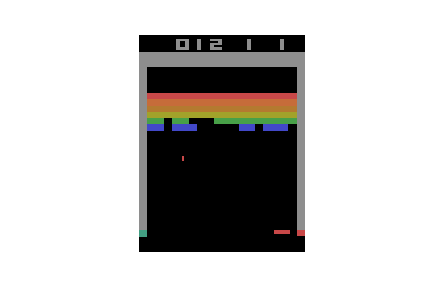
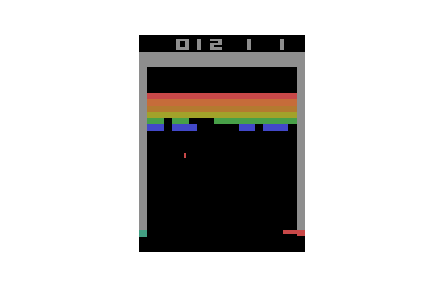
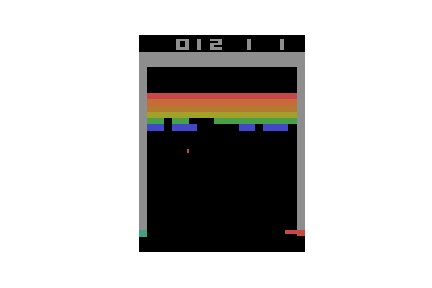
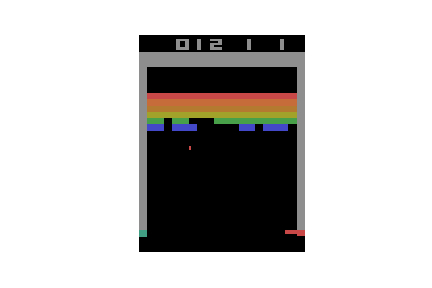
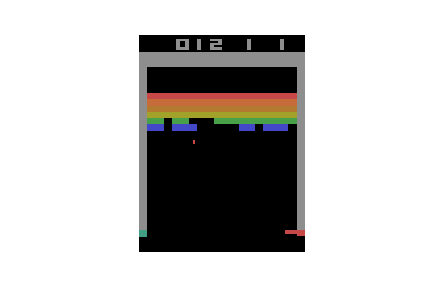
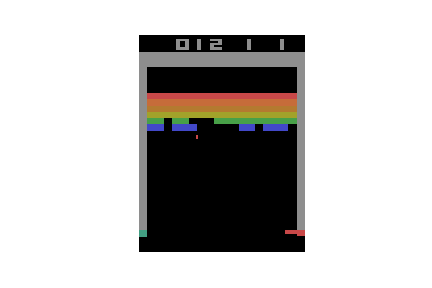
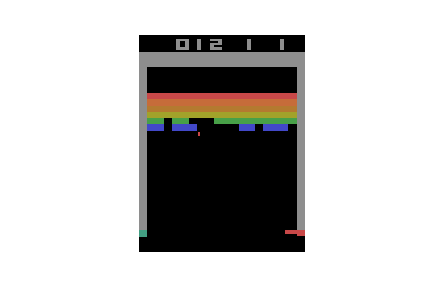
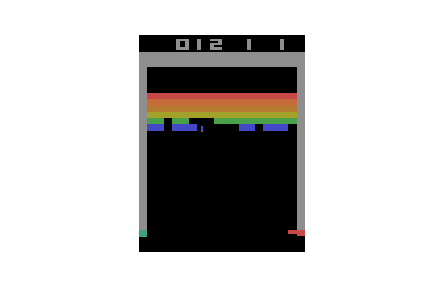
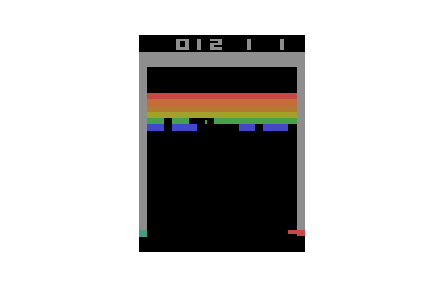
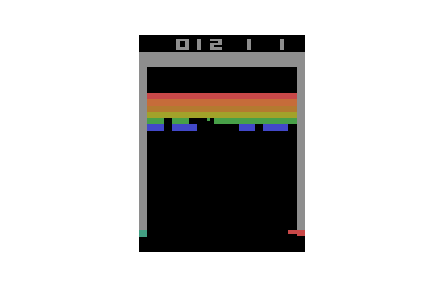
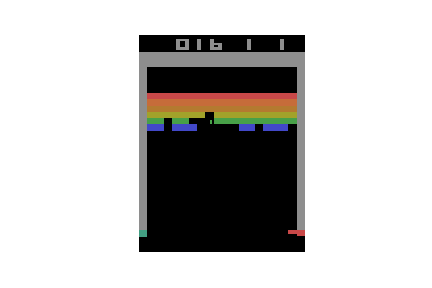
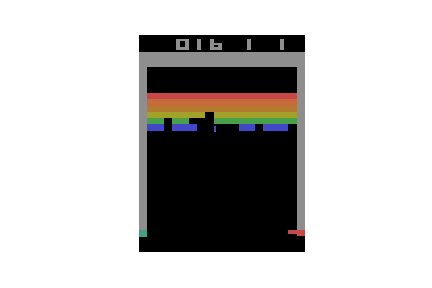
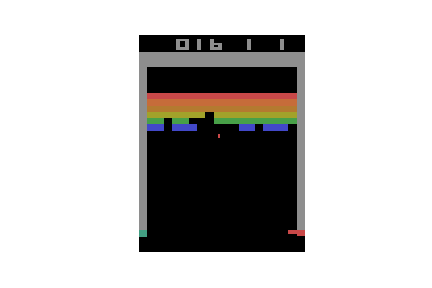
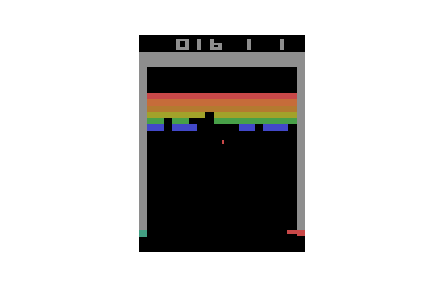
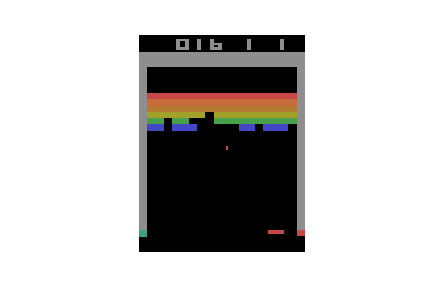
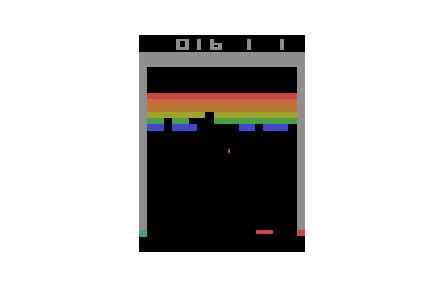
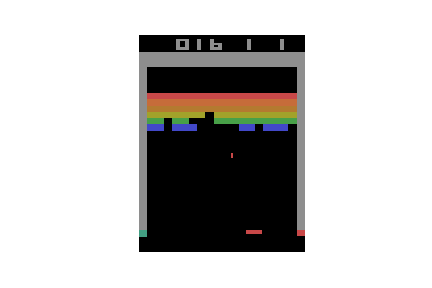
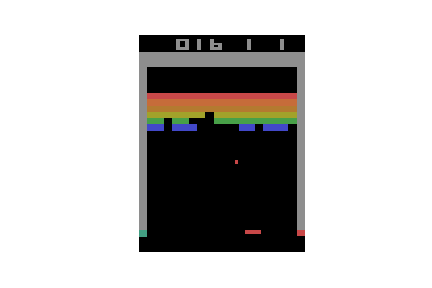
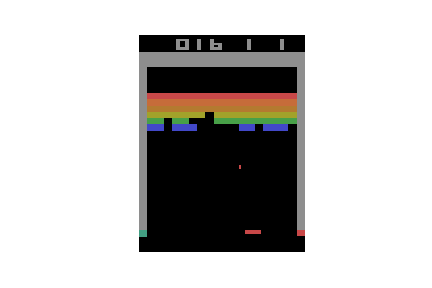
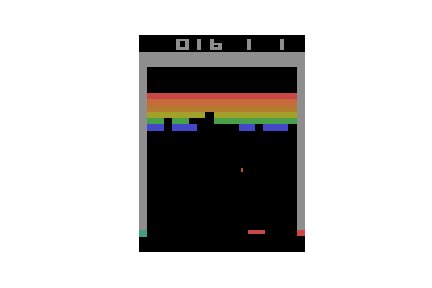
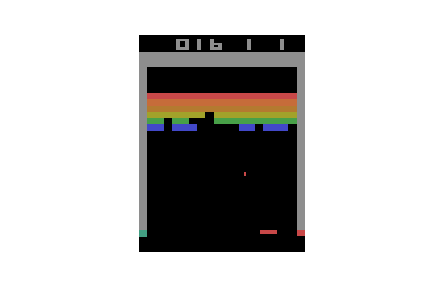
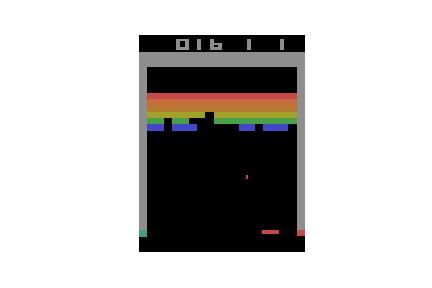
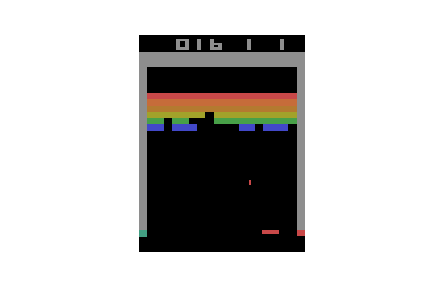
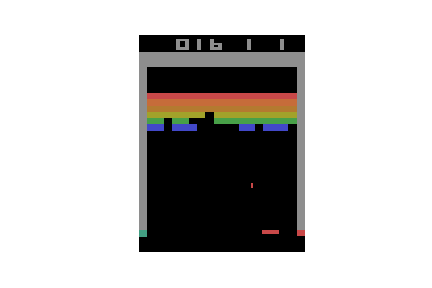
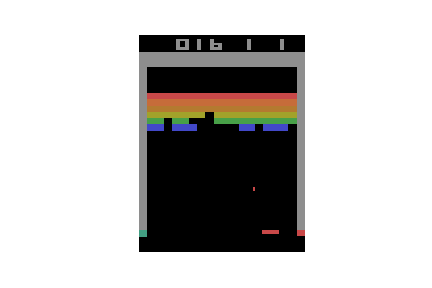
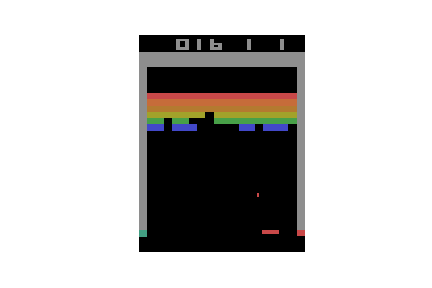
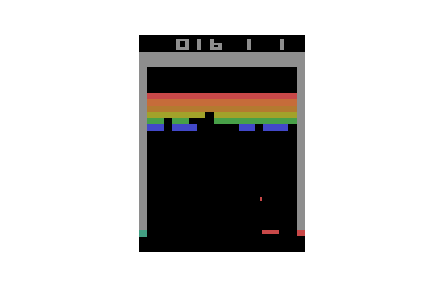
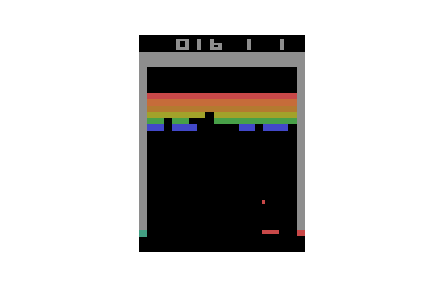
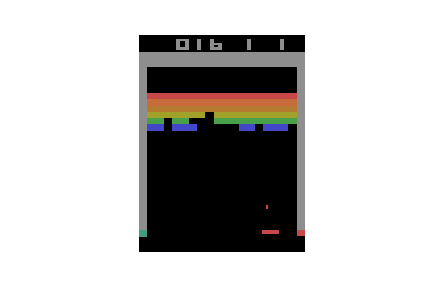
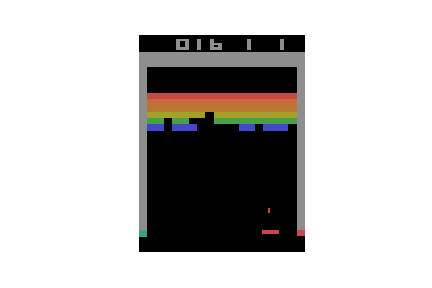
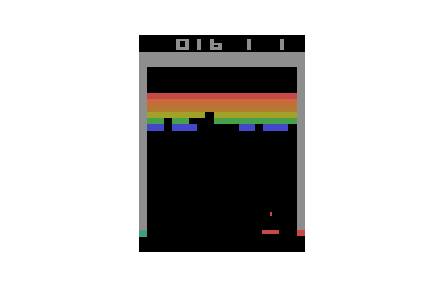
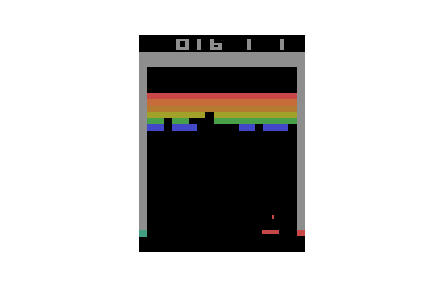
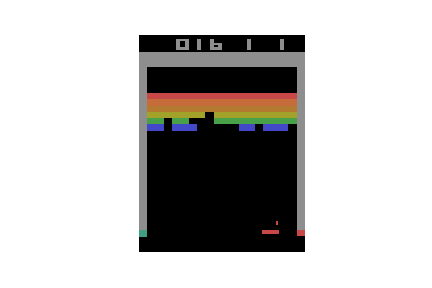
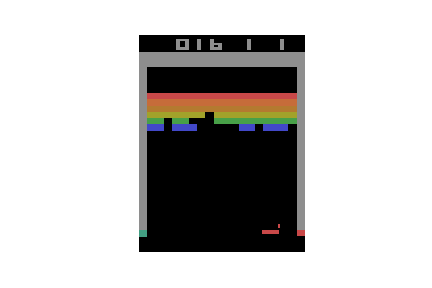
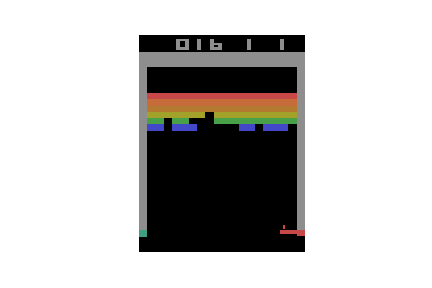
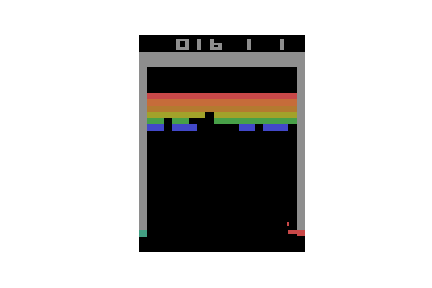
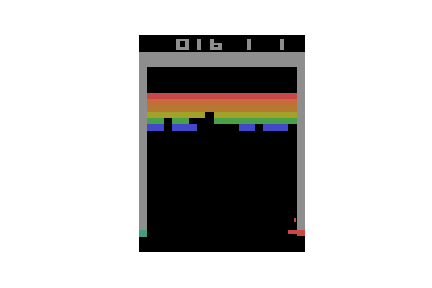
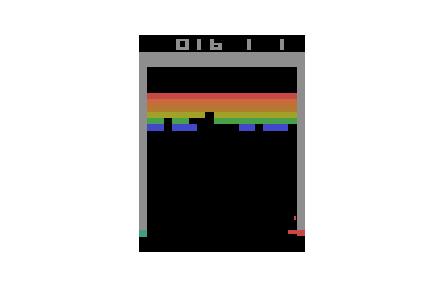
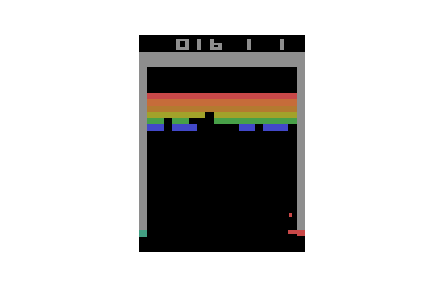
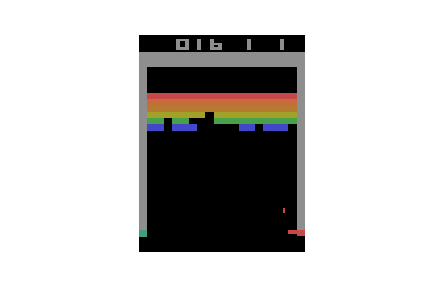
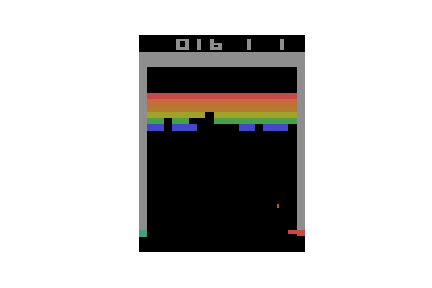
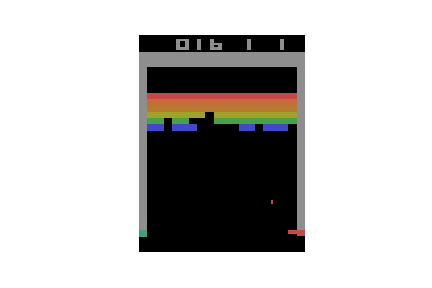
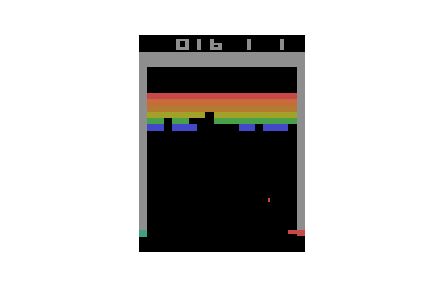
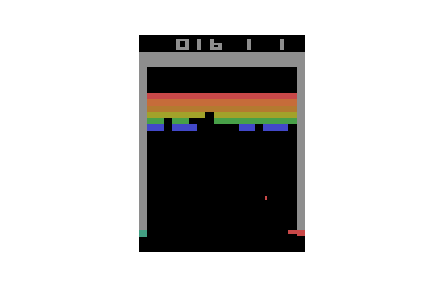
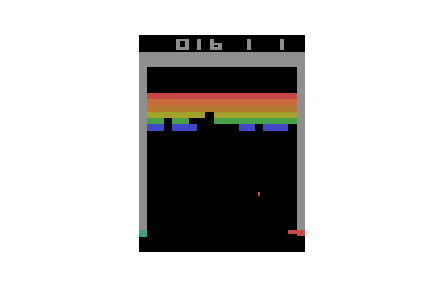
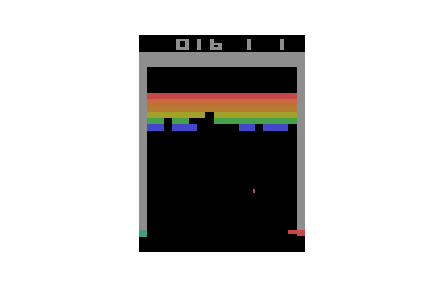
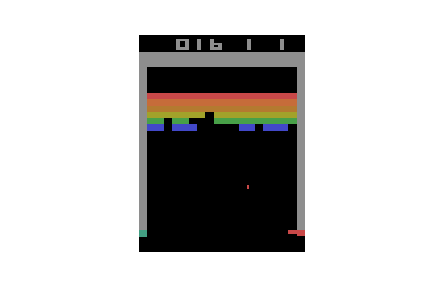
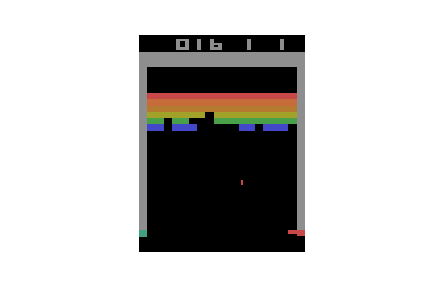
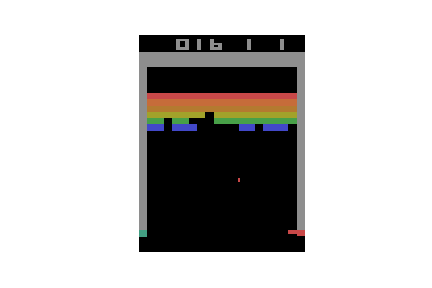
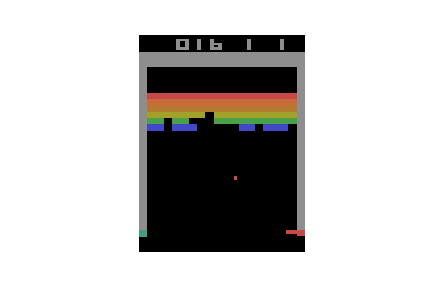
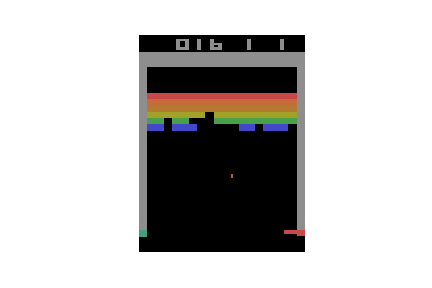
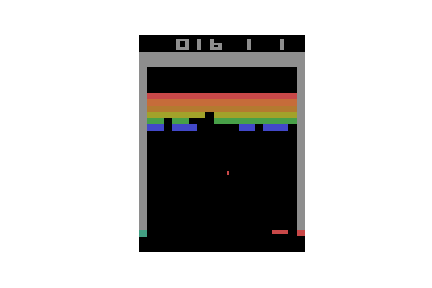
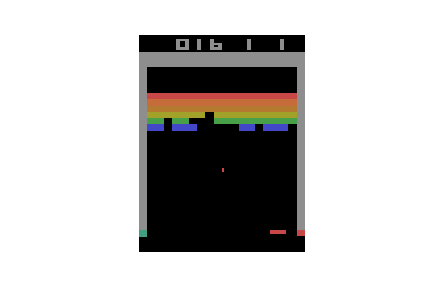
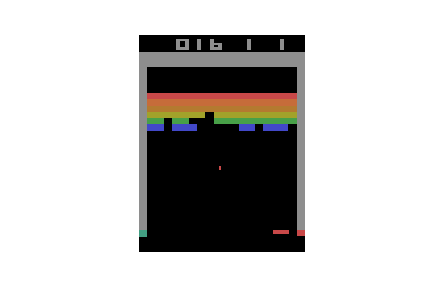
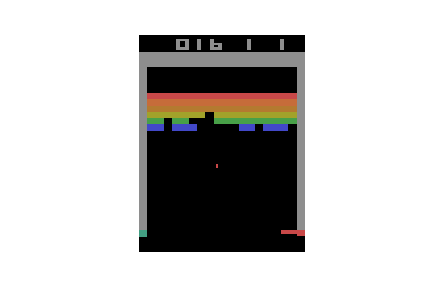
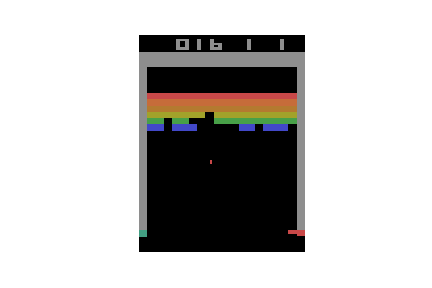
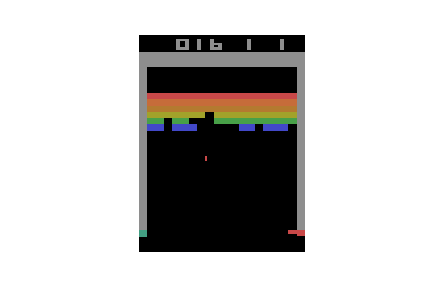
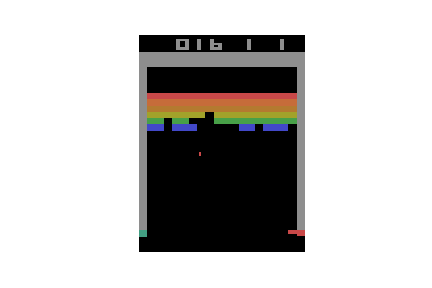
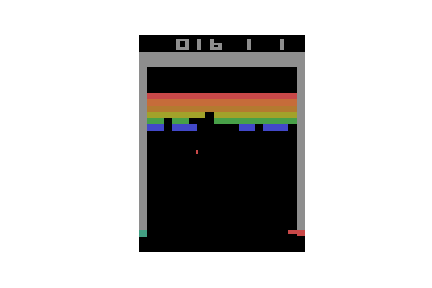
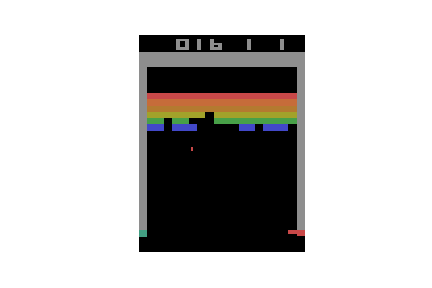
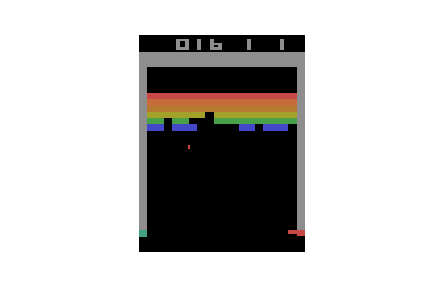
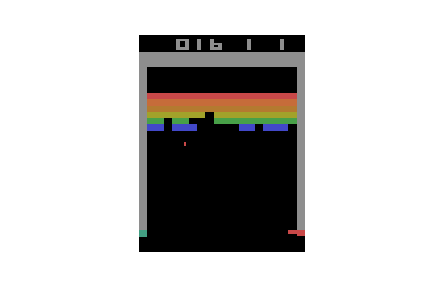
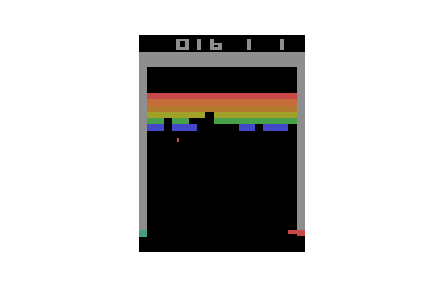
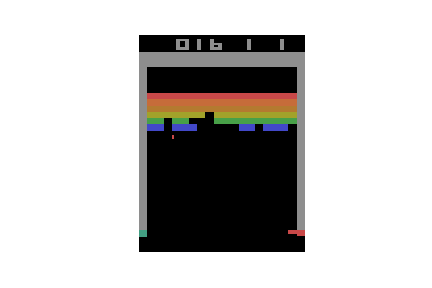
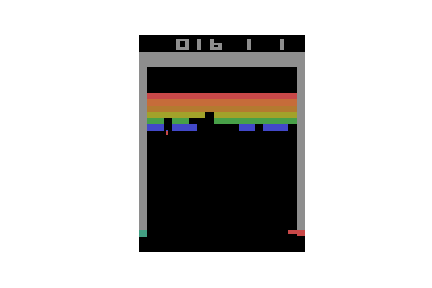
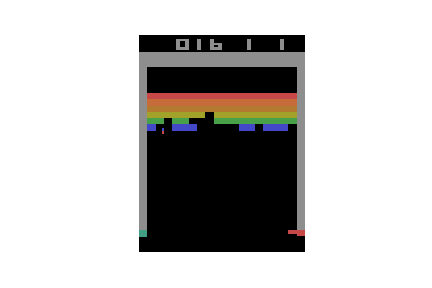
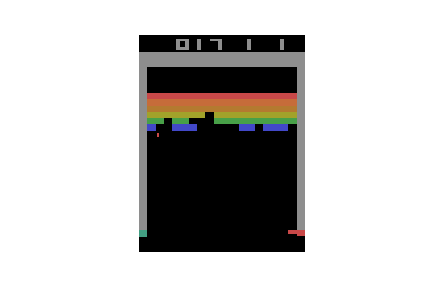
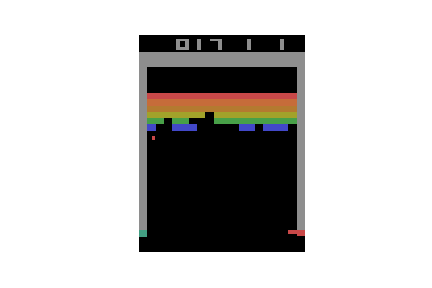
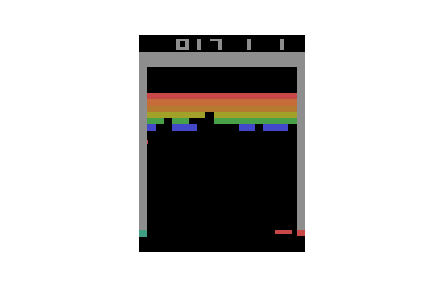
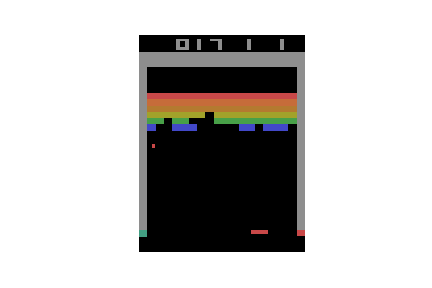
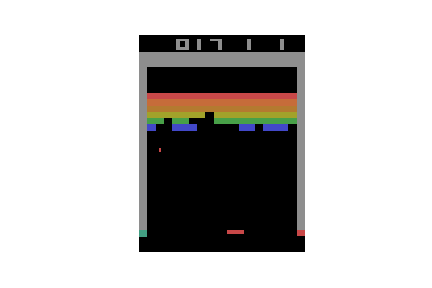
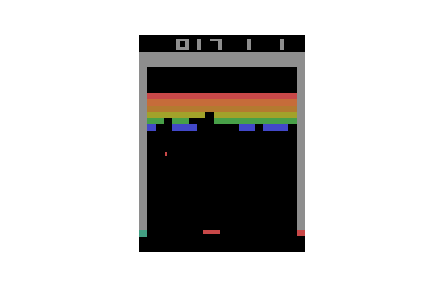
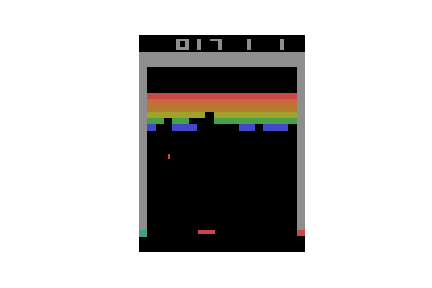
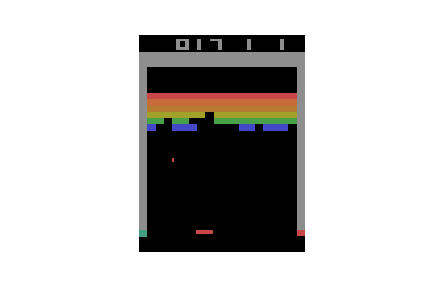
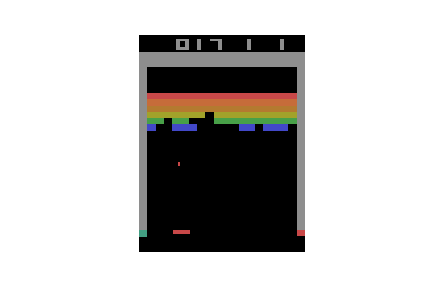
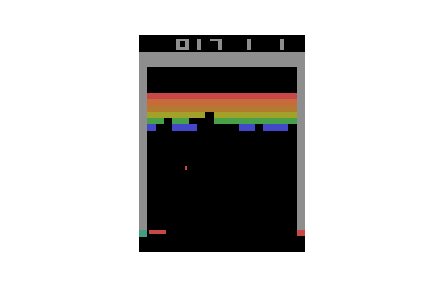
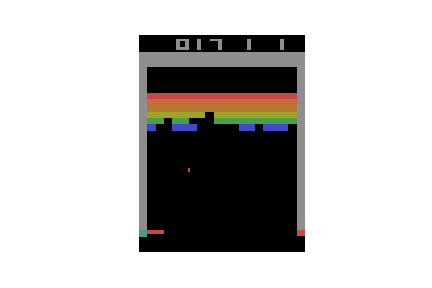
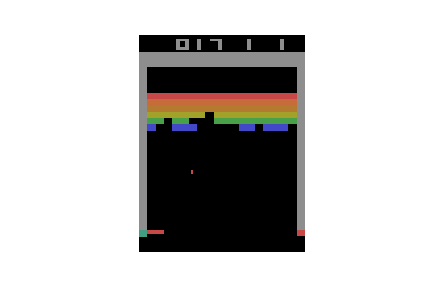
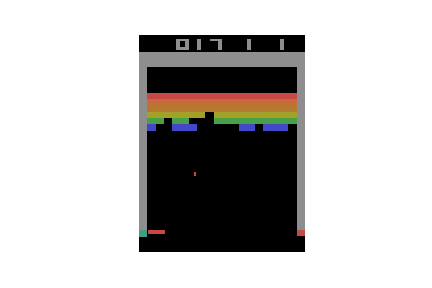
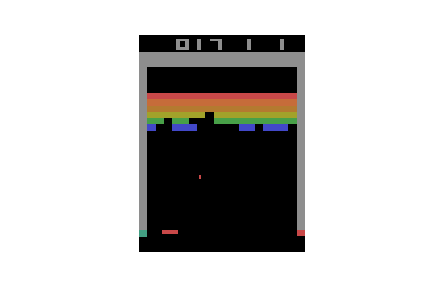
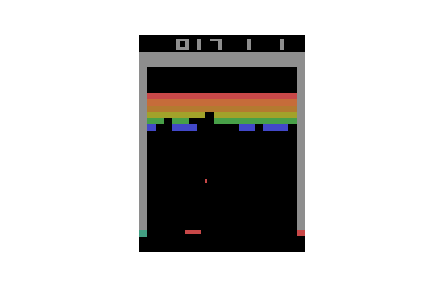
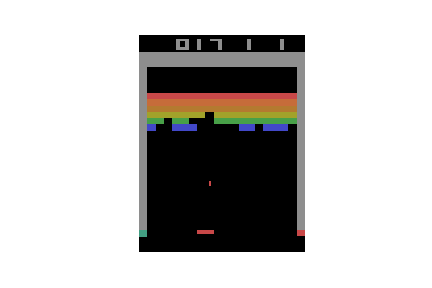
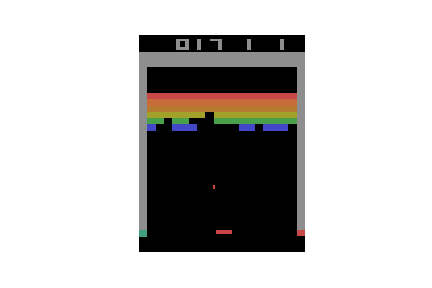
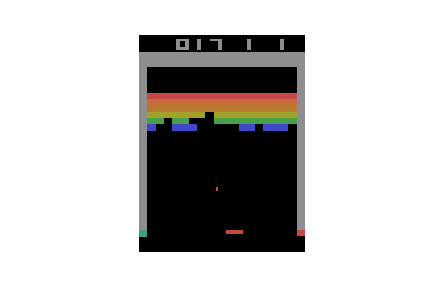
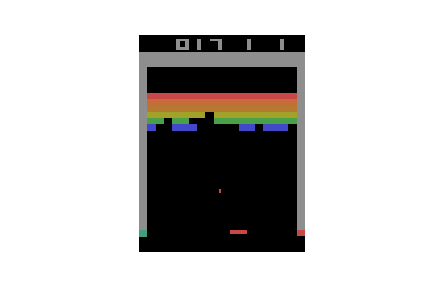
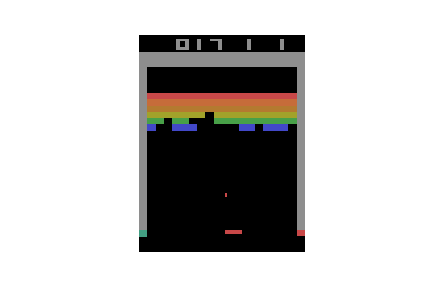
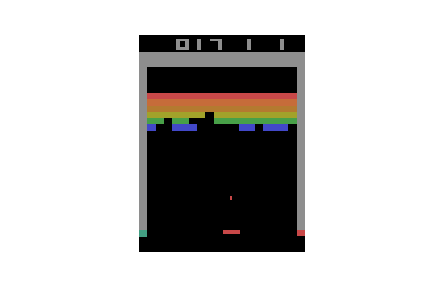
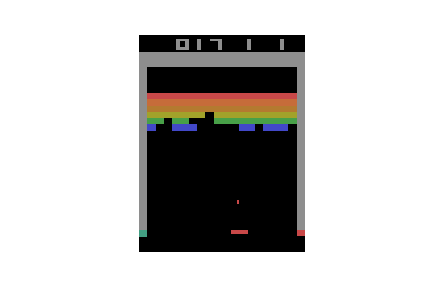
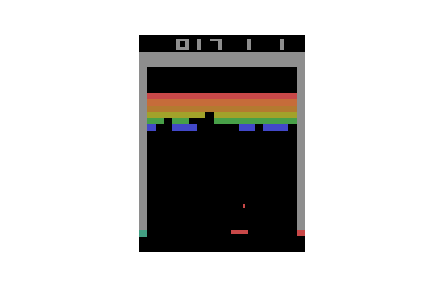
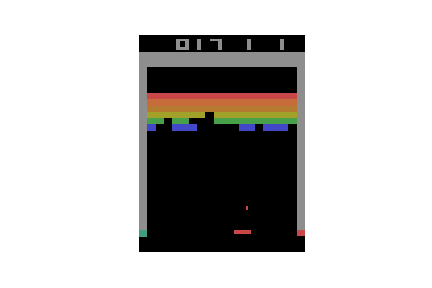
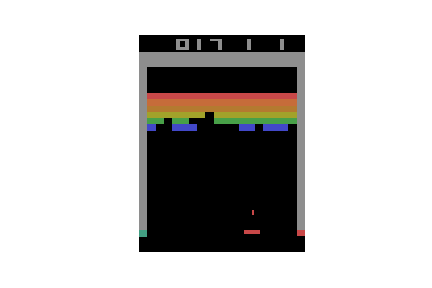
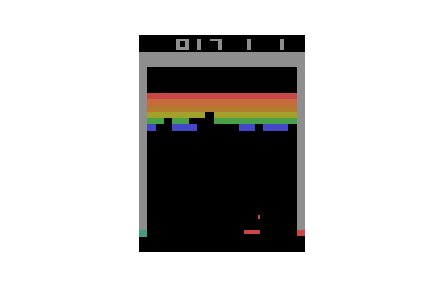
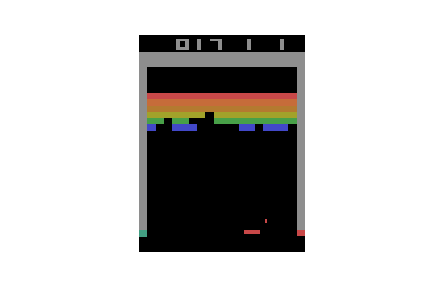
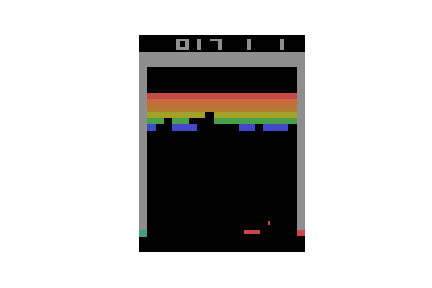
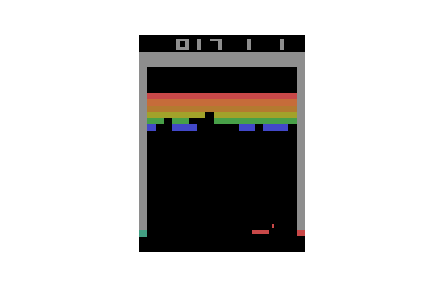
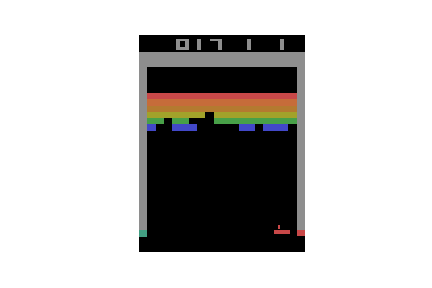
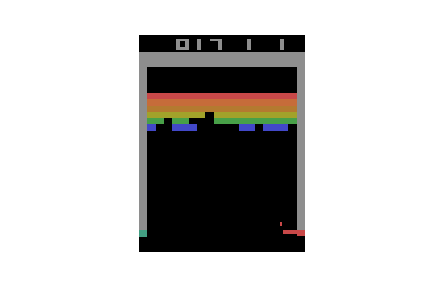
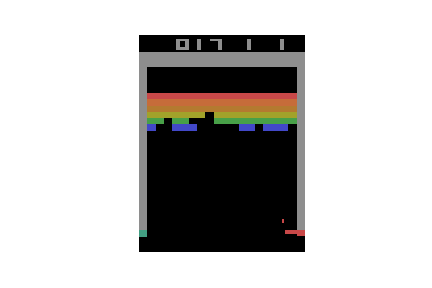
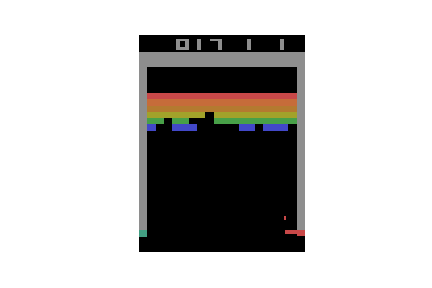
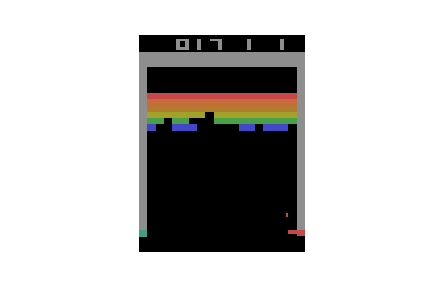
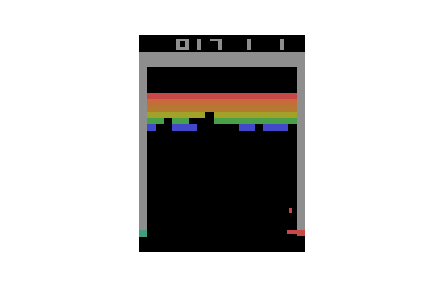
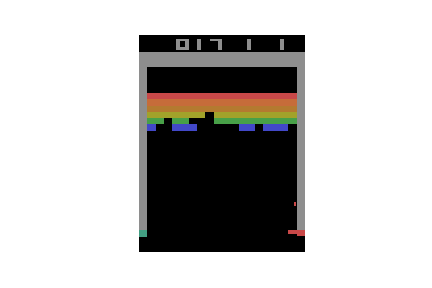
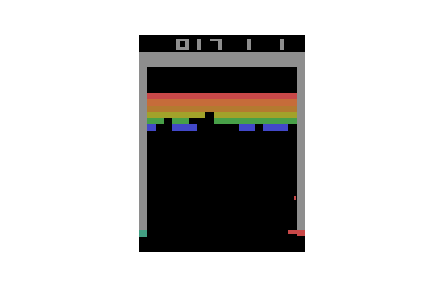
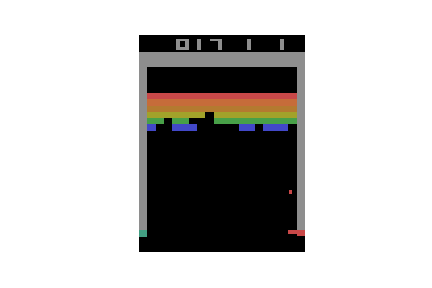
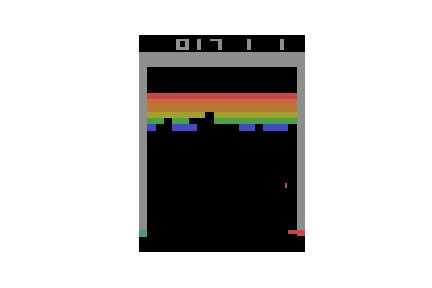
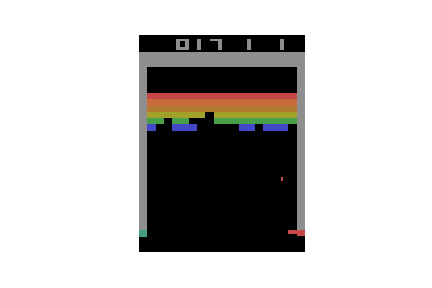
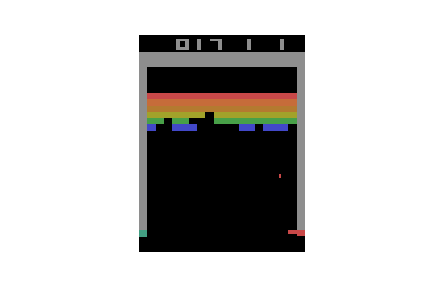
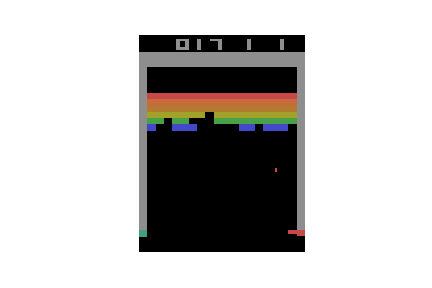
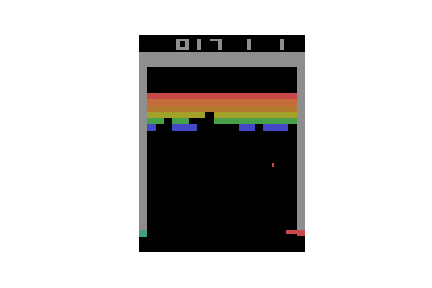
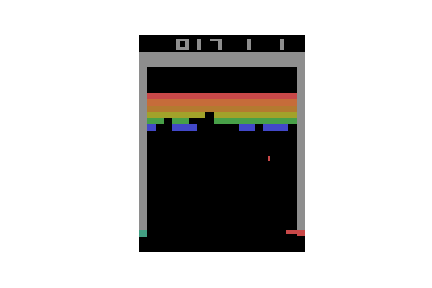
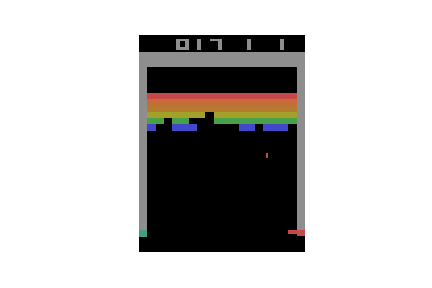
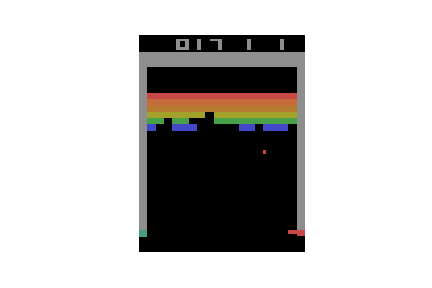
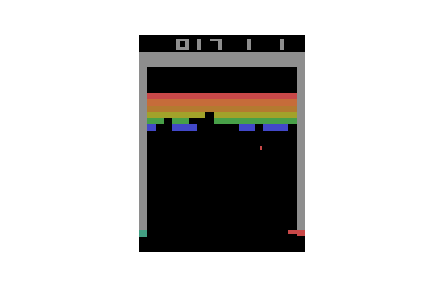
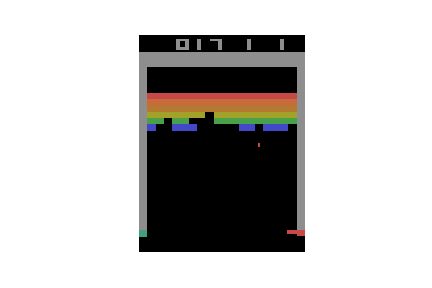
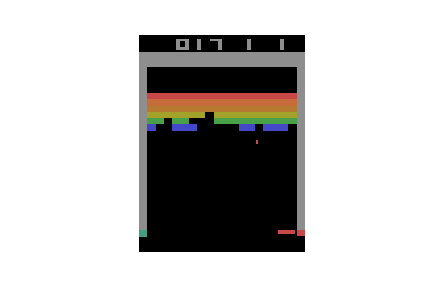
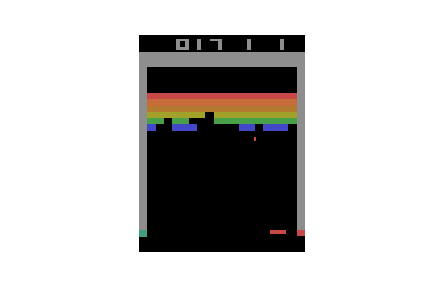
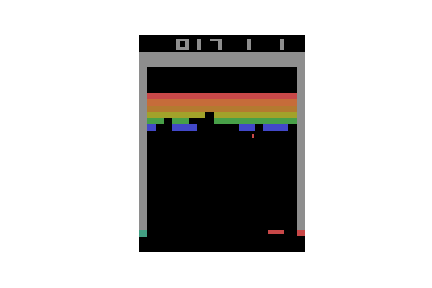
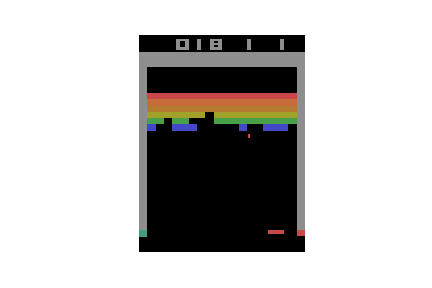
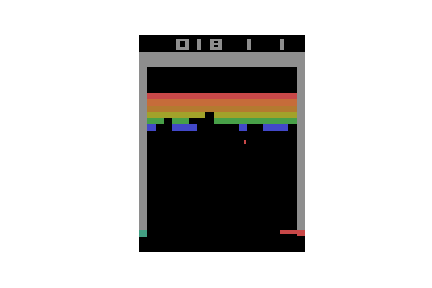
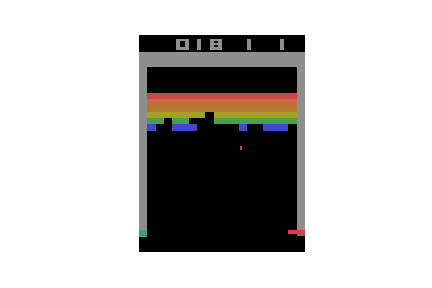
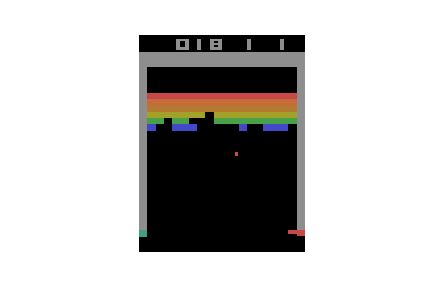
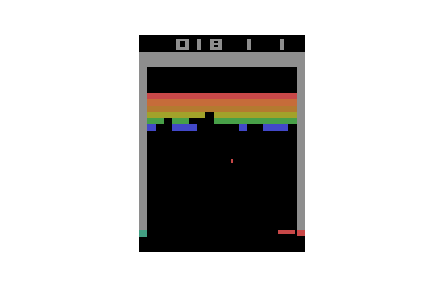
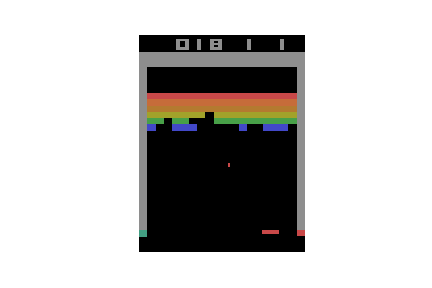
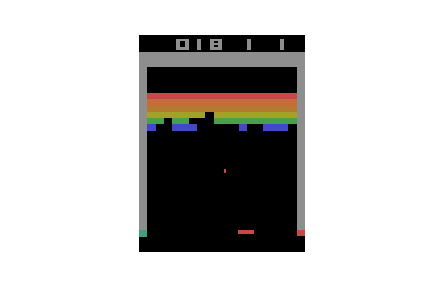
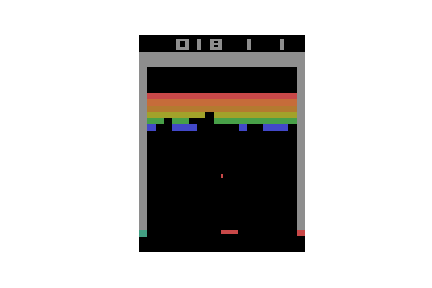
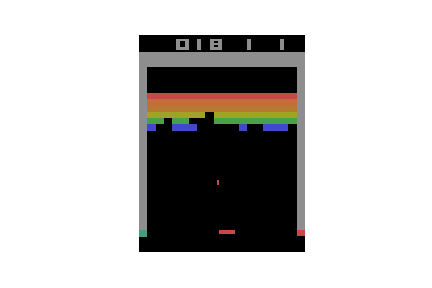
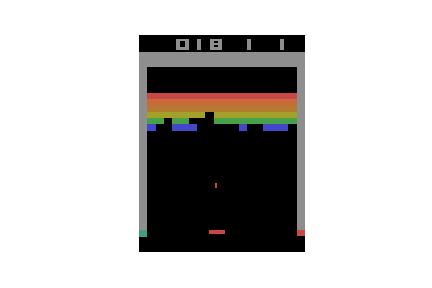
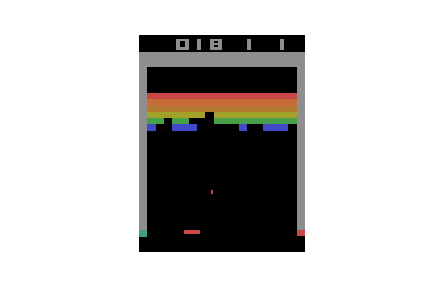
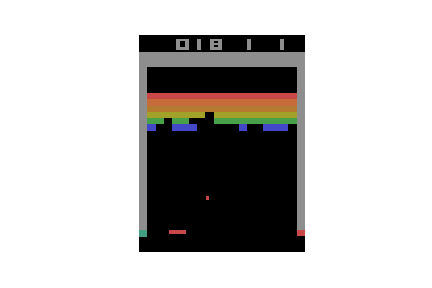
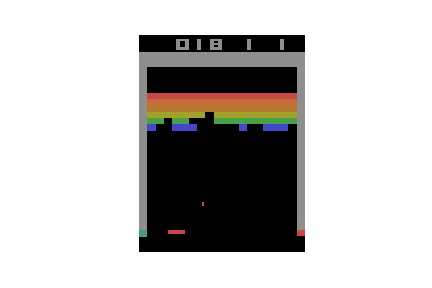
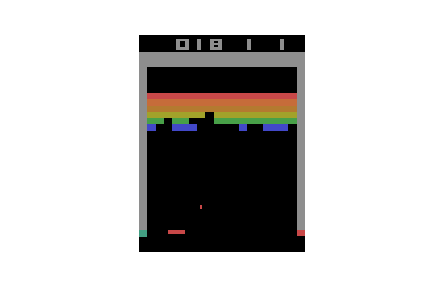
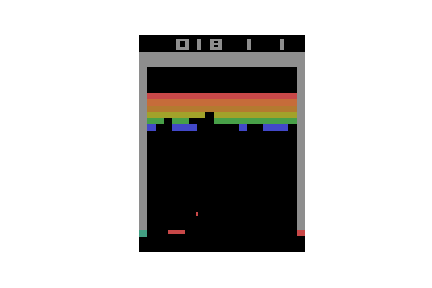
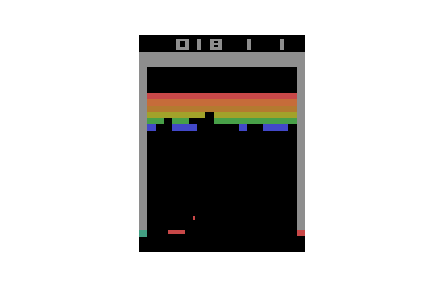
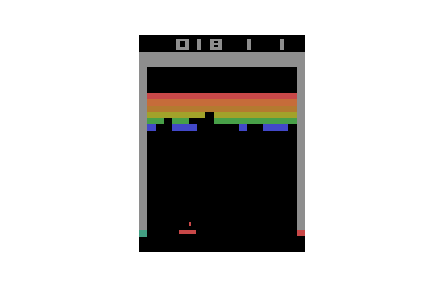
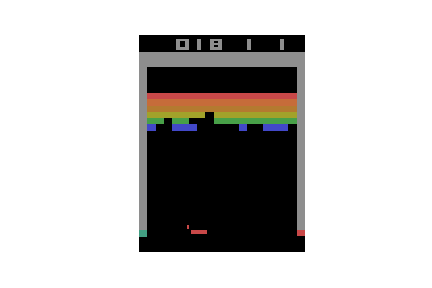
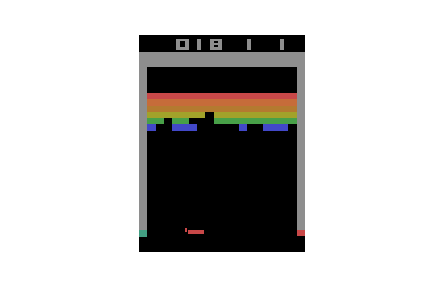
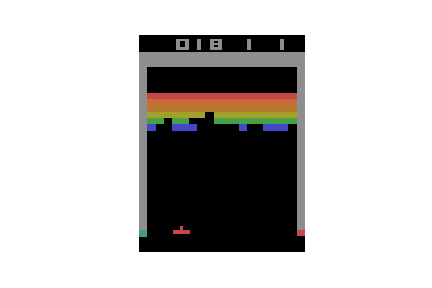
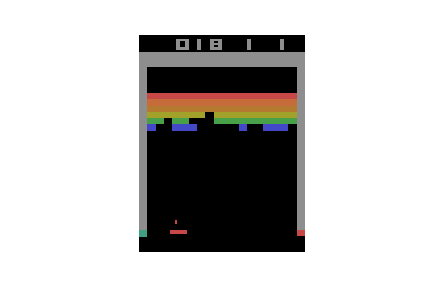
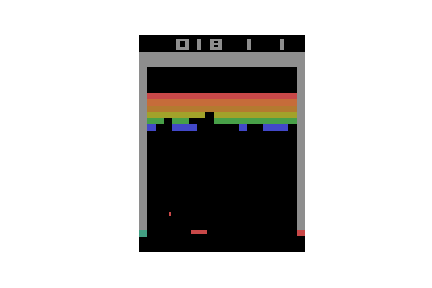
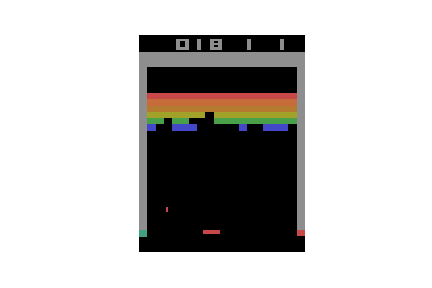
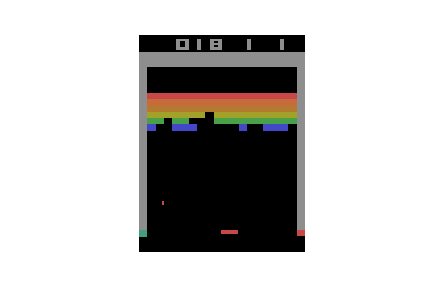
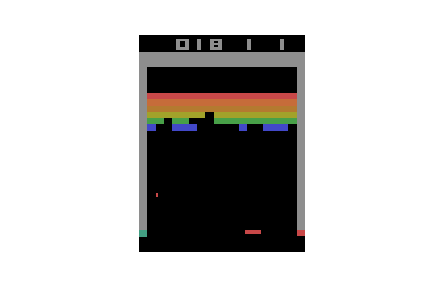
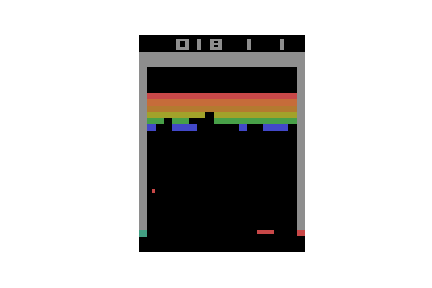
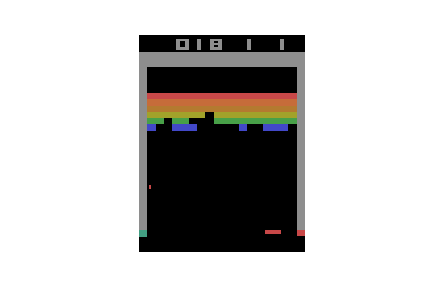
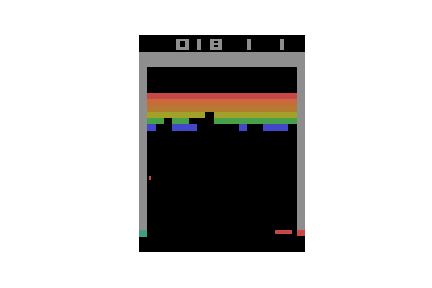
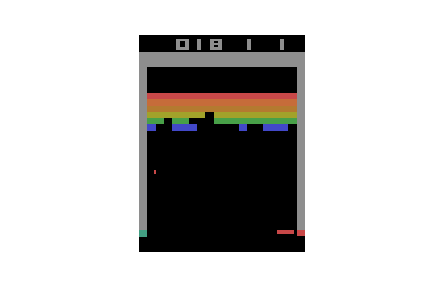
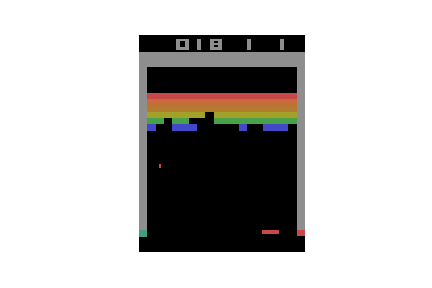
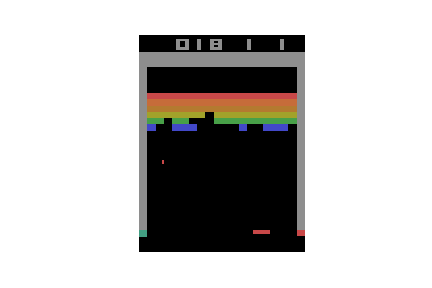
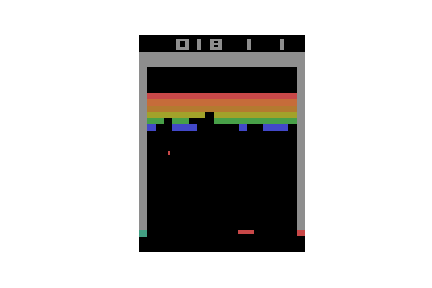
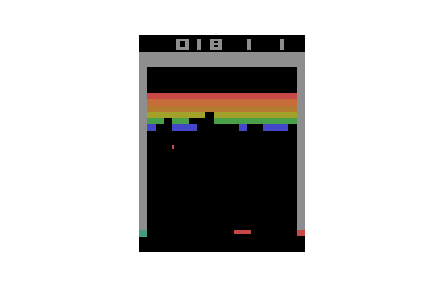
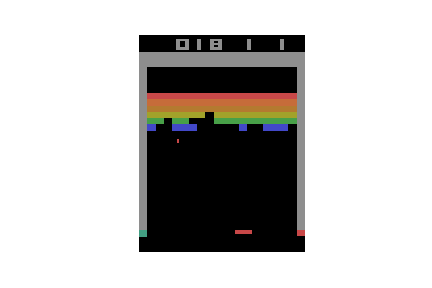
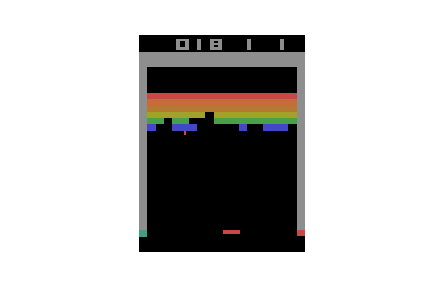
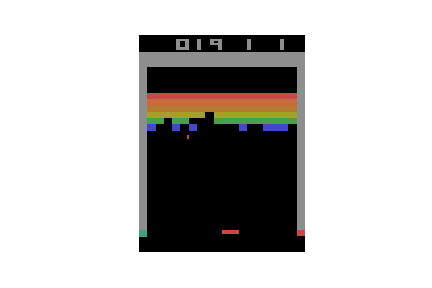
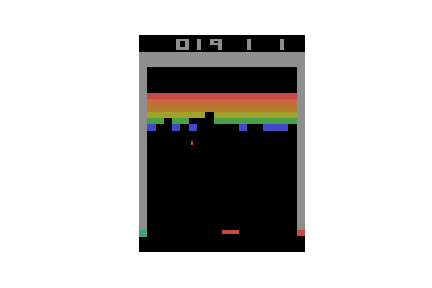
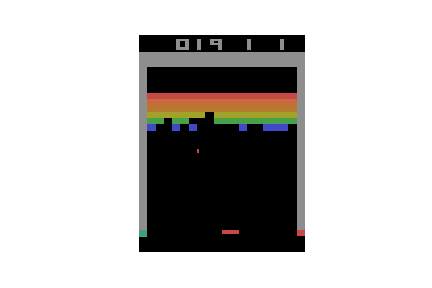
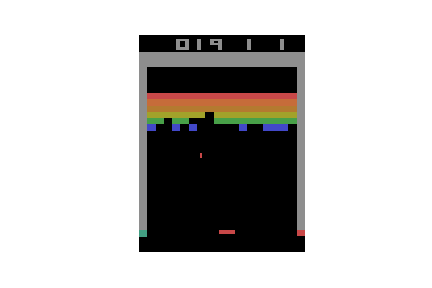
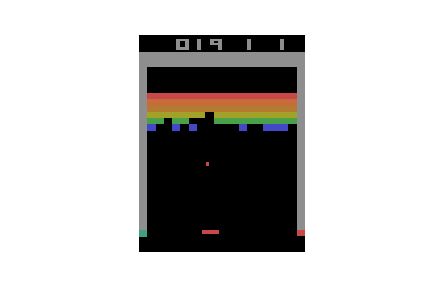
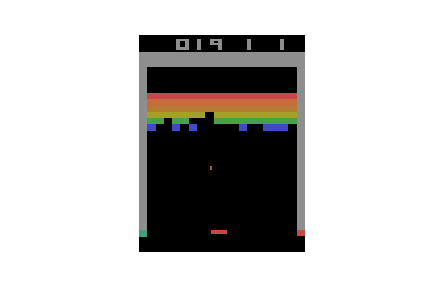
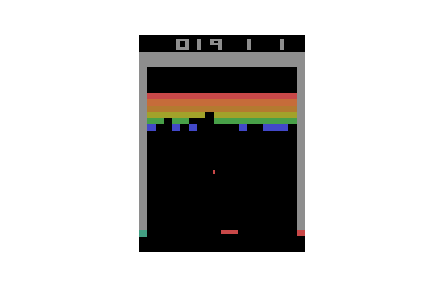
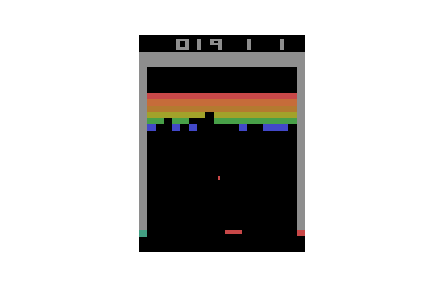
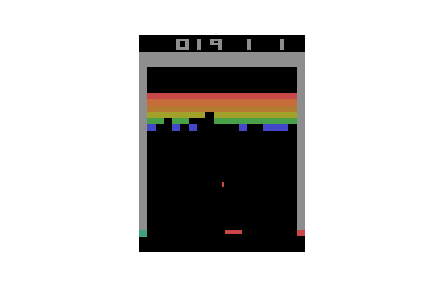
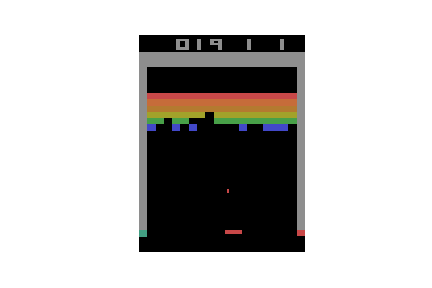
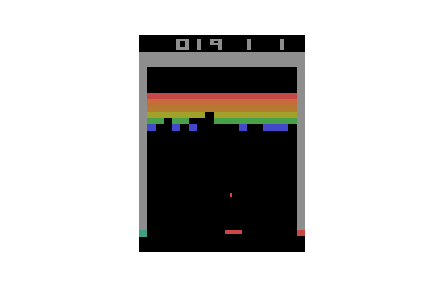
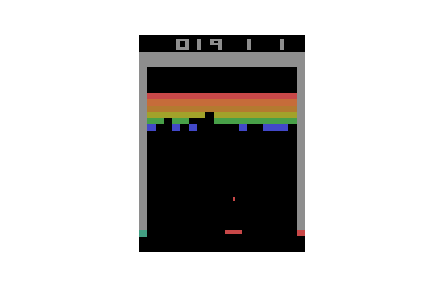
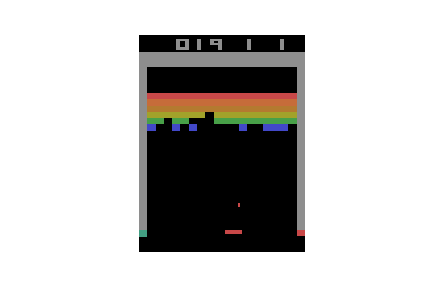
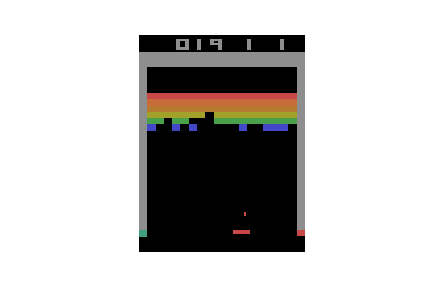
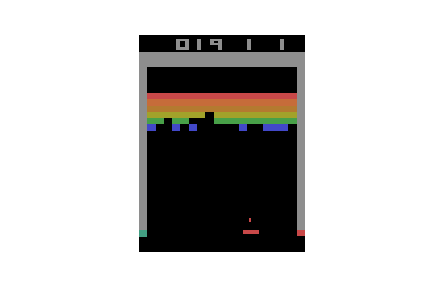
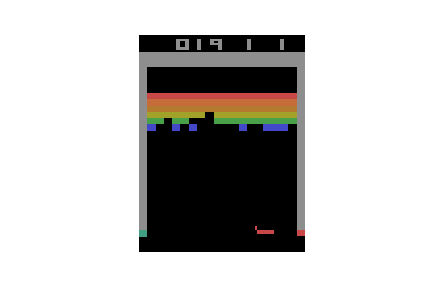
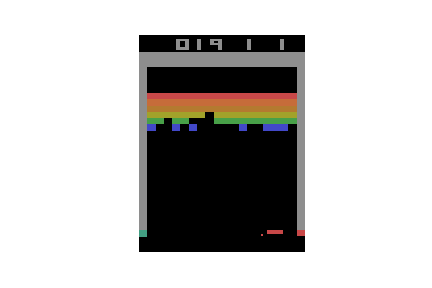
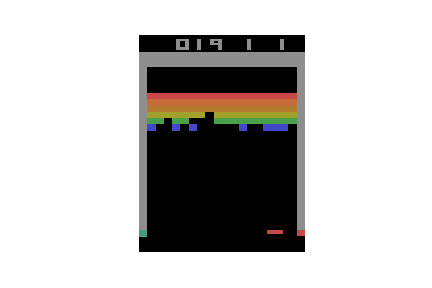
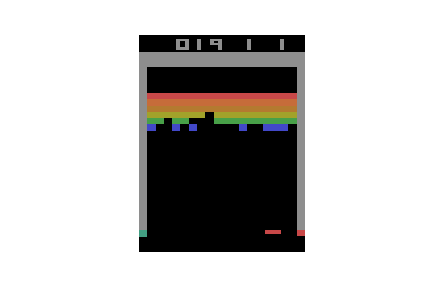
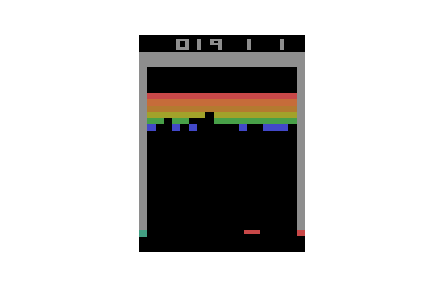
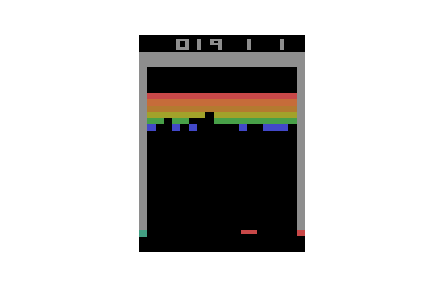

In [12]:
# Display the game as an image
import matplotlib.animation as animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
patch = plt.imshow(frames[0])
plt.axis('off')
def animate(i):
    patch.set_data(frames[i])
anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval = 50)

display(display_animation(anim, default_mode='loop'))
env.close()